In [84]:
import tensorflow as tf
from PIL import Image
import os
import random
import pandas as pd
import matplotlib.pyplot as plot

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random', 'plot']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Classify invasive hydrangea species
- Resources: http://cv-tricks.com/tensorflow-tutorial/training-convolutional-neural-network-for-image-classification/

### Setup the classes

In [2]:
classes = ['invasive','non_invasive']
num_classes = len(classes)
num_channels = 3

#### Setup the data


In [3]:
batch_size = 16
img_size =  128

In [4]:
test_image = Image.open("../data/test/1.jpg")

In [5]:
np.array(test_image)

array([[[181, 202, 207],
        [175, 196, 201],
        [168, 187, 194],
        ..., 
        [165, 161, 196],
        [184, 181, 212],
        [216, 213, 244]],

       [[173, 194, 199],
        [181, 202, 207],
        [178, 197, 204],
        ..., 
        [248, 247, 255],
        [249, 249, 251],
        [255, 255, 255]],

       [[157, 176, 182],
        [177, 196, 202],
        [182, 201, 207],
        ..., 
        [254, 255, 255],
        [255, 255, 251],
        [253, 254, 249]],

       ..., 
       [[ 84, 128,  65],
        [ 89, 132,  76],
        [ 90, 133,  87],
        ..., 
        [ 99, 115, 105],
        [ 99, 112, 105],
        [ 99, 112, 105]],

       [[ 65, 106,  66],
        [ 54,  88,  61],
        [ 46,  77,  62],
        ..., 
        [106, 118, 106],
        [104, 117, 107],
        [108, 121, 111]],

       [[ 65, 104,  75],
        [ 44,  77,  58],
        [ 45,  75,  65],
        ..., 
        [108, 120, 108],
        [106, 120, 103],
        [110, 124,

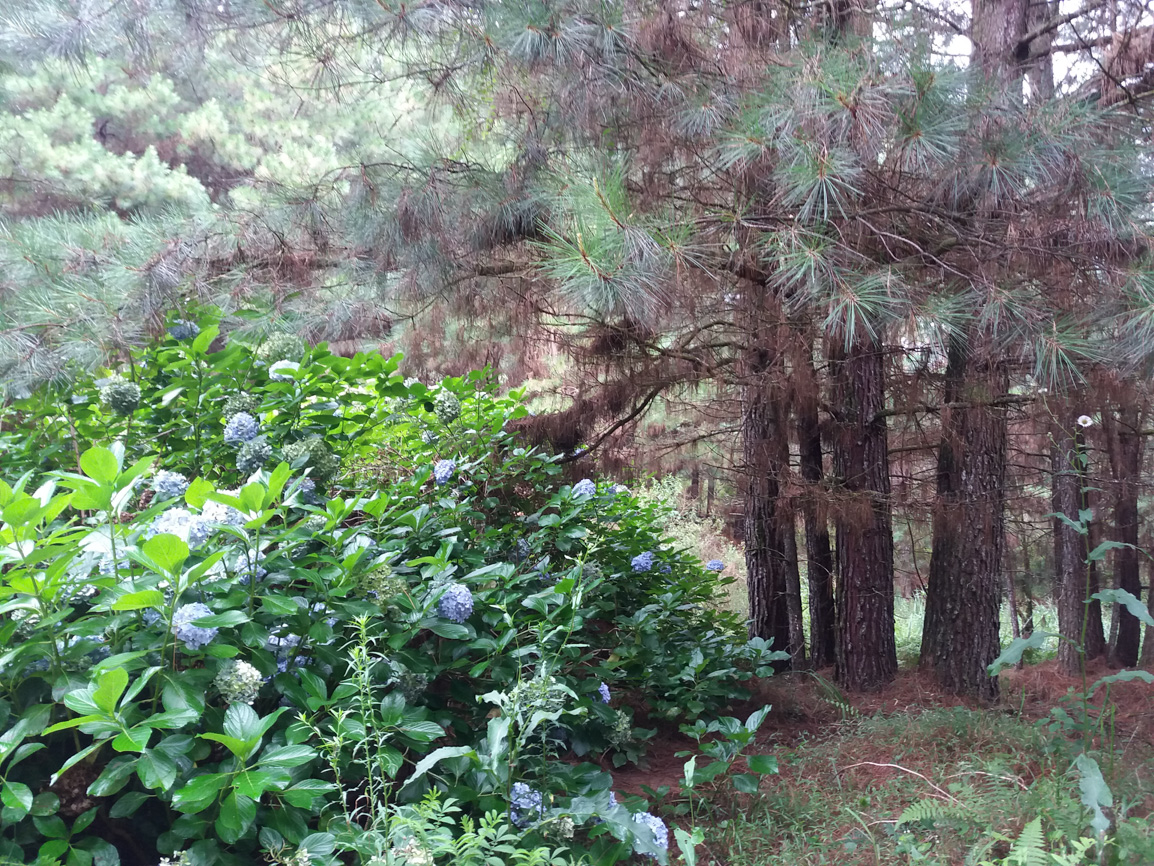

In [6]:
test_image

- resize each image

In [7]:
arr = np.array(test_image.resize((128,128)))

In [8]:
arr.flatten().shape

(49152,)

## Read in the data
- change size to 128 x 128 x 3
- flatten image to one-d (128 $* 128 *$ 3)

In [65]:
def train_generator(batch_size, img_size=128):
    """A generator for the training data.
    Resizes the images to img_size by img_size
    Flattens the image into a one-dimensional image
    returns a batch with labels transformed in [0,1]  for the negative case and [1,0]
    Returns images, labels"""
    all_images = os.listdir("../data/train")
    # shuffle the images
    random.shuffle(all_images)
    
    # get the labels
    labels = pd.read_csv("../data/train_labels-1.csv")
    labels_dict = {label[1]['name']:label[1]['invasive'] for label in labels.iterrows()}
    
    
    # all images resized
    image_batch = []
    labels = []
    # batches returned
    batches_returned = 0
    for idx,train_image in enumerate(all_images):        
        if batches_returned >0:
            if ((idx) % (batches_returned*batch_size) ==0) & (idx !=0):
                # reset the lists to yield the correct batch size
                image_batch = []
                labels = []

        # find the label for our image
        image_number = int(train_image.split('.')[0])
        # either 1 or 0
        coresponding_label = labels_dict[image_number]
        
        if coresponding_label == 1:
            labels.append([1,0])
        elif coresponding_label == 0:
            labels.append([0,1])
            
        # get the image
        t_image = Image.open("../data/train/"+train_image)
        # resize
        t_image = np.array(t_image.resize((img_size,img_size)))
        # get our batch ready
        image_batch.append(t_image.flatten())
        if ((idx+1) % batch_size ==0) & idx !=0:
            batches_returned +=1
            yield np.array(image_batch).astype(float32), np.array(labels).astype(float32)

In [10]:
gen = train_generator(2)

In [11]:
img, lab = next(gen)

- Define function for weights and variables

In [46]:

def new_weights(shape):

    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [47]:
def new_biases(length):

    return tf.Variable(tf.constant(0.05, shape=[length]))

- Define a new convolution layer

In [48]:

 
def new_conv_layer(input, num_input_channels, filter_size, num_filters, use_pooling=True):
    


    shape = [filter_size, filter_size,  num_input_channels, num_filters]

    weights = new_weights(shape=shape)

    biases = new_biases(length=num_filters,)

    layer = tf.nn.conv2d(input=input,
                     filter=weights,
                     strides=[1, 1, 1, 1],
                     padding='SAME')

    layer += biases

    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')
    layer = tf.nn.relu(layer)
    return layer, weights

- Flaten the output of the CNN layer for classification

In [40]:
def flatten_layer(layer):

    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()

    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat, num_features

- Define a fully connected layer

In [39]:
def new_fc_layer(input,      
             num_inputs,
             num_outputs,    
             use_relu=True): 
 
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    layer = tf.matmul(input, weights) + biases
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

#### create placeholders

## Define the network

In [44]:
# define the layer sizes
filter_size1 = 6
num_filters1 = 10
filter_size2 = 4
num_filters2 = 20
filter_size3 = 2
num_filters3 = 30
fc_size = 126


def network():
    
 
    layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

    layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

    layer_conv3, weights_conv3 = \
    new_conv_layer(input=layer_conv2,
                   num_input_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3,
                   use_pooling=True)

    layer_flat, num_features = flatten_layer(layer_conv3)
    layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

    layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

    y_pred = tf.nn.softmax(layer_fc2)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)
    cost = tf.reduce_mean(cross_entropy)
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)


### Run the network

In [21]:
train_gen = train_generator(16)

In [22]:
X_data, y_data  = next(train_gen)

In [ ]:
X_data.shape

In [24]:
y_data.shape

(16, 2)

In [91]:
save_dir = "../models/cnn_classification"
training_accuracy_over_time = []
batch_size = 16
cost_over_time = []

 # define the training generator

train_gen = train_generator(batch_size)

# try to load model
saver = tf.train.Saver()
try:
    print('Loading model')
    saver.restore(sess, save_dir)
    print("Model restored.") 
    print('Initialized')
except Exception as e:
    print(e)
    print('Could not find a model to load')
        
for i in range(10_000):
    print('Step No. =',i)
    with tf.Session() as sess:
        

         # placeholders
        img_size_flat= img_size * img_size * num_channels
        x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
        x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

        y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
        y_true_cls = tf.argmax(y_true, dimension=1)


        # define the network
        layer_conv1, weights_conv1 = \
        new_conv_layer(input=x_image, 
                       num_input_channels=num_channels,
                       filter_size=filter_size1,
                       num_filters=num_filters1,
                       use_pooling=True)

        layer_conv2, weights_conv2 = \
        new_conv_layer(input=layer_conv1,           
                       num_input_channels=num_filters1,
                       filter_size=filter_size2,
                       num_filters=num_filters2,
                       use_pooling=True)

        layer_conv3, weights_conv3 = \
        new_conv_layer(input=layer_conv2, 
                       num_input_channels=num_filters2,
                       filter_size=filter_size3,
                       num_filters=num_filters3,
                       use_pooling=True)

        layer_flat, num_features = flatten_layer(layer_conv3)

        layer_fc1 = new_fc_layer(input=layer_flat,
                             num_inputs=num_features,
                             num_outputs=fc_size,
                             use_relu=True)

        layer_fc2 = new_fc_layer(input=layer_fc1,
                             num_inputs=fc_size,
                             num_outputs=num_classes,
                             use_relu=False)
        # loss function + optimizer

        y_pred = tf.nn.softmax(layer_fc2)
        y_pred_cls = tf.argmax(y_pred, dimension=1)

        correct_prediction = tf.equal(y_pred_cls, y_true_cls)
        
        train_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                            labels=y_true)
        cost = tf.reduce_mean(cross_entropy)
        optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)


        # initializa vars

        sess.run(tf.global_variables_initializer())
        
        try: # maybe the generator ran out of data

            X_data, y_data  = next(train_gen)
        
        except:
            train_gen = train_generator(batch_size)
            X_data, y_data  = next(train_gen)

        feed_dict_train = {x: X_data,
                                   y_true: y_data}



        o,a, output_predictions,true_labels,train_cost = sess.run([optimizer, train_accuracy, y_pred_cls, y_true_cls, cost
                                                       ], feed_dict=feed_dict_train)
        # keep track of accuracy
        training_accuracy_over_time.append(a)
        cost_over_time.append(train_cost)
        
        if (i% 10 == 0):
            print("Training Accuracy = ",a)
            print(output_predictions,' = Output_predictions',)
            print(true_labels, "= true labels")
            print("Cost = ",train_cost)
        elif (i % 5 == 0): # save the model
            print("Saving model")
            saver.save(sess, save_path = save_dir) 
            print("Saving complete")

Loading model
Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ../models/cnn_classification
	 [[Node: save_6/RestoreV2_505 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_6/Const_0, save_6/RestoreV2_505/tensor_names, save_6/RestoreV2_505/shape_and_slices)]]

Caused by op 'save_6/RestoreV2_505', defined at:
  File "/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/jonathanhilgart/anaconda/envs/dl/lib/pyt

ResourceExhaustedError: ../models/cnn_classification.data-00000-of-00001.tempstate13896072300458164531
	 [[Node: save_6/SaveV2 = SaveV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_6/Const_0, save_6/SaveV2/tensor_names, save_6/SaveV2/shape_and_slices, Variable, Variable/Adam, Variable/Adam_1, Variable_1, Variable_1/Adam, Variable_1/Adam_1, Variable_10, Variable_10/Adam, Variable_10/Adam_1, Variable_100, Variable_100/Adam, Variable_100/Adam_1, Variable_1000, Variable_1000/Adam, Variable_1000/Adam_1, Variable_1001, Variable_1001/Adam, Variable_1001/Adam_1, Variable_1002, Variable_1002/Adam, Variable_1002/Adam_1, Variable_1003, Variable_1003/Adam, Variable_1003/Adam_1, Variable_1004, Variable_1004/Adam, Variable_1004/Adam_1, Variable_1005, Variable_1005/Adam, Variable_1005/Adam_1, Variable_1006, Variable_1006/Adam, Variable_1006/Adam_1, Variable_1007, Variable_1007/Adam, Variable_1007/Adam_1, Variable_1008, Variable_1008/Adam, Variable_1008/Adam_1, Variable_1009, Variable_1009/Adam, Variable_1009/Adam_1, Variable_101, Variable_101/Adam, Variable_101/Adam_1, Variable_1010, Variable_1010/Adam, Variable_1010/Adam_1, Variable_1011, Variable_1011/Adam, Variable_1011/Adam_1, Variable_1012, Variable_1012/Adam, Variable_1012/Adam_1, Variable_1013, Variable_1013/Adam, Variable_1013/Adam_1, Variable_1014, Variable_1014/Adam, Variable_1014/Adam_1, Variable_1015, Variable_1015/Adam, Variable_1015/Adam_1, Variable_1016, Variable_1016/Adam, Variable_1016/Adam_1, Variable_1017, Variable_1017/Adam, Variable_1017/Adam_1, Variable_1018, Variable_1018/Adam, Variable_1018/Adam_1, Variable_1019, Variable_1019/Adam, Variable_1019/Adam_1, Variable_102, Variable_102/Adam, Variable_102/Adam_1, Variable_1020, Variable_1020/Adam, Variable_1020/Adam_1, Variable_1021, Variable_1021/Adam, Variable_1021/Adam_1, Variable_1022, Variable_1022/Adam, Variable_1022/Adam_1, Variable_1023, Variable_1023/Adam, Variable_1023/Adam_1, Variable_1024, Variable_1024/Adam, Variable_1024/Adam_1, Variable_1025, Variable_1025/Adam, Variable_1025/Adam_1, Variable_1026, Variable_1026/Adam, Variable_1026/Adam_1, Variable_1027, Variable_1027/Adam, Variable_1027/Adam_1, Variable_1028, Variable_1028/Adam, Variable_1028/Adam_1, Variable_1029, Variable_1029/Adam, Variable_1029/Adam_1, Variable_103, Variable_103/Adam, Variable_103/Adam_1, Variable_1030, Variable_1030/Adam, Variable_1030/Adam_1, Variable_1031, Variable_1031/Adam, Variable_1031/Adam_1, Variable_1032, Variable_1032/Adam, Variable_1032/Adam_1, Variable_1033, Variable_1033/Adam, Variable_1033/Adam_1, Variable_1034, Variable_1034/Adam, Variable_1034/Adam_1, Variable_1035, Variable_1035/Adam, Variable_1035/Adam_1, Variable_1036, Variable_1036/Adam, Variable_1036/Adam_1, Variable_1037, Variable_1037/Adam, Variable_1037/Adam_1, Variable_1038, Variable_1038/Adam, Variable_1038/Adam_1, Variable_1039, Variable_1039/Adam, Variable_1039/Adam_1, Variable_104, Variable_104/Adam, Variable_104/Adam_1, Variable_1040, Variable_1040/Adam, Variable_1040/Adam_1, Variable_1041, Variable_1041/Adam, Variable_1041/Adam_1, Variable_1042, Variable_1042/Adam, Variable_1042/Adam_1, Variable_1043, Variable_1043/Adam, Variable_1043/Adam_1, Variable_1044, Variable_1044/Adam, Variable_1044/Adam_1, Variable_1045, Variable_1045/Adam, Variable_1045/Adam_1, Variable_1046, Variable_1046/Adam, Variable_1046/Adam_1, Variable_1047, Variable_1047/Adam, Variable_1047/Adam_1, Variable_1048, Variable_1048/Adam, Variable_1048/Adam_1, Variable_1049, Variable_1049/Adam, Variable_1049/Adam_1, Variable_105, Variable_105/Adam, Variable_105/Adam_1, Variable_1050, Variable_1050/Adam, Variable_1050/Adam_1, Variable_1051, Variable_1051/Adam, Variable_1051/Adam_1, Variable_1052, Variable_1052/Adam, Variable_1052/Adam_1, Variable_1053, Variable_1053/Adam, Variable_1053/Adam_1, Variable_1054, Variable_1054/Adam, Variable_1054/Adam_1, Variable_1055, Variable_1055/Adam, Variable_1055/Adam_1, Variable_1056, Variable_1056/Adam, Variable_1056/Adam_1, Variable_1057, Variable_1057/Adam, Variable_1057/Adam_1, Variable_1058, Variable_1058/Adam, Variable_1058/Adam_1, Variable_1059, Variable_1059/Adam, Variable_1059/Adam_1, Variable_106, Variable_106/Adam, Variable_106/Adam_1, Variable_1060, Variable_1060/Adam, Variable_1060/Adam_1, Variable_1061, Variable_1061/Adam, Variable_1061/Adam_1, Variable_1062, Variable_1062/Adam, Variable_1062/Adam_1, Variable_1063, Variable_1063/Adam, Variable_1063/Adam_1, Variable_1064, Variable_1064/Adam, Variable_1064/Adam_1, Variable_1065, Variable_1065/Adam, Variable_1065/Adam_1, Variable_1066, Variable_1066/Adam, Variable_1066/Adam_1, Variable_1067, Variable_1067/Adam, Variable_1067/Adam_1, Variable_1068, Variable_1068/Adam, Variable_1068/Adam_1, Variable_1069, Variable_1069/Adam, Variable_1069/Adam_1, Variable_107, Variable_107/Adam, Variable_107/Adam_1, Variable_1070, Variable_1070/Adam, Variable_1070/Adam_1, Variable_1071, Variable_1071/Adam, Variable_1071/Adam_1, Variable_1072, Variable_1072/Adam, Variable_1072/Adam_1, Variable_1073, Variable_1073/Adam, Variable_1073/Adam_1, Variable_1074, Variable_1074/Adam, Variable_1074/Adam_1, Variable_1075, Variable_1075/Adam, Variable_1075/Adam_1, Variable_1076, Variable_1076/Adam, Variable_1076/Adam_1, Variable_1077, Variable_1077/Adam, Variable_1077/Adam_1, Variable_1078, Variable_1078/Adam, Variable_1078/Adam_1, Variable_1079, Variable_1079/Adam, Variable_1079/Adam_1, Variable_108, Variable_108/Adam, Variable_108/Adam_1, Variable_1080, Variable_1080/Adam, Variable_1080/Adam_1, Variable_1081, Variable_1081/Adam, Variable_1081/Adam_1, Variable_1082, Variable_1082/Adam, Variable_1082/Adam_1, Variable_1083, Variable_1083/Adam, Variable_1083/Adam_1, Variable_1084, Variable_1084/Adam, Variable_1084/Adam_1, Variable_1085, Variable_1085/Adam, Variable_1085/Adam_1, Variable_1086, Variable_1086/Adam, Variable_1086/Adam_1, Variable_1087, Variable_1087/Adam, Variable_1087/Adam_1, Variable_1088, Variable_1088/Adam, Variable_1088/Adam_1, Variable_1089, Variable_1089/Adam, Variable_1089/Adam_1, Variable_109, Variable_109/Adam, Variable_109/Adam_1, Variable_1090, Variable_1090/Adam, Variable_1090/Adam_1, Variable_1091, Variable_1091/Adam, Variable_1091/Adam_1, Variable_1092, Variable_1092/Adam, Variable_1092/Adam_1, Variable_1093, Variable_1093/Adam, Variable_1093/Adam_1, Variable_1094, Variable_1094/Adam, Variable_1094/Adam_1, Variable_1095, Variable_1095/Adam, Variable_1095/Adam_1, Variable_1096, Variable_1096/Adam, Variable_1096/Adam_1, Variable_1097, Variable_1097/Adam, Variable_1097/Adam_1, Variable_1098, Variable_1098/Adam, Variable_1098/Adam_1, Variable_1099, Variable_1099/Adam, Variable_1099/Adam_1, Variable_11, Variable_11/Adam, Variable_11/Adam_1, Variable_110, Variable_110/Adam, Variable_110/Adam_1, Variable_1100, Variable_1100/Adam, Variable_1100/Adam_1, Variable_1101, Variable_1101/Adam, Variable_1101/Adam_1, Variable_1102, Variable_1102/Adam, Variable_1102/Adam_1, Variable_1103, Variable_1103/Adam, Variable_1103/Adam_1, Variable_1104, Variable_1104/Adam, Variable_1104/Adam_1, Variable_1105, Variable_1105/Adam, Variable_1105/Adam_1, Variable_1106, Variable_1106/Adam, Variable_1106/Adam_1, Variable_1107, Variable_1107/Adam, Variable_1107/Adam_1, Variable_1108, Variable_1108/Adam, Variable_1108/Adam_1, Variable_1109, Variable_1109/Adam, Variable_1109/Adam_1, Variable_111, Variable_111/Adam, Variable_111/Adam_1, Variable_1110, Variable_1110/Adam, Variable_1110/Adam_1, Variable_1111, Variable_1111/Adam, Variable_1111/Adam_1, Variable_1112, Variable_1112/Adam, Variable_1112/Adam_1, Variable_1113, Variable_1113/Adam, Variable_1113/Adam_1, Variable_1114, Variable_1114/Adam, Variable_1114/Adam_1, Variable_1115, Variable_1115/Adam, Variable_1115/Adam_1, Variable_1116, Variable_1116/Adam, Variable_1116/Adam_1, Variable_1117, Variable_1117/Adam, Variable_1117/Adam_1, Variable_1118, Variable_1118/Adam, Variable_1118/Adam_1, Variable_1119, Variable_1119/Adam, Variable_1119/Adam_1, Variable_112, Variable_112/Adam, Variable_112/Adam_1, Variable_1120, Variable_1120/Adam, Variable_1120/Adam_1, Variable_1121, Variable_1121/Adam, Variable_1121/Adam_1, Variable_1122, Variable_1122/Adam, Variable_1122/Adam_1, Variable_1123, Variable_1123/Adam, Variable_1123/Adam_1, Variable_1124, Variable_1124/Adam, Variable_1124/Adam_1, Variable_1125, Variable_1125/Adam, Variable_1125/Adam_1, Variable_1126, Variable_1126/Adam, Variable_1126/Adam_1, Variable_1127, Variable_1127/Adam, Variable_1127/Adam_1, Variable_1128, Variable_1128/Adam, Variable_1128/Adam_1, Variable_1129, Variable_1129/Adam, Variable_1129/Adam_1, Variable_113, Variable_113/Adam, Variable_113/Adam_1, Variable_1130, Variable_1130/Adam, Variable_1130/Adam_1, Variable_1131, Variable_1131/Adam, Variable_1131/Adam_1, Variable_1132, Variable_1132/Adam, Variable_1132/Adam_1, Variable_1133, Variable_1133/Adam, Variable_1133/Adam_1, Variable_1134, Variable_1134/Adam, Variable_1134/Adam_1, Variable_1135, Variable_1135/Adam, Variable_1135/Adam_1, Variable_1136, Variable_1136/Adam, Variable_1136/Adam_1, Variable_1137, Variable_1137/Adam, Variable_1137/Adam_1, Variable_1138, Variable_1138/Adam, Variable_1138/Adam_1, Variable_1139, Variable_1139/Adam, Variable_1139/Adam_1, Variable_114, Variable_114/Adam, Variable_114/Adam_1, Variable_1140, Variable_1140/Adam, Variable_1140/Adam_1, Variable_1141, Variable_1141/Adam, Variable_1141/Adam_1, Variable_1142, Variable_1142/Adam, Variable_1142/Adam_1, Variable_1143, Variable_1143/Adam, Variable_1143/Adam_1, Variable_1144, Variable_1144/Adam, Variable_1144/Adam_1, Variable_1145, Variable_1145/Adam, Variable_1145/Adam_1, Variable_1146, Variable_1146/Adam, Variable_1146/Adam_1, Variable_1147, Variable_1147/Adam, Variable_1147/Adam_1, Variable_1148, Variable_1148/Adam, Variable_1148/Adam_1, Variable_1149, Variable_1149/Adam, Variable_1149/Adam_1, Variable_115, Variable_115/Adam, Variable_115/Adam_1, Variable_1150, Variable_1150/Adam, Variable_1150/Adam_1, Variable_1151, Variable_1151/Adam, Variable_1151/Adam_1, Variable_1152, Variable_1152/Adam, Variable_1152/Adam_1, Variable_1153, Variable_1153/Adam, Variable_1153/Adam_1, Variable_1154, Variable_1154/Adam, Variable_1154/Adam_1, Variable_1155, Variable_1155/Adam, Variable_1155/Adam_1, Variable_1156, Variable_1156/Adam, Variable_1156/Adam_1, Variable_1157, Variable_1157/Adam, Variable_1157/Adam_1, Variable_1158, Variable_1158/Adam, Variable_1158/Adam_1, Variable_1159, Variable_1159/Adam, Variable_1159/Adam_1, Variable_116, Variable_116/Adam, Variable_116/Adam_1, Variable_1160, Variable_1160/Adam, Variable_1160/Adam_1, Variable_1161, Variable_1161/Adam, Variable_1161/Adam_1, Variable_1162, Variable_1162/Adam, Variable_1162/Adam_1, Variable_1163, Variable_1163/Adam, Variable_1163/Adam_1, Variable_1164, Variable_1164/Adam, Variable_1164/Adam_1, Variable_1165, Variable_1165/Adam, Variable_1165/Adam_1, Variable_1166, Variable_1166/Adam, Variable_1166/Adam_1, Variable_1167, Variable_1167/Adam, Variable_1167/Adam_1, Variable_1168, Variable_1168/Adam, Variable_1168/Adam_1, Variable_1169, Variable_1169/Adam, Variable_1169/Adam_1, Variable_117, Variable_117/Adam, Variable_117/Adam_1, Variable_1170, Variable_1170/Adam, Variable_1170/Adam_1, Variable_1171, Variable_1171/Adam, Variable_1171/Adam_1, Variable_1172, Variable_1172/Adam, Variable_1172/Adam_1, Variable_1173, Variable_1173/Adam, Variable_1173/Adam_1, Variable_1174, Variable_1174/Adam, Variable_1174/Adam_1, Variable_1175, Variable_1175/Adam, Variable_1175/Adam_1, Variable_1176, Variable_1176/Adam, Variable_1176/Adam_1, Variable_1177, Variable_1177/Adam, Variable_1177/Adam_1, Variable_1178, Variable_1178/Adam, Variable_1178/Adam_1, Variable_1179, Variable_1179/Adam, Variable_1179/Adam_1, Variable_118, Variable_118/Adam, Variable_118/Adam_1, Variable_1180, Variable_1180/Adam, Variable_1180/Adam_1, Variable_1181, Variable_1181/Adam, Variable_1181/Adam_1, Variable_1182, Variable_1182/Adam, Variable_1182/Adam_1, Variable_1183, Variable_1183/Adam, Variable_1183/Adam_1, Variable_1184, Variable_1184/Adam, Variable_1184/Adam_1, Variable_1185, Variable_1185/Adam, Variable_1185/Adam_1, Variable_1186, Variable_1186/Adam, Variable_1186/Adam_1, Variable_1187, Variable_1187/Adam, Variable_1187/Adam_1, Variable_1188, Variable_1188/Adam, Variable_1188/Adam_1, Variable_1189, Variable_1189/Adam, Variable_1189/Adam_1, Variable_119, Variable_119/Adam, Variable_119/Adam_1, Variable_1190, Variable_1190/Adam, Variable_1190/Adam_1, Variable_1191, Variable_1191/Adam, Variable_1191/Adam_1, Variable_1192, Variable_1192/Adam, Variable_1192/Adam_1, Variable_1193, Variable_1193/Adam, Variable_1193/Adam_1, Variable_1194, Variable_1194/Adam, Variable_1194/Adam_1, Variable_1195, Variable_1195/Adam, Variable_1195/Adam_1, Variable_1196, Variable_1196/Adam, Variable_1196/Adam_1, Variable_1197, Variable_1197/Adam, Variable_1197/Adam_1, Variable_1198, Variable_1198/Adam, Variable_1198/Adam_1, Variable_1199, Variable_1199/Adam, Variable_1199/Adam_1, Variable_12, Variable_12/Adam, Variable_12/Adam_1, Variable_120, Variable_120/Adam, Variable_120/Adam_1, Variable_1200, Variable_1200/Adam, Variable_1200/Adam_1, Variable_1201, Variable_1201/Adam, Variable_1201/Adam_1, Variable_1202, Variable_1202/Adam, Variable_1202/Adam_1, Variable_1203, Variable_1203/Adam, Variable_1203/Adam_1, Variable_1204, Variable_1204/Adam, Variable_1204/Adam_1, Variable_1205, Variable_1205/Adam, Variable_1205/Adam_1, Variable_1206, Variable_1206/Adam, Variable_1206/Adam_1, Variable_1207, Variable_1207/Adam, Variable_1207/Adam_1, Variable_1208, Variable_1208/Adam, Variable_1208/Adam_1, Variable_1209, Variable_1209/Adam, Variable_1209/Adam_1, Variable_121, Variable_121/Adam, Variable_121/Adam_1, Variable_1210, Variable_1210/Adam, Variable_1210/Adam_1, Variable_1211, Variable_1211/Adam, Variable_1211/Adam_1, Variable_1212, Variable_1212/Adam, Variable_1212/Adam_1, Variable_1213, Variable_1213/Adam, Variable_1213/Adam_1, Variable_1214, Variable_1214/Adam, Variable_1214/Adam_1, Variable_1215, Variable_1215/Adam, Variable_1215/Adam_1, Variable_1216, Variable_1216/Adam, Variable_1216/Adam_1, Variable_1217, Variable_1217/Adam, Variable_1217/Adam_1, Variable_1218, Variable_1218/Adam, Variable_1218/Adam_1, Variable_1219, Variable_1219/Adam, Variable_1219/Adam_1, Variable_122, Variable_122/Adam, Variable_122/Adam_1, Variable_1220, Variable_1220/Adam, Variable_1220/Adam_1, Variable_1221, Variable_1221/Adam, Variable_1221/Adam_1, Variable_1222, Variable_1222/Adam, Variable_1222/Adam_1, Variable_1223, Variable_1223/Adam, Variable_1223/Adam_1, Variable_1224, Variable_1224/Adam, Variable_1224/Adam_1, Variable_1225, Variable_1225/Adam, Variable_1225/Adam_1, Variable_1226, Variable_1226/Adam, Variable_1226/Adam_1, Variable_1227, Variable_1227/Adam, Variable_1227/Adam_1, Variable_1228, Variable_1228/Adam, Variable_1228/Adam_1, Variable_1229, Variable_1229/Adam, Variable_1229/Adam_1, Variable_123, Variable_123/Adam, Variable_123/Adam_1, Variable_1230, Variable_1230/Adam, Variable_1230/Adam_1, Variable_1231, Variable_1231/Adam, Variable_1231/Adam_1, Variable_1232, Variable_1232/Adam, Variable_1232/Adam_1, Variable_1233, Variable_1233/Adam, Variable_1233/Adam_1, Variable_1234, Variable_1234/Adam, Variable_1234/Adam_1, Variable_1235, Variable_1235/Adam, Variable_1235/Adam_1, Variable_1236, Variable_1236/Adam, Variable_1236/Adam_1, Variable_1237, Variable_1237/Adam, Variable_1237/Adam_1, Variable_1238, Variable_1238/Adam, Variable_1238/Adam_1, Variable_1239, Variable_1239/Adam, Variable_1239/Adam_1, Variable_124, Variable_124/Adam, Variable_124/Adam_1, Variable_1240, Variable_1240/Adam, Variable_1240/Adam_1, Variable_1241, Variable_1241/Adam, Variable_1241/Adam_1, Variable_1242, Variable_1242/Adam, Variable_1242/Adam_1, Variable_1243, Variable_1243/Adam, Variable_1243/Adam_1, Variable_1244, Variable_1244/Adam, Variable_1244/Adam_1, Variable_1245, Variable_1245/Adam, Variable_1245/Adam_1, Variable_1246, Variable_1246/Adam, Variable_1246/Adam_1, Variable_1247, Variable_1247/Adam, Variable_1247/Adam_1, Variable_1248, Variable_1248/Adam, Variable_1248/Adam_1, Variable_1249, Variable_1249/Adam, Variable_1249/Adam_1, Variable_125, Variable_125/Adam, Variable_125/Adam_1, Variable_1250, Variable_1250/Adam, Variable_1250/Adam_1, Variable_1251, Variable_1251/Adam, Variable_1251/Adam_1, Variable_1252, Variable_1252/Adam, Variable_1252/Adam_1, Variable_1253, Variable_1253/Adam, Variable_1253/Adam_1, Variable_1254, Variable_1254/Adam, Variable_1254/Adam_1, Variable_1255, Variable_1255/Adam, Variable_1255/Adam_1, Variable_1256, Variable_1256/Adam, Variable_1256/Adam_1, Variable_1257, Variable_1257/Adam, Variable_1257/Adam_1, Variable_1258, Variable_1258/Adam, Variable_1258/Adam_1, Variable_1259, Variable_1259/Adam, Variable_1259/Adam_1, Variable_126, Variable_126/Adam, Variable_126/Adam_1, Variable_1260, Variable_1260/Adam, Variable_1260/Adam_1, Variable_1261, Variable_1261/Adam, Variable_1261/Adam_1, Variable_1262, Variable_1262/Adam, Variable_1262/Adam_1, Variable_1263, Variable_1263/Adam, Variable_1263/Adam_1, Variable_1264, Variable_1264/Adam, Variable_1264/Adam_1, Variable_1265, Variable_1265/Adam, Variable_1265/Adam_1, Variable_1266, Variable_1266/Adam, Variable_1266/Adam_1, Variable_1267, Variable_1267/Adam, Variable_1267/Adam_1, Variable_1268, Variable_1268/Adam, Variable_1268/Adam_1, Variable_1269, Variable_1269/Adam, Variable_1269/Adam_1, Variable_127, Variable_127/Adam, Variable_127/Adam_1, Variable_1270, Variable_1270/Adam, Variable_1270/Adam_1, Variable_1271, Variable_1271/Adam, Variable_1271/Adam_1, Variable_1272, Variable_1272/Adam, Variable_1272/Adam_1, Variable_1273, Variable_1273/Adam, Variable_1273/Adam_1, Variable_1274, Variable_1274/Adam, Variable_1274/Adam_1, Variable_1275, Variable_1275/Adam, Variable_1275/Adam_1, Variable_1276, Variable_1276/Adam, Variable_1276/Adam_1, Variable_1277, Variable_1277/Adam, Variable_1277/Adam_1, Variable_1278, Variable_1278/Adam, Variable_1278/Adam_1, Variable_1279, Variable_1279/Adam, Variable_1279/Adam_1, Variable_128, Variable_128/Adam, Variable_128/Adam_1, Variable_1280, Variable_1280/Adam, Variable_1280/Adam_1, Variable_1281, Variable_1281/Adam, Variable_1281/Adam_1, Variable_1282, Variable_1282/Adam, Variable_1282/Adam_1, Variable_1283, Variable_1283/Adam, Variable_1283/Adam_1, Variable_1284, Variable_1284/Adam, Variable_1284/Adam_1, Variable_1285, Variable_1285/Adam, Variable_1285/Adam_1, Variable_1286, Variable_1286/Adam, Variable_1286/Adam_1, Variable_1287, Variable_1287/Adam, Variable_1287/Adam_1, Variable_1288, Variable_1288/Adam, Variable_1288/Adam_1, Variable_1289, Variable_1289/Adam, Variable_1289/Adam_1, Variable_129, Variable_129/Adam, Variable_129/Adam_1, Variable_1290, Variable_1290/Adam, Variable_1290/Adam_1, Variable_1291, Variable_1291/Adam, Variable_1291/Adam_1, Variable_1292, Variable_1292/Adam, Variable_1292/Adam_1, Variable_1293, Variable_1293/Adam, Variable_1293/Adam_1, Variable_1294, Variable_1294/Adam, Variable_1294/Adam_1, Variable_1295, Variable_1295/Adam, Variable_1295/Adam_1, Variable_1296, Variable_1296/Adam, Variable_1296/Adam_1, Variable_1297, Variable_1297/Adam, Variable_1297/Adam_1, Variable_1298, Variable_1298/Adam, Variable_1298/Adam_1, Variable_1299, Variable_1299/Adam, Variable_1299/Adam_1, Variable_13, Variable_13/Adam, Variable_13/Adam_1, Variable_130, Variable_130/Adam, Variable_130/Adam_1, Variable_1300, Variable_1300/Adam, Variable_1300/Adam_1, Variable_1301, Variable_1301/Adam, Variable_1301/Adam_1, Variable_1302, Variable_1302/Adam, Variable_1302/Adam_1, Variable_1303, Variable_1303/Adam, Variable_1303/Adam_1, Variable_1304, Variable_1304/Adam, Variable_1304/Adam_1, Variable_1305, Variable_1305/Adam, Variable_1305/Adam_1, Variable_1306, Variable_1306/Adam, Variable_1306/Adam_1, Variable_1307, Variable_1307/Adam, Variable_1307/Adam_1, Variable_1308, Variable_1308/Adam, Variable_1308/Adam_1, Variable_1309, Variable_1309/Adam, Variable_1309/Adam_1, Variable_131, Variable_131/Adam, Variable_131/Adam_1, Variable_1310, Variable_1310/Adam, Variable_1310/Adam_1, Variable_1311, Variable_1311/Adam, Variable_1311/Adam_1, Variable_1312, Variable_1312/Adam, Variable_1312/Adam_1, Variable_1313, Variable_1313/Adam, Variable_1313/Adam_1, Variable_1314, Variable_1314/Adam, Variable_1314/Adam_1, Variable_1315, Variable_1315/Adam, Variable_1315/Adam_1, Variable_1316, Variable_1316/Adam, Variable_1316/Adam_1, Variable_1317, Variable_1317/Adam, Variable_1317/Adam_1, Variable_1318, Variable_1318/Adam, Variable_1318/Adam_1, Variable_1319, Variable_1319/Adam, Variable_1319/Adam_1, Variable_132, Variable_132/Adam, Variable_132/Adam_1, Variable_1320, Variable_1320/Adam, Variable_1320/Adam_1, Variable_1321, Variable_1321/Adam, Variable_1321/Adam_1, Variable_1322, Variable_1322/Adam, Variable_1322/Adam_1, Variable_1323, Variable_1323/Adam, Variable_1323/Adam_1, Variable_1324, Variable_1324/Adam, Variable_1324/Adam_1, Variable_1325, Variable_1325/Adam, Variable_1325/Adam_1, Variable_1326, Variable_1326/Adam, Variable_1326/Adam_1, Variable_1327, Variable_1327/Adam, Variable_1327/Adam_1, Variable_1328, Variable_1328/Adam, Variable_1328/Adam_1, Variable_1329, Variable_1329/Adam, Variable_1329/Adam_1, Variable_133, Variable_133/Adam, Variable_133/Adam_1, Variable_1330, Variable_1330/Adam, Variable_1330/Adam_1, Variable_1331, Variable_1331/Adam, Variable_1331/Adam_1, Variable_1332, Variable_1332/Adam, Variable_1332/Adam_1, Variable_1333, Variable_1333/Adam, Variable_1333/Adam_1, Variable_1334, Variable_1334/Adam, Variable_1334/Adam_1, Variable_1335, Variable_1335/Adam, Variable_1335/Adam_1, Variable_1336, Variable_1336/Adam, Variable_1336/Adam_1, Variable_1337, Variable_1337/Adam, Variable_1337/Adam_1, Variable_1338, Variable_1338/Adam, Variable_1338/Adam_1, Variable_1339, Variable_1339/Adam, Variable_1339/Adam_1, Variable_134, Variable_134/Adam, Variable_134/Adam_1, Variable_1340, Variable_1340/Adam, Variable_1340/Adam_1, Variable_1341, Variable_1341/Adam, Variable_1341/Adam_1, Variable_1342, Variable_1342/Adam, Variable_1342/Adam_1, Variable_1343, Variable_1343/Adam, Variable_1343/Adam_1, Variable_1344, Variable_1344/Adam, Variable_1344/Adam_1, Variable_1345, Variable_1345/Adam, Variable_1345/Adam_1, Variable_1346, Variable_1346/Adam, Variable_1346/Adam_1, Variable_1347, Variable_1347/Adam, Variable_1347/Adam_1, Variable_1348, Variable_1348/Adam, Variable_1348/Adam_1, Variable_1349, Variable_1349/Adam, Variable_1349/Adam_1, Variable_135, Variable_135/Adam, Variable_135/Adam_1, Variable_1350, Variable_1350/Adam, Variable_1350/Adam_1, Variable_1351, Variable_1351/Adam, Variable_1351/Adam_1, Variable_1352, Variable_1352/Adam, Variable_1352/Adam_1, Variable_1353, Variable_1353/Adam, Variable_1353/Adam_1, Variable_1354, Variable_1354/Adam, Variable_1354/Adam_1, Variable_1355, Variable_1355/Adam, Variable_1355/Adam_1, Variable_1356, Variable_1356/Adam, Variable_1356/Adam_1, Variable_1357, Variable_1357/Adam, Variable_1357/Adam_1, Variable_1358, Variable_1358/Adam, Variable_1358/Adam_1, Variable_1359, Variable_1359/Adam, Variable_1359/Adam_1, Variable_136, Variable_136/Adam, Variable_136/Adam_1, Variable_1360, Variable_1360/Adam, Variable_1360/Adam_1, Variable_1361, Variable_1361/Adam, Variable_1361/Adam_1, Variable_1362, Variable_1362/Adam, Variable_1362/Adam_1, Variable_1363, Variable_1363/Adam, Variable_1363/Adam_1, Variable_1364, Variable_1364/Adam, Variable_1364/Adam_1, Variable_1365, Variable_1365/Adam, Variable_1365/Adam_1, Variable_1366, Variable_1366/Adam, Variable_1366/Adam_1, Variable_1367, Variable_1367/Adam, Variable_1367/Adam_1, Variable_1368, Variable_1368/Adam, Variable_1368/Adam_1, Variable_1369, Variable_1369/Adam, Variable_1369/Adam_1, Variable_137, Variable_137/Adam, Variable_137/Adam_1, Variable_1370, Variable_1370/Adam, Variable_1370/Adam_1, Variable_1371, Variable_1371/Adam, Variable_1371/Adam_1, Variable_1372, Variable_1372/Adam, Variable_1372/Adam_1, Variable_1373, Variable_1373/Adam, Variable_1373/Adam_1, Variable_1374, Variable_1374/Adam, Variable_1374/Adam_1, Variable_1375, Variable_1375/Adam, Variable_1375/Adam_1, Variable_1376, Variable_1376/Adam, Variable_1376/Adam_1, Variable_1377, Variable_1377/Adam, Variable_1377/Adam_1, Variable_1378, Variable_1378/Adam, Variable_1378/Adam_1, Variable_1379, Variable_1379/Adam, Variable_1379/Adam_1, Variable_138, Variable_138/Adam, Variable_138/Adam_1, Variable_1380, Variable_1380/Adam, Variable_1380/Adam_1, Variable_1381, Variable_1381/Adam, Variable_1381/Adam_1, Variable_1382, Variable_1382/Adam, Variable_1382/Adam_1, Variable_1383, Variable_1383/Adam, Variable_1383/Adam_1, Variable_1384, Variable_1384/Adam, Variable_1384/Adam_1, Variable_1385, Variable_1385/Adam, Variable_1385/Adam_1, Variable_1386, Variable_1386/Adam, Variable_1386/Adam_1, Variable_1387, Variable_1387/Adam, Variable_1387/Adam_1, Variable_1388, Variable_1388/Adam, Variable_1388/Adam_1, Variable_1389, Variable_1389/Adam, Variable_1389/Adam_1, Variable_139, Variable_139/Adam, Variable_139/Adam_1, Variable_1390, Variable_1390/Adam, Variable_1390/Adam_1, Variable_1391, Variable_1391/Adam, Variable_1391/Adam_1, Variable_1392, Variable_1392/Adam, Variable_1392/Adam_1, Variable_1393, Variable_1393/Adam, Variable_1393/Adam_1, Variable_1394, Variable_1394/Adam, Variable_1394/Adam_1, Variable_1395, Variable_1395/Adam, Variable_1395/Adam_1, Variable_1396, Variable_1396/Adam, Variable_1396/Adam_1, Variable_1397, Variable_1397/Adam, Variable_1397/Adam_1, Variable_1398, Variable_1398/Adam, Variable_1398/Adam_1, Variable_1399, Variable_1399/Adam, Variable_1399/Adam_1, Variable_14, Variable_14/Adam, Variable_14/Adam_1, Variable_140, Variable_140/Adam, Variable_140/Adam_1, Variable_1400, Variable_1400/Adam, Variable_1400/Adam_1, Variable_1401, Variable_1401/Adam, Variable_1401/Adam_1, Variable_1402, Variable_1402/Adam, Variable_1402/Adam_1, Variable_1403, Variable_1403/Adam, Variable_1403/Adam_1, Variable_1404, Variable_1404/Adam, Variable_1404/Adam_1, Variable_1405, Variable_1405/Adam, Variable_1405/Adam_1, Variable_1406, Variable_1406/Adam, Variable_1406/Adam_1, Variable_1407, Variable_1407/Adam, Variable_1407/Adam_1, Variable_1408, Variable_1408/Adam, Variable_1408/Adam_1, Variable_1409, Variable_1409/Adam, Variable_1409/Adam_1, Variable_141, Variable_141/Adam, Variable_141/Adam_1, Variable_1410, Variable_1410/Adam, Variable_1410/Adam_1, Variable_1411, Variable_1411/Adam, Variable_1411/Adam_1, Variable_1412, Variable_1412/Adam, Variable_1412/Adam_1, Variable_1413, Variable_1413/Adam, Variable_1413/Adam_1, Variable_1414, Variable_1414/Adam, Variable_1414/Adam_1, Variable_1415, Variable_1415/Adam, Variable_1415/Adam_1, Variable_1416, Variable_1416/Adam, Variable_1416/Adam_1, Variable_1417, Variable_1417/Adam, Variable_1417/Adam_1, Variable_1418, Variable_1418/Adam, Variable_1418/Adam_1, Variable_1419, Variable_1419/Adam, Variable_1419/Adam_1, Variable_142, Variable_142/Adam, Variable_142/Adam_1, Variable_1420, Variable_1420/Adam, Variable_1420/Adam_1, Variable_1421, Variable_1421/Adam, Variable_1421/Adam_1, Variable_1422, Variable_1422/Adam, Variable_1422/Adam_1, Variable_1423, Variable_1423/Adam, Variable_1423/Adam_1, Variable_1424, Variable_1424/Adam, Variable_1424/Adam_1, Variable_1425, Variable_1425/Adam, Variable_1425/Adam_1, Variable_1426, Variable_1426/Adam, Variable_1426/Adam_1, Variable_1427, Variable_1427/Adam, Variable_1427/Adam_1, Variable_1428, Variable_1428/Adam, Variable_1428/Adam_1, Variable_1429, Variable_1429/Adam, Variable_1429/Adam_1, Variable_143, Variable_143/Adam, Variable_143/Adam_1, Variable_1430, Variable_1430/Adam, Variable_1430/Adam_1, Variable_1431, Variable_1431/Adam, Variable_1431/Adam_1, Variable_1432, Variable_1432/Adam, Variable_1432/Adam_1, Variable_1433, Variable_1433/Adam, Variable_1433/Adam_1, Variable_1434, Variable_1434/Adam, Variable_1434/Adam_1, Variable_1435, Variable_1435/Adam, Variable_1435/Adam_1, Variable_1436, Variable_1436/Adam, Variable_1436/Adam_1, Variable_1437, Variable_1437/Adam, Variable_1437/Adam_1, Variable_1438, Variable_1438/Adam, Variable_1438/Adam_1, Variable_1439, Variable_1439/Adam, Variable_1439/Adam_1, Variable_144, Variable_144/Adam, Variable_1440, Variable_1440/Adam, Variable_1440/Adam_1, Variable_1441, Variable_1441/Adam, Variable_1441/Adam_1, Variable_1442, Variable_1442/Adam, Variable_1442/Adam_1, Variable_1443, Variable_1443/Adam, Variable_1443/Adam_1, Variable_1444, Variable_1444/Adam, Variable_1444/Adam_1, Variable_1445, Variable_1445/Adam, Variable_1445/Adam_1, Variable_1446, Variable_1446/Adam, Variable_1446/Adam_1, Variable_1447, Variable_1447/Adam, Variable_1447/Adam_1, Variable_1448, Variable_1448/Adam, Variable_1448/Adam_1, Variable_1449, Variable_1449/Adam, Variable_1449/Adam_1, Variable_145, Variable_1450, Variable_1450/Adam, Variable_1450/Adam_1, Variable_1451, Variable_1451/Adam, Variable_1451/Adam_1, Variable_1452, Variable_1452/Adam, Variable_1452/Adam_1, Variable_1453, Variable_1453/Adam, Variable_1453/Adam_1, Variable_1454, Variable_1454/Adam, Variable_1454/Adam_1, Variable_1455, Variable_1455/Adam, Variable_1455/Adam_1, Variable_1456, Variable_1456/Adam, Variable_1456/Adam_1, Variable_1457, Variable_1457/Adam, Variable_1457/Adam_1, Variable_1458, Variable_1458/Adam, Variable_1458/Adam_1, Variable_1459, Variable_1459/Adam, Variable_1459/Adam_1, Variable_146, Variable_1460, Variable_1460/Adam, Variable_1460/Adam_1, Variable_1461, Variable_1461/Adam, Variable_1461/Adam_1, Variable_1462, Variable_1462/Adam, Variable_1462/Adam_1, Variable_1463, Variable_1463/Adam, Variable_1463/Adam_1, Variable_1464, Variable_1464/Adam, Variable_1464/Adam_1, Variable_1465, Variable_1465/Adam, Variable_1465/Adam_1, Variable_1466, Variable_1466/Adam, Variable_1466/Adam_1, Variable_1467, Variable_1467/Adam, Variable_1467/Adam_1, Variable_1468, Variable_1468/Adam, Variable_1468/Adam_1, Variable_1469, Variable_1469/Adam, Variable_1469/Adam_1, Variable_147, Variable_1470, Variable_1470/Adam, Variable_1470/Adam_1, Variable_1471, Variable_1471/Adam, Variable_1471/Adam_1, Variable_1472, Variable_1472/Adam, Variable_1472/Adam_1, Variable_1473, Variable_1473/Adam, Variable_1473/Adam_1, Variable_1474, Variable_1474/Adam, Variable_1474/Adam_1, Variable_1475, Variable_1475/Adam, Variable_1475/Adam_1, Variable_1476, Variable_1476/Adam, Variable_1476/Adam_1, Variable_1477, Variable_1477/Adam, Variable_1477/Adam_1, Variable_1478, Variable_1478/Adam, Variable_1478/Adam_1, Variable_1479, Variable_1479/Adam, Variable_1479/Adam_1, Variable_148, Variable_1480, Variable_1480/Adam, Variable_1480/Adam_1, Variable_1481, Variable_1481/Adam, Variable_1481/Adam_1, Variable_1482, Variable_1482/Adam, Variable_1482/Adam_1, Variable_1483, Variable_1483/Adam, Variable_1483/Adam_1, Variable_1484, Variable_1484/Adam, Variable_1484/Adam_1, Variable_1485, Variable_1485/Adam, Variable_1485/Adam_1, Variable_1486, Variable_1486/Adam, Variable_1486/Adam_1, Variable_1487, Variable_1487/Adam, Variable_1487/Adam_1, Variable_1488, Variable_1488/Adam, Variable_1488/Adam_1, Variable_1489, Variable_1489/Adam, Variable_1489/Adam_1, Variable_149, Variable_1490, Variable_1490/Adam, Variable_1490/Adam_1, Variable_1491, Variable_1491/Adam, Variable_1491/Adam_1, Variable_1492, Variable_1492/Adam, Variable_1492/Adam_1, Variable_1493, Variable_1493/Adam, Variable_1493/Adam_1, Variable_1494, Variable_1494/Adam, Variable_1494/Adam_1, Variable_1495, Variable_1495/Adam, Variable_1495/Adam_1, Variable_1496, Variable_1496/Adam, Variable_1496/Adam_1, Variable_1497, Variable_1497/Adam, Variable_1497/Adam_1, Variable_1498, Variable_1498/Adam, Variable_1498/Adam_1, Variable_1499, Variable_1499/Adam, Variable_1499/Adam_1, Variable_15, Variable_15/Adam, Variable_15/Adam_1, Variable_150, Variable_150/Adam, Variable_150/Adam_1, Variable_1500, Variable_1500/Adam, Variable_1500/Adam_1, Variable_1501, Variable_1501/Adam, Variable_1501/Adam_1, Variable_1502, Variable_1502/Adam, Variable_1502/Adam_1, Variable_1503, Variable_1503/Adam, Variable_1503/Adam_1, Variable_1504, Variable_1504/Adam, Variable_1504/Adam_1, Variable_1505, Variable_1505/Adam, Variable_1505/Adam_1, Variable_1506, Variable_1506/Adam, Variable_1506/Adam_1, Variable_1507, Variable_1507/Adam, Variable_1507/Adam_1, Variable_1508, Variable_1508/Adam, Variable_1508/Adam_1, Variable_1509, Variable_1509/Adam, Variable_1509/Adam_1, Variable_151, Variable_151/Adam, Variable_151/Adam_1, Variable_1510, Variable_1510/Adam, Variable_1510/Adam_1, Variable_1511, Variable_1511/Adam, Variable_1511/Adam_1, Variable_1512, Variable_1512/Adam, Variable_1512/Adam_1, Variable_1513, Variable_1513/Adam, Variable_1513/Adam_1, Variable_1514, Variable_1514/Adam, Variable_1514/Adam_1, Variable_1515, Variable_1515/Adam, Variable_1515/Adam_1, Variable_1516, Variable_1516/Adam, Variable_1516/Adam_1, Variable_1517, Variable_1517/Adam, Variable_1517/Adam_1, Variable_1518, Variable_1518/Adam, Variable_1518/Adam_1, Variable_1519, Variable_1519/Adam, Variable_1519/Adam_1, Variable_152, Variable_152/Adam, Variable_152/Adam_1, Variable_1520, Variable_1520/Adam, Variable_1520/Adam_1, Variable_1521, Variable_1521/Adam, Variable_1521/Adam_1, Variable_1522, Variable_1522/Adam, Variable_1522/Adam_1, Variable_1523, Variable_1523/Adam, Variable_1523/Adam_1, Variable_1524, Variable_1524/Adam, Variable_1524/Adam_1, Variable_1525, Variable_1525/Adam, Variable_1525/Adam_1, Variable_1526, Variable_1526/Adam, Variable_1526/Adam_1, Variable_1527, Variable_1527/Adam, Variable_1527/Adam_1, Variable_1528, Variable_1528/Adam, Variable_1528/Adam_1, Variable_1529, Variable_1529/Adam, Variable_1529/Adam_1, Variable_153, Variable_153/Adam, Variable_153/Adam_1, Variable_1530, Variable_1530/Adam, Variable_1530/Adam_1, Variable_1531, Variable_1531/Adam, Variable_1531/Adam_1, Variable_1532, Variable_1532/Adam, Variable_1532/Adam_1, Variable_1533, Variable_1533/Adam, Variable_1533/Adam_1, Variable_1534, Variable_1534/Adam, Variable_1534/Adam_1, Variable_1535, Variable_1535/Adam, Variable_1535/Adam_1, Variable_1536, Variable_1536/Adam, Variable_1536/Adam_1, Variable_1537, Variable_1537/Adam, Variable_1537/Adam_1, Variable_1538, Variable_1538/Adam, Variable_1538/Adam_1, Variable_1539, Variable_1539/Adam, Variable_1539/Adam_1, Variable_154, Variable_154/Adam, Variable_154/Adam_1, Variable_1540, Variable_1540/Adam, Variable_1540/Adam_1, Variable_1541, Variable_1541/Adam, Variable_1541/Adam_1, Variable_1542, Variable_1542/Adam, Variable_1542/Adam_1, Variable_1543, Variable_1543/Adam, Variable_1543/Adam_1, Variable_1544, Variable_1544/Adam, Variable_1544/Adam_1, Variable_1545, Variable_1545/Adam, Variable_1545/Adam_1, Variable_1546, Variable_1546/Adam, Variable_1546/Adam_1, Variable_1547, Variable_1547/Adam, Variable_1547/Adam_1, Variable_1548, Variable_1548/Adam, Variable_1548/Adam_1, Variable_1549, Variable_1549/Adam, Variable_1549/Adam_1, Variable_155, Variable_155/Adam, Variable_155/Adam_1, Variable_1550, Variable_1550/Adam, Variable_1550/Adam_1, Variable_1551, Variable_1551/Adam, Variable_1551/Adam_1, Variable_1552, Variable_1552/Adam, Variable_1552/Adam_1, Variable_1553, Variable_1553/Adam, Variable_1553/Adam_1, Variable_1554, Variable_1554/Adam, Variable_1554/Adam_1, Variable_1555, Variable_1555/Adam, Variable_1555/Adam_1, Variable_1556, Variable_1556/Adam, Variable_1556/Adam_1, Variable_1557, Variable_1557/Adam, Variable_1557/Adam_1, Variable_1558, Variable_1558/Adam, Variable_1558/Adam_1, Variable_1559, Variable_1559/Adam, Variable_1559/Adam_1, Variable_156, Variable_156/Adam, Variable_156/Adam_1, Variable_1560, Variable_1560/Adam, Variable_1560/Adam_1, Variable_1561, Variable_1561/Adam, Variable_1561/Adam_1, Variable_1562, Variable_1562/Adam, Variable_1562/Adam_1, Variable_1563, Variable_1563/Adam, Variable_1563/Adam_1, Variable_1564, Variable_1564/Adam, Variable_1564/Adam_1, Variable_1565, Variable_1565/Adam, Variable_1565/Adam_1, Variable_1566, Variable_1566/Adam, Variable_1566/Adam_1, Variable_1567, Variable_1567/Adam, Variable_1567/Adam_1, Variable_1568, Variable_1568/Adam, Variable_1568/Adam_1, Variable_1569, Variable_1569/Adam, Variable_1569/Adam_1, Variable_157, Variable_157/Adam, Variable_157/Adam_1, Variable_1570, Variable_1570/Adam, Variable_1570/Adam_1, Variable_1571, Variable_1571/Adam, Variable_1571/Adam_1, Variable_1572, Variable_1572/Adam, Variable_1572/Adam_1, Variable_1573, Variable_1573/Adam, Variable_1573/Adam_1, Variable_1574, Variable_1574/Adam, Variable_1574/Adam_1, Variable_1575, Variable_1575/Adam, Variable_1575/Adam_1, Variable_1576, Variable_1576/Adam, Variable_1576/Adam_1, Variable_1577, Variable_1577/Adam, Variable_1577/Adam_1, Variable_1578, Variable_1578/Adam, Variable_1578/Adam_1, Variable_1579, Variable_1579/Adam, Variable_1579/Adam_1, Variable_158, Variable_158/Adam, Variable_158/Adam_1, Variable_1580, Variable_1580/Adam, Variable_1580/Adam_1, Variable_1581, Variable_1581/Adam, Variable_1581/Adam_1, Variable_1582, Variable_1582/Adam, Variable_1582/Adam_1, Variable_1583, Variable_1583/Adam, Variable_1583/Adam_1, Variable_1584, Variable_1584/Adam, Variable_1584/Adam_1, Variable_1585, Variable_1585/Adam, Variable_1585/Adam_1, Variable_1586, Variable_1586/Adam, Variable_1586/Adam_1, Variable_1587, Variable_1587/Adam, Variable_1587/Adam_1, Variable_1588, Variable_1588/Adam, Variable_1588/Adam_1, Variable_1589, Variable_1589/Adam, Variable_1589/Adam_1, Variable_159, Variable_159/Adam, Variable_159/Adam_1, Variable_1590, Variable_1590/Adam, Variable_1590/Adam_1, Variable_1591, Variable_1591/Adam, Variable_1591/Adam_1, Variable_1592, Variable_1592/Adam, Variable_1592/Adam_1, Variable_1593, Variable_1593/Adam, Variable_1593/Adam_1, Variable_1594, Variable_1594/Adam, Variable_1594/Adam_1, Variable_1595, Variable_1595/Adam, Variable_1595/Adam_1, Variable_1596, Variable_1596/Adam, Variable_1596/Adam_1, Variable_1597, Variable_1597/Adam, Variable_1597/Adam_1, Variable_1598, Variable_1598/Adam, Variable_1598/Adam_1, Variable_1599, Variable_1599/Adam, Variable_1599/Adam_1, Variable_16, Variable_16/Adam, Variable_16/Adam_1, Variable_160, Variable_160/Adam, Variable_160/Adam_1, Variable_1600, Variable_1600/Adam, Variable_1600/Adam_1, Variable_1601, Variable_1601/Adam, Variable_1601/Adam_1, Variable_1602, Variable_1602/Adam, Variable_1602/Adam_1, Variable_1603, Variable_1603/Adam, Variable_1603/Adam_1, Variable_1604, Variable_1604/Adam, Variable_1604/Adam_1, Variable_1605, Variable_1605/Adam, Variable_1605/Adam_1, Variable_1606, Variable_1606/Adam, Variable_1606/Adam_1, Variable_1607, Variable_1607/Adam, Variable_1607/Adam_1, Variable_1608, Variable_1608/Adam, Variable_1608/Adam_1, Variable_1609, Variable_1609/Adam, Variable_1609/Adam_1, Variable_161, Variable_161/Adam, Variable_161/Adam_1, Variable_1610, Variable_1610/Adam, Variable_1610/Adam_1, Variable_1611, Variable_1611/Adam, Variable_1611/Adam_1, Variable_1612, Variable_1612/Adam, Variable_1612/Adam_1, Variable_1613, Variable_1613/Adam, Variable_1613/Adam_1, Variable_1614, Variable_1614/Adam, Variable_1614/Adam_1, Variable_1615, Variable_1615/Adam, Variable_1615/Adam_1, Variable_1616, Variable_1616/Adam, Variable_1616/Adam_1, Variable_1617, Variable_1617/Adam, Variable_1617/Adam_1, Variable_1618, Variable_1618/Adam, Variable_1618/Adam_1, Variable_1619, Variable_1619/Adam, Variable_1619/Adam_1, Variable_162, Variable_162/Adam, Variable_162/Adam_1, Variable_1620, Variable_1620/Adam, Variable_1620/Adam_1, Variable_1621, Variable_1621/Adam, Variable_1621/Adam_1, Variable_1622, Variable_1622/Adam, Variable_1622/Adam_1, Variable_1623, Variable_1623/Adam, Variable_1623/Adam_1, Variable_1624, Variable_1624/Adam, Variable_1624/Adam_1, Variable_1625, Variable_1625/Adam, Variable_1625/Adam_1, Variable_1626, Variable_1626/Adam, Variable_1626/Adam_1, Variable_1627, Variable_1627/Adam, Variable_1627/Adam_1, Variable_1628, Variable_1628/Adam, Variable_1628/Adam_1, Variable_1629, Variable_1629/Adam, Variable_1629/Adam_1, Variable_163, Variable_163/Adam, Variable_163/Adam_1, Variable_1630, Variable_1630/Adam, Variable_1630/Adam_1, Variable_1631, Variable_1631/Adam, Variable_1631/Adam_1, Variable_1632, Variable_1632/Adam, Variable_1632/Adam_1, Variable_1633, Variable_1633/Adam, Variable_1633/Adam_1, Variable_1634, Variable_1634/Adam, Variable_1634/Adam_1, Variable_1635, Variable_1635/Adam, Variable_1635/Adam_1, Variable_1636, Variable_1636/Adam, Variable_1636/Adam_1, Variable_1637, Variable_1637/Adam, Variable_1637/Adam_1, Variable_1638, Variable_1638/Adam, Variable_1638/Adam_1, Variable_1639, Variable_1639/Adam, Variable_1639/Adam_1, Variable_164, Variable_164/Adam, Variable_164/Adam_1, Variable_1640, Variable_1640/Adam, Variable_1640/Adam_1, Variable_1641, Variable_1641/Adam, Variable_1641/Adam_1, Variable_1642, Variable_1642/Adam, Variable_1642/Adam_1, Variable_1643, Variable_1643/Adam, Variable_1643/Adam_1, Variable_1644, Variable_1644/Adam, Variable_1644/Adam_1, Variable_1645, Variable_1645/Adam, Variable_1645/Adam_1, Variable_1646, Variable_1646/Adam, Variable_1646/Adam_1, Variable_1647, Variable_1647/Adam, Variable_1647/Adam_1, Variable_1648, Variable_1648/Adam, Variable_1648/Adam_1, Variable_1649, Variable_1649/Adam, Variable_1649/Adam_1, Variable_165, Variable_165/Adam, Variable_165/Adam_1, Variable_1650, Variable_1650/Adam, Variable_1650/Adam_1, Variable_1651, Variable_1651/Adam, Variable_1651/Adam_1, Variable_1652, Variable_1652/Adam, Variable_1652/Adam_1, Variable_1653, Variable_1653/Adam, Variable_1653/Adam_1, Variable_1654, Variable_1654/Adam, Variable_1654/Adam_1, Variable_1655, Variable_1655/Adam, Variable_1655/Adam_1, Variable_1656, Variable_1656/Adam, Variable_1656/Adam_1, Variable_1657, Variable_1657/Adam, Variable_1657/Adam_1, Variable_1658, Variable_1658/Adam, Variable_1658/Adam_1, Variable_1659, Variable_1659/Adam, Variable_1659/Adam_1, Variable_166, Variable_166/Adam, Variable_166/Adam_1, Variable_1660, Variable_1660/Adam, Variable_1660/Adam_1, Variable_1661, Variable_1661/Adam, Variable_1661/Adam_1, Variable_1662, Variable_1662/Adam, Variable_1662/Adam_1, Variable_1663, Variable_1663/Adam, Variable_1663/Adam_1, Variable_1664, Variable_1664/Adam, Variable_1664/Adam_1, Variable_1665, Variable_1665/Adam, Variable_1665/Adam_1, Variable_1666, Variable_1666/Adam, Variable_1666/Adam_1, Variable_1667, Variable_1667/Adam, Variable_1667/Adam_1, Variable_1668, Variable_1668/Adam, Variable_1668/Adam_1, Variable_1669, Variable_1669/Adam, Variable_1669/Adam_1, Variable_167, Variable_167/Adam, Variable_167/Adam_1, Variable_1670, Variable_1670/Adam, Variable_1670/Adam_1, Variable_1671, Variable_1671/Adam, Variable_1671/Adam_1, Variable_1672, Variable_1672/Adam, Variable_1672/Adam_1, Variable_1673, Variable_1673/Adam, Variable_1673/Adam_1, Variable_1674, Variable_1674/Adam, Variable_1674/Adam_1, Variable_1675, Variable_1675/Adam, Variable_1675/Adam_1, Variable_1676, Variable_1676/Adam, Variable_1676/Adam_1, Variable_1677, Variable_1677/Adam, Variable_1677/Adam_1, Variable_1678, Variable_1678/Adam, Variable_1678/Adam_1, Variable_1679, Variable_1679/Adam, Variable_1679/Adam_1, Variable_168, Variable_168/Adam, Variable_168/Adam_1, Variable_1680, Variable_1680/Adam, Variable_1680/Adam_1, Variable_1681, Variable_1681/Adam, Variable_1681/Adam_1, Variable_1682, Variable_1682/Adam, Variable_1682/Adam_1, Variable_1683, Variable_1683/Adam, Variable_1683/Adam_1, Variable_1684, Variable_1684/Adam, Variable_1684/Adam_1, Variable_1685, Variable_1685/Adam, Variable_1685/Adam_1, Variable_1686, Variable_1686/Adam, Variable_1686/Adam_1, Variable_1687, Variable_1687/Adam, Variable_1687/Adam_1, Variable_1688, Variable_1688/Adam, Variable_1688/Adam_1, Variable_1689, Variable_1689/Adam, Variable_1689/Adam_1, Variable_169, Variable_169/Adam, Variable_169/Adam_1, Variable_1690, Variable_1690/Adam, Variable_1690/Adam_1, Variable_1691, Variable_1691/Adam, Variable_1691/Adam_1, Variable_1692, Variable_1692/Adam, Variable_1692/Adam_1, Variable_1693, Variable_1693/Adam, Variable_1693/Adam_1, Variable_1694, Variable_1694/Adam, Variable_1694/Adam_1, Variable_1695, Variable_1695/Adam, Variable_1695/Adam_1, Variable_1696, Variable_1696/Adam, Variable_1696/Adam_1, Variable_1697, Variable_1697/Adam, Variable_1697/Adam_1, Variable_1698, Variable_1698/Adam, Variable_1698/Adam_1, Variable_1699, Variable_1699/Adam, Variable_1699/Adam_1, Variable_17, Variable_17/Adam, Variable_17/Adam_1, Variable_170, Variable_170/Adam, Variable_170/Adam_1, Variable_1700, Variable_1700/Adam, Variable_1700/Adam_1, Variable_1701, Variable_1701/Adam, Variable_1701/Adam_1, Variable_1702, Variable_1702/Adam, Variable_1702/Adam_1, Variable_1703, Variable_1703/Adam, Variable_1703/Adam_1, Variable_1704, Variable_1704/Adam, Variable_1704/Adam_1, Variable_1705, Variable_1705/Adam, Variable_1705/Adam_1, Variable_1706, Variable_1706/Adam, Variable_1706/Adam_1, Variable_1707, Variable_1707/Adam, Variable_1707/Adam_1, Variable_1708, Variable_1708/Adam, Variable_1708/Adam_1, Variable_1709, Variable_1709/Adam, Variable_1709/Adam_1, Variable_171, Variable_171/Adam, Variable_171/Adam_1, Variable_1710, Variable_1710/Adam, Variable_1710/Adam_1, Variable_1711, Variable_1711/Adam, Variable_1711/Adam_1, Variable_1712, Variable_1712/Adam, Variable_1712/Adam_1, Variable_1713, Variable_1713/Adam, Variable_1713/Adam_1, Variable_1714, Variable_1714/Adam, Variable_1714/Adam_1, Variable_1715, Variable_1715/Adam, Variable_1715/Adam_1, Variable_1716, Variable_1716/Adam, Variable_1716/Adam_1, Variable_1717, Variable_1717/Adam, Variable_1717/Adam_1, Variable_1718, Variable_1718/Adam, Variable_1718/Adam_1, Variable_1719, Variable_1719/Adam, Variable_1719/Adam_1, Variable_172, Variable_172/Adam, Variable_172/Adam_1, Variable_1720, Variable_1720/Adam, Variable_1720/Adam_1, Variable_1721, Variable_1721/Adam, Variable_1721/Adam_1, Variable_1722, Variable_1722/Adam, Variable_1722/Adam_1, Variable_1723, Variable_1723/Adam, Variable_1723/Adam_1, Variable_1724, Variable_1724/Adam, Variable_1724/Adam_1, Variable_1725, Variable_1725/Adam, Variable_1725/Adam_1, Variable_1726, Variable_1726/Adam, Variable_1726/Adam_1, Variable_1727, Variable_1727/Adam, Variable_1727/Adam_1, Variable_1728, Variable_1728/Adam, Variable_1728/Adam_1, Variable_1729, Variable_1729/Adam, Variable_1729/Adam_1, Variable_173, Variable_173/Adam, Variable_173/Adam_1, Variable_1730, Variable_1730/Adam, Variable_1730/Adam_1, Variable_1731, Variable_1731/Adam, Variable_1731/Adam_1, Variable_1732, Variable_1732/Adam, Variable_1732/Adam_1, Variable_1733, Variable_1733/Adam, Variable_1733/Adam_1, Variable_1734, Variable_1734/Adam, Variable_1734/Adam_1, Variable_1735, Variable_1735/Adam, Variable_1735/Adam_1, Variable_1736, Variable_1736/Adam, Variable_1736/Adam_1, Variable_1737, Variable_1737/Adam, Variable_1737/Adam_1, Variable_1738, Variable_1738/Adam, Variable_1738/Adam_1, Variable_1739, Variable_1739/Adam, Variable_1739/Adam_1, Variable_174, Variable_174/Adam, Variable_174/Adam_1, Variable_1740, Variable_1740/Adam, Variable_1740/Adam_1, Variable_1741, Variable_1741/Adam, Variable_1741/Adam_1, Variable_1742, Variable_1742/Adam, Variable_1742/Adam_1, Variable_1743, Variable_1743/Adam, Variable_1743/Adam_1, Variable_1744, Variable_1744/Adam, Variable_1744/Adam_1, Variable_1745, Variable_1745/Adam, Variable_1745/Adam_1, Variable_1746, Variable_1746/Adam, Variable_1746/Adam_1, Variable_1747, Variable_1747/Adam, Variable_1747/Adam_1, Variable_1748, Variable_1748/Adam, Variable_1748/Adam_1, Variable_1749, Variable_1749/Adam, Variable_1749/Adam_1, Variable_175, Variable_175/Adam, Variable_175/Adam_1, Variable_1750, Variable_1750/Adam, Variable_1750/Adam_1, Variable_1751, Variable_1751/Adam, Variable_1751/Adam_1, Variable_1752, Variable_1752/Adam, Variable_1752/Adam_1, Variable_1753, Variable_1753/Adam, Variable_1753/Adam_1, Variable_1754, Variable_1754/Adam, Variable_1754/Adam_1, Variable_1755, Variable_1755/Adam, Variable_1755/Adam_1, Variable_1756, Variable_1756/Adam, Variable_1756/Adam_1, Variable_1757, Variable_1757/Adam, Variable_1757/Adam_1, Variable_1758, Variable_1758/Adam, Variable_1758/Adam_1, Variable_1759, Variable_1759/Adam, Variable_1759/Adam_1, Variable_176, Variable_176/Adam, Variable_176/Adam_1, Variable_1760, Variable_1760/Adam, Variable_1760/Adam_1, Variable_1761, Variable_1761/Adam, Variable_1761/Adam_1, Variable_1762, Variable_1762/Adam, Variable_1762/Adam_1, Variable_1763, Variable_1763/Adam, Variable_1763/Adam_1, Variable_1764, Variable_1764/Adam, Variable_1764/Adam_1, Variable_1765, Variable_1765/Adam, Variable_1765/Adam_1, Variable_1766, Variable_1766/Adam, Variable_1766/Adam_1, Variable_1767, Variable_1767/Adam, Variable_1767/Adam_1, Variable_1768, Variable_1768/Adam, Variable_1768/Adam_1, Variable_1769, Variable_1769/Adam, Variable_1769/Adam_1, Variable_177, Variable_177/Adam, Variable_177/Adam_1, Variable_1770, Variable_1770/Adam, Variable_1770/Adam_1, Variable_1771, Variable_1771/Adam, Variable_1771/Adam_1, Variable_1772, Variable_1772/Adam, Variable_1772/Adam_1, Variable_1773, Variable_1773/Adam, Variable_1773/Adam_1, Variable_1774, Variable_1774/Adam, Variable_1774/Adam_1, Variable_1775, Variable_1775/Adam, Variable_1775/Adam_1, Variable_1776, Variable_1776/Adam, Variable_1776/Adam_1, Variable_1777, Variable_1777/Adam, Variable_1777/Adam_1, Variable_1778, Variable_1778/Adam, Variable_1778/Adam_1, Variable_1779, Variable_1779/Adam, Variable_1779/Adam_1, Variable_178, Variable_178/Adam, Variable_178/Adam_1, Variable_1780, Variable_1780/Adam, Variable_1780/Adam_1, Variable_1781, Variable_1781/Adam, Variable_1781/Adam_1, Variable_1782, Variable_1782/Adam, Variable_1782/Adam_1, Variable_1783, Variable_1783/Adam, Variable_1783/Adam_1, Variable_1784, Variable_1784/Adam, Variable_1784/Adam_1, Variable_1785, Variable_1785/Adam, Variable_1785/Adam_1, Variable_1786, Variable_1786/Adam, Variable_1786/Adam_1, Variable_1787, Variable_1787/Adam, Variable_1787/Adam_1, Variable_1788, Variable_1788/Adam, Variable_1788/Adam_1, Variable_1789, Variable_1789/Adam, Variable_1789/Adam_1, Variable_179, Variable_179/Adam, Variable_179/Adam_1, Variable_1790, Variable_1790/Adam, Variable_1790/Adam_1, Variable_1791, Variable_1791/Adam, Variable_1791/Adam_1, Variable_1792, Variable_1792/Adam, Variable_1792/Adam_1, Variable_1793, Variable_1793/Adam, Variable_1793/Adam_1, Variable_1794, Variable_1794/Adam, Variable_1794/Adam_1, Variable_1795, Variable_1795/Adam, Variable_1795/Adam_1, Variable_1796, Variable_1796/Adam, Variable_1796/Adam_1, Variable_1797, Variable_1797/Adam, Variable_1797/Adam_1, Variable_1798, Variable_1798/Adam, Variable_1798/Adam_1, Variable_1799, Variable_1799/Adam, Variable_1799/Adam_1, Variable_18, Variable_18/Adam, Variable_18/Adam_1, Variable_180, Variable_180/Adam, Variable_180/Adam_1, Variable_1800, Variable_1800/Adam, Variable_1800/Adam_1, Variable_1801, Variable_1801/Adam, Variable_1801/Adam_1, Variable_1802, Variable_1802/Adam, Variable_1802/Adam_1, Variable_1803, Variable_1803/Adam, Variable_1803/Adam_1, Variable_1804, Variable_1804/Adam, Variable_1804/Adam_1, Variable_1805, Variable_1805/Adam, Variable_1805/Adam_1, Variable_1806, Variable_1806/Adam, Variable_1806/Adam_1, Variable_1807, Variable_1807/Adam, Variable_1807/Adam_1, Variable_1808, Variable_1808/Adam, Variable_1808/Adam_1, Variable_1809, Variable_1809/Adam, Variable_1809/Adam_1, Variable_181, Variable_181/Adam, Variable_181/Adam_1, Variable_1810, Variable_1810/Adam, Variable_1810/Adam_1, Variable_1811, Variable_1811/Adam, Variable_1811/Adam_1, Variable_1812, Variable_1812/Adam, Variable_1812/Adam_1, Variable_1813, Variable_1813/Adam, Variable_1813/Adam_1, Variable_1814, Variable_1814/Adam, Variable_1814/Adam_1, Variable_1815, Variable_1815/Adam, Variable_1815/Adam_1, Variable_1816, Variable_1816/Adam, Variable_1816/Adam_1, Variable_1817, Variable_1817/Adam, Variable_1817/Adam_1, Variable_1818, Variable_1818/Adam, Variable_1818/Adam_1, Variable_1819, Variable_1819/Adam, Variable_1819/Adam_1, Variable_182, Variable_182/Adam, Variable_182/Adam_1, Variable_1820, Variable_1820/Adam, Variable_1820/Adam_1, Variable_1821, Variable_1821/Adam, Variable_1821/Adam_1, Variable_1822, Variable_1822/Adam, Variable_1822/Adam_1, Variable_1823, Variable_1823/Adam, Variable_1823/Adam_1, Variable_1824, Variable_1824/Adam, Variable_1824/Adam_1, Variable_1825, Variable_1825/Adam, Variable_1825/Adam_1, Variable_1826, Variable_1826/Adam, Variable_1826/Adam_1, Variable_1827, Variable_1827/Adam, Variable_1827/Adam_1, Variable_1828, Variable_1828/Adam, Variable_1828/Adam_1, Variable_1829, Variable_1829/Adam, Variable_1829/Adam_1, Variable_183, Variable_183/Adam, Variable_183/Adam_1, Variable_1830, Variable_1830/Adam, Variable_1830/Adam_1, Variable_1831, Variable_1831/Adam, Variable_1831/Adam_1, Variable_1832, Variable_1832/Adam, Variable_1832/Adam_1, Variable_1833, Variable_1833/Adam, Variable_1833/Adam_1, Variable_1834, Variable_1834/Adam, Variable_1834/Adam_1, Variable_1835, Variable_1835/Adam, Variable_1835/Adam_1, Variable_1836, Variable_1836/Adam, Variable_1836/Adam_1, Variable_1837, Variable_1837/Adam, Variable_1837/Adam_1, Variable_1838, Variable_1838/Adam, Variable_1838/Adam_1, Variable_1839, Variable_1839/Adam, Variable_1839/Adam_1, Variable_184, Variable_184/Adam, Variable_184/Adam_1, Variable_1840, Variable_1840/Adam, Variable_1840/Adam_1, Variable_1841, Variable_1841/Adam, Variable_1841/Adam_1, Variable_1842, Variable_1842/Adam, Variable_1842/Adam_1, Variable_1843, Variable_1843/Adam, Variable_1843/Adam_1, Variable_1844, Variable_1844/Adam, Variable_1844/Adam_1, Variable_1845, Variable_1845/Adam, Variable_1845/Adam_1, Variable_1846, Variable_1846/Adam, Variable_1846/Adam_1, Variable_1847, Variable_1847/Adam, Variable_1847/Adam_1, Variable_1848, Variable_1848/Adam, Variable_1848/Adam_1, Variable_1849, Variable_1849/Adam, Variable_1849/Adam_1, Variable_185, Variable_185/Adam, Variable_185/Adam_1, Variable_1850, Variable_1850/Adam, Variable_1850/Adam_1, Variable_1851, Variable_1851/Adam, Variable_1851/Adam_1, Variable_1852, Variable_1852/Adam, Variable_1852/Adam_1, Variable_1853, Variable_1853/Adam, Variable_1853/Adam_1, Variable_1854, Variable_1854/Adam, Variable_1854/Adam_1, Variable_1855, Variable_1855/Adam, Variable_1855/Adam_1, Variable_1856, Variable_1856/Adam, Variable_1856/Adam_1, Variable_1857, Variable_1857/Adam, Variable_1857/Adam_1, Variable_1858, Variable_1858/Adam, Variable_1858/Adam_1, Variable_1859, Variable_1859/Adam, Variable_1859/Adam_1, Variable_186, Variable_186/Adam, Variable_186/Adam_1, Variable_1860, Variable_1860/Adam, Variable_1860/Adam_1, Variable_1861, Variable_1861/Adam, Variable_1861/Adam_1, Variable_1862, Variable_1862/Adam, Variable_1862/Adam_1, Variable_1863, Variable_1863/Adam, Variable_1863/Adam_1, Variable_1864, Variable_1864/Adam, Variable_1864/Adam_1, Variable_1865, Variable_1865/Adam, Variable_1865/Adam_1, Variable_1866, Variable_1866/Adam, Variable_1866/Adam_1, Variable_1867, Variable_1867/Adam, Variable_1867/Adam_1, Variable_1868, Variable_1868/Adam, Variable_1868/Adam_1, Variable_1869, Variable_1869/Adam, Variable_1869/Adam_1, Variable_187, Variable_187/Adam, Variable_187/Adam_1, Variable_1870, Variable_1870/Adam, Variable_1870/Adam_1, Variable_1871, Variable_1871/Adam, Variable_1871/Adam_1, Variable_1872, Variable_1872/Adam, Variable_1872/Adam_1, Variable_1873, Variable_1873/Adam, Variable_1873/Adam_1, Variable_1874, Variable_1874/Adam, Variable_1874/Adam_1, Variable_1875, Variable_1875/Adam, Variable_1875/Adam_1, Variable_1876, Variable_1876/Adam, Variable_1876/Adam_1, Variable_1877, Variable_1877/Adam, Variable_1877/Adam_1, Variable_1878, Variable_1878/Adam, Variable_1878/Adam_1, Variable_1879, Variable_1879/Adam, Variable_1879/Adam_1, Variable_188, Variable_188/Adam, Variable_188/Adam_1, Variable_1880, Variable_1880/Adam, Variable_1880/Adam_1, Variable_1881, Variable_1881/Adam, Variable_1881/Adam_1, Variable_1882, Variable_1882/Adam, Variable_1882/Adam_1, Variable_1883, Variable_1883/Adam, Variable_1883/Adam_1, Variable_1884, Variable_1884/Adam, Variable_1884/Adam_1, Variable_1885, Variable_1885/Adam, Variable_1885/Adam_1, Variable_1886, Variable_1886/Adam, Variable_1886/Adam_1, Variable_1887, Variable_1887/Adam, Variable_1887/Adam_1, Variable_1888, Variable_1888/Adam, Variable_1888/Adam_1, Variable_1889, Variable_1889/Adam, Variable_1889/Adam_1, Variable_189, Variable_189/Adam, Variable_189/Adam_1, Variable_1890, Variable_1890/Adam, Variable_1890/Adam_1, Variable_1891, Variable_1891/Adam, Variable_1891/Adam_1, Variable_1892, Variable_1892/Adam, Variable_1892/Adam_1, Variable_1893, Variable_1893/Adam, Variable_1893/Adam_1, Variable_1894, Variable_1894/Adam, Variable_1894/Adam_1, Variable_1895, Variable_1895/Adam, Variable_1895/Adam_1, Variable_1896, Variable_1896/Adam, Variable_1896/Adam_1, Variable_1897, Variable_1897/Adam, Variable_1897/Adam_1, Variable_1898, Variable_1898/Adam, Variable_1898/Adam_1, Variable_1899, Variable_1899/Adam, Variable_1899/Adam_1, Variable_19, Variable_19/Adam, Variable_19/Adam_1, Variable_190, Variable_190/Adam, Variable_190/Adam_1, Variable_1900, Variable_1900/Adam, Variable_1900/Adam_1, Variable_1901, Variable_1901/Adam, Variable_1901/Adam_1, Variable_1902, Variable_1902/Adam, Variable_1902/Adam_1, Variable_1903, Variable_1903/Adam, Variable_1903/Adam_1, Variable_1904, Variable_1904/Adam, Variable_1904/Adam_1, Variable_1905, Variable_1905/Adam, Variable_1905/Adam_1, Variable_1906, Variable_1906/Adam, Variable_1906/Adam_1, Variable_1907, Variable_1907/Adam, Variable_1907/Adam_1, Variable_1908, Variable_1908/Adam, Variable_1908/Adam_1, Variable_1909, Variable_1909/Adam, Variable_1909/Adam_1, Variable_191, Variable_191/Adam, Variable_191/Adam_1, Variable_1910, Variable_1910/Adam, Variable_1910/Adam_1, Variable_1911, Variable_1911/Adam, Variable_1911/Adam_1, Variable_1912, Variable_1912/Adam, Variable_1912/Adam_1, Variable_1913, Variable_1913/Adam, Variable_1913/Adam_1, Variable_1914, Variable_1914/Adam, Variable_1914/Adam_1, Variable_1915, Variable_1915/Adam, Variable_1915/Adam_1, Variable_1916, Variable_1916/Adam, Variable_1916/Adam_1, Variable_1917, Variable_1917/Adam, Variable_1917/Adam_1, Variable_1918, Variable_1918/Adam, Variable_1918/Adam_1, Variable_1919, Variable_1919/Adam, Variable_1919/Adam_1, Variable_192, Variable_192/Adam, Variable_192/Adam_1, Variable_1920, Variable_1920/Adam, Variable_1920/Adam_1, Variable_1921, Variable_1921/Adam, Variable_1921/Adam_1, Variable_1922, Variable_1922/Adam, Variable_1922/Adam_1, Variable_1923, Variable_1923/Adam, Variable_1923/Adam_1, Variable_1924, Variable_1924/Adam, Variable_1924/Adam_1, Variable_1925, Variable_1925/Adam, Variable_1925/Adam_1, Variable_1926, Variable_1926/Adam, Variable_1926/Adam_1, Variable_1927, Variable_1927/Adam, Variable_1927/Adam_1, Variable_1928, Variable_1928/Adam, Variable_1928/Adam_1, Variable_1929, Variable_1929/Adam, Variable_1929/Adam_1, Variable_193, Variable_193/Adam, Variable_193/Adam_1, Variable_1930, Variable_1930/Adam, Variable_1930/Adam_1, Variable_1931, Variable_1931/Adam, Variable_1931/Adam_1, Variable_1932, Variable_1932/Adam, Variable_1932/Adam_1, Variable_1933, Variable_1933/Adam, Variable_1933/Adam_1, Variable_1934, Variable_1934/Adam, Variable_1934/Adam_1, Variable_1935, Variable_1935/Adam, Variable_1935/Adam_1, Variable_1936, Variable_1936/Adam, Variable_1936/Adam_1, Variable_1937, Variable_1937/Adam, Variable_1937/Adam_1, Variable_1938, Variable_1938/Adam, Variable_1938/Adam_1, Variable_1939, Variable_1939/Adam, Variable_1939/Adam_1, Variable_194, Variable_194/Adam, Variable_194/Adam_1, Variable_1940, Variable_1940/Adam, Variable_1940/Adam_1, Variable_1941, Variable_1941/Adam, Variable_1941/Adam_1, Variable_1942, Variable_1942/Adam, Variable_1942/Adam_1, Variable_1943, Variable_1943/Adam, Variable_1943/Adam_1, Variable_1944, Variable_1944/Adam, Variable_1944/Adam_1, Variable_1945, Variable_1945/Adam, Variable_1945/Adam_1, Variable_1946, Variable_1946/Adam, Variable_1946/Adam_1, Variable_1947, Variable_1947/Adam, Variable_1947/Adam_1, Variable_1948, Variable_1948/Adam, Variable_1948/Adam_1, Variable_1949, Variable_1949/Adam, Variable_1949/Adam_1, Variable_195, Variable_195/Adam, Variable_195/Adam_1, Variable_1950, Variable_1950/Adam, Variable_1950/Adam_1, Variable_1951, Variable_1951/Adam, Variable_1951/Adam_1, Variable_1952, Variable_1952/Adam, Variable_1952/Adam_1, Variable_1953, Variable_1953/Adam, Variable_1953/Adam_1, Variable_1954, Variable_1954/Adam, Variable_1954/Adam_1, Variable_1955, Variable_1955/Adam, Variable_1955/Adam_1, Variable_1956, Variable_1956/Adam, Variable_1956/Adam_1, Variable_1957, Variable_1957/Adam, Variable_1957/Adam_1, Variable_1958, Variable_1958/Adam, Variable_1958/Adam_1, Variable_1959, Variable_1959/Adam, Variable_1959/Adam_1, Variable_196, Variable_196/Adam, Variable_196/Adam_1, Variable_1960, Variable_1960/Adam, Variable_1960/Adam_1, Variable_1961, Variable_1961/Adam, Variable_1961/Adam_1, Variable_1962, Variable_1962/Adam, Variable_1962/Adam_1, Variable_1963, Variable_1963/Adam, Variable_1963/Adam_1, Variable_1964, Variable_1964/Adam, Variable_1964/Adam_1, Variable_1965, Variable_1965/Adam, Variable_1965/Adam_1, Variable_1966, Variable_1966/Adam, Variable_1966/Adam_1, Variable_1967, Variable_1967/Adam, Variable_1967/Adam_1, Variable_1968, Variable_1968/Adam, Variable_1968/Adam_1, Variable_1969, Variable_1969/Adam, Variable_1969/Adam_1, Variable_197, Variable_197/Adam, Variable_197/Adam_1, Variable_1970, Variable_1970/Adam, Variable_1970/Adam_1, Variable_1971, Variable_1971/Adam, Variable_1971/Adam_1, Variable_1972, Variable_1972/Adam, Variable_1972/Adam_1, Variable_1973, Variable_1973/Adam, Variable_1973/Adam_1, Variable_1974, Variable_1974/Adam, Variable_1974/Adam_1, Variable_1975, Variable_1975/Adam, Variable_1975/Adam_1, Variable_1976, Variable_1976/Adam, Variable_1976/Adam_1, Variable_1977, Variable_1977/Adam, Variable_1977/Adam_1, Variable_1978, Variable_1978/Adam, Variable_1978/Adam_1, Variable_1979, Variable_1979/Adam, Variable_1979/Adam_1, Variable_198, Variable_198/Adam, Variable_198/Adam_1, Variable_1980, Variable_1980/Adam, Variable_1980/Adam_1, Variable_1981, Variable_1981/Adam, Variable_1981/Adam_1, Variable_1982, Variable_1982/Adam, Variable_1982/Adam_1, Variable_1983, Variable_1983/Adam, Variable_1983/Adam_1, Variable_1984, Variable_1984/Adam, Variable_1984/Adam_1, Variable_1985, Variable_1985/Adam, Variable_1985/Adam_1, Variable_1986, Variable_1986/Adam, Variable_1986/Adam_1, Variable_1987, Variable_1987/Adam, Variable_1987/Adam_1, Variable_1988, Variable_1988/Adam, Variable_1988/Adam_1, Variable_1989, Variable_1989/Adam, Variable_1989/Adam_1, Variable_199, Variable_199/Adam, Variable_199/Adam_1, Variable_1990, Variable_1990/Adam, Variable_1990/Adam_1, Variable_1991, Variable_1991/Adam, Variable_1991/Adam_1, Variable_1992, Variable_1992/Adam, Variable_1992/Adam_1, Variable_1993, Variable_1993/Adam, Variable_1993/Adam_1, Variable_1994, Variable_1994/Adam, Variable_1994/Adam_1, Variable_1995, Variable_1995/Adam, Variable_1995/Adam_1, Variable_1996, Variable_1996/Adam, Variable_1996/Adam_1, Variable_1997, Variable_1997/Adam, Variable_1997/Adam_1, Variable_1998, Variable_1998/Adam, Variable_1998/Adam_1, Variable_1999, Variable_1999/Adam, Variable_1999/Adam_1, Variable_2, Variable_2/Adam, Variable_2/Adam_1, Variable_20, Variable_20/Adam, Variable_20/Adam_1, Variable_200, Variable_200/Adam, Variable_200/Adam_1, Variable_2000, Variable_2000/Adam, Variable_2000/Adam_1, Variable_2001, Variable_2001/Adam, Variable_2001/Adam_1, Variable_2002, Variable_2002/Adam, Variable_2002/Adam_1, Variable_2003, Variable_2003/Adam, Variable_2003/Adam_1, Variable_2004, Variable_2004/Adam, Variable_2004/Adam_1, Variable_2005, Variable_2005/Adam, Variable_2005/Adam_1, Variable_2006, Variable_2006/Adam, Variable_2006/Adam_1, Variable_2007, Variable_2007/Adam, Variable_2007/Adam_1, Variable_2008, Variable_2008/Adam, Variable_2008/Adam_1, Variable_2009, Variable_2009/Adam, Variable_2009/Adam_1, Variable_201, Variable_201/Adam, Variable_201/Adam_1, Variable_2010, Variable_2010/Adam, Variable_2010/Adam_1, Variable_2011, Variable_2011/Adam, Variable_2011/Adam_1, Variable_2012, Variable_2012/Adam, Variable_2012/Adam_1, Variable_2013, Variable_2013/Adam, Variable_2013/Adam_1, Variable_2014, Variable_2014/Adam, Variable_2014/Adam_1, Variable_2015, Variable_2015/Adam, Variable_2015/Adam_1, Variable_2016, Variable_2016/Adam, Variable_2016/Adam_1, Variable_2017, Variable_2017/Adam, Variable_2017/Adam_1, Variable_2018, Variable_2018/Adam, Variable_2018/Adam_1, Variable_2019, Variable_2019/Adam, Variable_2019/Adam_1, Variable_202, Variable_202/Adam, Variable_202/Adam_1, Variable_2020, Variable_2020/Adam, Variable_2020/Adam_1, Variable_2021, Variable_2021/Adam, Variable_2021/Adam_1, Variable_2022, Variable_2022/Adam, Variable_2022/Adam_1, Variable_2023, Variable_2023/Adam, Variable_2023/Adam_1, Variable_2024, Variable_2024/Adam, Variable_2024/Adam_1, Variable_2025, Variable_2025/Adam, Variable_2025/Adam_1, Variable_2026, Variable_2026/Adam, Variable_2026/Adam_1, Variable_2027, Variable_2027/Adam, Variable_2027/Adam_1, Variable_2028, Variable_2028/Adam, Variable_2028/Adam_1, Variable_2029, Variable_2029/Adam, Variable_2029/Adam_1, Variable_203, Variable_203/Adam, Variable_203/Adam_1, Variable_2030, Variable_2030/Adam, Variable_2030/Adam_1, Variable_2031, Variable_2031/Adam, Variable_2031/Adam_1, Variable_2032, Variable_2032/Adam, Variable_2032/Adam_1, Variable_2033, Variable_2033/Adam, Variable_2033/Adam_1, Variable_2034, Variable_2034/Adam, Variable_2034/Adam_1, Variable_2035, Variable_2035/Adam, Variable_2035/Adam_1, Variable_2036, Variable_2036/Adam, Variable_2036/Adam_1, Variable_2037, Variable_2037/Adam, Variable_2037/Adam_1, Variable_2038, Variable_2038/Adam, Variable_2038/Adam_1, Variable_2039, Variable_2039/Adam, Variable_2039/Adam_1, Variable_204, Variable_204/Adam, Variable_204/Adam_1, Variable_2040, Variable_2040/Adam, Variable_2040/Adam_1, Variable_2041, Variable_2041/Adam, Variable_2041/Adam_1, Variable_2042, Variable_2042/Adam, Variable_2042/Adam_1, Variable_2043, Variable_2043/Adam, Variable_2043/Adam_1, Variable_2044, Variable_2044/Adam, Variable_2044/Adam_1, Variable_2045, Variable_2045/Adam, Variable_2045/Adam_1, Variable_2046, Variable_2046/Adam, Variable_2046/Adam_1, Variable_2047, Variable_2047/Adam, Variable_2047/Adam_1, Variable_2048, Variable_2048/Adam, Variable_2048/Adam_1, Variable_2049, Variable_2049/Adam, Variable_2049/Adam_1, Variable_205, Variable_205/Adam, Variable_205/Adam_1, Variable_2050, Variable_2050/Adam, Variable_2050/Adam_1, Variable_2051, Variable_2051/Adam, Variable_2051/Adam_1, Variable_2052, Variable_2052/Adam, Variable_2052/Adam_1, Variable_2053, Variable_2053/Adam, Variable_2053/Adam_1, Variable_2054, Variable_2054/Adam, Variable_2054/Adam_1, Variable_2055, Variable_2055/Adam, Variable_2055/Adam_1, Variable_2056, Variable_2056/Adam, Variable_2056/Adam_1, Variable_2057, Variable_2057/Adam, Variable_2057/Adam_1, Variable_2058, Variable_2058/Adam, Variable_2058/Adam_1, Variable_2059, Variable_2059/Adam, Variable_2059/Adam_1, Variable_206, Variable_206/Adam, Variable_206/Adam_1, Variable_2060, Variable_2060/Adam, Variable_2060/Adam_1, Variable_2061, Variable_2061/Adam, Variable_2061/Adam_1, Variable_2062, Variable_2062/Adam, Variable_2062/Adam_1, Variable_2063, Variable_2063/Adam, Variable_2063/Adam_1, Variable_2064, Variable_2064/Adam, Variable_2064/Adam_1, Variable_2065, Variable_2065/Adam, Variable_2065/Adam_1, Variable_2066, Variable_2066/Adam, Variable_2066/Adam_1, Variable_2067, Variable_2067/Adam, Variable_2067/Adam_1, Variable_2068, Variable_2068/Adam, Variable_2068/Adam_1, Variable_2069, Variable_2069/Adam, Variable_2069/Adam_1, Variable_207, Variable_207/Adam, Variable_207/Adam_1, Variable_2070, Variable_2070/Adam, Variable_2070/Adam_1, Variable_2071, Variable_2071/Adam, Variable_2071/Adam_1, Variable_2072, Variable_2072/Adam, Variable_2072/Adam_1, Variable_2073, Variable_2073/Adam, Variable_2073/Adam_1, Variable_2074, Variable_2074/Adam, Variable_2074/Adam_1, Variable_2075, Variable_2075/Adam, Variable_2075/Adam_1, Variable_2076, Variable_2076/Adam, Variable_2076/Adam_1, Variable_2077, Variable_2077/Adam, Variable_2077/Adam_1, Variable_2078, Variable_2078/Adam, Variable_2078/Adam_1, Variable_2079, Variable_2079/Adam, Variable_2079/Adam_1, Variable_208, Variable_208/Adam, Variable_208/Adam_1, Variable_2080, Variable_2080/Adam, Variable_2080/Adam_1, Variable_2081, Variable_2081/Adam, Variable_2081/Adam_1, Variable_2082, Variable_2082/Adam, Variable_2082/Adam_1, Variable_2083, Variable_2083/Adam, Variable_2083/Adam_1, Variable_2084, Variable_2084/Adam, Variable_2084/Adam_1, Variable_2085, Variable_2085/Adam, Variable_2085/Adam_1, Variable_2086, Variable_2086/Adam, Variable_2086/Adam_1, Variable_2087, Variable_2087/Adam, Variable_2087/Adam_1, Variable_2088, Variable_2088/Adam, Variable_2088/Adam_1, Variable_2089, Variable_2089/Adam, Variable_2089/Adam_1, Variable_209, Variable_209/Adam, Variable_209/Adam_1, Variable_2090, Variable_2090/Adam, Variable_2090/Adam_1, Variable_2091, Variable_2091/Adam, Variable_2091/Adam_1, Variable_2092, Variable_2092/Adam, Variable_2092/Adam_1, Variable_2093, Variable_2093/Adam, Variable_2093/Adam_1, Variable_2094, Variable_2094/Adam, Variable_2094/Adam_1, Variable_2095, Variable_2095/Adam, Variable_2095/Adam_1, Variable_2096, Variable_2096/Adam, Variable_2096/Adam_1, Variable_2097, Variable_2097/Adam, Variable_2097/Adam_1, Variable_2098, Variable_2098/Adam, Variable_2098/Adam_1, Variable_2099, Variable_2099/Adam, Variable_2099/Adam_1, Variable_21, Variable_21/Adam, Variable_21/Adam_1, Variable_210, Variable_210/Adam, Variable_210/Adam_1, Variable_2100, Variable_2100/Adam, Variable_2100/Adam_1, Variable_2101, Variable_2101/Adam, Variable_2101/Adam_1, Variable_2102, Variable_2102/Adam, Variable_2102/Adam_1, Variable_2103, Variable_2103/Adam, Variable_2103/Adam_1, Variable_2104, Variable_2104/Adam, Variable_2104/Adam_1, Variable_2105, Variable_2105/Adam, Variable_2105/Adam_1, Variable_2106, Variable_2106/Adam, Variable_2106/Adam_1, Variable_2107, Variable_2107/Adam, Variable_2107/Adam_1, Variable_2108, Variable_2108/Adam, Variable_2108/Adam_1, Variable_2109, Variable_2109/Adam, Variable_2109/Adam_1, Variable_211, Variable_211/Adam, Variable_211/Adam_1, Variable_2110, Variable_2110/Adam, Variable_2110/Adam_1, Variable_2111, Variable_2111/Adam, Variable_2111/Adam_1, Variable_2112, Variable_2112/Adam, Variable_2112/Adam_1, Variable_2113, Variable_2113/Adam, Variable_2113/Adam_1, Variable_2114, Variable_2114/Adam, Variable_2114/Adam_1, Variable_2115, Variable_2115/Adam, Variable_2115/Adam_1, Variable_2116, Variable_2116/Adam, Variable_2116/Adam_1, Variable_2117, Variable_2117/Adam, Variable_2117/Adam_1, Variable_2118, Variable_2118/Adam, Variable_2118/Adam_1, Variable_2119, Variable_2119/Adam, Variable_2119/Adam_1, Variable_212, Variable_212/Adam, Variable_212/Adam_1, Variable_2120, Variable_2120/Adam, Variable_2120/Adam_1, Variable_2121, Variable_2121/Adam, Variable_2121/Adam_1, Variable_2122, Variable_2122/Adam, Variable_2122/Adam_1, Variable_2123, Variable_2123/Adam, Variable_2123/Adam_1, Variable_2124, Variable_2124/Adam, Variable_2124/Adam_1, Variable_2125, Variable_2125/Adam, Variable_2125/Adam_1, Variable_2126, Variable_2126/Adam, Variable_2126/Adam_1, Variable_2127, Variable_2127/Adam, Variable_2127/Adam_1, Variable_2128, Variable_2128/Adam, Variable_2128/Adam_1, Variable_2129, Variable_2129/Adam, Variable_2129/Adam_1, Variable_213, Variable_213/Adam, Variable_213/Adam_1, Variable_2130, Variable_2130/Adam, Variable_2130/Adam_1, Variable_2131, Variable_2131/Adam, Variable_2131/Adam_1, Variable_2132, Variable_2132/Adam, Variable_2132/Adam_1, Variable_2133, Variable_2133/Adam, Variable_2133/Adam_1, Variable_2134, Variable_2134/Adam, Variable_2134/Adam_1, Variable_2135, Variable_2135/Adam, Variable_2135/Adam_1, Variable_2136, Variable_2136/Adam, Variable_2136/Adam_1, Variable_2137, Variable_2137/Adam, Variable_2137/Adam_1, Variable_2138, Variable_2138/Adam, Variable_2138/Adam_1, Variable_2139, Variable_2139/Adam, Variable_2139/Adam_1, Variable_214, Variable_214/Adam, Variable_214/Adam_1, Variable_2140, Variable_2140/Adam, Variable_2140/Adam_1, Variable_2141, Variable_2141/Adam, Variable_2141/Adam_1, Variable_2142, Variable_2142/Adam, Variable_2142/Adam_1, Variable_2143, Variable_2143/Adam, Variable_2143/Adam_1, Variable_2144, Variable_2144/Adam, Variable_2144/Adam_1, Variable_2145, Variable_2145/Adam, Variable_2145/Adam_1, Variable_2146, Variable_2146/Adam, Variable_2146/Adam_1, Variable_2147, Variable_2147/Adam, Variable_2147/Adam_1, Variable_2148, Variable_2148/Adam, Variable_2148/Adam_1, Variable_2149, Variable_2149/Adam, Variable_2149/Adam_1, Variable_215, Variable_215/Adam, Variable_215/Adam_1, Variable_2150, Variable_2150/Adam, Variable_2150/Adam_1, Variable_2151, Variable_2151/Adam, Variable_2151/Adam_1, Variable_2152, Variable_2152/Adam, Variable_2152/Adam_1, Variable_2153, Variable_2153/Adam, Variable_2153/Adam_1, Variable_2154, Variable_2154/Adam, Variable_2154/Adam_1, Variable_2155, Variable_2155/Adam, Variable_2155/Adam_1, Variable_2156, Variable_2156/Adam, Variable_2156/Adam_1, Variable_2157, Variable_2157/Adam, Variable_2157/Adam_1, Variable_2158, Variable_2158/Adam, Variable_2158/Adam_1, Variable_2159, Variable_2159/Adam, Variable_2159/Adam_1, Variable_216, Variable_216/Adam, Variable_216/Adam_1, Variable_2160, Variable_2160/Adam, Variable_2160/Adam_1, Variable_2161, Variable_2161/Adam, Variable_2161/Adam_1, Variable_2162, Variable_2162/Adam, Variable_2162/Adam_1, Variable_2163, Variable_2163/Adam, Variable_2163/Adam_1, Variable_2164, Variable_2164/Adam, Variable_2164/Adam_1, Variable_2165, Variable_2165/Adam, Variable_2165/Adam_1, Variable_2166, Variable_2166/Adam, Variable_2166/Adam_1, Variable_2167, Variable_2167/Adam, Variable_2167/Adam_1, Variable_2168, Variable_2168/Adam, Variable_2168/Adam_1, Variable_2169, Variable_2169/Adam, Variable_2169/Adam_1, Variable_217, Variable_217/Adam, Variable_217/Adam_1, Variable_2170, Variable_2170/Adam, Variable_2170/Adam_1, Variable_2171, Variable_2171/Adam, Variable_2171/Adam_1, Variable_2172, Variable_2172/Adam, Variable_2172/Adam_1, Variable_2173, Variable_2173/Adam, Variable_2173/Adam_1, Variable_2174, Variable_2174/Adam, Variable_2174/Adam_1, Variable_2175, Variable_2175/Adam, Variable_2175/Adam_1, Variable_2176, Variable_2176/Adam, Variable_2176/Adam_1, Variable_2177, Variable_2177/Adam, Variable_2177/Adam_1, Variable_2178, Variable_2178/Adam, Variable_2178/Adam_1, Variable_2179, Variable_2179/Adam, Variable_2179/Adam_1, Variable_218, Variable_218/Adam, Variable_218/Adam_1, Variable_2180, Variable_2180/Adam, Variable_2180/Adam_1, Variable_2181, Variable_2181/Adam, Variable_2181/Adam_1, Variable_2182, Variable_2182/Adam, Variable_2182/Adam_1, Variable_2183, Variable_2183/Adam, Variable_2183/Adam_1, Variable_2184, Variable_2184/Adam, Variable_2184/Adam_1, Variable_2185, Variable_2185/Adam, Variable_2185/Adam_1, Variable_2186, Variable_2186/Adam, Variable_2186/Adam_1, Variable_2187, Variable_2187/Adam, Variable_2187/Adam_1, Variable_2188, Variable_2188/Adam, Variable_2188/Adam_1, Variable_2189, Variable_2189/Adam, Variable_2189/Adam_1, Variable_219, Variable_219/Adam, Variable_219/Adam_1, Variable_2190, Variable_2190/Adam, Variable_2190/Adam_1, Variable_2191, Variable_2191/Adam, Variable_2191/Adam_1, Variable_2192, Variable_2192/Adam, Variable_2192/Adam_1, Variable_2193, Variable_2193/Adam, Variable_2193/Adam_1, Variable_2194, Variable_2194/Adam, Variable_2194/Adam_1, Variable_2195, Variable_2195/Adam, Variable_2195/Adam_1, Variable_2196, Variable_2196/Adam, Variable_2196/Adam_1, Variable_2197, Variable_2197/Adam, Variable_2197/Adam_1, Variable_2198, Variable_2198/Adam, Variable_2198/Adam_1, Variable_2199, Variable_2199/Adam, Variable_2199/Adam_1, Variable_22, Variable_22/Adam, Variable_22/Adam_1, Variable_220, Variable_220/Adam, Variable_220/Adam_1, Variable_2200, Variable_2200/Adam, Variable_2200/Adam_1, Variable_2201, Variable_2201/Adam, Variable_2201/Adam_1, Variable_2202, Variable_2202/Adam, Variable_2202/Adam_1, Variable_2203, Variable_2203/Adam, Variable_2203/Adam_1, Variable_2204, Variable_2204/Adam, Variable_2204/Adam_1, Variable_2205, Variable_2205/Adam, Variable_2205/Adam_1, Variable_2206, Variable_2206/Adam, Variable_2206/Adam_1, Variable_2207, Variable_2207/Adam, Variable_2207/Adam_1, Variable_2208, Variable_2208/Adam, Variable_2208/Adam_1, Variable_2209, Variable_2209/Adam, Variable_2209/Adam_1, Variable_221, Variable_221/Adam, Variable_221/Adam_1, Variable_2210, Variable_2210/Adam, Variable_2210/Adam_1, Variable_2211, Variable_2211/Adam, Variable_2211/Adam_1, Variable_2212, Variable_2212/Adam, Variable_2212/Adam_1, Variable_2213, Variable_2213/Adam, Variable_2213/Adam_1, Variable_2214, Variable_2214/Adam, Variable_2214/Adam_1, Variable_2215, Variable_2215/Adam, Variable_2215/Adam_1, Variable_2216, Variable_2216/Adam, Variable_2216/Adam_1, Variable_2217, Variable_2217/Adam, Variable_2217/Adam_1, Variable_2218, Variable_2218/Adam, Variable_2218/Adam_1, Variable_2219, Variable_2219/Adam, Variable_2219/Adam_1, Variable_222, Variable_222/Adam, Variable_222/Adam_1, Variable_2220, Variable_2220/Adam, Variable_2220/Adam_1, Variable_2221, Variable_2221/Adam, Variable_2221/Adam_1, Variable_2222, Variable_2222/Adam, Variable_2222/Adam_1, Variable_2223, Variable_2223/Adam, Variable_2223/Adam_1, Variable_2224, Variable_2224/Adam, Variable_2224/Adam_1, Variable_2225, Variable_2225/Adam, Variable_2225/Adam_1, Variable_2226, Variable_2226/Adam, Variable_2226/Adam_1, Variable_2227, Variable_2227/Adam, Variable_2227/Adam_1, Variable_2228, Variable_2228/Adam, Variable_2228/Adam_1, Variable_2229, Variable_2229/Adam, Variable_2229/Adam_1, Variable_223, Variable_223/Adam, Variable_223/Adam_1, Variable_2230, Variable_2230/Adam, Variable_2230/Adam_1, Variable_2231, Variable_2231/Adam, Variable_2231/Adam_1, Variable_2232, Variable_2232/Adam, Variable_2232/Adam_1, Variable_2233, Variable_2233/Adam, Variable_2233/Adam_1, Variable_2234, Variable_2234/Adam, Variable_2234/Adam_1, Variable_2235, Variable_2235/Adam, Variable_2235/Adam_1, Variable_2236, Variable_2236/Adam, Variable_2236/Adam_1, Variable_2237, Variable_2237/Adam, Variable_2237/Adam_1, Variable_2238, Variable_2238/Adam, Variable_2238/Adam_1, Variable_2239, Variable_2239/Adam, Variable_2239/Adam_1, Variable_224, Variable_224/Adam, Variable_224/Adam_1, Variable_2240, Variable_2240/Adam, Variable_2240/Adam_1, Variable_2241, Variable_2241/Adam, Variable_2241/Adam_1, Variable_2242, Variable_2242/Adam, Variable_2242/Adam_1, Variable_2243, Variable_2243/Adam, Variable_2243/Adam_1, Variable_2244, Variable_2244/Adam, Variable_2244/Adam_1, Variable_2245, Variable_2245/Adam, Variable_2245/Adam_1, Variable_2246, Variable_2246/Adam, Variable_2246/Adam_1, Variable_2247, Variable_2247/Adam, Variable_2247/Adam_1, Variable_2248, Variable_2248/Adam, Variable_2248/Adam_1, Variable_2249, Variable_2249/Adam, Variable_2249/Adam_1, Variable_225, Variable_225/Adam, Variable_225/Adam_1, Variable_2250, Variable_2250/Adam, Variable_2250/Adam_1, Variable_2251, Variable_2251/Adam, Variable_2251/Adam_1, Variable_2252, Variable_2252/Adam, Variable_2252/Adam_1, Variable_2253, Variable_2253/Adam, Variable_2253/Adam_1, Variable_2254, Variable_2254/Adam, Variable_2254/Adam_1, Variable_2255, Variable_2255/Adam, Variable_2255/Adam_1, Variable_2256, Variable_2256/Adam, Variable_2256/Adam_1, Variable_2257, Variable_2257/Adam, Variable_2257/Adam_1, Variable_2258, Variable_2258/Adam, Variable_2258/Adam_1, Variable_2259, Variable_2259/Adam, Variable_2259/Adam_1, Variable_226, Variable_226/Adam, Variable_226/Adam_1, Variable_2260, Variable_2260/Adam, Variable_2260/Adam_1, Variable_2261, Variable_2261/Adam, Variable_2261/Adam_1, Variable_2262, Variable_2262/Adam, Variable_2262/Adam_1, Variable_2263, Variable_2263/Adam, Variable_2263/Adam_1, Variable_2264, Variable_2264/Adam, Variable_2264/Adam_1, Variable_2265, Variable_2265/Adam, Variable_2265/Adam_1, Variable_2266, Variable_2266/Adam, Variable_2266/Adam_1, Variable_2267, Variable_2267/Adam, Variable_2267/Adam_1, Variable_2268, Variable_2268/Adam, Variable_2268/Adam_1, Variable_2269, Variable_2269/Adam, Variable_2269/Adam_1, Variable_227, Variable_227/Adam, Variable_227/Adam_1, Variable_2270, Variable_2270/Adam, Variable_2270/Adam_1, Variable_2271, Variable_2271/Adam, Variable_2271/Adam_1, Variable_2272, Variable_2272/Adam, Variable_2272/Adam_1, Variable_2273, Variable_2273/Adam, Variable_2273/Adam_1, Variable_2274, Variable_2274/Adam, Variable_2274/Adam_1, Variable_2275, Variable_2275/Adam, Variable_2275/Adam_1, Variable_2276, Variable_2276/Adam, Variable_2276/Adam_1, Variable_2277, Variable_2277/Adam, Variable_2277/Adam_1, Variable_2278, Variable_2278/Adam, Variable_2278/Adam_1, Variable_2279, Variable_2279/Adam, Variable_2279/Adam_1, Variable_228, Variable_228/Adam, Variable_228/Adam_1, Variable_2280, Variable_2280/Adam, Variable_2280/Adam_1, Variable_2281, Variable_2281/Adam, Variable_2281/Adam_1, Variable_2282, Variable_2282/Adam, Variable_2282/Adam_1, Variable_2283, Variable_2283/Adam, Variable_2283/Adam_1, Variable_2284, Variable_2284/Adam, Variable_2284/Adam_1, Variable_2285, Variable_2285/Adam, Variable_2285/Adam_1, Variable_2286, Variable_2286/Adam, Variable_2286/Adam_1, Variable_2287, Variable_2287/Adam, Variable_2287/Adam_1, Variable_2288, Variable_2288/Adam, Variable_2288/Adam_1, Variable_2289, Variable_2289/Adam, Variable_2289/Adam_1, Variable_229, Variable_229/Adam, Variable_229/Adam_1, Variable_2290, Variable_2290/Adam, Variable_2290/Adam_1, Variable_2291, Variable_2291/Adam, Variable_2291/Adam_1, Variable_2292, Variable_2292/Adam, Variable_2292/Adam_1, Variable_2293, Variable_2293/Adam, Variable_2293/Adam_1, Variable_2294, Variable_2294/Adam, Variable_2294/Adam_1, Variable_2295, Variable_2295/Adam, Variable_2295/Adam_1, Variable_2296, Variable_2296/Adam, Variable_2296/Adam_1, Variable_2297, Variable_2297/Adam, Variable_2297/Adam_1, Variable_2298, Variable_2298/Adam, Variable_2298/Adam_1, Variable_2299, Variable_2299/Adam, Variable_2299/Adam_1, Variable_23, Variable_23/Adam, Variable_23/Adam_1, Variable_230, Variable_230/Adam, Variable_230/Adam_1, Variable_2300, Variable_2300/Adam, Variable_2300/Adam_1, Variable_2301, Variable_2301/Adam, Variable_2301/Adam_1, Variable_2302, Variable_2302/Adam, Variable_2302/Adam_1, Variable_2303, Variable_2303/Adam, Variable_2303/Adam_1, Variable_2304, Variable_2304/Adam, Variable_2304/Adam_1, Variable_2305, Variable_2305/Adam, Variable_2305/Adam_1, Variable_2306, Variable_2306/Adam, Variable_2306/Adam_1, Variable_2307, Variable_2307/Adam, Variable_2307/Adam_1, Variable_2308, Variable_2308/Adam, Variable_2308/Adam_1, Variable_2309, Variable_2309/Adam, Variable_2309/Adam_1, Variable_231, Variable_231/Adam, Variable_231/Adam_1, Variable_2310, Variable_2310/Adam, Variable_2310/Adam_1, Variable_2311, Variable_2311/Adam, Variable_2311/Adam_1, Variable_2312, Variable_2312/Adam, Variable_2312/Adam_1, Variable_2313, Variable_2313/Adam, Variable_2313/Adam_1, Variable_2314, Variable_2314/Adam, Variable_2314/Adam_1, Variable_2315, Variable_2315/Adam, Variable_2315/Adam_1, Variable_2316, Variable_2316/Adam, Variable_2316/Adam_1, Variable_2317, Variable_2317/Adam, Variable_2317/Adam_1, Variable_2318, Variable_2318/Adam, Variable_2318/Adam_1, Variable_2319, Variable_2319/Adam, Variable_2319/Adam_1, Variable_232, Variable_232/Adam, Variable_232/Adam_1, Variable_2320, Variable_2320/Adam, Variable_2320/Adam_1, Variable_2321, Variable_2321/Adam, Variable_2321/Adam_1, Variable_2322, Variable_2322/Adam, Variable_2322/Adam_1, Variable_2323, Variable_2323/Adam, Variable_2323/Adam_1, Variable_2324, Variable_2324/Adam, Variable_2324/Adam_1, Variable_2325, Variable_2325/Adam, Variable_2325/Adam_1, Variable_2326, Variable_2326/Adam, Variable_2326/Adam_1, Variable_2327, Variable_2327/Adam, Variable_2327/Adam_1, Variable_2328, Variable_2328/Adam, Variable_2328/Adam_1, Variable_2329, Variable_2329/Adam, Variable_2329/Adam_1, Variable_233, Variable_233/Adam, Variable_233/Adam_1, Variable_2330, Variable_2330/Adam, Variable_2330/Adam_1, Variable_2331, Variable_2331/Adam, Variable_2331/Adam_1, Variable_2332, Variable_2332/Adam, Variable_2332/Adam_1, Variable_2333, Variable_2333/Adam, Variable_2333/Adam_1, Variable_2334, Variable_2334/Adam, Variable_2334/Adam_1, Variable_2335, Variable_2335/Adam, Variable_2335/Adam_1, Variable_2336, Variable_2336/Adam, Variable_2336/Adam_1, Variable_2337, Variable_2337/Adam, Variable_2337/Adam_1, Variable_2338, Variable_2338/Adam, Variable_2338/Adam_1, Variable_2339, Variable_2339/Adam, Variable_2339/Adam_1, Variable_234, Variable_234/Adam, Variable_234/Adam_1, Variable_2340, Variable_2340/Adam, Variable_2340/Adam_1, Variable_2341, Variable_2341/Adam, Variable_2341/Adam_1, Variable_2342, Variable_2342/Adam, Variable_2342/Adam_1, Variable_2343, Variable_2343/Adam, Variable_2343/Adam_1, Variable_2344, Variable_2344/Adam, Variable_2344/Adam_1, Variable_2345, Variable_2345/Adam, Variable_2345/Adam_1, Variable_2346, Variable_2346/Adam, Variable_2346/Adam_1, Variable_2347, Variable_2347/Adam, Variable_2347/Adam_1, Variable_2348, Variable_2348/Adam, Variable_2348/Adam_1, Variable_2349, Variable_2349/Adam, Variable_2349/Adam_1, Variable_235, Variable_235/Adam, Variable_235/Adam_1, Variable_2350, Variable_2350/Adam, Variable_2350/Adam_1, Variable_2351, Variable_2351/Adam, Variable_2351/Adam_1, Variable_2352, Variable_2352/Adam, Variable_2352/Adam_1, Variable_2353, Variable_2353/Adam, Variable_2353/Adam_1, Variable_2354, Variable_2354/Adam, Variable_2354/Adam_1, Variable_2355, Variable_2355/Adam, Variable_2355/Adam_1, Variable_2356, Variable_2356/Adam, Variable_2356/Adam_1, Variable_2357, Variable_2357/Adam, Variable_2357/Adam_1, Variable_2358, Variable_2358/Adam, Variable_2358/Adam_1, Variable_2359, Variable_2359/Adam, Variable_2359/Adam_1, Variable_236, Variable_236/Adam, Variable_236/Adam_1, Variable_2360, Variable_2360/Adam, Variable_2360/Adam_1, Variable_2361, Variable_2361/Adam, Variable_2361/Adam_1, Variable_2362, Variable_2362/Adam, Variable_2362/Adam_1, Variable_2363, Variable_2363/Adam, Variable_2363/Adam_1, Variable_2364, Variable_2364/Adam, Variable_2364/Adam_1, Variable_2365, Variable_2365/Adam, Variable_2365/Adam_1, Variable_2366, Variable_2366/Adam, Variable_2366/Adam_1, Variable_2367, Variable_2367/Adam, Variable_2367/Adam_1, Variable_2368, Variable_2368/Adam, Variable_2368/Adam_1, Variable_2369, Variable_2369/Adam, Variable_2369/Adam_1, Variable_237, Variable_237/Adam, Variable_237/Adam_1, Variable_2370, Variable_2370/Adam, Variable_2370/Adam_1, Variable_2371, Variable_2371/Adam, Variable_2371/Adam_1, Variable_2372, Variable_2372/Adam, Variable_2372/Adam_1, Variable_2373, Variable_2373/Adam, Variable_2373/Adam_1, Variable_2374, Variable_2374/Adam, Variable_2374/Adam_1, Variable_2375, Variable_2375/Adam, Variable_2375/Adam_1, Variable_2376, Variable_2376/Adam, Variable_2376/Adam_1, Variable_2377, Variable_2377/Adam, Variable_2377/Adam_1, Variable_2378, Variable_2378/Adam, Variable_2378/Adam_1, Variable_2379, Variable_2379/Adam, Variable_2379/Adam_1, Variable_238, Variable_238/Adam, Variable_238/Adam_1, Variable_2380, Variable_2380/Adam, Variable_2380/Adam_1, Variable_2381, Variable_2381/Adam, Variable_2381/Adam_1, Variable_2382, Variable_2382/Adam, Variable_2382/Adam_1, Variable_2383, Variable_2383/Adam, Variable_2383/Adam_1, Variable_2384, Variable_2384/Adam, Variable_2384/Adam_1, Variable_2385, Variable_2385/Adam, Variable_2385/Adam_1, Variable_2386, Variable_2386/Adam, Variable_2386/Adam_1, Variable_2387, Variable_2387/Adam, Variable_2387/Adam_1, Variable_2388, Variable_2388/Adam, Variable_2388/Adam_1, Variable_2389, Variable_2389/Adam, Variable_2389/Adam_1, Variable_239, Variable_239/Adam, Variable_239/Adam_1, Variable_2390, Variable_2390/Adam, Variable_2390/Adam_1, Variable_2391, Variable_2391/Adam, Variable_2391/Adam_1, Variable_2392, Variable_2392/Adam, Variable_2392/Adam_1, Variable_2393, Variable_2393/Adam, Variable_2393/Adam_1, Variable_2394, Variable_2394/Adam, Variable_2394/Adam_1, Variable_2395, Variable_2395/Adam, Variable_2395/Adam_1, Variable_2396, Variable_2396/Adam, Variable_2396/Adam_1, Variable_2397, Variable_2397/Adam, Variable_2397/Adam_1, Variable_2398, Variable_2398/Adam, Variable_2398/Adam_1, Variable_2399, Variable_2399/Adam, Variable_2399/Adam_1, Variable_24, Variable_24/Adam, Variable_24/Adam_1, Variable_240, Variable_240/Adam, Variable_240/Adam_1, Variable_2400, Variable_2400/Adam, Variable_2400/Adam_1, Variable_2401, Variable_2401/Adam, Variable_2401/Adam_1, Variable_2402, Variable_2402/Adam, Variable_2402/Adam_1, Variable_2403, Variable_2403/Adam, Variable_2403/Adam_1, Variable_2404, Variable_2404/Adam, Variable_2404/Adam_1, Variable_2405, Variable_2405/Adam, Variable_2405/Adam_1, Variable_2406, Variable_2406/Adam, Variable_2406/Adam_1, Variable_2407, Variable_2407/Adam, Variable_2407/Adam_1, Variable_2408, Variable_2408/Adam, Variable_2408/Adam_1, Variable_2409, Variable_2409/Adam, Variable_2409/Adam_1, Variable_241, Variable_241/Adam, Variable_241/Adam_1, Variable_2410, Variable_2410/Adam, Variable_2410/Adam_1, Variable_2411, Variable_2411/Adam, Variable_2411/Adam_1, Variable_2412, Variable_2412/Adam, Variable_2412/Adam_1, Variable_2413, Variable_2413/Adam, Variable_2413/Adam_1, Variable_2414, Variable_2414/Adam, Variable_2414/Adam_1, Variable_2415, Variable_2415/Adam, Variable_2415/Adam_1, Variable_2416, Variable_2416/Adam, Variable_2416/Adam_1, Variable_2417, Variable_2417/Adam, Variable_2417/Adam_1, Variable_2418, Variable_2418/Adam, Variable_2418/Adam_1, Variable_2419, Variable_2419/Adam, Variable_2419/Adam_1, Variable_242, Variable_242/Adam, Variable_242/Adam_1, Variable_2420, Variable_2420/Adam, Variable_2420/Adam_1, Variable_2421, Variable_2421/Adam, Variable_2421/Adam_1, Variable_2422, Variable_2422/Adam, Variable_2422/Adam_1, Variable_2423, Variable_2423/Adam, Variable_2423/Adam_1, Variable_2424, Variable_2424/Adam, Variable_2424/Adam_1, Variable_2425, Variable_2425/Adam, Variable_2425/Adam_1, Variable_2426, Variable_2426/Adam, Variable_2426/Adam_1, Variable_2427, Variable_2427/Adam, Variable_2427/Adam_1, Variable_2428, Variable_2428/Adam, Variable_2428/Adam_1, Variable_2429, Variable_2429/Adam, Variable_2429/Adam_1, Variable_243, Variable_243/Adam, Variable_243/Adam_1, Variable_2430, Variable_2430/Adam, Variable_2430/Adam_1, Variable_2431, Variable_2431/Adam, Variable_2431/Adam_1, Variable_2432, Variable_2432/Adam, Variable_2432/Adam_1, Variable_2433, Variable_2433/Adam, Variable_2433/Adam_1, Variable_2434, Variable_2434/Adam, Variable_2434/Adam_1, Variable_2435, Variable_2435/Adam, Variable_2435/Adam_1, Variable_2436, Variable_2436/Adam, Variable_2436/Adam_1, Variable_2437, Variable_2437/Adam, Variable_2437/Adam_1, Variable_2438, Variable_2438/Adam, Variable_2438/Adam_1, Variable_2439, Variable_2439/Adam, Variable_2439/Adam_1, Variable_244, Variable_244/Adam, Variable_244/Adam_1, Variable_2440, Variable_2440/Adam, Variable_2440/Adam_1, Variable_2441, Variable_2441/Adam, Variable_2441/Adam_1, Variable_2442, Variable_2442/Adam, Variable_2442/Adam_1, Variable_2443, Variable_2443/Adam, Variable_2443/Adam_1, Variable_2444, Variable_2444/Adam, Variable_2444/Adam_1, Variable_2445, Variable_2445/Adam, Variable_2445/Adam_1, Variable_2446, Variable_2446/Adam, Variable_2446/Adam_1, Variable_2447, Variable_2447/Adam, Variable_2447/Adam_1, Variable_2448, Variable_2448/Adam, Variable_2448/Adam_1, Variable_2449, Variable_2449/Adam, Variable_2449/Adam_1, Variable_245, Variable_245/Adam, Variable_245/Adam_1, Variable_2450, Variable_2450/Adam, Variable_2450/Adam_1, Variable_2451, Variable_2451/Adam, Variable_2451/Adam_1, Variable_2452, Variable_2452/Adam, Variable_2452/Adam_1, Variable_2453, Variable_2453/Adam, Variable_2453/Adam_1, Variable_2454, Variable_2454/Adam, Variable_2454/Adam_1, Variable_2455, Variable_2455/Adam, Variable_2455/Adam_1, Variable_2456, Variable_2456/Adam, Variable_2456/Adam_1, Variable_2457, Variable_2457/Adam, Variable_2457/Adam_1, Variable_2458, Variable_2458/Adam, Variable_2458/Adam_1, Variable_2459, Variable_2459/Adam, Variable_2459/Adam_1, Variable_246, Variable_246/Adam, Variable_246/Adam_1, Variable_2460, Variable_2460/Adam, Variable_2460/Adam_1, Variable_2461, Variable_2461/Adam, Variable_2461/Adam_1, Variable_2462, Variable_2462/Adam, Variable_2462/Adam_1, Variable_2463, Variable_2463/Adam, Variable_2463/Adam_1, Variable_2464, Variable_2464/Adam, Variable_2464/Adam_1, Variable_2465, Variable_2465/Adam, Variable_2465/Adam_1, Variable_2466, Variable_2466/Adam, Variable_2466/Adam_1, Variable_2467, Variable_2467/Adam, Variable_2467/Adam_1, Variable_2468, Variable_2468/Adam, Variable_2468/Adam_1, Variable_2469, Variable_2469/Adam, Variable_2469/Adam_1, Variable_247, Variable_247/Adam, Variable_247/Adam_1, Variable_2470, Variable_2470/Adam, Variable_2470/Adam_1, Variable_2471, Variable_2471/Adam, Variable_2471/Adam_1, Variable_2472, Variable_2472/Adam, Variable_2472/Adam_1, Variable_2473, Variable_2473/Adam, Variable_2473/Adam_1, Variable_2474, Variable_2474/Adam, Variable_2474/Adam_1, Variable_2475, Variable_2475/Adam, Variable_2475/Adam_1, Variable_2476, Variable_2476/Adam, Variable_2476/Adam_1, Variable_2477, Variable_2477/Adam, Variable_2477/Adam_1, Variable_2478, Variable_2478/Adam, Variable_2478/Adam_1, Variable_2479, Variable_2479/Adam, Variable_2479/Adam_1, Variable_248, Variable_248/Adam, Variable_248/Adam_1, Variable_2480, Variable_2480/Adam, Variable_2480/Adam_1, Variable_2481, Variable_2481/Adam, Variable_2481/Adam_1, Variable_2482, Variable_2482/Adam, Variable_2482/Adam_1, Variable_2483, Variable_2483/Adam, Variable_2483/Adam_1, Variable_2484, Variable_2484/Adam, Variable_2484/Adam_1, Variable_2485, Variable_2485/Adam, Variable_2485/Adam_1, Variable_2486, Variable_2486/Adam, Variable_2486/Adam_1, Variable_2487, Variable_2487/Adam, Variable_2487/Adam_1, Variable_2488, Variable_2488/Adam, Variable_2488/Adam_1, Variable_2489, Variable_2489/Adam, Variable_2489/Adam_1, Variable_249, Variable_249/Adam, Variable_249/Adam_1, Variable_2490, Variable_2490/Adam, Variable_2490/Adam_1, Variable_2491, Variable_2491/Adam, Variable_2491/Adam_1, Variable_2492, Variable_2492/Adam, Variable_2492/Adam_1, Variable_2493, Variable_2493/Adam, Variable_2493/Adam_1, Variable_2494, Variable_2494/Adam, Variable_2494/Adam_1, Variable_2495, Variable_2495/Adam, Variable_2495/Adam_1, Variable_2496, Variable_2496/Adam, Variable_2496/Adam_1, Variable_2497, Variable_2497/Adam, Variable_2497/Adam_1, Variable_2498, Variable_2498/Adam, Variable_2498/Adam_1, Variable_2499, Variable_2499/Adam, Variable_2499/Adam_1, Variable_25, Variable_25/Adam, Variable_25/Adam_1, Variable_250, Variable_250/Adam, Variable_250/Adam_1, Variable_2500, Variable_2500/Adam, Variable_2500/Adam_1, Variable_2501, Variable_2501/Adam, Variable_2501/Adam_1, Variable_2502, Variable_2502/Adam, Variable_2502/Adam_1, Variable_2503, Variable_2503/Adam, Variable_2503/Adam_1, Variable_2504, Variable_2504/Adam, Variable_2504/Adam_1, Variable_2505, Variable_2505/Adam, Variable_2505/Adam_1, Variable_2506, Variable_2506/Adam, Variable_2506/Adam_1, Variable_2507, Variable_2507/Adam, Variable_2507/Adam_1, Variable_2508, Variable_2508/Adam, Variable_2508/Adam_1, Variable_2509, Variable_2509/Adam, Variable_2509/Adam_1, Variable_251, Variable_251/Adam, Variable_251/Adam_1, Variable_2510, Variable_2510/Adam, Variable_2510/Adam_1, Variable_2511, Variable_2511/Adam, Variable_2511/Adam_1, Variable_2512, Variable_2512/Adam, Variable_2512/Adam_1, Variable_2513, Variable_2513/Adam, Variable_2513/Adam_1, Variable_2514, Variable_2514/Adam, Variable_2514/Adam_1, Variable_2515, Variable_2515/Adam, Variable_2515/Adam_1, Variable_2516, Variable_2516/Adam, Variable_2516/Adam_1, Variable_2517, Variable_2517/Adam, Variable_2517/Adam_1, Variable_2518, Variable_2518/Adam, Variable_2518/Adam_1, Variable_2519, Variable_2519/Adam, Variable_2519/Adam_1, Variable_252, Variable_252/Adam, Variable_252/Adam_1, Variable_2520, Variable_2520/Adam, Variable_2520/Adam_1, Variable_2521, Variable_2521/Adam, Variable_2521/Adam_1, Variable_2522, Variable_2522/Adam, Variable_2522/Adam_1, Variable_2523, Variable_2523/Adam, Variable_2523/Adam_1, Variable_2524, Variable_2524/Adam, Variable_2524/Adam_1, Variable_2525, Variable_2525/Adam, Variable_2525/Adam_1, Variable_2526, Variable_2526/Adam, Variable_2526/Adam_1, Variable_2527, Variable_2527/Adam, Variable_2527/Adam_1, Variable_2528, Variable_2528/Adam, Variable_2528/Adam_1, Variable_2529, Variable_2529/Adam, Variable_2529/Adam_1, Variable_253, Variable_253/Adam, Variable_253/Adam_1, Variable_2530, Variable_2530/Adam, Variable_2530/Adam_1, Variable_2531, Variable_2531/Adam, Variable_2531/Adam_1, Variable_2532, Variable_2532/Adam, Variable_2532/Adam_1, Variable_2533, Variable_2533/Adam, Variable_2533/Adam_1, Variable_2534, Variable_2534/Adam, Variable_2534/Adam_1, Variable_2535, Variable_2535/Adam, Variable_2535/Adam_1, Variable_2536, Variable_2536/Adam, Variable_2536/Adam_1, Variable_2537, Variable_2537/Adam, Variable_2537/Adam_1, Variable_2538, Variable_2538/Adam, Variable_2538/Adam_1, Variable_2539, Variable_2539/Adam, Variable_2539/Adam_1, Variable_254, Variable_254/Adam, Variable_254/Adam_1, Variable_2540, Variable_2540/Adam, Variable_2540/Adam_1, Variable_2541, Variable_2541/Adam, Variable_2541/Adam_1, Variable_2542, Variable_2542/Adam, Variable_2542/Adam_1, Variable_2543, Variable_2543/Adam, Variable_2543/Adam_1, Variable_2544, Variable_2544/Adam, Variable_2544/Adam_1, Variable_2545, Variable_2545/Adam, Variable_2545/Adam_1, Variable_2546, Variable_2546/Adam, Variable_2546/Adam_1, Variable_2547, Variable_2547/Adam, Variable_2547/Adam_1, Variable_2548, Variable_2548/Adam, Variable_2548/Adam_1, Variable_2549, Variable_2549/Adam, Variable_2549/Adam_1, Variable_255, Variable_255/Adam, Variable_255/Adam_1, Variable_2550, Variable_2550/Adam, Variable_2550/Adam_1, Variable_2551, Variable_2551/Adam, Variable_2551/Adam_1, Variable_2552, Variable_2552/Adam, Variable_2552/Adam_1, Variable_2553, Variable_2553/Adam, Variable_2553/Adam_1, Variable_2554, Variable_2554/Adam, Variable_2554/Adam_1, Variable_2555, Variable_2555/Adam, Variable_2555/Adam_1, Variable_2556, Variable_2556/Adam, Variable_2556/Adam_1, Variable_2557, Variable_2557/Adam, Variable_2557/Adam_1, Variable_2558, Variable_2558/Adam, Variable_2558/Adam_1, Variable_2559, Variable_2559/Adam, Variable_2559/Adam_1, Variable_256, Variable_256/Adam, Variable_256/Adam_1, Variable_2560, Variable_2560/Adam, Variable_2560/Adam_1, Variable_2561, Variable_2561/Adam, Variable_2561/Adam_1, Variable_2562, Variable_2562/Adam, Variable_2562/Adam_1, Variable_2563, Variable_2563/Adam, Variable_2563/Adam_1, Variable_2564, Variable_2564/Adam, Variable_2564/Adam_1, Variable_2565, Variable_2565/Adam, Variable_2565/Adam_1, Variable_2566, Variable_2566/Adam, Variable_2566/Adam_1, Variable_2567, Variable_2567/Adam, Variable_2567/Adam_1, Variable_2568, Variable_2568/Adam, Variable_2568/Adam_1, Variable_2569, Variable_2569/Adam, Variable_2569/Adam_1, Variable_257, Variable_257/Adam, Variable_257/Adam_1, Variable_2570, Variable_2570/Adam, Variable_2570/Adam_1, Variable_2571, Variable_2571/Adam, Variable_2571/Adam_1, Variable_2572, Variable_2572/Adam, Variable_2572/Adam_1, Variable_2573, Variable_2573/Adam, Variable_2573/Adam_1, Variable_2574, Variable_2574/Adam, Variable_2574/Adam_1, Variable_2575, Variable_2575/Adam, Variable_2575/Adam_1, Variable_2576, Variable_2576/Adam, Variable_2576/Adam_1, Variable_2577, Variable_2577/Adam, Variable_2577/Adam_1, Variable_2578, Variable_2578/Adam, Variable_2578/Adam_1, Variable_2579, Variable_2579/Adam, Variable_2579/Adam_1, Variable_258, Variable_258/Adam, Variable_258/Adam_1, Variable_2580, Variable_2580/Adam, Variable_2580/Adam_1, Variable_2581, Variable_2581/Adam, Variable_2581/Adam_1, Variable_2582, Variable_2582/Adam, Variable_2582/Adam_1, Variable_2583, Variable_2583/Adam, Variable_2583/Adam_1, Variable_2584, Variable_2584/Adam, Variable_2584/Adam_1, Variable_2585, Variable_2585/Adam, Variable_2585/Adam_1, Variable_2586, Variable_2586/Adam, Variable_2586/Adam_1, Variable_2587, Variable_2587/Adam, Variable_2587/Adam_1, Variable_2588, Variable_2588/Adam, Variable_2588/Adam_1, Variable_2589, Variable_2589/Adam, Variable_2589/Adam_1, Variable_259, Variable_259/Adam, Variable_259/Adam_1, Variable_2590, Variable_2590/Adam, Variable_2590/Adam_1, Variable_2591, Variable_2591/Adam, Variable_2591/Adam_1, Variable_2592, Variable_2592/Adam, Variable_2592/Adam_1, Variable_2593, Variable_2593/Adam, Variable_2593/Adam_1, Variable_2594, Variable_2594/Adam, Variable_2594/Adam_1, Variable_2595, Variable_2595/Adam, Variable_2595/Adam_1, Variable_2596, Variable_2596/Adam, Variable_2596/Adam_1, Variable_2597, Variable_2597/Adam, Variable_2597/Adam_1, Variable_2598, Variable_2598/Adam, Variable_2598/Adam_1, Variable_2599, Variable_2599/Adam, Variable_2599/Adam_1, Variable_26, Variable_26/Adam, Variable_26/Adam_1, Variable_260, Variable_260/Adam, Variable_260/Adam_1, Variable_2600, Variable_2600/Adam, Variable_2600/Adam_1, Variable_2601, Variable_2601/Adam, Variable_2601/Adam_1, Variable_2602, Variable_2602/Adam, Variable_2602/Adam_1, Variable_2603, Variable_2603/Adam, Variable_2603/Adam_1, Variable_2604, Variable_2604/Adam, Variable_2604/Adam_1, Variable_2605, Variable_2605/Adam, Variable_2605/Adam_1, Variable_2606, Variable_2606/Adam, Variable_2606/Adam_1, Variable_2607, Variable_2607/Adam, Variable_2607/Adam_1, Variable_2608, Variable_2608/Adam, Variable_2608/Adam_1, Variable_2609, Variable_2609/Adam, Variable_2609/Adam_1, Variable_261, Variable_261/Adam, Variable_261/Adam_1, Variable_2610, Variable_2610/Adam, Variable_2610/Adam_1, Variable_2611, Variable_2611/Adam, Variable_2611/Adam_1, Variable_2612, Variable_2612/Adam, Variable_2612/Adam_1, Variable_2613, Variable_2613/Adam, Variable_2613/Adam_1, Variable_2614, Variable_2614/Adam, Variable_2614/Adam_1, Variable_2615, Variable_2615/Adam, Variable_2615/Adam_1, Variable_2616, Variable_2616/Adam, Variable_2616/Adam_1, Variable_2617, Variable_2617/Adam, Variable_2617/Adam_1, Variable_2618, Variable_2618/Adam, Variable_2618/Adam_1, Variable_2619, Variable_2619/Adam, Variable_2619/Adam_1, Variable_262, Variable_262/Adam, Variable_262/Adam_1, Variable_2620, Variable_2620/Adam, Variable_2620/Adam_1, Variable_2621, Variable_2621/Adam, Variable_2621/Adam_1, Variable_2622, Variable_2622/Adam, Variable_2622/Adam_1, Variable_2623, Variable_2623/Adam, Variable_2623/Adam_1, Variable_2624, Variable_2624/Adam, Variable_2624/Adam_1, Variable_2625, Variable_2625/Adam, Variable_2625/Adam_1, Variable_2626, Variable_2626/Adam, Variable_2626/Adam_1, Variable_2627, Variable_2627/Adam, Variable_2627/Adam_1, Variable_2628, Variable_2628/Adam, Variable_2628/Adam_1, Variable_2629, Variable_2629/Adam, Variable_2629/Adam_1, Variable_263, Variable_263/Adam, Variable_263/Adam_1, Variable_2630, Variable_2630/Adam, Variable_2630/Adam_1, Variable_2631, Variable_2631/Adam, Variable_2631/Adam_1, Variable_2632, Variable_2632/Adam, Variable_2632/Adam_1, Variable_2633, Variable_2633/Adam, Variable_2633/Adam_1, Variable_2634, Variable_2634/Adam, Variable_2634/Adam_1, Variable_2635, Variable_2635/Adam, Variable_2635/Adam_1, Variable_2636, Variable_2636/Adam, Variable_2636/Adam_1, Variable_2637, Variable_2637/Adam, Variable_2637/Adam_1, Variable_2638, Variable_2638/Adam, Variable_2638/Adam_1, Variable_2639, Variable_2639/Adam, Variable_2639/Adam_1, Variable_264, Variable_264/Adam, Variable_264/Adam_1, Variable_2640, Variable_2640/Adam, Variable_2640/Adam_1, Variable_2641, Variable_2641/Adam, Variable_2641/Adam_1, Variable_2642, Variable_2642/Adam, Variable_2642/Adam_1, Variable_2643, Variable_2643/Adam, Variable_2643/Adam_1, Variable_2644, Variable_2644/Adam, Variable_2644/Adam_1, Variable_2645, Variable_2645/Adam, Variable_2645/Adam_1, Variable_2646, Variable_2646/Adam, Variable_2646/Adam_1, Variable_2647, Variable_2647/Adam, Variable_2647/Adam_1, Variable_2648, Variable_2648/Adam, Variable_2648/Adam_1, Variable_2649, Variable_2649/Adam, Variable_2649/Adam_1, Variable_265, Variable_265/Adam, Variable_265/Adam_1, Variable_2650, Variable_2650/Adam, Variable_2650/Adam_1, Variable_2651, Variable_2651/Adam, Variable_2651/Adam_1, Variable_2652, Variable_2652/Adam, Variable_2652/Adam_1, Variable_2653, Variable_2653/Adam, Variable_2653/Adam_1, Variable_2654, Variable_2654/Adam, Variable_2654/Adam_1, Variable_2655, Variable_2655/Adam, Variable_2655/Adam_1, Variable_2656, Variable_2656/Adam, Variable_2656/Adam_1, Variable_2657, Variable_2657/Adam, Variable_2657/Adam_1, Variable_2658, Variable_2658/Adam, Variable_2658/Adam_1, Variable_2659, Variable_2659/Adam, Variable_2659/Adam_1, Variable_266, Variable_266/Adam, Variable_266/Adam_1, Variable_2660, Variable_2660/Adam, Variable_2660/Adam_1, Variable_2661, Variable_2661/Adam, Variable_2661/Adam_1, Variable_2662, Variable_2662/Adam, Variable_2662/Adam_1, Variable_2663, Variable_2663/Adam, Variable_2663/Adam_1, Variable_2664, Variable_2664/Adam, Variable_2664/Adam_1, Variable_2665, Variable_2665/Adam, Variable_2665/Adam_1, Variable_2666, Variable_2666/Adam, Variable_2666/Adam_1, Variable_2667, Variable_2667/Adam, Variable_2667/Adam_1, Variable_2668, Variable_2668/Adam, Variable_2668/Adam_1, Variable_2669, Variable_2669/Adam, Variable_2669/Adam_1, Variable_267, Variable_267/Adam, Variable_267/Adam_1, Variable_2670, Variable_2670/Adam, Variable_2670/Adam_1, Variable_2671, Variable_2671/Adam, Variable_2671/Adam_1, Variable_2672, Variable_2672/Adam, Variable_2672/Adam_1, Variable_2673, Variable_2673/Adam, Variable_2673/Adam_1, Variable_2674, Variable_2674/Adam, Variable_2674/Adam_1, Variable_2675, Variable_2675/Adam, Variable_2675/Adam_1, Variable_2676, Variable_2676/Adam, Variable_2676/Adam_1, Variable_2677, Variable_2677/Adam, Variable_2677/Adam_1, Variable_2678, Variable_2678/Adam, Variable_2678/Adam_1, Variable_2679, Variable_2679/Adam, Variable_2679/Adam_1, Variable_268, Variable_268/Adam, Variable_268/Adam_1, Variable_2680, Variable_2680/Adam, Variable_2680/Adam_1, Variable_2681, Variable_2681/Adam, Variable_2681/Adam_1, Variable_2682, Variable_2682/Adam, Variable_2682/Adam_1, Variable_2683, Variable_2683/Adam, Variable_2683/Adam_1, Variable_2684, Variable_2684/Adam, Variable_2684/Adam_1, Variable_2685, Variable_2685/Adam, Variable_2685/Adam_1, Variable_2686, Variable_2686/Adam, Variable_2686/Adam_1, Variable_2687, Variable_2687/Adam, Variable_2687/Adam_1, Variable_2688, Variable_2688/Adam, Variable_2688/Adam_1, Variable_2689, Variable_2689/Adam, Variable_2689/Adam_1, Variable_269, Variable_269/Adam, Variable_269/Adam_1, Variable_2690, Variable_2690/Adam, Variable_2690/Adam_1, Variable_2691, Variable_2691/Adam, Variable_2691/Adam_1, Variable_2692, Variable_2692/Adam, Variable_2692/Adam_1, Variable_2693, Variable_2693/Adam, Variable_2693/Adam_1, Variable_2694, Variable_2694/Adam, Variable_2694/Adam_1, Variable_2695, Variable_2695/Adam, Variable_2695/Adam_1, Variable_2696, Variable_2696/Adam, Variable_2696/Adam_1, Variable_2697, Variable_2697/Adam, Variable_2697/Adam_1, Variable_2698, Variable_2698/Adam, Variable_2698/Adam_1, Variable_2699, Variable_2699/Adam, Variable_2699/Adam_1, Variable_27, Variable_27/Adam, Variable_27/Adam_1, Variable_270, Variable_270/Adam, Variable_270/Adam_1, Variable_2700, Variable_2700/Adam, Variable_2700/Adam_1, Variable_2701, Variable_2701/Adam, Variable_2701/Adam_1, Variable_2702, Variable_2702/Adam, Variable_2702/Adam_1, Variable_2703, Variable_2703/Adam, Variable_2703/Adam_1, Variable_2704, Variable_2704/Adam, Variable_2704/Adam_1, Variable_2705, Variable_2705/Adam, Variable_2705/Adam_1, Variable_2706, Variable_2706/Adam, Variable_2706/Adam_1, Variable_2707, Variable_2707/Adam, Variable_2707/Adam_1, Variable_2708, Variable_2708/Adam, Variable_2708/Adam_1, Variable_2709, Variable_2709/Adam, Variable_2709/Adam_1, Variable_271, Variable_271/Adam, Variable_271/Adam_1, Variable_2710, Variable_2710/Adam, Variable_2710/Adam_1, Variable_2711, Variable_2711/Adam, Variable_2711/Adam_1, Variable_2712, Variable_2712/Adam, Variable_2712/Adam_1, Variable_2713, Variable_2713/Adam, Variable_2713/Adam_1, Variable_2714, Variable_2714/Adam, Variable_2714/Adam_1, Variable_2715, Variable_2715/Adam, Variable_2715/Adam_1, Variable_2716, Variable_2716/Adam, Variable_2716/Adam_1, Variable_2717, Variable_2717/Adam, Variable_2717/Adam_1, Variable_2718, Variable_2718/Adam, Variable_2718/Adam_1, Variable_2719, Variable_2719/Adam, Variable_2719/Adam_1, Variable_272, Variable_272/Adam, Variable_272/Adam_1, Variable_2720, Variable_2720/Adam, Variable_2720/Adam_1, Variable_2721, Variable_2721/Adam, Variable_2721/Adam_1, Variable_2722, Variable_2722/Adam, Variable_2722/Adam_1, Variable_2723, Variable_2723/Adam, Variable_2723/Adam_1, Variable_2724, Variable_2724/Adam, Variable_2724/Adam_1, Variable_2725, Variable_2725/Adam, Variable_2725/Adam_1, Variable_2726, Variable_2726/Adam, Variable_2726/Adam_1, Variable_2727, Variable_2727/Adam, Variable_2727/Adam_1, Variable_2728, Variable_2728/Adam, Variable_2728/Adam_1, Variable_2729, Variable_2729/Adam, Variable_2729/Adam_1, Variable_273, Variable_273/Adam, Variable_273/Adam_1, Variable_2730, Variable_2730/Adam, Variable_2730/Adam_1, Variable_2731, Variable_2731/Adam, Variable_2731/Adam_1, Variable_2732, Variable_2732/Adam, Variable_2732/Adam_1, Variable_2733, Variable_2733/Adam, Variable_2733/Adam_1, Variable_2734, Variable_2734/Adam, Variable_2734/Adam_1, Variable_2735, Variable_2735/Adam, Variable_2735/Adam_1, Variable_2736, Variable_2736/Adam, Variable_2736/Adam_1, Variable_2737, Variable_2737/Adam, Variable_2737/Adam_1, Variable_2738, Variable_2738/Adam, Variable_2738/Adam_1, Variable_2739, Variable_2739/Adam, Variable_2739/Adam_1, Variable_274, Variable_274/Adam, Variable_274/Adam_1, Variable_2740, Variable_2740/Adam, Variable_2740/Adam_1, Variable_2741, Variable_2741/Adam, Variable_2741/Adam_1, Variable_2742, Variable_2742/Adam, Variable_2742/Adam_1, Variable_2743, Variable_2743/Adam, Variable_2743/Adam_1, Variable_2744, Variable_2744/Adam, Variable_2744/Adam_1, Variable_2745, Variable_2745/Adam, Variable_2745/Adam_1, Variable_2746, Variable_2746/Adam, Variable_2746/Adam_1, Variable_2747, Variable_2747/Adam, Variable_2747/Adam_1, Variable_2748, Variable_2748/Adam, Variable_2748/Adam_1, Variable_2749, Variable_2749/Adam, Variable_2749/Adam_1, Variable_275, Variable_275/Adam, Variable_275/Adam_1, Variable_2750, Variable_2750/Adam, Variable_2750/Adam_1, Variable_2751, Variable_2751/Adam, Variable_2751/Adam_1, Variable_2752, Variable_2752/Adam, Variable_2752/Adam_1, Variable_2753, Variable_2753/Adam, Variable_2753/Adam_1, Variable_2754, Variable_2754/Adam, Variable_2754/Adam_1, Variable_2755, Variable_2755/Adam, Variable_2755/Adam_1, Variable_2756, Variable_2756/Adam, Variable_2756/Adam_1, Variable_2757, Variable_2757/Adam, Variable_2757/Adam_1, Variable_2758, Variable_2758/Adam, Variable_2758/Adam_1, Variable_2759, Variable_2759/Adam, Variable_2759/Adam_1, Variable_276, Variable_276/Adam, Variable_276/Adam_1, Variable_2760, Variable_2760/Adam, Variable_2760/Adam_1, Variable_2761, Variable_2761/Adam, Variable_2761/Adam_1, Variable_2762, Variable_2762/Adam, Variable_2762/Adam_1, Variable_2763, Variable_2763/Adam, Variable_2763/Adam_1, Variable_2764, Variable_2764/Adam, Variable_2764/Adam_1, Variable_2765, Variable_2765/Adam, Variable_2765/Adam_1, Variable_2766, Variable_2766/Adam, Variable_2766/Adam_1, Variable_2767, Variable_2767/Adam, Variable_2767/Adam_1, Variable_2768, Variable_2768/Adam, Variable_2768/Adam_1, Variable_2769, Variable_2769/Adam, Variable_2769/Adam_1, Variable_277, Variable_277/Adam, Variable_277/Adam_1, Variable_2770, Variable_2770/Adam, Variable_2770/Adam_1, Variable_2771, Variable_2771/Adam, Variable_2771/Adam_1, Variable_2772, Variable_2772/Adam, Variable_2772/Adam_1, Variable_2773, Variable_2773/Adam, Variable_2773/Adam_1, Variable_2774, Variable_2774/Adam, Variable_2774/Adam_1, Variable_2775, Variable_2775/Adam, Variable_2775/Adam_1, Variable_2776, Variable_2776/Adam, Variable_2776/Adam_1, Variable_2777, Variable_2777/Adam, Variable_2777/Adam_1, Variable_2778, Variable_2778/Adam, Variable_2778/Adam_1, Variable_2779, Variable_2779/Adam, Variable_2779/Adam_1, Variable_278, Variable_278/Adam, Variable_278/Adam_1, Variable_2780, Variable_2780/Adam, Variable_2780/Adam_1, Variable_2781, Variable_2781/Adam, Variable_2781/Adam_1, Variable_2782, Variable_2782/Adam, Variable_2782/Adam_1, Variable_2783, Variable_2783/Adam, Variable_2783/Adam_1, Variable_2784, Variable_2784/Adam, Variable_2784/Adam_1, Variable_2785, Variable_2785/Adam, Variable_2785/Adam_1, Variable_2786, Variable_2786/Adam, Variable_2786/Adam_1, Variable_2787, Variable_2787/Adam, Variable_2787/Adam_1, Variable_2788, Variable_2788/Adam, Variable_2788/Adam_1, Variable_2789, Variable_2789/Adam, Variable_2789/Adam_1, Variable_279, Variable_279/Adam, Variable_279/Adam_1, Variable_28, Variable_28/Adam, Variable_28/Adam_1, Variable_280, Variable_280/Adam, Variable_280/Adam_1, Variable_281, Variable_281/Adam, Variable_281/Adam_1, Variable_282, Variable_282/Adam, Variable_282/Adam_1, Variable_283, Variable_283/Adam, Variable_283/Adam_1, Variable_284, Variable_284/Adam, Variable_284/Adam_1, Variable_285, Variable_285/Adam, Variable_285/Adam_1, Variable_286, Variable_286/Adam, Variable_286/Adam_1, Variable_287, Variable_287/Adam, Variable_287/Adam_1, Variable_288, Variable_288/Adam, Variable_288/Adam_1, Variable_289, Variable_289/Adam, Variable_289/Adam_1, Variable_29, Variable_29/Adam, Variable_29/Adam_1, Variable_290, Variable_290/Adam, Variable_290/Adam_1, Variable_291, Variable_291/Adam, Variable_291/Adam_1, Variable_292, Variable_292/Adam, Variable_292/Adam_1, Variable_293, Variable_293/Adam, Variable_293/Adam_1, Variable_294, Variable_294/Adam, Variable_294/Adam_1, Variable_295, Variable_295/Adam, Variable_295/Adam_1, Variable_296, Variable_296/Adam, Variable_296/Adam_1, Variable_297, Variable_297/Adam, Variable_297/Adam_1, Variable_298, Variable_298/Adam, Variable_298/Adam_1, Variable_299, Variable_299/Adam, Variable_299/Adam_1, Variable_3, Variable_3/Adam, Variable_3/Adam_1, Variable_30, Variable_30/Adam, Variable_30/Adam_1, Variable_300, Variable_300/Adam, Variable_300/Adam_1, Variable_301, Variable_301/Adam, Variable_301/Adam_1, Variable_302, Variable_302/Adam, Variable_302/Adam_1, Variable_303, Variable_303/Adam, Variable_303/Adam_1, Variable_304, Variable_304/Adam, Variable_304/Adam_1, Variable_305, Variable_305/Adam, Variable_305/Adam_1, Variable_306, Variable_306/Adam, Variable_306/Adam_1, Variable_307, Variable_307/Adam, Variable_307/Adam_1, Variable_308, Variable_308/Adam, Variable_308/Adam_1, Variable_309, Variable_309/Adam, Variable_309/Adam_1, Variable_31, Variable_31/Adam, Variable_31/Adam_1, Variable_310, Variable_310/Adam, Variable_310/Adam_1, Variable_311, Variable_311/Adam, Variable_311/Adam_1, Variable_312, Variable_312/Adam, Variable_312/Adam_1, Variable_313, Variable_313/Adam, Variable_313/Adam_1, Variable_314, Variable_314/Adam, Variable_314/Adam_1, Variable_315, Variable_315/Adam, Variable_315/Adam_1, Variable_316, Variable_316/Adam, Variable_316/Adam_1, Variable_317, Variable_317/Adam, Variable_317/Adam_1, Variable_318, Variable_318/Adam, Variable_318/Adam_1, Variable_319, Variable_319/Adam, Variable_319/Adam_1, Variable_32, Variable_32/Adam, Variable_32/Adam_1, Variable_320, Variable_320/Adam, Variable_320/Adam_1, Variable_321, Variable_321/Adam, Variable_321/Adam_1, Variable_322, Variable_322/Adam, Variable_322/Adam_1, Variable_323, Variable_323/Adam, Variable_323/Adam_1, Variable_324, Variable_324/Adam, Variable_324/Adam_1, Variable_325, Variable_325/Adam, Variable_325/Adam_1, Variable_326, Variable_326/Adam, Variable_326/Adam_1, Variable_327, Variable_327/Adam, Variable_327/Adam_1, Variable_328, Variable_328/Adam, Variable_328/Adam_1, Variable_329, Variable_329/Adam, Variable_329/Adam_1, Variable_33, Variable_33/Adam, Variable_33/Adam_1, Variable_330, Variable_330/Adam, Variable_330/Adam_1, Variable_331, Variable_331/Adam, Variable_331/Adam_1, Variable_332, Variable_332/Adam, Variable_332/Adam_1, Variable_333, Variable_333/Adam, Variable_333/Adam_1, Variable_334, Variable_334/Adam, Variable_334/Adam_1, Variable_335, Variable_335/Adam, Variable_335/Adam_1, Variable_336, Variable_336/Adam, Variable_336/Adam_1, Variable_337, Variable_337/Adam, Variable_337/Adam_1, Variable_338, Variable_338/Adam, Variable_338/Adam_1, Variable_339, Variable_339/Adam, Variable_339/Adam_1, Variable_34, Variable_34/Adam, Variable_34/Adam_1, Variable_340, Variable_340/Adam, Variable_340/Adam_1, Variable_341, Variable_341/Adam, Variable_341/Adam_1, Variable_342, Variable_342/Adam, Variable_342/Adam_1, Variable_343, Variable_343/Adam, Variable_343/Adam_1, Variable_344, Variable_344/Adam, Variable_344/Adam_1, Variable_345, Variable_345/Adam, Variable_345/Adam_1, Variable_346, Variable_346/Adam, Variable_346/Adam_1, Variable_347, Variable_347/Adam, Variable_347/Adam_1, Variable_348, Variable_348/Adam, Variable_348/Adam_1, Variable_349, Variable_349/Adam, Variable_349/Adam_1, Variable_35, Variable_35/Adam, Variable_35/Adam_1, Variable_350, Variable_350/Adam, Variable_350/Adam_1, Variable_351, Variable_351/Adam, Variable_351/Adam_1, Variable_352, Variable_352/Adam, Variable_352/Adam_1, Variable_353, Variable_353/Adam, Variable_353/Adam_1, Variable_354, Variable_354/Adam, Variable_354/Adam_1, Variable_355, Variable_355/Adam, Variable_355/Adam_1, Variable_356, Variable_356/Adam, Variable_356/Adam_1, Variable_357, Variable_357/Adam, Variable_357/Adam_1, Variable_358, Variable_358/Adam, Variable_358/Adam_1, Variable_359, Variable_359/Adam, Variable_359/Adam_1, Variable_36, Variable_36/Adam, Variable_36/Adam_1, Variable_360, Variable_360/Adam, Variable_360/Adam_1, Variable_361, Variable_361/Adam, Variable_361/Adam_1, Variable_362, Variable_362/Adam, Variable_362/Adam_1, Variable_363, Variable_363/Adam, Variable_363/Adam_1, Variable_364, Variable_364/Adam, Variable_364/Adam_1, Variable_365, Variable_365/Adam, Variable_365/Adam_1, Variable_366, Variable_366/Adam, Variable_366/Adam_1, Variable_367, Variable_367/Adam, Variable_367/Adam_1, Variable_368, Variable_368/Adam, Variable_368/Adam_1, Variable_369, Variable_369/Adam, Variable_369/Adam_1, Variable_37, Variable_37/Adam, Variable_37/Adam_1, Variable_370, Variable_370/Adam, Variable_370/Adam_1, Variable_371, Variable_371/Adam, Variable_371/Adam_1, Variable_372, Variable_372/Adam, Variable_372/Adam_1, Variable_373, Variable_373/Adam, Variable_373/Adam_1, Variable_374, Variable_374/Adam, Variable_374/Adam_1, Variable_375, Variable_375/Adam, Variable_375/Adam_1, Variable_376, Variable_376/Adam, Variable_376/Adam_1, Variable_377, Variable_377/Adam, Variable_377/Adam_1, Variable_378, Variable_378/Adam, Variable_378/Adam_1, Variable_379, Variable_379/Adam, Variable_379/Adam_1, Variable_38, Variable_38/Adam, Variable_38/Adam_1, Variable_380, Variable_380/Adam, Variable_380/Adam_1, Variable_381, Variable_381/Adam, Variable_381/Adam_1, Variable_382, Variable_382/Adam, Variable_382/Adam_1, Variable_383, Variable_383/Adam, Variable_383/Adam_1, Variable_384, Variable_384/Adam, Variable_384/Adam_1, Variable_385, Variable_385/Adam, Variable_385/Adam_1, Variable_386, Variable_386/Adam, Variable_386/Adam_1, Variable_387, Variable_387/Adam, Variable_387/Adam_1, Variable_388, Variable_388/Adam, Variable_388/Adam_1, Variable_389, Variable_389/Adam, Variable_389/Adam_1, Variable_39, Variable_39/Adam, Variable_39/Adam_1, Variable_390, Variable_390/Adam, Variable_390/Adam_1, Variable_391, Variable_391/Adam, Variable_391/Adam_1, Variable_392, Variable_392/Adam, Variable_392/Adam_1, Variable_393, Variable_393/Adam, Variable_393/Adam_1, Variable_394, Variable_394/Adam, Variable_394/Adam_1, Variable_395, Variable_395/Adam, Variable_395/Adam_1, Variable_396, Variable_396/Adam, Variable_396/Adam_1, Variable_397, Variable_397/Adam, Variable_397/Adam_1, Variable_398, Variable_398/Adam, Variable_398/Adam_1, Variable_399, Variable_399/Adam, Variable_399/Adam_1, Variable_4, Variable_4/Adam, Variable_4/Adam_1, Variable_40, Variable_40/Adam, Variable_40/Adam_1, Variable_400, Variable_400/Adam, Variable_400/Adam_1, Variable_401, Variable_401/Adam, Variable_401/Adam_1, Variable_402, Variable_402/Adam, Variable_402/Adam_1, Variable_403, Variable_403/Adam, Variable_403/Adam_1, Variable_404, Variable_404/Adam, Variable_404/Adam_1, Variable_405, Variable_405/Adam, Variable_405/Adam_1, Variable_406, Variable_406/Adam, Variable_406/Adam_1, Variable_407, Variable_407/Adam, Variable_407/Adam_1, Variable_408, Variable_408/Adam, Variable_408/Adam_1, Variable_409, Variable_409/Adam, Variable_409/Adam_1, Variable_41, Variable_41/Adam, Variable_41/Adam_1, Variable_410, Variable_410/Adam, Variable_410/Adam_1, Variable_411, Variable_411/Adam, Variable_411/Adam_1, Variable_412, Variable_412/Adam, Variable_412/Adam_1, Variable_413, Variable_413/Adam, Variable_413/Adam_1, Variable_414, Variable_414/Adam, Variable_414/Adam_1, Variable_415, Variable_415/Adam, Variable_415/Adam_1, Variable_416, Variable_416/Adam, Variable_416/Adam_1, Variable_417, Variable_417/Adam, Variable_417/Adam_1, Variable_418, Variable_418/Adam, Variable_418/Adam_1, Variable_419, Variable_419/Adam, Variable_419/Adam_1, Variable_42, Variable_42/Adam, Variable_42/Adam_1, Variable_420, Variable_420/Adam, Variable_420/Adam_1, Variable_421, Variable_421/Adam, Variable_421/Adam_1, Variable_422, Variable_422/Adam, Variable_422/Adam_1, Variable_423, Variable_423/Adam, Variable_423/Adam_1, Variable_424, Variable_424/Adam, Variable_424/Adam_1, Variable_425, Variable_425/Adam, Variable_425/Adam_1, Variable_426, Variable_426/Adam, Variable_426/Adam_1, Variable_427, Variable_427/Adam, Variable_427/Adam_1, Variable_428, Variable_428/Adam, Variable_428/Adam_1, Variable_429, Variable_429/Adam, Variable_429/Adam_1, Variable_43, Variable_43/Adam, Variable_43/Adam_1, Variable_430, Variable_430/Adam, Variable_430/Adam_1, Variable_431, Variable_431/Adam, Variable_431/Adam_1, Variable_432, Variable_432/Adam, Variable_432/Adam_1, Variable_433, Variable_433/Adam, Variable_433/Adam_1, Variable_434, Variable_434/Adam, Variable_434/Adam_1, Variable_435, Variable_435/Adam, Variable_435/Adam_1, Variable_436, Variable_436/Adam, Variable_436/Adam_1, Variable_437, Variable_437/Adam, Variable_437/Adam_1, Variable_438, Variable_438/Adam, Variable_438/Adam_1, Variable_439, Variable_439/Adam, Variable_439/Adam_1, Variable_44, Variable_44/Adam, Variable_44/Adam_1, Variable_440, Variable_440/Adam, Variable_440/Adam_1, Variable_441, Variable_441/Adam, Variable_441/Adam_1, Variable_442, Variable_442/Adam, Variable_442/Adam_1, Variable_443, Variable_443/Adam, Variable_443/Adam_1, Variable_444, Variable_444/Adam, Variable_444/Adam_1, Variable_445, Variable_445/Adam, Variable_445/Adam_1, Variable_446, Variable_446/Adam, Variable_446/Adam_1, Variable_447, Variable_447/Adam, Variable_447/Adam_1, Variable_448, Variable_448/Adam, Variable_448/Adam_1, Variable_449, Variable_449/Adam, Variable_449/Adam_1, Variable_45, Variable_45/Adam, Variable_45/Adam_1, Variable_450, Variable_450/Adam, Variable_450/Adam_1, Variable_451, Variable_451/Adam, Variable_451/Adam_1, Variable_452, Variable_452/Adam, Variable_452/Adam_1, Variable_453, Variable_453/Adam, Variable_453/Adam_1, Variable_454, Variable_454/Adam, Variable_454/Adam_1, Variable_455, Variable_455/Adam, Variable_455/Adam_1, Variable_456, Variable_456/Adam, Variable_456/Adam_1, Variable_457, Variable_457/Adam, Variable_457/Adam_1, Variable_458, Variable_458/Adam, Variable_458/Adam_1, Variable_459, Variable_459/Adam, Variable_459/Adam_1, Variable_46, Variable_46/Adam, Variable_46/Adam_1, Variable_460, Variable_460/Adam, Variable_460/Adam_1, Variable_461, Variable_461/Adam, Variable_461/Adam_1, Variable_462, Variable_462/Adam, Variable_462/Adam_1, Variable_463, Variable_463/Adam, Variable_463/Adam_1, Variable_464, Variable_464/Adam, Variable_464/Adam_1, Variable_465, Variable_465/Adam, Variable_465/Adam_1, Variable_466, Variable_466/Adam, Variable_466/Adam_1, Variable_467, Variable_467/Adam, Variable_467/Adam_1, Variable_468, Variable_468/Adam, Variable_468/Adam_1, Variable_469, Variable_469/Adam, Variable_469/Adam_1, Variable_47, Variable_47/Adam, Variable_47/Adam_1, Variable_470, Variable_470/Adam, Variable_470/Adam_1, Variable_471, Variable_471/Adam, Variable_471/Adam_1, Variable_472, Variable_472/Adam, Variable_472/Adam_1, Variable_473, Variable_473/Adam, Variable_473/Adam_1, Variable_474, Variable_474/Adam, Variable_474/Adam_1, Variable_475, Variable_475/Adam, Variable_475/Adam_1, Variable_476, Variable_476/Adam, Variable_476/Adam_1, Variable_477, Variable_477/Adam, Variable_477/Adam_1, Variable_478, Variable_478/Adam, Variable_478/Adam_1, Variable_479, Variable_479/Adam, Variable_479/Adam_1, Variable_48, Variable_48/Adam, Variable_48/Adam_1, Variable_480, Variable_480/Adam, Variable_480/Adam_1, Variable_481, Variable_481/Adam, Variable_481/Adam_1, Variable_482, Variable_482/Adam, Variable_482/Adam_1, Variable_483, Variable_483/Adam, Variable_483/Adam_1, Variable_484, Variable_484/Adam, Variable_484/Adam_1, Variable_485, Variable_485/Adam, Variable_485/Adam_1, Variable_486, Variable_486/Adam, Variable_486/Adam_1, Variable_487, Variable_487/Adam, Variable_487/Adam_1, Variable_488, Variable_488/Adam, Variable_488/Adam_1, Variable_489, Variable_489/Adam, Variable_489/Adam_1, Variable_49, Variable_49/Adam, Variable_49/Adam_1, Variable_490, Variable_490/Adam, Variable_490/Adam_1, Variable_491, Variable_491/Adam, Variable_491/Adam_1, Variable_492, Variable_492/Adam, Variable_492/Adam_1, Variable_493, Variable_493/Adam, Variable_493/Adam_1, Variable_494, Variable_494/Adam, Variable_494/Adam_1, Variable_495, Variable_495/Adam, Variable_495/Adam_1, Variable_496, Variable_496/Adam, Variable_496/Adam_1, Variable_497, Variable_497/Adam, Variable_497/Adam_1, Variable_498, Variable_498/Adam, Variable_498/Adam_1, Variable_499, Variable_499/Adam, Variable_499/Adam_1, Variable_5, Variable_5/Adam, Variable_5/Adam_1, Variable_50, Variable_50/Adam, Variable_50/Adam_1, Variable_500, Variable_500/Adam, Variable_500/Adam_1, Variable_501, Variable_501/Adam, Variable_501/Adam_1, Variable_502, Variable_502/Adam, Variable_502/Adam_1, Variable_503, Variable_503/Adam, Variable_503/Adam_1, Variable_504, Variable_504/Adam, Variable_504/Adam_1, Variable_505, Variable_505/Adam, Variable_505/Adam_1, Variable_506, Variable_506/Adam, Variable_506/Adam_1, Variable_507, Variable_507/Adam, Variable_507/Adam_1, Variable_508, Variable_508/Adam, Variable_508/Adam_1, Variable_509, Variable_509/Adam, Variable_509/Adam_1, Variable_51, Variable_51/Adam, Variable_51/Adam_1, Variable_510, Variable_510/Adam, Variable_510/Adam_1, Variable_511, Variable_511/Adam, Variable_511/Adam_1, Variable_512, Variable_512/Adam, Variable_512/Adam_1, Variable_513, Variable_513/Adam, Variable_513/Adam_1, Variable_514, Variable_514/Adam, Variable_514/Adam_1, Variable_515, Variable_515/Adam, Variable_515/Adam_1, Variable_516, Variable_516/Adam, Variable_516/Adam_1, Variable_517, Variable_517/Adam, Variable_517/Adam_1, Variable_518, Variable_518/Adam, Variable_518/Adam_1, Variable_519, Variable_519/Adam, Variable_519/Adam_1, Variable_52, Variable_52/Adam, Variable_52/Adam_1, Variable_520, Variable_520/Adam, Variable_520/Adam_1, Variable_521, Variable_521/Adam, Variable_521/Adam_1, Variable_522, Variable_522/Adam, Variable_522/Adam_1, Variable_523, Variable_523/Adam, Variable_523/Adam_1, Variable_524, Variable_524/Adam, Variable_524/Adam_1, Variable_525, Variable_525/Adam, Variable_525/Adam_1, Variable_526, Variable_526/Adam, Variable_526/Adam_1, Variable_527, Variable_527/Adam, Variable_527/Adam_1, Variable_528, Variable_528/Adam, Variable_528/Adam_1, Variable_529, Variable_529/Adam, Variable_529/Adam_1, Variable_53, Variable_53/Adam, Variable_53/Adam_1, Variable_530, Variable_530/Adam, Variable_530/Adam_1, Variable_531, Variable_531/Adam, Variable_531/Adam_1, Variable_532, Variable_532/Adam, Variable_532/Adam_1, Variable_533, Variable_533/Adam, Variable_533/Adam_1, Variable_534, Variable_534/Adam, Variable_534/Adam_1, Variable_535, Variable_535/Adam, Variable_535/Adam_1, Variable_536, Variable_536/Adam, Variable_536/Adam_1, Variable_537, Variable_537/Adam, Variable_537/Adam_1, Variable_538, Variable_538/Adam, Variable_538/Adam_1, Variable_539, Variable_539/Adam, Variable_539/Adam_1, Variable_54, Variable_54/Adam, Variable_54/Adam_1, Variable_540, Variable_540/Adam, Variable_540/Adam_1, Variable_541, Variable_541/Adam, Variable_541/Adam_1, Variable_542, Variable_542/Adam, Variable_542/Adam_1, Variable_543, Variable_543/Adam, Variable_543/Adam_1, Variable_544, Variable_544/Adam, Variable_544/Adam_1, Variable_545, Variable_545/Adam, Variable_545/Adam_1, Variable_546, Variable_546/Adam, Variable_546/Adam_1, Variable_547, Variable_547/Adam, Variable_547/Adam_1, Variable_548, Variable_548/Adam, Variable_548/Adam_1, Variable_549, Variable_549/Adam, Variable_549/Adam_1, Variable_55, Variable_55/Adam, Variable_55/Adam_1, Variable_550, Variable_550/Adam, Variable_550/Adam_1, Variable_551, Variable_551/Adam, Variable_551/Adam_1, Variable_552, Variable_552/Adam, Variable_552/Adam_1, Variable_553, Variable_553/Adam, Variable_553/Adam_1, Variable_554, Variable_554/Adam, Variable_554/Adam_1, Variable_555, Variable_555/Adam, Variable_555/Adam_1, Variable_556, Variable_556/Adam, Variable_556/Adam_1, Variable_557, Variable_557/Adam, Variable_557/Adam_1, Variable_558, Variable_558/Adam, Variable_558/Adam_1, Variable_559, Variable_559/Adam, Variable_559/Adam_1, Variable_56, Variable_56/Adam, Variable_56/Adam_1, Variable_560, Variable_560/Adam, Variable_560/Adam_1, Variable_561, Variable_561/Adam, Variable_561/Adam_1, Variable_562, Variable_562/Adam, Variable_562/Adam_1, Variable_563, Variable_563/Adam, Variable_563/Adam_1, Variable_564, Variable_564/Adam, Variable_564/Adam_1, Variable_565, Variable_565/Adam, Variable_565/Adam_1, Variable_566, Variable_566/Adam, Variable_566/Adam_1, Variable_567, Variable_567/Adam, Variable_567/Adam_1, Variable_568, Variable_568/Adam, Variable_568/Adam_1, Variable_569, Variable_569/Adam, Variable_569/Adam_1, Variable_57, Variable_57/Adam, Variable_57/Adam_1, Variable_570, Variable_570/Adam, Variable_570/Adam_1, Variable_571, Variable_571/Adam, Variable_571/Adam_1, Variable_572, Variable_572/Adam, Variable_572/Adam_1, Variable_573, Variable_573/Adam, Variable_573/Adam_1, Variable_574, Variable_574/Adam, Variable_574/Adam_1, Variable_575, Variable_575/Adam, Variable_575/Adam_1, Variable_576, Variable_576/Adam, Variable_576/Adam_1, Variable_577, Variable_577/Adam, Variable_577/Adam_1, Variable_578, Variable_578/Adam, Variable_578/Adam_1, Variable_579, Variable_579/Adam, Variable_579/Adam_1, Variable_58, Variable_58/Adam, Variable_58/Adam_1, Variable_580, Variable_580/Adam, Variable_580/Adam_1, Variable_581, Variable_581/Adam, Variable_581/Adam_1, Variable_582, Variable_582/Adam, Variable_582/Adam_1, Variable_583, Variable_583/Adam, Variable_583/Adam_1, Variable_584, Variable_584/Adam, Variable_584/Adam_1, Variable_585, Variable_585/Adam, Variable_585/Adam_1, Variable_586, Variable_586/Adam, Variable_586/Adam_1, Variable_587, Variable_587/Adam, Variable_587/Adam_1, Variable_588, Variable_588/Adam, Variable_588/Adam_1, Variable_589, Variable_589/Adam, Variable_589/Adam_1, Variable_59, Variable_59/Adam, Variable_59/Adam_1, Variable_590, Variable_590/Adam, Variable_590/Adam_1, Variable_591, Variable_591/Adam, Variable_591/Adam_1, Variable_592, Variable_592/Adam, Variable_592/Adam_1, Variable_593, Variable_593/Adam, Variable_593/Adam_1, Variable_594, Variable_594/Adam, Variable_594/Adam_1, Variable_595, Variable_595/Adam, Variable_595/Adam_1, Variable_596, Variable_596/Adam, Variable_596/Adam_1, Variable_597, Variable_597/Adam, Variable_597/Adam_1, Variable_598, Variable_598/Adam, Variable_598/Adam_1, Variable_599, Variable_599/Adam, Variable_599/Adam_1, Variable_6, Variable_6/Adam, Variable_6/Adam_1, Variable_60, Variable_60/Adam, Variable_60/Adam_1, Variable_600, Variable_600/Adam, Variable_600/Adam_1, Variable_601, Variable_601/Adam, Variable_601/Adam_1, Variable_602, Variable_602/Adam, Variable_602/Adam_1, Variable_603, Variable_603/Adam, Variable_603/Adam_1, Variable_604, Variable_604/Adam, Variable_604/Adam_1, Variable_605, Variable_605/Adam, Variable_605/Adam_1, Variable_606, Variable_606/Adam, Variable_606/Adam_1, Variable_607, Variable_607/Adam, Variable_607/Adam_1, Variable_608, Variable_608/Adam, Variable_608/Adam_1, Variable_609, Variable_609/Adam, Variable_609/Adam_1, Variable_61, Variable_61/Adam, Variable_61/Adam_1, Variable_610, Variable_610/Adam, Variable_610/Adam_1, Variable_611, Variable_611/Adam, Variable_611/Adam_1, Variable_612, Variable_612/Adam, Variable_612/Adam_1, Variable_613, Variable_613/Adam, Variable_613/Adam_1, Variable_614, Variable_614/Adam, Variable_614/Adam_1, Variable_615, Variable_615/Adam, Variable_615/Adam_1, Variable_616, Variable_616/Adam, Variable_616/Adam_1, Variable_617, Variable_617/Adam, Variable_617/Adam_1, Variable_618, Variable_618/Adam, Variable_618/Adam_1, Variable_619, Variable_619/Adam, Variable_619/Adam_1, Variable_62, Variable_62/Adam, Variable_62/Adam_1, Variable_620, Variable_620/Adam, Variable_620/Adam_1, Variable_621, Variable_621/Adam, Variable_621/Adam_1, Variable_622, Variable_622/Adam, Variable_622/Adam_1, Variable_623, Variable_623/Adam, Variable_623/Adam_1, Variable_624, Variable_624/Adam, Variable_624/Adam_1, Variable_625, Variable_625/Adam, Variable_625/Adam_1, Variable_626, Variable_626/Adam, Variable_626/Adam_1, Variable_627, Variable_627/Adam, Variable_627/Adam_1, Variable_628, Variable_628/Adam, Variable_628/Adam_1, Variable_629, Variable_629/Adam, Variable_629/Adam_1, Variable_63, Variable_63/Adam, Variable_63/Adam_1, Variable_630, Variable_630/Adam, Variable_630/Adam_1, Variable_631, Variable_631/Adam, Variable_631/Adam_1, Variable_632, Variable_632/Adam, Variable_632/Adam_1, Variable_633, Variable_633/Adam, Variable_633/Adam_1, Variable_634, Variable_634/Adam, Variable_634/Adam_1, Variable_635, Variable_635/Adam, Variable_635/Adam_1, Variable_636, Variable_636/Adam, Variable_636/Adam_1, Variable_637, Variable_637/Adam, Variable_637/Adam_1, Variable_638, Variable_638/Adam, Variable_638/Adam_1, Variable_639, Variable_639/Adam, Variable_639/Adam_1, Variable_64, Variable_64/Adam, Variable_64/Adam_1, Variable_640, Variable_640/Adam, Variable_640/Adam_1, Variable_641, Variable_641/Adam, Variable_641/Adam_1, Variable_642, Variable_642/Adam, Variable_642/Adam_1, Variable_643, Variable_643/Adam, Variable_643/Adam_1, Variable_644, Variable_644/Adam, Variable_644/Adam_1, Variable_645, Variable_645/Adam, Variable_645/Adam_1, Variable_646, Variable_646/Adam, Variable_646/Adam_1, Variable_647, Variable_647/Adam, Variable_647/Adam_1, Variable_648, Variable_648/Adam, Variable_648/Adam_1, Variable_649, Variable_649/Adam, Variable_649/Adam_1, Variable_65, Variable_65/Adam, Variable_65/Adam_1, Variable_650, Variable_650/Adam, Variable_650/Adam_1, Variable_651, Variable_651/Adam, Variable_651/Adam_1, Variable_652, Variable_652/Adam, Variable_652/Adam_1, Variable_653, Variable_653/Adam, Variable_653/Adam_1, Variable_654, Variable_654/Adam, Variable_654/Adam_1, Variable_655, Variable_655/Adam, Variable_655/Adam_1, Variable_656, Variable_656/Adam, Variable_656/Adam_1, Variable_657, Variable_657/Adam, Variable_657/Adam_1, Variable_658, Variable_658/Adam, Variable_658/Adam_1, Variable_659, Variable_659/Adam, Variable_659/Adam_1, Variable_66, Variable_66/Adam, Variable_66/Adam_1, Variable_660, Variable_660/Adam, Variable_660/Adam_1, Variable_661, Variable_661/Adam, Variable_661/Adam_1, Variable_662, Variable_662/Adam, Variable_662/Adam_1, Variable_663, Variable_663/Adam, Variable_663/Adam_1, Variable_664, Variable_664/Adam, Variable_664/Adam_1, Variable_665, Variable_665/Adam, Variable_665/Adam_1, Variable_666, Variable_666/Adam, Variable_666/Adam_1, Variable_667, Variable_667/Adam, Variable_667/Adam_1, Variable_668, Variable_668/Adam, Variable_668/Adam_1, Variable_669, Variable_669/Adam, Variable_669/Adam_1, Variable_67, Variable_67/Adam, Variable_67/Adam_1, Variable_670, Variable_670/Adam, Variable_670/Adam_1, Variable_671, Variable_671/Adam, Variable_671/Adam_1, Variable_672, Variable_672/Adam, Variable_672/Adam_1, Variable_673, Variable_673/Adam, Variable_673/Adam_1, Variable_674, Variable_674/Adam, Variable_674/Adam_1, Variable_675, Variable_675/Adam, Variable_675/Adam_1, Variable_676, Variable_676/Adam, Variable_676/Adam_1, Variable_677, Variable_677/Adam, Variable_677/Adam_1, Variable_678, Variable_678/Adam, Variable_678/Adam_1, Variable_679, Variable_679/Adam, Variable_679/Adam_1, Variable_68, Variable_68/Adam, Variable_68/Adam_1, Variable_680, Variable_680/Adam, Variable_680/Adam_1, Variable_681, Variable_681/Adam, Variable_681/Adam_1, Variable_682, Variable_682/Adam, Variable_682/Adam_1, Variable_683, Variable_683/Adam, Variable_683/Adam_1, Variable_684, Variable_684/Adam, Variable_684/Adam_1, Variable_685, Variable_685/Adam, Variable_685/Adam_1, Variable_686, Variable_686/Adam, Variable_686/Adam_1, Variable_687, Variable_687/Adam, Variable_687/Adam_1, Variable_688, Variable_688/Adam, Variable_688/Adam_1, Variable_689, Variable_689/Adam, Variable_689/Adam_1, Variable_69, Variable_69/Adam, Variable_69/Adam_1, Variable_690, Variable_690/Adam, Variable_690/Adam_1, Variable_691, Variable_691/Adam, Variable_691/Adam_1, Variable_692, Variable_692/Adam, Variable_692/Adam_1, Variable_693, Variable_693/Adam, Variable_693/Adam_1, Variable_694, Variable_694/Adam, Variable_694/Adam_1, Variable_695, Variable_695/Adam, Variable_695/Adam_1, Variable_696, Variable_696/Adam, Variable_696/Adam_1, Variable_697, Variable_697/Adam, Variable_697/Adam_1, Variable_698, Variable_698/Adam, Variable_698/Adam_1, Variable_699, Variable_699/Adam, Variable_699/Adam_1, Variable_7, Variable_7/Adam, Variable_7/Adam_1, Variable_70, Variable_70/Adam, Variable_70/Adam_1, Variable_700, Variable_700/Adam, Variable_700/Adam_1, Variable_701, Variable_701/Adam, Variable_701/Adam_1, Variable_702, Variable_702/Adam, Variable_702/Adam_1, Variable_703, Variable_703/Adam, Variable_703/Adam_1, Variable_704, Variable_704/Adam, Variable_704/Adam_1, Variable_705, Variable_705/Adam, Variable_705/Adam_1, Variable_706, Variable_706/Adam, Variable_706/Adam_1, Variable_707, Variable_707/Adam, Variable_707/Adam_1, Variable_708, Variable_708/Adam, Variable_708/Adam_1, Variable_709, Variable_709/Adam, Variable_709/Adam_1, Variable_71, Variable_71/Adam, Variable_71/Adam_1, Variable_710, Variable_710/Adam, Variable_710/Adam_1, Variable_711, Variable_711/Adam, Variable_711/Adam_1, Variable_712, Variable_712/Adam, Variable_712/Adam_1, Variable_713, Variable_713/Adam, Variable_713/Adam_1, Variable_714, Variable_714/Adam, Variable_714/Adam_1, Variable_715, Variable_715/Adam, Variable_715/Adam_1, Variable_716, Variable_716/Adam, Variable_716/Adam_1, Variable_717, Variable_717/Adam, Variable_717/Adam_1, Variable_718, Variable_718/Adam, Variable_718/Adam_1, Variable_719, Variable_719/Adam, Variable_719/Adam_1, Variable_72, Variable_72/Adam, Variable_72/Adam_1, Variable_720, Variable_720/Adam, Variable_720/Adam_1, Variable_721, Variable_721/Adam, Variable_721/Adam_1, Variable_722, Variable_722/Adam, Variable_722/Adam_1, Variable_723, Variable_723/Adam, Variable_723/Adam_1, Variable_724, Variable_724/Adam, Variable_724/Adam_1, Variable_725, Variable_725/Adam, Variable_725/Adam_1, Variable_726, Variable_726/Adam, Variable_726/Adam_1, Variable_727, Variable_727/Adam, Variable_727/Adam_1, Variable_728, Variable_728/Adam, Variable_728/Adam_1, Variable_729, Variable_729/Adam, Variable_729/Adam_1, Variable_73, Variable_73/Adam, Variable_73/Adam_1, Variable_730, Variable_730/Adam, Variable_730/Adam_1, Variable_731, Variable_731/Adam, Variable_731/Adam_1, Variable_732, Variable_732/Adam, Variable_732/Adam_1, Variable_733, Variable_733/Adam, Variable_733/Adam_1, Variable_734, Variable_734/Adam, Variable_734/Adam_1, Variable_735, Variable_735/Adam, Variable_735/Adam_1, Variable_736, Variable_736/Adam, Variable_736/Adam_1, Variable_737, Variable_737/Adam, Variable_737/Adam_1, Variable_738, Variable_738/Adam, Variable_738/Adam_1, Variable_739, Variable_739/Adam, Variable_739/Adam_1, Variable_74, Variable_74/Adam, Variable_74/Adam_1, Variable_740, Variable_740/Adam, Variable_740/Adam_1, Variable_741, Variable_741/Adam, Variable_741/Adam_1, Variable_742, Variable_742/Adam, Variable_742/Adam_1, Variable_743, Variable_743/Adam, Variable_743/Adam_1, Variable_744, Variable_744/Adam, Variable_744/Adam_1, Variable_745, Variable_745/Adam, Variable_745/Adam_1, Variable_746, Variable_746/Adam, Variable_746/Adam_1, Variable_747, Variable_747/Adam, Variable_747/Adam_1, Variable_748, Variable_748/Adam, Variable_748/Adam_1, Variable_749, Variable_749/Adam, Variable_749/Adam_1, Variable_75, Variable_75/Adam, Variable_75/Adam_1, Variable_750, Variable_750/Adam, Variable_750/Adam_1, Variable_751, Variable_751/Adam, Variable_751/Adam_1, Variable_752, Variable_752/Adam, Variable_752/Adam_1, Variable_753, Variable_753/Adam, Variable_753/Adam_1, Variable_754, Variable_754/Adam, Variable_754/Adam_1, Variable_755, Variable_755/Adam, Variable_755/Adam_1, Variable_756, Variable_756/Adam, Variable_756/Adam_1, Variable_757, Variable_757/Adam, Variable_757/Adam_1, Variable_758, Variable_758/Adam, Variable_758/Adam_1, Variable_759, Variable_759/Adam, Variable_759/Adam_1, Variable_76, Variable_76/Adam, Variable_76/Adam_1, Variable_760, Variable_760/Adam, Variable_760/Adam_1, Variable_761, Variable_761/Adam, Variable_761/Adam_1, Variable_762, Variable_762/Adam, Variable_762/Adam_1, Variable_763, Variable_763/Adam, Variable_763/Adam_1, Variable_764, Variable_764/Adam, Variable_764/Adam_1, Variable_765, Variable_765/Adam, Variable_765/Adam_1, Variable_766, Variable_766/Adam, Variable_766/Adam_1, Variable_767, Variable_767/Adam, Variable_767/Adam_1, Variable_768, Variable_768/Adam, Variable_768/Adam_1, Variable_769, Variable_769/Adam, Variable_769/Adam_1, Variable_77, Variable_77/Adam, Variable_77/Adam_1, Variable_770, Variable_770/Adam, Variable_770/Adam_1, Variable_771, Variable_771/Adam, Variable_771/Adam_1, Variable_772, Variable_772/Adam, Variable_772/Adam_1, Variable_773, Variable_773/Adam, Variable_773/Adam_1, Variable_774, Variable_774/Adam, Variable_774/Adam_1, Variable_775, Variable_775/Adam, Variable_775/Adam_1, Variable_776, Variable_776/Adam, Variable_776/Adam_1, Variable_777, Variable_777/Adam, Variable_777/Adam_1, Variable_778, Variable_778/Adam, Variable_778/Adam_1, Variable_779, Variable_779/Adam, Variable_779/Adam_1, Variable_78, Variable_78/Adam, Variable_78/Adam_1, Variable_780, Variable_780/Adam, Variable_780/Adam_1, Variable_781, Variable_781/Adam, Variable_781/Adam_1, Variable_782, Variable_782/Adam, Variable_782/Adam_1, Variable_783, Variable_783/Adam, Variable_783/Adam_1, Variable_784, Variable_784/Adam, Variable_784/Adam_1, Variable_785, Variable_785/Adam, Variable_785/Adam_1, Variable_786, Variable_786/Adam, Variable_786/Adam_1, Variable_787, Variable_787/Adam, Variable_787/Adam_1, Variable_788, Variable_788/Adam, Variable_788/Adam_1, Variable_789, Variable_789/Adam, Variable_789/Adam_1, Variable_79, Variable_79/Adam, Variable_79/Adam_1, Variable_790, Variable_790/Adam, Variable_790/Adam_1, Variable_791, Variable_791/Adam, Variable_791/Adam_1, Variable_792, Variable_792/Adam, Variable_792/Adam_1, Variable_793, Variable_793/Adam, Variable_793/Adam_1, Variable_794, Variable_794/Adam, Variable_794/Adam_1, Variable_795, Variable_795/Adam, Variable_795/Adam_1, Variable_796, Variable_796/Adam, Variable_796/Adam_1, Variable_797, Variable_797/Adam, Variable_797/Adam_1, Variable_798, Variable_798/Adam, Variable_798/Adam_1, Variable_799, Variable_799/Adam, Variable_799/Adam_1, Variable_8, Variable_8/Adam, Variable_8/Adam_1, Variable_80, Variable_80/Adam, Variable_80/Adam_1, Variable_800, Variable_800/Adam, Variable_800/Adam_1, Variable_801, Variable_801/Adam, Variable_801/Adam_1, Variable_802, Variable_802/Adam, Variable_802/Adam_1, Variable_803, Variable_803/Adam, Variable_803/Adam_1, Variable_804, Variable_804/Adam, Variable_804/Adam_1, Variable_805, Variable_805/Adam, Variable_805/Adam_1, Variable_806, Variable_806/Adam, Variable_806/Adam_1, Variable_807, Variable_807/Adam, Variable_807/Adam_1, Variable_808, Variable_808/Adam, Variable_808/Adam_1, Variable_809, Variable_809/Adam, Variable_809/Adam_1, Variable_81, Variable_81/Adam, Variable_81/Adam_1, Variable_810, Variable_810/Adam, Variable_810/Adam_1, Variable_811, Variable_811/Adam, Variable_811/Adam_1, Variable_812, Variable_812/Adam, Variable_812/Adam_1, Variable_813, Variable_813/Adam, Variable_813/Adam_1, Variable_814, Variable_814/Adam, Variable_814/Adam_1, Variable_815, Variable_815/Adam, Variable_815/Adam_1, Variable_816, Variable_816/Adam, Variable_816/Adam_1, Variable_817, Variable_817/Adam, Variable_817/Adam_1, Variable_818, Variable_818/Adam, Variable_818/Adam_1, Variable_819, Variable_819/Adam, Variable_819/Adam_1, Variable_82, Variable_82/Adam, Variable_82/Adam_1, Variable_820, Variable_820/Adam, Variable_820/Adam_1, Variable_821, Variable_821/Adam, Variable_821/Adam_1, Variable_822, Variable_822/Adam, Variable_822/Adam_1, Variable_823, Variable_823/Adam, Variable_823/Adam_1, Variable_824, Variable_824/Adam, Variable_824/Adam_1, Variable_825, Variable_825/Adam, Variable_825/Adam_1, Variable_826, Variable_826/Adam, Variable_826/Adam_1, Variable_827, Variable_827/Adam, Variable_827/Adam_1, Variable_828, Variable_828/Adam, Variable_828/Adam_1, Variable_829, Variable_829/Adam, Variable_829/Adam_1, Variable_83, Variable_83/Adam, Variable_83/Adam_1, Variable_830, Variable_830/Adam, Variable_830/Adam_1, Variable_831, Variable_831/Adam, Variable_831/Adam_1, Variable_832, Variable_832/Adam, Variable_832/Adam_1, Variable_833, Variable_833/Adam, Variable_833/Adam_1, Variable_834, Variable_834/Adam, Variable_834/Adam_1, Variable_835, Variable_835/Adam, Variable_835/Adam_1, Variable_836, Variable_836/Adam, Variable_836/Adam_1, Variable_837, Variable_837/Adam, Variable_837/Adam_1, Variable_838, Variable_838/Adam, Variable_838/Adam_1, Variable_839, Variable_839/Adam, Variable_839/Adam_1, Variable_84, Variable_84/Adam, Variable_84/Adam_1, Variable_840, Variable_840/Adam, Variable_840/Adam_1, Variable_841, Variable_841/Adam, Variable_841/Adam_1, Variable_842, Variable_842/Adam, Variable_842/Adam_1, Variable_843, Variable_843/Adam, Variable_843/Adam_1, Variable_844, Variable_844/Adam, Variable_844/Adam_1, Variable_845, Variable_845/Adam, Variable_845/Adam_1, Variable_846, Variable_846/Adam, Variable_846/Adam_1, Variable_847, Variable_847/Adam, Variable_847/Adam_1, Variable_848, Variable_848/Adam, Variable_848/Adam_1, Variable_849, Variable_849/Adam, Variable_849/Adam_1, Variable_85, Variable_85/Adam, Variable_85/Adam_1, Variable_850, Variable_850/Adam, Variable_850/Adam_1, Variable_851, Variable_851/Adam, Variable_851/Adam_1, Variable_852, Variable_852/Adam, Variable_852/Adam_1, Variable_853, Variable_853/Adam, Variable_853/Adam_1, Variable_854, Variable_854/Adam, Variable_854/Adam_1, Variable_855, Variable_855/Adam, Variable_855/Adam_1, Variable_856, Variable_856/Adam, Variable_856/Adam_1, Variable_857, Variable_857/Adam, Variable_857/Adam_1, Variable_858, Variable_858/Adam, Variable_858/Adam_1, Variable_859, Variable_859/Adam, Variable_859/Adam_1, Variable_86, Variable_86/Adam, Variable_86/Adam_1, Variable_860, Variable_860/Adam, Variable_860/Adam_1, Variable_861, Variable_861/Adam, Variable_861/Adam_1, Variable_862, Variable_862/Adam, Variable_862/Adam_1, Variable_863, Variable_863/Adam, Variable_863/Adam_1, Variable_864, Variable_864/Adam, Variable_864/Adam_1, Variable_865, Variable_865/Adam, Variable_865/Adam_1, Variable_866, Variable_866/Adam, Variable_866/Adam_1, Variable_867, Variable_867/Adam, Variable_867/Adam_1, Variable_868, Variable_868/Adam, Variable_868/Adam_1, Variable_869, Variable_869/Adam, Variable_869/Adam_1, Variable_87, Variable_87/Adam, Variable_87/Adam_1, Variable_870, Variable_870/Adam, Variable_870/Adam_1, Variable_871, Variable_871/Adam, Variable_871/Adam_1, Variable_872, Variable_872/Adam, Variable_872/Adam_1, Variable_873, Variable_873/Adam, Variable_873/Adam_1, Variable_874, Variable_874/Adam, Variable_874/Adam_1, Variable_875, Variable_875/Adam, Variable_875/Adam_1, Variable_876, Variable_876/Adam, Variable_876/Adam_1, Variable_877, Variable_877/Adam, Variable_877/Adam_1, Variable_878, Variable_878/Adam, Variable_878/Adam_1, Variable_879, Variable_879/Adam, Variable_879/Adam_1, Variable_88, Variable_88/Adam, Variable_88/Adam_1, Variable_880, Variable_880/Adam, Variable_880/Adam_1, Variable_881, Variable_881/Adam, Variable_881/Adam_1, Variable_882, Variable_882/Adam, Variable_882/Adam_1, Variable_883, Variable_883/Adam, Variable_883/Adam_1, Variable_884, Variable_884/Adam, Variable_884/Adam_1, Variable_885, Variable_885/Adam, Variable_885/Adam_1, Variable_886, Variable_886/Adam, Variable_886/Adam_1, Variable_887, Variable_887/Adam, Variable_887/Adam_1, Variable_888, Variable_888/Adam, Variable_888/Adam_1, Variable_889, Variable_889/Adam, Variable_889/Adam_1, Variable_89, Variable_89/Adam, Variable_89/Adam_1, Variable_890, Variable_890/Adam, Variable_890/Adam_1, Variable_891, Variable_891/Adam, Variable_891/Adam_1, Variable_892, Variable_892/Adam, Variable_892/Adam_1, Variable_893, Variable_893/Adam, Variable_893/Adam_1, Variable_894, Variable_894/Adam, Variable_894/Adam_1, Variable_895, Variable_895/Adam, Variable_895/Adam_1, Variable_896, Variable_896/Adam, Variable_896/Adam_1, Variable_897, Variable_897/Adam, Variable_897/Adam_1, Variable_898, Variable_898/Adam, Variable_898/Adam_1, Variable_899, Variable_899/Adam, Variable_899/Adam_1, Variable_9, Variable_9/Adam, Variable_9/Adam_1, Variable_90, Variable_90/Adam, Variable_90/Adam_1, Variable_900, Variable_900/Adam, Variable_900/Adam_1, Variable_901, Variable_901/Adam, Variable_901/Adam_1, Variable_902, Variable_902/Adam, Variable_902/Adam_1, Variable_903, Variable_903/Adam, Variable_903/Adam_1, Variable_904, Variable_904/Adam, Variable_904/Adam_1, Variable_905, Variable_905/Adam, Variable_905/Adam_1, Variable_906, Variable_906/Adam, Variable_906/Adam_1, Variable_907, Variable_907/Adam, Variable_907/Adam_1, Variable_908, Variable_908/Adam, Variable_908/Adam_1, Variable_909, Variable_909/Adam, Variable_909/Adam_1, Variable_91, Variable_91/Adam, Variable_91/Adam_1, Variable_910, Variable_910/Adam, Variable_910/Adam_1, Variable_911, Variable_911/Adam, Variable_911/Adam_1, Variable_912, Variable_912/Adam, Variable_912/Adam_1, Variable_913, Variable_913/Adam, Variable_913/Adam_1, Variable_914, Variable_914/Adam, Variable_914/Adam_1, Variable_915, Variable_915/Adam, Variable_915/Adam_1, Variable_916, Variable_916/Adam, Variable_916/Adam_1, Variable_917, Variable_917/Adam, Variable_917/Adam_1, Variable_918, Variable_918/Adam, Variable_918/Adam_1, Variable_919, Variable_919/Adam, Variable_919/Adam_1, Variable_92, Variable_92/Adam, Variable_92/Adam_1, Variable_920, Variable_920/Adam, Variable_920/Adam_1, Variable_921, Variable_921/Adam, Variable_921/Adam_1, Variable_922, Variable_922/Adam, Variable_922/Adam_1, Variable_923, Variable_923/Adam, Variable_923/Adam_1, Variable_924, Variable_924/Adam, Variable_924/Adam_1, Variable_925, Variable_925/Adam, Variable_925/Adam_1, Variable_926, Variable_926/Adam, Variable_926/Adam_1, Variable_927, Variable_927/Adam, Variable_927/Adam_1, Variable_928, Variable_928/Adam, Variable_928/Adam_1, Variable_929, Variable_929/Adam, Variable_929/Adam_1, Variable_93, Variable_93/Adam, Variable_93/Adam_1, Variable_930, Variable_930/Adam, Variable_930/Adam_1, Variable_931, Variable_931/Adam, Variable_931/Adam_1, Variable_932, Variable_932/Adam, Variable_932/Adam_1, Variable_933, Variable_933/Adam, Variable_933/Adam_1, Variable_934, Variable_934/Adam, Variable_934/Adam_1, Variable_935, Variable_935/Adam, Variable_935/Adam_1, Variable_936, Variable_936/Adam, Variable_936/Adam_1, Variable_937, Variable_937/Adam, Variable_937/Adam_1, Variable_938, Variable_938/Adam, Variable_938/Adam_1, Variable_939, Variable_939/Adam, Variable_939/Adam_1, Variable_94, Variable_94/Adam, Variable_94/Adam_1, Variable_940, Variable_940/Adam, Variable_940/Adam_1, Variable_941, Variable_941/Adam, Variable_941/Adam_1, Variable_942, Variable_942/Adam, Variable_942/Adam_1, Variable_943, Variable_943/Adam, Variable_943/Adam_1, Variable_944, Variable_944/Adam, Variable_944/Adam_1, Variable_945, Variable_945/Adam, Variable_945/Adam_1, Variable_946, Variable_946/Adam, Variable_946/Adam_1, Variable_947, Variable_947/Adam, Variable_947/Adam_1, Variable_948, Variable_948/Adam, Variable_948/Adam_1, Variable_949, Variable_949/Adam, Variable_949/Adam_1, Variable_95, Variable_95/Adam, Variable_95/Adam_1, Variable_950, Variable_950/Adam, Variable_950/Adam_1, Variable_951, Variable_951/Adam, Variable_951/Adam_1, Variable_952, Variable_952/Adam, Variable_952/Adam_1, Variable_953, Variable_953/Adam, Variable_953/Adam_1, Variable_954, Variable_954/Adam, Variable_954/Adam_1, Variable_955, Variable_955/Adam, Variable_955/Adam_1, Variable_956, Variable_956/Adam, Variable_956/Adam_1, Variable_957, Variable_957/Adam, Variable_957/Adam_1, Variable_958, Variable_958/Adam, Variable_958/Adam_1, Variable_959, Variable_959/Adam, Variable_959/Adam_1, Variable_96, Variable_96/Adam, Variable_96/Adam_1, Variable_960, Variable_960/Adam, Variable_960/Adam_1, Variable_961, Variable_961/Adam, Variable_961/Adam_1, Variable_962, Variable_962/Adam, Variable_962/Adam_1, Variable_963, Variable_963/Adam, Variable_963/Adam_1, Variable_964, Variable_964/Adam, Variable_964/Adam_1, Variable_965, Variable_965/Adam, Variable_965/Adam_1, Variable_966, Variable_966/Adam, Variable_966/Adam_1, Variable_967, Variable_967/Adam, Variable_967/Adam_1, Variable_968, Variable_968/Adam, Variable_968/Adam_1, Variable_969, Variable_969/Adam, Variable_969/Adam_1, Variable_97, Variable_97/Adam, Variable_97/Adam_1, Variable_970, Variable_970/Adam, Variable_970/Adam_1, Variable_971, Variable_971/Adam, Variable_971/Adam_1, Variable_972, Variable_972/Adam, Variable_972/Adam_1, Variable_973, Variable_973/Adam, Variable_973/Adam_1, Variable_974, Variable_974/Adam, Variable_974/Adam_1, Variable_975, Variable_975/Adam, Variable_975/Adam_1, Variable_976, Variable_976/Adam, Variable_976/Adam_1, Variable_977, Variable_977/Adam, Variable_977/Adam_1, Variable_978, Variable_978/Adam, Variable_978/Adam_1, Variable_979, Variable_979/Adam, Variable_979/Adam_1, Variable_98, Variable_98/Adam, Variable_98/Adam_1, Variable_980, Variable_980/Adam, Variable_980/Adam_1, Variable_981, Variable_981/Adam, Variable_981/Adam_1, Variable_982, Variable_982/Adam, Variable_982/Adam_1, Variable_983, Variable_983/Adam, Variable_983/Adam_1, Variable_984, Variable_984/Adam, Variable_984/Adam_1, Variable_985, Variable_985/Adam, Variable_985/Adam_1, Variable_986, Variable_986/Adam, Variable_986/Adam_1, Variable_987, Variable_987/Adam, Variable_987/Adam_1, Variable_988, Variable_988/Adam, Variable_988/Adam_1, Variable_989, Variable_989/Adam, Variable_989/Adam_1, Variable_99, Variable_99/Adam, Variable_99/Adam_1, Variable_990, Variable_990/Adam, Variable_990/Adam_1, Variable_991, Variable_991/Adam, Variable_991/Adam_1, Variable_992, Variable_992/Adam, Variable_992/Adam_1, Variable_993, Variable_993/Adam, Variable_993/Adam_1, Variable_994, Variable_994/Adam, Variable_994/Adam_1, Variable_995, Variable_995/Adam, Variable_995/Adam_1, Variable_996, Variable_996/Adam, Variable_996/Adam_1, Variable_997, Variable_997/Adam, Variable_997/Adam_1, Variable_998, Variable_998/Adam, Variable_998/Adam_1, Variable_999, Variable_999/Adam, Variable_999/Adam_1, beta1_power, beta1_power_1, beta1_power_10, beta1_power_100, beta1_power_101, beta1_power_102, beta1_power_103, beta1_power_104, beta1_power_105, beta1_power_106, beta1_power_107, beta1_power_108, beta1_power_109, beta1_power_11, beta1_power_110, beta1_power_111, beta1_power_112, beta1_power_113, beta1_power_114, beta1_power_115, beta1_power_116, beta1_power_117, beta1_power_118, beta1_power_119, beta1_power_12, beta1_power_120, beta1_power_121, beta1_power_122, beta1_power_123, beta1_power_124, beta1_power_125, beta1_power_126, beta1_power_127, beta1_power_128, beta1_power_129, beta1_power_13, beta1_power_130, beta1_power_131, beta1_power_132, beta1_power_133, beta1_power_134, beta1_power_135, beta1_power_136, beta1_power_137, beta1_power_138, beta1_power_139, beta1_power_14, beta1_power_140, beta1_power_141, beta1_power_142, beta1_power_143, beta1_power_144, beta1_power_145, beta1_power_146, beta1_power_147, beta1_power_148, beta1_power_149, beta1_power_15, beta1_power_150, beta1_power_151, beta1_power_152, beta1_power_153, beta1_power_154, beta1_power_155, beta1_power_156, beta1_power_157, beta1_power_158, beta1_power_159, beta1_power_16, beta1_power_160, beta1_power_161, beta1_power_162, beta1_power_163, beta1_power_164, beta1_power_165, beta1_power_166, beta1_power_167, beta1_power_168, beta1_power_169, beta1_power_17, beta1_power_170, beta1_power_171, beta1_power_172, beta1_power_173, beta1_power_174, beta1_power_175, beta1_power_176, beta1_power_177, beta1_power_178, beta1_power_179, beta1_power_18, beta1_power_180, beta1_power_181, beta1_power_182, beta1_power_183, beta1_power_184, beta1_power_185, beta1_power_186, beta1_power_187, beta1_power_188, beta1_power_189, beta1_power_19, beta1_power_190, beta1_power_191, beta1_power_192, beta1_power_193, beta1_power_194, beta1_power_195, beta1_power_196, beta1_power_197, beta1_power_198, beta1_power_199, beta1_power_2, beta1_power_20, beta1_power_200, beta1_power_201, beta1_power_202, beta1_power_203, beta1_power_204, beta1_power_205, beta1_power_206, beta1_power_207, beta1_power_208, beta1_power_209, beta1_power_21, beta1_power_210, beta1_power_211, beta1_power_212, beta1_power_213, beta1_power_214, beta1_power_215, beta1_power_216, beta1_power_217, beta1_power_218, beta1_power_219, beta1_power_22, beta1_power_220, beta1_power_221, beta1_power_222, beta1_power_223, beta1_power_224, beta1_power_225, beta1_power_226, beta1_power_227, beta1_power_228, beta1_power_229, beta1_power_23, beta1_power_230, beta1_power_231, beta1_power_232, beta1_power_233, beta1_power_234, beta1_power_235, beta1_power_236, beta1_power_237, beta1_power_238, beta1_power_239, beta1_power_24, beta1_power_240, beta1_power_241, beta1_power_242, beta1_power_243, beta1_power_244, beta1_power_245, beta1_power_246, beta1_power_247, beta1_power_248, beta1_power_249, beta1_power_25, beta1_power_250, beta1_power_251, beta1_power_252, beta1_power_253, beta1_power_254, beta1_power_255, beta1_power_256, beta1_power_257, beta1_power_258, beta1_power_259, beta1_power_26, beta1_power_260, beta1_power_261, beta1_power_262, beta1_power_263, beta1_power_264, beta1_power_265, beta1_power_266, beta1_power_267, beta1_power_268, beta1_power_269, beta1_power_27, beta1_power_270, beta1_power_271, beta1_power_272, beta1_power_273, beta1_power_274, beta1_power_275, beta1_power_276, beta1_power_277, beta1_power_278, beta1_power_28, beta1_power_29, beta1_power_3, beta1_power_30, beta1_power_31, beta1_power_32, beta1_power_33, beta1_power_34, beta1_power_35, beta1_power_36, beta1_power_37, beta1_power_38, beta1_power_39, beta1_power_4, beta1_power_40, beta1_power_41, beta1_power_42, beta1_power_43, beta1_power_44, beta1_power_45, beta1_power_46, beta1_power_47, beta1_power_48, beta1_power_49, beta1_power_5, beta1_power_50, beta1_power_51, beta1_power_52, beta1_power_53, beta1_power_54, beta1_power_55, beta1_power_56, beta1_power_57, beta1_power_58, beta1_power_59, beta1_power_6, beta1_power_60, beta1_power_61, beta1_power_62, beta1_power_63, beta1_power_64, beta1_power_65, beta1_power_66, beta1_power_67, beta1_power_68, beta1_power_69, beta1_power_7, beta1_power_70, beta1_power_71, beta1_power_72, beta1_power_73, beta1_power_74, beta1_power_75, beta1_power_76, beta1_power_77, beta1_power_78, beta1_power_79, beta1_power_8, beta1_power_80, beta1_power_81, beta1_power_82, beta1_power_83, beta1_power_84, beta1_power_85, beta1_power_86, beta1_power_87, beta1_power_88, beta1_power_89, beta1_power_9, beta1_power_90, beta1_power_91, beta1_power_92, beta1_power_93, beta1_power_94, beta1_power_95, beta1_power_96, beta1_power_97, beta1_power_98, beta1_power_99, beta2_power, beta2_power_1, beta2_power_10, beta2_power_100, beta2_power_101, beta2_power_102, beta2_power_103, beta2_power_104, beta2_power_105, beta2_power_106, beta2_power_107, beta2_power_108, beta2_power_109, beta2_power_11, beta2_power_110, beta2_power_111, beta2_power_112, beta2_power_113, beta2_power_114, beta2_power_115, beta2_power_116, beta2_power_117, beta2_power_118, beta2_power_119, beta2_power_12, beta2_power_120, beta2_power_121, beta2_power_122, beta2_power_123, beta2_power_124, beta2_power_125, beta2_power_126, beta2_power_127, beta2_power_128, beta2_power_129, beta2_power_13, beta2_power_130, beta2_power_131, beta2_power_132, beta2_power_133, beta2_power_134, beta2_power_135, beta2_power_136, beta2_power_137, beta2_power_138, beta2_power_139, beta2_power_14, beta2_power_140, beta2_power_141, beta2_power_142, beta2_power_143, beta2_power_144, beta2_power_145, beta2_power_146, beta2_power_147, beta2_power_148, beta2_power_149, beta2_power_15, beta2_power_150, beta2_power_151, beta2_power_152, beta2_power_153, beta2_power_154, beta2_power_155, beta2_power_156, beta2_power_157, beta2_power_158, beta2_power_159, beta2_power_16, beta2_power_160, beta2_power_161, beta2_power_162, beta2_power_163, beta2_power_164, beta2_power_165, beta2_power_166, beta2_power_167, beta2_power_168, beta2_power_169, beta2_power_17, beta2_power_170, beta2_power_171, beta2_power_172, beta2_power_173, beta2_power_174, beta2_power_175, beta2_power_176, beta2_power_177, beta2_power_178, beta2_power_179, beta2_power_18, beta2_power_180, beta2_power_181, beta2_power_182, beta2_power_183, beta2_power_184, beta2_power_185, beta2_power_186, beta2_power_187, beta2_power_188, beta2_power_189, beta2_power_19, beta2_power_190, beta2_power_191, beta2_power_192, beta2_power_193, beta2_power_194, beta2_power_195, beta2_power_196, beta2_power_197, beta2_power_198, beta2_power_199, beta2_power_2, beta2_power_20, beta2_power_200, beta2_power_201, beta2_power_202, beta2_power_203, beta2_power_204, beta2_power_205, beta2_power_206, beta2_power_207, beta2_power_208, beta2_power_209, beta2_power_21, beta2_power_210, beta2_power_211, beta2_power_212, beta2_power_213, beta2_power_214, beta2_power_215, beta2_power_216, beta2_power_217, beta2_power_218, beta2_power_219, beta2_power_22, beta2_power_220, beta2_power_221, beta2_power_222, beta2_power_223, beta2_power_224, beta2_power_225, beta2_power_226, beta2_power_227, beta2_power_228, beta2_power_229, beta2_power_23, beta2_power_230, beta2_power_231, beta2_power_232, beta2_power_233, beta2_power_234, beta2_power_235, beta2_power_236, beta2_power_237, beta2_power_238, beta2_power_239, beta2_power_24, beta2_power_240, beta2_power_241, beta2_power_242, beta2_power_243, beta2_power_244, beta2_power_245, beta2_power_246, beta2_power_247, beta2_power_248, beta2_power_249, beta2_power_25, beta2_power_250, beta2_power_251, beta2_power_252, beta2_power_253, beta2_power_254, beta2_power_255, beta2_power_256, beta2_power_257, beta2_power_258, beta2_power_259, beta2_power_26, beta2_power_260, beta2_power_261, beta2_power_262, beta2_power_263, beta2_power_264, beta2_power_265, beta2_power_266, beta2_power_267, beta2_power_268, beta2_power_269, beta2_power_27, beta2_power_270, beta2_power_271, beta2_power_272, beta2_power_273, beta2_power_274, beta2_power_275, beta2_power_276, beta2_power_277, beta2_power_278, beta2_power_28, beta2_power_29, beta2_power_3, beta2_power_30, beta2_power_31, beta2_power_32, beta2_power_33, beta2_power_34, beta2_power_35, beta2_power_36, beta2_power_37, beta2_power_38, beta2_power_39, beta2_power_4, beta2_power_40, beta2_power_41, beta2_power_42, beta2_power_43, beta2_power_44, beta2_power_45, beta2_power_46, beta2_power_47, beta2_power_48, beta2_power_49, beta2_power_5, beta2_power_50, beta2_power_51, beta2_power_52, beta2_power_53, beta2_power_54, beta2_power_55, beta2_power_56, beta2_power_57, beta2_power_58, beta2_power_59, beta2_power_6, beta2_power_60, beta2_power_61, beta2_power_62, beta2_power_63, beta2_power_64, beta2_power_65, beta2_power_66, beta2_power_67, beta2_power_68, beta2_power_69, beta2_power_7, beta2_power_70, beta2_power_71, beta2_power_72, beta2_power_73, beta2_power_74, beta2_power_75, beta2_power_76, beta2_power_77, beta2_power_78, beta2_power_79, beta2_power_8, beta2_power_80, beta2_power_81, beta2_power_82, beta2_power_83, beta2_power_84, beta2_power_85, beta2_power_86, beta2_power_87, beta2_power_88, beta2_power_89, beta2_power_9, beta2_power_90, beta2_power_91, beta2_power_92, beta2_power_93, beta2_power_94, beta2_power_95, beta2_power_96, beta2_power_97, beta2_power_98, beta2_power_99)]]

Caused by op 'save_6/SaveV2', defined at:
  File "/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-91-bf8329dca6c3>", line 11, in <module>
    saver = tf.train.Saver()
  File "/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1051, in __init__
    self.build()
  File "/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1081, in build
    restore_sequentially=self._restore_sequentially)
  File "/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 673, in build
    save_tensor = self._AddSaveOps(filename_tensor, saveables)
  File "/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 271, in _AddSaveOps
    save = self.save_op(filename_tensor, saveables)
  File "/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 214, in save_op
    tensors)
  File "/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 779, in save_v2
    tensors=tensors, name=name)
  File "/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2395, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1264, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): ../models/cnn_classification.data-00000-of-00001.tempstate13896072300458164531
	 [[Node: save_6/SaveV2 = SaveV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_6/Const_0, save_6/SaveV2/tensor_names, save_6/SaveV2/shape_and_slices, Variable, Variable/Adam, Variable/Adam_1, Variable_1, Variable_1/Adam, Variable_1/Adam_1, Variable_10, Variable_10/Adam, Variable_10/Adam_1, Variable_100, Variable_100/Adam, Variable_100/Adam_1, Variable_1000, Variable_1000/Adam, Variable_1000/Adam_1, Variable_1001, Variable_1001/Adam, Variable_1001/Adam_1, Variable_1002, Variable_1002/Adam, Variable_1002/Adam_1, Variable_1003, Variable_1003/Adam, Variable_1003/Adam_1, Variable_1004, Variable_1004/Adam, Variable_1004/Adam_1, Variable_1005, Variable_1005/Adam, Variable_1005/Adam_1, Variable_1006, Variable_1006/Adam, Variable_1006/Adam_1, Variable_1007, Variable_1007/Adam, Variable_1007/Adam_1, Variable_1008, Variable_1008/Adam, Variable_1008/Adam_1, Variable_1009, Variable_1009/Adam, Variable_1009/Adam_1, Variable_101, Variable_101/Adam, Variable_101/Adam_1, Variable_1010, Variable_1010/Adam, Variable_1010/Adam_1, Variable_1011, Variable_1011/Adam, Variable_1011/Adam_1, Variable_1012, Variable_1012/Adam, Variable_1012/Adam_1, Variable_1013, Variable_1013/Adam, Variable_1013/Adam_1, Variable_1014, Variable_1014/Adam, Variable_1014/Adam_1, Variable_1015, Variable_1015/Adam, Variable_1015/Adam_1, Variable_1016, Variable_1016/Adam, Variable_1016/Adam_1, Variable_1017, Variable_1017/Adam, Variable_1017/Adam_1, Variable_1018, Variable_1018/Adam, Variable_1018/Adam_1, Variable_1019, Variable_1019/Adam, Variable_1019/Adam_1, Variable_102, Variable_102/Adam, Variable_102/Adam_1, Variable_1020, Variable_1020/Adam, Variable_1020/Adam_1, Variable_1021, Variable_1021/Adam, Variable_1021/Adam_1, Variable_1022, Variable_1022/Adam, Variable_1022/Adam_1, Variable_1023, Variable_1023/Adam, Variable_1023/Adam_1, Variable_1024, Variable_1024/Adam, Variable_1024/Adam_1, Variable_1025, Variable_1025/Adam, Variable_1025/Adam_1, Variable_1026, Variable_1026/Adam, Variable_1026/Adam_1, Variable_1027, Variable_1027/Adam, Variable_1027/Adam_1, Variable_1028, Variable_1028/Adam, Variable_1028/Adam_1, Variable_1029, Variable_1029/Adam, Variable_1029/Adam_1, Variable_103, Variable_103/Adam, Variable_103/Adam_1, Variable_1030, Variable_1030/Adam, Variable_1030/Adam_1, Variable_1031, Variable_1031/Adam, Variable_1031/Adam_1, Variable_1032, Variable_1032/Adam, Variable_1032/Adam_1, Variable_1033, Variable_1033/Adam, Variable_1033/Adam_1, Variable_1034, Variable_1034/Adam, Variable_1034/Adam_1, Variable_1035, Variable_1035/Adam, Variable_1035/Adam_1, Variable_1036, Variable_1036/Adam, Variable_1036/Adam_1, Variable_1037, Variable_1037/Adam, Variable_1037/Adam_1, Variable_1038, Variable_1038/Adam, Variable_1038/Adam_1, Variable_1039, Variable_1039/Adam, Variable_1039/Adam_1, Variable_104, Variable_104/Adam, Variable_104/Adam_1, Variable_1040, Variable_1040/Adam, Variable_1040/Adam_1, Variable_1041, Variable_1041/Adam, Variable_1041/Adam_1, Variable_1042, Variable_1042/Adam, Variable_1042/Adam_1, Variable_1043, Variable_1043/Adam, Variable_1043/Adam_1, Variable_1044, Variable_1044/Adam, Variable_1044/Adam_1, Variable_1045, Variable_1045/Adam, Variable_1045/Adam_1, Variable_1046, Variable_1046/Adam, Variable_1046/Adam_1, Variable_1047, Variable_1047/Adam, Variable_1047/Adam_1, Variable_1048, Variable_1048/Adam, Variable_1048/Adam_1, Variable_1049, Variable_1049/Adam, Variable_1049/Adam_1, Variable_105, Variable_105/Adam, Variable_105/Adam_1, Variable_1050, Variable_1050/Adam, Variable_1050/Adam_1, Variable_1051, Variable_1051/Adam, Variable_1051/Adam_1, Variable_1052, Variable_1052/Adam, Variable_1052/Adam_1, Variable_1053, Variable_1053/Adam, Variable_1053/Adam_1, Variable_1054, Variable_1054/Adam, Variable_1054/Adam_1, Variable_1055, Variable_1055/Adam, Variable_1055/Adam_1, Variable_1056, Variable_1056/Adam, Variable_1056/Adam_1, Variable_1057, Variable_1057/Adam, Variable_1057/Adam_1, Variable_1058, Variable_1058/Adam, Variable_1058/Adam_1, Variable_1059, Variable_1059/Adam, Variable_1059/Adam_1, Variable_106, Variable_106/Adam, Variable_106/Adam_1, Variable_1060, Variable_1060/Adam, Variable_1060/Adam_1, Variable_1061, Variable_1061/Adam, Variable_1061/Adam_1, Variable_1062, Variable_1062/Adam, Variable_1062/Adam_1, Variable_1063, Variable_1063/Adam, Variable_1063/Adam_1, Variable_1064, Variable_1064/Adam, Variable_1064/Adam_1, Variable_1065, Variable_1065/Adam, Variable_1065/Adam_1, Variable_1066, Variable_1066/Adam, Variable_1066/Adam_1, Variable_1067, Variable_1067/Adam, Variable_1067/Adam_1, Variable_1068, Variable_1068/Adam, Variable_1068/Adam_1, Variable_1069, Variable_1069/Adam, Variable_1069/Adam_1, Variable_107, Variable_107/Adam, Variable_107/Adam_1, Variable_1070, Variable_1070/Adam, Variable_1070/Adam_1, Variable_1071, Variable_1071/Adam, Variable_1071/Adam_1, Variable_1072, Variable_1072/Adam, Variable_1072/Adam_1, Variable_1073, Variable_1073/Adam, Variable_1073/Adam_1, Variable_1074, Variable_1074/Adam, Variable_1074/Adam_1, Variable_1075, Variable_1075/Adam, Variable_1075/Adam_1, Variable_1076, Variable_1076/Adam, Variable_1076/Adam_1, Variable_1077, Variable_1077/Adam, Variable_1077/Adam_1, Variable_1078, Variable_1078/Adam, Variable_1078/Adam_1, Variable_1079, Variable_1079/Adam, Variable_1079/Adam_1, Variable_108, Variable_108/Adam, Variable_108/Adam_1, Variable_1080, Variable_1080/Adam, Variable_1080/Adam_1, Variable_1081, Variable_1081/Adam, Variable_1081/Adam_1, Variable_1082, Variable_1082/Adam, Variable_1082/Adam_1, Variable_1083, Variable_1083/Adam, Variable_1083/Adam_1, Variable_1084, Variable_1084/Adam, Variable_1084/Adam_1, Variable_1085, Variable_1085/Adam, Variable_1085/Adam_1, Variable_1086, Variable_1086/Adam, Variable_1086/Adam_1, Variable_1087, Variable_1087/Adam, Variable_1087/Adam_1, Variable_1088, Variable_1088/Adam, Variable_1088/Adam_1, Variable_1089, Variable_1089/Adam, Variable_1089/Adam_1, Variable_109, Variable_109/Adam, Variable_109/Adam_1, Variable_1090, Variable_1090/Adam, Variable_1090/Adam_1, Variable_1091, Variable_1091/Adam, Variable_1091/Adam_1, Variable_1092, Variable_1092/Adam, Variable_1092/Adam_1, Variable_1093, Variable_1093/Adam, Variable_1093/Adam_1, Variable_1094, Variable_1094/Adam, Variable_1094/Adam_1, Variable_1095, Variable_1095/Adam, Variable_1095/Adam_1, Variable_1096, Variable_1096/Adam, Variable_1096/Adam_1, Variable_1097, Variable_1097/Adam, Variable_1097/Adam_1, Variable_1098, Variable_1098/Adam, Variable_1098/Adam_1, Variable_1099, Variable_1099/Adam, Variable_1099/Adam_1, Variable_11, Variable_11/Adam, Variable_11/Adam_1, Variable_110, Variable_110/Adam, Variable_110/Adam_1, Variable_1100, Variable_1100/Adam, Variable_1100/Adam_1, Variable_1101, Variable_1101/Adam, Variable_1101/Adam_1, Variable_1102, Variable_1102/Adam, Variable_1102/Adam_1, Variable_1103, Variable_1103/Adam, Variable_1103/Adam_1, Variable_1104, Variable_1104/Adam, Variable_1104/Adam_1, Variable_1105, Variable_1105/Adam, Variable_1105/Adam_1, Variable_1106, Variable_1106/Adam, Variable_1106/Adam_1, Variable_1107, Variable_1107/Adam, Variable_1107/Adam_1, Variable_1108, Variable_1108/Adam, Variable_1108/Adam_1, Variable_1109, Variable_1109/Adam, Variable_1109/Adam_1, Variable_111, Variable_111/Adam, Variable_111/Adam_1, Variable_1110, Variable_1110/Adam, Variable_1110/Adam_1, Variable_1111, Variable_1111/Adam, Variable_1111/Adam_1, Variable_1112, Variable_1112/Adam, Variable_1112/Adam_1, Variable_1113, Variable_1113/Adam, Variable_1113/Adam_1, Variable_1114, Variable_1114/Adam, Variable_1114/Adam_1, Variable_1115, Variable_1115/Adam, Variable_1115/Adam_1, Variable_1116, Variable_1116/Adam, Variable_1116/Adam_1, Variable_1117, Variable_1117/Adam, Variable_1117/Adam_1, Variable_1118, Variable_1118/Adam, Variable_1118/Adam_1, Variable_1119, Variable_1119/Adam, Variable_1119/Adam_1, Variable_112, Variable_112/Adam, Variable_112/Adam_1, Variable_1120, Variable_1120/Adam, Variable_1120/Adam_1, Variable_1121, Variable_1121/Adam, Variable_1121/Adam_1, Variable_1122, Variable_1122/Adam, Variable_1122/Adam_1, Variable_1123, Variable_1123/Adam, Variable_1123/Adam_1, Variable_1124, Variable_1124/Adam, Variable_1124/Adam_1, Variable_1125, Variable_1125/Adam, Variable_1125/Adam_1, Variable_1126, Variable_1126/Adam, Variable_1126/Adam_1, Variable_1127, Variable_1127/Adam, Variable_1127/Adam_1, Variable_1128, Variable_1128/Adam, Variable_1128/Adam_1, Variable_1129, Variable_1129/Adam, Variable_1129/Adam_1, Variable_113, Variable_113/Adam, Variable_113/Adam_1, Variable_1130, Variable_1130/Adam, Variable_1130/Adam_1, Variable_1131, Variable_1131/Adam, Variable_1131/Adam_1, Variable_1132, Variable_1132/Adam, Variable_1132/Adam_1, Variable_1133, Variable_1133/Adam, Variable_1133/Adam_1, Variable_1134, Variable_1134/Adam, Variable_1134/Adam_1, Variable_1135, Variable_1135/Adam, Variable_1135/Adam_1, Variable_1136, Variable_1136/Adam, Variable_1136/Adam_1, Variable_1137, Variable_1137/Adam, Variable_1137/Adam_1, Variable_1138, Variable_1138/Adam, Variable_1138/Adam_1, Variable_1139, Variable_1139/Adam, Variable_1139/Adam_1, Variable_114, Variable_114/Adam, Variable_114/Adam_1, Variable_1140, Variable_1140/Adam, Variable_1140/Adam_1, Variable_1141, Variable_1141/Adam, Variable_1141/Adam_1, Variable_1142, Variable_1142/Adam, Variable_1142/Adam_1, Variable_1143, Variable_1143/Adam, Variable_1143/Adam_1, Variable_1144, Variable_1144/Adam, Variable_1144/Adam_1, Variable_1145, Variable_1145/Adam, Variable_1145/Adam_1, Variable_1146, Variable_1146/Adam, Variable_1146/Adam_1, Variable_1147, Variable_1147/Adam, Variable_1147/Adam_1, Variable_1148, Variable_1148/Adam, Variable_1148/Adam_1, Variable_1149, Variable_1149/Adam, Variable_1149/Adam_1, Variable_115, Variable_115/Adam, Variable_115/Adam_1, Variable_1150, Variable_1150/Adam, Variable_1150/Adam_1, Variable_1151, Variable_1151/Adam, Variable_1151/Adam_1, Variable_1152, Variable_1152/Adam, Variable_1152/Adam_1, Variable_1153, Variable_1153/Adam, Variable_1153/Adam_1, Variable_1154, Variable_1154/Adam, Variable_1154/Adam_1, Variable_1155, Variable_1155/Adam, Variable_1155/Adam_1, Variable_1156, Variable_1156/Adam, Variable_1156/Adam_1, Variable_1157, Variable_1157/Adam, Variable_1157/Adam_1, Variable_1158, Variable_1158/Adam, Variable_1158/Adam_1, Variable_1159, Variable_1159/Adam, Variable_1159/Adam_1, Variable_116, Variable_116/Adam, Variable_116/Adam_1, Variable_1160, Variable_1160/Adam, Variable_1160/Adam_1, Variable_1161, Variable_1161/Adam, Variable_1161/Adam_1, Variable_1162, Variable_1162/Adam, Variable_1162/Adam_1, Variable_1163, Variable_1163/Adam, Variable_1163/Adam_1, Variable_1164, Variable_1164/Adam, Variable_1164/Adam_1, Variable_1165, Variable_1165/Adam, Variable_1165/Adam_1, Variable_1166, Variable_1166/Adam, Variable_1166/Adam_1, Variable_1167, Variable_1167/Adam, Variable_1167/Adam_1, Variable_1168, Variable_1168/Adam, Variable_1168/Adam_1, Variable_1169, Variable_1169/Adam, Variable_1169/Adam_1, Variable_117, Variable_117/Adam, Variable_117/Adam_1, Variable_1170, Variable_1170/Adam, Variable_1170/Adam_1, Variable_1171, Variable_1171/Adam, Variable_1171/Adam_1, Variable_1172, Variable_1172/Adam, Variable_1172/Adam_1, Variable_1173, Variable_1173/Adam, Variable_1173/Adam_1, Variable_1174, Variable_1174/Adam, Variable_1174/Adam_1, Variable_1175, Variable_1175/Adam, Variable_1175/Adam_1, Variable_1176, Variable_1176/Adam, Variable_1176/Adam_1, Variable_1177, Variable_1177/Adam, Variable_1177/Adam_1, Variable_1178, Variable_1178/Adam, Variable_1178/Adam_1, Variable_1179, Variable_1179/Adam, Variable_1179/Adam_1, Variable_118, Variable_118/Adam, Variable_118/Adam_1, Variable_1180, Variable_1180/Adam, Variable_1180/Adam_1, Variable_1181, Variable_1181/Adam, Variable_1181/Adam_1, Variable_1182, Variable_1182/Adam, Variable_1182/Adam_1, Variable_1183, Variable_1183/Adam, Variable_1183/Adam_1, Variable_1184, Variable_1184/Adam, Variable_1184/Adam_1, Variable_1185, Variable_1185/Adam, Variable_1185/Adam_1, Variable_1186, Variable_1186/Adam, Variable_1186/Adam_1, Variable_1187, Variable_1187/Adam, Variable_1187/Adam_1, Variable_1188, Variable_1188/Adam, Variable_1188/Adam_1, Variable_1189, Variable_1189/Adam, Variable_1189/Adam_1, Variable_119, Variable_119/Adam, Variable_119/Adam_1, Variable_1190, Variable_1190/Adam, Variable_1190/Adam_1, Variable_1191, Variable_1191/Adam, Variable_1191/Adam_1, Variable_1192, Variable_1192/Adam, Variable_1192/Adam_1, Variable_1193, Variable_1193/Adam, Variable_1193/Adam_1, Variable_1194, Variable_1194/Adam, Variable_1194/Adam_1, Variable_1195, Variable_1195/Adam, Variable_1195/Adam_1, Variable_1196, Variable_1196/Adam, Variable_1196/Adam_1, Variable_1197, Variable_1197/Adam, Variable_1197/Adam_1, Variable_1198, Variable_1198/Adam, Variable_1198/Adam_1, Variable_1199, Variable_1199/Adam, Variable_1199/Adam_1, Variable_12, Variable_12/Adam, Variable_12/Adam_1, Variable_120, Variable_120/Adam, Variable_120/Adam_1, Variable_1200, Variable_1200/Adam, Variable_1200/Adam_1, Variable_1201, Variable_1201/Adam, Variable_1201/Adam_1, Variable_1202, Variable_1202/Adam, Variable_1202/Adam_1, Variable_1203, Variable_1203/Adam, Variable_1203/Adam_1, Variable_1204, Variable_1204/Adam, Variable_1204/Adam_1, Variable_1205, Variable_1205/Adam, Variable_1205/Adam_1, Variable_1206, Variable_1206/Adam, Variable_1206/Adam_1, Variable_1207, Variable_1207/Adam, Variable_1207/Adam_1, Variable_1208, Variable_1208/Adam, Variable_1208/Adam_1, Variable_1209, Variable_1209/Adam, Variable_1209/Adam_1, Variable_121, Variable_121/Adam, Variable_121/Adam_1, Variable_1210, Variable_1210/Adam, Variable_1210/Adam_1, Variable_1211, Variable_1211/Adam, Variable_1211/Adam_1, Variable_1212, Variable_1212/Adam, Variable_1212/Adam_1, Variable_1213, Variable_1213/Adam, Variable_1213/Adam_1, Variable_1214, Variable_1214/Adam, Variable_1214/Adam_1, Variable_1215, Variable_1215/Adam, Variable_1215/Adam_1, Variable_1216, Variable_1216/Adam, Variable_1216/Adam_1, Variable_1217, Variable_1217/Adam, Variable_1217/Adam_1, Variable_1218, Variable_1218/Adam, Variable_1218/Adam_1, Variable_1219, Variable_1219/Adam, Variable_1219/Adam_1, Variable_122, Variable_122/Adam, Variable_122/Adam_1, Variable_1220, Variable_1220/Adam, Variable_1220/Adam_1, Variable_1221, Variable_1221/Adam, Variable_1221/Adam_1, Variable_1222, Variable_1222/Adam, Variable_1222/Adam_1, Variable_1223, Variable_1223/Adam, Variable_1223/Adam_1, Variable_1224, Variable_1224/Adam, Variable_1224/Adam_1, Variable_1225, Variable_1225/Adam, Variable_1225/Adam_1, Variable_1226, Variable_1226/Adam, Variable_1226/Adam_1, Variable_1227, Variable_1227/Adam, Variable_1227/Adam_1, Variable_1228, Variable_1228/Adam, Variable_1228/Adam_1, Variable_1229, Variable_1229/Adam, Variable_1229/Adam_1, Variable_123, Variable_123/Adam, Variable_123/Adam_1, Variable_1230, Variable_1230/Adam, Variable_1230/Adam_1, Variable_1231, Variable_1231/Adam, Variable_1231/Adam_1, Variable_1232, Variable_1232/Adam, Variable_1232/Adam_1, Variable_1233, Variable_1233/Adam, Variable_1233/Adam_1, Variable_1234, Variable_1234/Adam, Variable_1234/Adam_1, Variable_1235, Variable_1235/Adam, Variable_1235/Adam_1, Variable_1236, Variable_1236/Adam, Variable_1236/Adam_1, Variable_1237, Variable_1237/Adam, Variable_1237/Adam_1, Variable_1238, Variable_1238/Adam, Variable_1238/Adam_1, Variable_1239, Variable_1239/Adam, Variable_1239/Adam_1, Variable_124, Variable_124/Adam, Variable_124/Adam_1, Variable_1240, Variable_1240/Adam, Variable_1240/Adam_1, Variable_1241, Variable_1241/Adam, Variable_1241/Adam_1, Variable_1242, Variable_1242/Adam, Variable_1242/Adam_1, Variable_1243, Variable_1243/Adam, Variable_1243/Adam_1, Variable_1244, Variable_1244/Adam, Variable_1244/Adam_1, Variable_1245, Variable_1245/Adam, Variable_1245/Adam_1, Variable_1246, Variable_1246/Adam, Variable_1246/Adam_1, Variable_1247, Variable_1247/Adam, Variable_1247/Adam_1, Variable_1248, Variable_1248/Adam, Variable_1248/Adam_1, Variable_1249, Variable_1249/Adam, Variable_1249/Adam_1, Variable_125, Variable_125/Adam, Variable_125/Adam_1, Variable_1250, Variable_1250/Adam, Variable_1250/Adam_1, Variable_1251, Variable_1251/Adam, Variable_1251/Adam_1, Variable_1252, Variable_1252/Adam, Variable_1252/Adam_1, Variable_1253, Variable_1253/Adam, Variable_1253/Adam_1, Variable_1254, Variable_1254/Adam, Variable_1254/Adam_1, Variable_1255, Variable_1255/Adam, Variable_1255/Adam_1, Variable_1256, Variable_1256/Adam, Variable_1256/Adam_1, Variable_1257, Variable_1257/Adam, Variable_1257/Adam_1, Variable_1258, Variable_1258/Adam, Variable_1258/Adam_1, Variable_1259, Variable_1259/Adam, Variable_1259/Adam_1, Variable_126, Variable_126/Adam, Variable_126/Adam_1, Variable_1260, Variable_1260/Adam, Variable_1260/Adam_1, Variable_1261, Variable_1261/Adam, Variable_1261/Adam_1, Variable_1262, Variable_1262/Adam, Variable_1262/Adam_1, Variable_1263, Variable_1263/Adam, Variable_1263/Adam_1, Variable_1264, Variable_1264/Adam, Variable_1264/Adam_1, Variable_1265, Variable_1265/Adam, Variable_1265/Adam_1, Variable_1266, Variable_1266/Adam, Variable_1266/Adam_1, Variable_1267, Variable_1267/Adam, Variable_1267/Adam_1, Variable_1268, Variable_1268/Adam, Variable_1268/Adam_1, Variable_1269, Variable_1269/Adam, Variable_1269/Adam_1, Variable_127, Variable_127/Adam, Variable_127/Adam_1, Variable_1270, Variable_1270/Adam, Variable_1270/Adam_1, Variable_1271, Variable_1271/Adam, Variable_1271/Adam_1, Variable_1272, Variable_1272/Adam, Variable_1272/Adam_1, Variable_1273, Variable_1273/Adam, Variable_1273/Adam_1, Variable_1274, Variable_1274/Adam, Variable_1274/Adam_1, Variable_1275, Variable_1275/Adam, Variable_1275/Adam_1, Variable_1276, Variable_1276/Adam, Variable_1276/Adam_1, Variable_1277, Variable_1277/Adam, Variable_1277/Adam_1, Variable_1278, Variable_1278/Adam, Variable_1278/Adam_1, Variable_1279, Variable_1279/Adam, Variable_1279/Adam_1, Variable_128, Variable_128/Adam, Variable_128/Adam_1, Variable_1280, Variable_1280/Adam, Variable_1280/Adam_1, Variable_1281, Variable_1281/Adam, Variable_1281/Adam_1, Variable_1282, Variable_1282/Adam, Variable_1282/Adam_1, Variable_1283, Variable_1283/Adam, Variable_1283/Adam_1, Variable_1284, Variable_1284/Adam, Variable_1284/Adam_1, Variable_1285, Variable_1285/Adam, Variable_1285/Adam_1, Variable_1286, Variable_1286/Adam, Variable_1286/Adam_1, Variable_1287, Variable_1287/Adam, Variable_1287/Adam_1, Variable_1288, Variable_1288/Adam, Variable_1288/Adam_1, Variable_1289, Variable_1289/Adam, Variable_1289/Adam_1, Variable_129, Variable_129/Adam, Variable_129/Adam_1, Variable_1290, Variable_1290/Adam, Variable_1290/Adam_1, Variable_1291, Variable_1291/Adam, Variable_1291/Adam_1, Variable_1292, Variable_1292/Adam, Variable_1292/Adam_1, Variable_1293, Variable_1293/Adam, Variable_1293/Adam_1, Variable_1294, Variable_1294/Adam, Variable_1294/Adam_1, Variable_1295, Variable_1295/Adam, Variable_1295/Adam_1, Variable_1296, Variable_1296/Adam, Variable_1296/Adam_1, Variable_1297, Variable_1297/Adam, Variable_1297/Adam_1, Variable_1298, Variable_1298/Adam, Variable_1298/Adam_1, Variable_1299, Variable_1299/Adam, Variable_1299/Adam_1, Variable_13, Variable_13/Adam, Variable_13/Adam_1, Variable_130, Variable_130/Adam, Variable_130/Adam_1, Variable_1300, Variable_1300/Adam, Variable_1300/Adam_1, Variable_1301, Variable_1301/Adam, Variable_1301/Adam_1, Variable_1302, Variable_1302/Adam, Variable_1302/Adam_1, Variable_1303, Variable_1303/Adam, Variable_1303/Adam_1, Variable_1304, Variable_1304/Adam, Variable_1304/Adam_1, Variable_1305, Variable_1305/Adam, Variable_1305/Adam_1, Variable_1306, Variable_1306/Adam, Variable_1306/Adam_1, Variable_1307, Variable_1307/Adam, Variable_1307/Adam_1, Variable_1308, Variable_1308/Adam, Variable_1308/Adam_1, Variable_1309, Variable_1309/Adam, Variable_1309/Adam_1, Variable_131, Variable_131/Adam, Variable_131/Adam_1, Variable_1310, Variable_1310/Adam, Variable_1310/Adam_1, Variable_1311, Variable_1311/Adam, Variable_1311/Adam_1, Variable_1312, Variable_1312/Adam, Variable_1312/Adam_1, Variable_1313, Variable_1313/Adam, Variable_1313/Adam_1, Variable_1314, Variable_1314/Adam, Variable_1314/Adam_1, Variable_1315, Variable_1315/Adam, Variable_1315/Adam_1, Variable_1316, Variable_1316/Adam, Variable_1316/Adam_1, Variable_1317, Variable_1317/Adam, Variable_1317/Adam_1, Variable_1318, Variable_1318/Adam, Variable_1318/Adam_1, Variable_1319, Variable_1319/Adam, Variable_1319/Adam_1, Variable_132, Variable_132/Adam, Variable_132/Adam_1, Variable_1320, Variable_1320/Adam, Variable_1320/Adam_1, Variable_1321, Variable_1321/Adam, Variable_1321/Adam_1, Variable_1322, Variable_1322/Adam, Variable_1322/Adam_1, Variable_1323, Variable_1323/Adam, Variable_1323/Adam_1, Variable_1324, Variable_1324/Adam, Variable_1324/Adam_1, Variable_1325, Variable_1325/Adam, Variable_1325/Adam_1, Variable_1326, Variable_1326/Adam, Variable_1326/Adam_1, Variable_1327, Variable_1327/Adam, Variable_1327/Adam_1, Variable_1328, Variable_1328/Adam, Variable_1328/Adam_1, Variable_1329, Variable_1329/Adam, Variable_1329/Adam_1, Variable_133, Variable_133/Adam, Variable_133/Adam_1, Variable_1330, Variable_1330/Adam, Variable_1330/Adam_1, Variable_1331, Variable_1331/Adam, Variable_1331/Adam_1, Variable_1332, Variable_1332/Adam, Variable_1332/Adam_1, Variable_1333, Variable_1333/Adam, Variable_1333/Adam_1, Variable_1334, Variable_1334/Adam, Variable_1334/Adam_1, Variable_1335, Variable_1335/Adam, Variable_1335/Adam_1, Variable_1336, Variable_1336/Adam, Variable_1336/Adam_1, Variable_1337, Variable_1337/Adam, Variable_1337/Adam_1, Variable_1338, Variable_1338/Adam, Variable_1338/Adam_1, Variable_1339, Variable_1339/Adam, Variable_1339/Adam_1, Variable_134, Variable_134/Adam, Variable_134/Adam_1, Variable_1340, Variable_1340/Adam, Variable_1340/Adam_1, Variable_1341, Variable_1341/Adam, Variable_1341/Adam_1, Variable_1342, Variable_1342/Adam, Variable_1342/Adam_1, Variable_1343, Variable_1343/Adam, Variable_1343/Adam_1, Variable_1344, Variable_1344/Adam, Variable_1344/Adam_1, Variable_1345, Variable_1345/Adam, Variable_1345/Adam_1, Variable_1346, Variable_1346/Adam, Variable_1346/Adam_1, Variable_1347, Variable_1347/Adam, Variable_1347/Adam_1, Variable_1348, Variable_1348/Adam, Variable_1348/Adam_1, Variable_1349, Variable_1349/Adam, Variable_1349/Adam_1, Variable_135, Variable_135/Adam, Variable_135/Adam_1, Variable_1350, Variable_1350/Adam, Variable_1350/Adam_1, Variable_1351, Variable_1351/Adam, Variable_1351/Adam_1, Variable_1352, Variable_1352/Adam, Variable_1352/Adam_1, Variable_1353, Variable_1353/Adam, Variable_1353/Adam_1, Variable_1354, Variable_1354/Adam, Variable_1354/Adam_1, Variable_1355, Variable_1355/Adam, Variable_1355/Adam_1, Variable_1356, Variable_1356/Adam, Variable_1356/Adam_1, Variable_1357, Variable_1357/Adam, Variable_1357/Adam_1, Variable_1358, Variable_1358/Adam, Variable_1358/Adam_1, Variable_1359, Variable_1359/Adam, Variable_1359/Adam_1, Variable_136, Variable_136/Adam, Variable_136/Adam_1, Variable_1360, Variable_1360/Adam, Variable_1360/Adam_1, Variable_1361, Variable_1361/Adam, Variable_1361/Adam_1, Variable_1362, Variable_1362/Adam, Variable_1362/Adam_1, Variable_1363, Variable_1363/Adam, Variable_1363/Adam_1, Variable_1364, Variable_1364/Adam, Variable_1364/Adam_1, Variable_1365, Variable_1365/Adam, Variable_1365/Adam_1, Variable_1366, Variable_1366/Adam, Variable_1366/Adam_1, Variable_1367, Variable_1367/Adam, Variable_1367/Adam_1, Variable_1368, Variable_1368/Adam, Variable_1368/Adam_1, Variable_1369, Variable_1369/Adam, Variable_1369/Adam_1, Variable_137, Variable_137/Adam, Variable_137/Adam_1, Variable_1370, Variable_1370/Adam, Variable_1370/Adam_1, Variable_1371, Variable_1371/Adam, Variable_1371/Adam_1, Variable_1372, Variable_1372/Adam, Variable_1372/Adam_1, Variable_1373, Variable_1373/Adam, Variable_1373/Adam_1, Variable_1374, Variable_1374/Adam, Variable_1374/Adam_1, Variable_1375, Variable_1375/Adam, Variable_1375/Adam_1, Variable_1376, Variable_1376/Adam, Variable_1376/Adam_1, Variable_1377, Variable_1377/Adam, Variable_1377/Adam_1, Variable_1378, Variable_1378/Adam, Variable_1378/Adam_1, Variable_1379, Variable_1379/Adam, Variable_1379/Adam_1, Variable_138, Variable_138/Adam, Variable_138/Adam_1, Variable_1380, Variable_1380/Adam, Variable_1380/Adam_1, Variable_1381, Variable_1381/Adam, Variable_1381/Adam_1, Variable_1382, Variable_1382/Adam, Variable_1382/Adam_1, Variable_1383, Variable_1383/Adam, Variable_1383/Adam_1, Variable_1384, Variable_1384/Adam, Variable_1384/Adam_1, Variable_1385, Variable_1385/Adam, Variable_1385/Adam_1, Variable_1386, Variable_1386/Adam, Variable_1386/Adam_1, Variable_1387, Variable_1387/Adam, Variable_1387/Adam_1, Variable_1388, Variable_1388/Adam, Variable_1388/Adam_1, Variable_1389, Variable_1389/Adam, Variable_1389/Adam_1, Variable_139, Variable_139/Adam, Variable_139/Adam_1, Variable_1390, Variable_1390/Adam, Variable_1390/Adam_1, Variable_1391, Variable_1391/Adam, Variable_1391/Adam_1, Variable_1392, Variable_1392/Adam, Variable_1392/Adam_1, Variable_1393, Variable_1393/Adam, Variable_1393/Adam_1, Variable_1394, Variable_1394/Adam, Variable_1394/Adam_1, Variable_1395, Variable_1395/Adam, Variable_1395/Adam_1, Variable_1396, Variable_1396/Adam, Variable_1396/Adam_1, Variable_1397, Variable_1397/Adam, Variable_1397/Adam_1, Variable_1398, Variable_1398/Adam, Variable_1398/Adam_1, Variable_1399, Variable_1399/Adam, Variable_1399/Adam_1, Variable_14, Variable_14/Adam, Variable_14/Adam_1, Variable_140, Variable_140/Adam, Variable_140/Adam_1, Variable_1400, Variable_1400/Adam, Variable_1400/Adam_1, Variable_1401, Variable_1401/Adam, Variable_1401/Adam_1, Variable_1402, Variable_1402/Adam, Variable_1402/Adam_1, Variable_1403, Variable_1403/Adam, Variable_1403/Adam_1, Variable_1404, Variable_1404/Adam, Variable_1404/Adam_1, Variable_1405, Variable_1405/Adam, Variable_1405/Adam_1, Variable_1406, Variable_1406/Adam, Variable_1406/Adam_1, Variable_1407, Variable_1407/Adam, Variable_1407/Adam_1, Variable_1408, Variable_1408/Adam, Variable_1408/Adam_1, Variable_1409, Variable_1409/Adam, Variable_1409/Adam_1, Variable_141, Variable_141/Adam, Variable_141/Adam_1, Variable_1410, Variable_1410/Adam, Variable_1410/Adam_1, Variable_1411, Variable_1411/Adam, Variable_1411/Adam_1, Variable_1412, Variable_1412/Adam, Variable_1412/Adam_1, Variable_1413, Variable_1413/Adam, Variable_1413/Adam_1, Variable_1414, Variable_1414/Adam, Variable_1414/Adam_1, Variable_1415, Variable_1415/Adam, Variable_1415/Adam_1, Variable_1416, Variable_1416/Adam, Variable_1416/Adam_1, Variable_1417, Variable_1417/Adam, Variable_1417/Adam_1, Variable_1418, Variable_1418/Adam, Variable_1418/Adam_1, Variable_1419, Variable_1419/Adam, Variable_1419/Adam_1, Variable_142, Variable_142/Adam, Variable_142/Adam_1, Variable_1420, Variable_1420/Adam, Variable_1420/Adam_1, Variable_1421, Variable_1421/Adam, Variable_1421/Adam_1, Variable_1422, Variable_1422/Adam, Variable_1422/Adam_1, Variable_1423, Variable_1423/Adam, Variable_1423/Adam_1, Variable_1424, Variable_1424/Adam, Variable_1424/Adam_1, Variable_1425, Variable_1425/Adam, Variable_1425/Adam_1, Variable_1426, Variable_1426/Adam, Variable_1426/Adam_1, Variable_1427, Variable_1427/Adam, Variable_1427/Adam_1, Variable_1428, Variable_1428/Adam, Variable_1428/Adam_1, Variable_1429, Variable_1429/Adam, Variable_1429/Adam_1, Variable_143, Variable_143/Adam, Variable_143/Adam_1, Variable_1430, Variable_1430/Adam, Variable_1430/Adam_1, Variable_1431, Variable_1431/Adam, Variable_1431/Adam_1, Variable_1432, Variable_1432/Adam, Variable_1432/Adam_1, Variable_1433, Variable_1433/Adam, Variable_1433/Adam_1, Variable_1434, Variable_1434/Adam, Variable_1434/Adam_1, Variable_1435, Variable_1435/Adam, Variable_1435/Adam_1, Variable_1436, Variable_1436/Adam, Variable_1436/Adam_1, Variable_1437, Variable_1437/Adam, Variable_1437/Adam_1, Variable_1438, Variable_1438/Adam, Variable_1438/Adam_1, Variable_1439, Variable_1439/Adam, Variable_1439/Adam_1, Variable_144, Variable_144/Adam, Variable_1440, Variable_1440/Adam, Variable_1440/Adam_1, Variable_1441, Variable_1441/Adam, Variable_1441/Adam_1, Variable_1442, Variable_1442/Adam, Variable_1442/Adam_1, Variable_1443, Variable_1443/Adam, Variable_1443/Adam_1, Variable_1444, Variable_1444/Adam, Variable_1444/Adam_1, Variable_1445, Variable_1445/Adam, Variable_1445/Adam_1, Variable_1446, Variable_1446/Adam, Variable_1446/Adam_1, Variable_1447, Variable_1447/Adam, Variable_1447/Adam_1, Variable_1448, Variable_1448/Adam, Variable_1448/Adam_1, Variable_1449, Variable_1449/Adam, Variable_1449/Adam_1, Variable_145, Variable_1450, Variable_1450/Adam, Variable_1450/Adam_1, Variable_1451, Variable_1451/Adam, Variable_1451/Adam_1, Variable_1452, Variable_1452/Adam, Variable_1452/Adam_1, Variable_1453, Variable_1453/Adam, Variable_1453/Adam_1, Variable_1454, Variable_1454/Adam, Variable_1454/Adam_1, Variable_1455, Variable_1455/Adam, Variable_1455/Adam_1, Variable_1456, Variable_1456/Adam, Variable_1456/Adam_1, Variable_1457, Variable_1457/Adam, Variable_1457/Adam_1, Variable_1458, Variable_1458/Adam, Variable_1458/Adam_1, Variable_1459, Variable_1459/Adam, Variable_1459/Adam_1, Variable_146, Variable_1460, Variable_1460/Adam, Variable_1460/Adam_1, Variable_1461, Variable_1461/Adam, Variable_1461/Adam_1, Variable_1462, Variable_1462/Adam, Variable_1462/Adam_1, Variable_1463, Variable_1463/Adam, Variable_1463/Adam_1, Variable_1464, Variable_1464/Adam, Variable_1464/Adam_1, Variable_1465, Variable_1465/Adam, Variable_1465/Adam_1, Variable_1466, Variable_1466/Adam, Variable_1466/Adam_1, Variable_1467, Variable_1467/Adam, Variable_1467/Adam_1, Variable_1468, Variable_1468/Adam, Variable_1468/Adam_1, Variable_1469, Variable_1469/Adam, Variable_1469/Adam_1, Variable_147, Variable_1470, Variable_1470/Adam, Variable_1470/Adam_1, Variable_1471, Variable_1471/Adam, Variable_1471/Adam_1, Variable_1472, Variable_1472/Adam, Variable_1472/Adam_1, Variable_1473, Variable_1473/Adam, Variable_1473/Adam_1, Variable_1474, Variable_1474/Adam, Variable_1474/Adam_1, Variable_1475, Variable_1475/Adam, Variable_1475/Adam_1, Variable_1476, Variable_1476/Adam, Variable_1476/Adam_1, Variable_1477, Variable_1477/Adam, Variable_1477/Adam_1, Variable_1478, Variable_1478/Adam, Variable_1478/Adam_1, Variable_1479, Variable_1479/Adam, Variable_1479/Adam_1, Variable_148, Variable_1480, Variable_1480/Adam, Variable_1480/Adam_1, Variable_1481, Variable_1481/Adam, Variable_1481/Adam_1, Variable_1482, Variable_1482/Adam, Variable_1482/Adam_1, Variable_1483, Variable_1483/Adam, Variable_1483/Adam_1, Variable_1484, Variable_1484/Adam, Variable_1484/Adam_1, Variable_1485, Variable_1485/Adam, Variable_1485/Adam_1, Variable_1486, Variable_1486/Adam, Variable_1486/Adam_1, Variable_1487, Variable_1487/Adam, Variable_1487/Adam_1, Variable_1488, Variable_1488/Adam, Variable_1488/Adam_1, Variable_1489, Variable_1489/Adam, Variable_1489/Adam_1, Variable_149, Variable_1490, Variable_1490/Adam, Variable_1490/Adam_1, Variable_1491, Variable_1491/Adam, Variable_1491/Adam_1, Variable_1492, Variable_1492/Adam, Variable_1492/Adam_1, Variable_1493, Variable_1493/Adam, Variable_1493/Adam_1, Variable_1494, Variable_1494/Adam, Variable_1494/Adam_1, Variable_1495, Variable_1495/Adam, Variable_1495/Adam_1, Variable_1496, Variable_1496/Adam, Variable_1496/Adam_1, Variable_1497, Variable_1497/Adam, Variable_1497/Adam_1, Variable_1498, Variable_1498/Adam, Variable_1498/Adam_1, Variable_1499, Variable_1499/Adam, Variable_1499/Adam_1, Variable_15, Variable_15/Adam, Variable_15/Adam_1, Variable_150, Variable_150/Adam, Variable_150/Adam_1, Variable_1500, Variable_1500/Adam, Variable_1500/Adam_1, Variable_1501, Variable_1501/Adam, Variable_1501/Adam_1, Variable_1502, Variable_1502/Adam, Variable_1502/Adam_1, Variable_1503, Variable_1503/Adam, Variable_1503/Adam_1, Variable_1504, Variable_1504/Adam, Variable_1504/Adam_1, Variable_1505, Variable_1505/Adam, Variable_1505/Adam_1, Variable_1506, Variable_1506/Adam, Variable_1506/Adam_1, Variable_1507, Variable_1507/Adam, Variable_1507/Adam_1, Variable_1508, Variable_1508/Adam, Variable_1508/Adam_1, Variable_1509, Variable_1509/Adam, Variable_1509/Adam_1, Variable_151, Variable_151/Adam, Variable_151/Adam_1, Variable_1510, Variable_1510/Adam, Variable_1510/Adam_1, Variable_1511, Variable_1511/Adam, Variable_1511/Adam_1, Variable_1512, Variable_1512/Adam, Variable_1512/Adam_1, Variable_1513, Variable_1513/Adam, Variable_1513/Adam_1, Variable_1514, Variable_1514/Adam, Variable_1514/Adam_1, Variable_1515, Variable_1515/Adam, Variable_1515/Adam_1, Variable_1516, Variable_1516/Adam, Variable_1516/Adam_1, Variable_1517, Variable_1517/Adam, Variable_1517/Adam_1, Variable_1518, Variable_1518/Adam, Variable_1518/Adam_1, Variable_1519, Variable_1519/Adam, Variable_1519/Adam_1, Variable_152, Variable_152/Adam, Variable_152/Adam_1, Variable_1520, Variable_1520/Adam, Variable_1520/Adam_1, Variable_1521, Variable_1521/Adam, Variable_1521/Adam_1, Variable_1522, Variable_1522/Adam, Variable_1522/Adam_1, Variable_1523, Variable_1523/Adam, Variable_1523/Adam_1, Variable_1524, Variable_1524/Adam, Variable_1524/Adam_1, Variable_1525, Variable_1525/Adam, Variable_1525/Adam_1, Variable_1526, Variable_1526/Adam, Variable_1526/Adam_1, Variable_1527, Variable_1527/Adam, Variable_1527/Adam_1, Variable_1528, Variable_1528/Adam, Variable_1528/Adam_1, Variable_1529, Variable_1529/Adam, Variable_1529/Adam_1, Variable_153, Variable_153/Adam, Variable_153/Adam_1, Variable_1530, Variable_1530/Adam, Variable_1530/Adam_1, Variable_1531, Variable_1531/Adam, Variable_1531/Adam_1, Variable_1532, Variable_1532/Adam, Variable_1532/Adam_1, Variable_1533, Variable_1533/Adam, Variable_1533/Adam_1, Variable_1534, Variable_1534/Adam, Variable_1534/Adam_1, Variable_1535, Variable_1535/Adam, Variable_1535/Adam_1, Variable_1536, Variable_1536/Adam, Variable_1536/Adam_1, Variable_1537, Variable_1537/Adam, Variable_1537/Adam_1, Variable_1538, Variable_1538/Adam, Variable_1538/Adam_1, Variable_1539, Variable_1539/Adam, Variable_1539/Adam_1, Variable_154, Variable_154/Adam, Variable_154/Adam_1, Variable_1540, Variable_1540/Adam, Variable_1540/Adam_1, Variable_1541, Variable_1541/Adam, Variable_1541/Adam_1, Variable_1542, Variable_1542/Adam, Variable_1542/Adam_1, Variable_1543, Variable_1543/Adam, Variable_1543/Adam_1, Variable_1544, Variable_1544/Adam, Variable_1544/Adam_1, Variable_1545, Variable_1545/Adam, Variable_1545/Adam_1, Variable_1546, Variable_1546/Adam, Variable_1546/Adam_1, Variable_1547, Variable_1547/Adam, Variable_1547/Adam_1, Variable_1548, Variable_1548/Adam, Variable_1548/Adam_1, Variable_1549, Variable_1549/Adam, Variable_1549/Adam_1, Variable_155, Variable_155/Adam, Variable_155/Adam_1, Variable_1550, Variable_1550/Adam, Variable_1550/Adam_1, Variable_1551, Variable_1551/Adam, Variable_1551/Adam_1, Variable_1552, Variable_1552/Adam, Variable_1552/Adam_1, Variable_1553, Variable_1553/Adam, Variable_1553/Adam_1, Variable_1554, Variable_1554/Adam, Variable_1554/Adam_1, Variable_1555, Variable_1555/Adam, Variable_1555/Adam_1, Variable_1556, Variable_1556/Adam, Variable_1556/Adam_1, Variable_1557, Variable_1557/Adam, Variable_1557/Adam_1, Variable_1558, Variable_1558/Adam, Variable_1558/Adam_1, Variable_1559, Variable_1559/Adam, Variable_1559/Adam_1, Variable_156, Variable_156/Adam, Variable_156/Adam_1, Variable_1560, Variable_1560/Adam, Variable_1560/Adam_1, Variable_1561, Variable_1561/Adam, Variable_1561/Adam_1, Variable_1562, Variable_1562/Adam, Variable_1562/Adam_1, Variable_1563, Variable_1563/Adam, Variable_1563/Adam_1, Variable_1564, Variable_1564/Adam, Variable_1564/Adam_1, Variable_1565, Variable_1565/Adam, Variable_1565/Adam_1, Variable_1566, Variable_1566/Adam, Variable_1566/Adam_1, Variable_1567, Variable_1567/Adam, Variable_1567/Adam_1, Variable_1568, Variable_1568/Adam, Variable_1568/Adam_1, Variable_1569, Variable_1569/Adam, Variable_1569/Adam_1, Variable_157, Variable_157/Adam, Variable_157/Adam_1, Variable_1570, Variable_1570/Adam, Variable_1570/Adam_1, Variable_1571, Variable_1571/Adam, Variable_1571/Adam_1, Variable_1572, Variable_1572/Adam, Variable_1572/Adam_1, Variable_1573, Variable_1573/Adam, Variable_1573/Adam_1, Variable_1574, Variable_1574/Adam, Variable_1574/Adam_1, Variable_1575, Variable_1575/Adam, Variable_1575/Adam_1, Variable_1576, Variable_1576/Adam, Variable_1576/Adam_1, Variable_1577, Variable_1577/Adam, Variable_1577/Adam_1, Variable_1578, Variable_1578/Adam, Variable_1578/Adam_1, Variable_1579, Variable_1579/Adam, Variable_1579/Adam_1, Variable_158, Variable_158/Adam, Variable_158/Adam_1, Variable_1580, Variable_1580/Adam, Variable_1580/Adam_1, Variable_1581, Variable_1581/Adam, Variable_1581/Adam_1, Variable_1582, Variable_1582/Adam, Variable_1582/Adam_1, Variable_1583, Variable_1583/Adam, Variable_1583/Adam_1, Variable_1584, Variable_1584/Adam, Variable_1584/Adam_1, Variable_1585, Variable_1585/Adam, Variable_1585/Adam_1, Variable_1586, Variable_1586/Adam, Variable_1586/Adam_1, Variable_1587, Variable_1587/Adam, Variable_1587/Adam_1, Variable_1588, Variable_1588/Adam, Variable_1588/Adam_1, Variable_1589, Variable_1589/Adam, Variable_1589/Adam_1, Variable_159, Variable_159/Adam, Variable_159/Adam_1, Variable_1590, Variable_1590/Adam, Variable_1590/Adam_1, Variable_1591, Variable_1591/Adam, Variable_1591/Adam_1, Variable_1592, Variable_1592/Adam, Variable_1592/Adam_1, Variable_1593, Variable_1593/Adam, Variable_1593/Adam_1, Variable_1594, Variable_1594/Adam, Variable_1594/Adam_1, Variable_1595, Variable_1595/Adam, Variable_1595/Adam_1, Variable_1596, Variable_1596/Adam, Variable_1596/Adam_1, Variable_1597, Variable_1597/Adam, Variable_1597/Adam_1, Variable_1598, Variable_1598/Adam, Variable_1598/Adam_1, Variable_1599, Variable_1599/Adam, Variable_1599/Adam_1, Variable_16, Variable_16/Adam, Variable_16/Adam_1, Variable_160, Variable_160/Adam, Variable_160/Adam_1, Variable_1600, Variable_1600/Adam, Variable_1600/Adam_1, Variable_1601, Variable_1601/Adam, Variable_1601/Adam_1, Variable_1602, Variable_1602/Adam, Variable_1602/Adam_1, Variable_1603, Variable_1603/Adam, Variable_1603/Adam_1, Variable_1604, Variable_1604/Adam, Variable_1604/Adam_1, Variable_1605, Variable_1605/Adam, Variable_1605/Adam_1, Variable_1606, Variable_1606/Adam, Variable_1606/Adam_1, Variable_1607, Variable_1607/Adam, Variable_1607/Adam_1, Variable_1608, Variable_1608/Adam, Variable_1608/Adam_1, Variable_1609, Variable_1609/Adam, Variable_1609/Adam_1, Variable_161, Variable_161/Adam, Variable_161/Adam_1, Variable_1610, Variable_1610/Adam, Variable_1610/Adam_1, Variable_1611, Variable_1611/Adam, Variable_1611/Adam_1, Variable_1612, Variable_1612/Adam, Variable_1612/Adam_1, Variable_1613, Variable_1613/Adam, Variable_1613/Adam_1, Variable_1614, Variable_1614/Adam, Variable_1614/Adam_1, Variable_1615, Variable_1615/Adam, Variable_1615/Adam_1, Variable_1616, Variable_1616/Adam, Variable_1616/Adam_1, Variable_1617, Variable_1617/Adam, Variable_1617/Adam_1, Variable_1618, Variable_1618/Adam, Variable_1618/Adam_1, Variable_1619, Variable_1619/Adam, Variable_1619/Adam_1, Variable_162, Variable_162/Adam, Variable_162/Adam_1, Variable_1620, Variable_1620/Adam, Variable_1620/Adam_1, Variable_1621, Variable_1621/Adam, Variable_1621/Adam_1, Variable_1622, Variable_1622/Adam, Variable_1622/Adam_1, Variable_1623, Variable_1623/Adam, Variable_1623/Adam_1, Variable_1624, Variable_1624/Adam, Variable_1624/Adam_1, Variable_1625, Variable_1625/Adam, Variable_1625/Adam_1, Variable_1626, Variable_1626/Adam, Variable_1626/Adam_1, Variable_1627, Variable_1627/Adam, Variable_1627/Adam_1, Variable_1628, Variable_1628/Adam, Variable_1628/Adam_1, Variable_1629, Variable_1629/Adam, Variable_1629/Adam_1, Variable_163, Variable_163/Adam, Variable_163/Adam_1, Variable_1630, Variable_1630/Adam, Variable_1630/Adam_1, Variable_1631, Variable_1631/Adam, Variable_1631/Adam_1, Variable_1632, Variable_1632/Adam, Variable_1632/Adam_1, Variable_1633, Variable_1633/Adam, Variable_1633/Adam_1, Variable_1634, Variable_1634/Adam, Variable_1634/Adam_1, Variable_1635, Variable_1635/Adam, Variable_1635/Adam_1, Variable_1636, Variable_1636/Adam, Variable_1636/Adam_1, Variable_1637, Variable_1637/Adam, Variable_1637/Adam_1, Variable_1638, Variable_1638/Adam, Variable_1638/Adam_1, Variable_1639, Variable_1639/Adam, Variable_1639/Adam_1, Variable_164, Variable_164/Adam, Variable_164/Adam_1, Variable_1640, Variable_1640/Adam, Variable_1640/Adam_1, Variable_1641, Variable_1641/Adam, Variable_1641/Adam_1, Variable_1642, Variable_1642/Adam, Variable_1642/Adam_1, Variable_1643, Variable_1643/Adam, Variable_1643/Adam_1, Variable_1644, Variable_1644/Adam, Variable_1644/Adam_1, Variable_1645, Variable_1645/Adam, Variable_1645/Adam_1, Variable_1646, Variable_1646/Adam, Variable_1646/Adam_1, Variable_1647, Variable_1647/Adam, Variable_1647/Adam_1, Variable_1648, Variable_1648/Adam, Variable_1648/Adam_1, Variable_1649, Variable_1649/Adam, Variable_1649/Adam_1, Variable_165, Variable_165/Adam, Variable_165/Adam_1, Variable_1650, Variable_1650/Adam, Variable_1650/Adam_1, Variable_1651, Variable_1651/Adam, Variable_1651/Adam_1, Variable_1652, Variable_1652/Adam, Variable_1652/Adam_1, Variable_1653, Variable_1653/Adam, Variable_1653/Adam_1, Variable_1654, Variable_1654/Adam, Variable_1654/Adam_1, Variable_1655, Variable_1655/Adam, Variable_1655/Adam_1, Variable_1656, Variable_1656/Adam, Variable_1656/Adam_1, Variable_1657, Variable_1657/Adam, Variable_1657/Adam_1, Variable_1658, Variable_1658/Adam, Variable_1658/Adam_1, Variable_1659, Variable_1659/Adam, Variable_1659/Adam_1, Variable_166, Variable_166/Adam, Variable_166/Adam_1, Variable_1660, Variable_1660/Adam, Variable_1660/Adam_1, Variable_1661, Variable_1661/Adam, Variable_1661/Adam_1, Variable_1662, Variable_1662/Adam, Variable_1662/Adam_1, Variable_1663, Variable_1663/Adam, Variable_1663/Adam_1, Variable_1664, Variable_1664/Adam, Variable_1664/Adam_1, Variable_1665, Variable_1665/Adam, Variable_1665/Adam_1, Variable_1666, Variable_1666/Adam, Variable_1666/Adam_1, Variable_1667, Variable_1667/Adam, Variable_1667/Adam_1, Variable_1668, Variable_1668/Adam, Variable_1668/Adam_1, Variable_1669, Variable_1669/Adam, Variable_1669/Adam_1, Variable_167, Variable_167/Adam, Variable_167/Adam_1, Variable_1670, Variable_1670/Adam, Variable_1670/Adam_1, Variable_1671, Variable_1671/Adam, Variable_1671/Adam_1, Variable_1672, Variable_1672/Adam, Variable_1672/Adam_1, Variable_1673, Variable_1673/Adam, Variable_1673/Adam_1, Variable_1674, Variable_1674/Adam, Variable_1674/Adam_1, Variable_1675, Variable_1675/Adam, Variable_1675/Adam_1, Variable_1676, Variable_1676/Adam, Variable_1676/Adam_1, Variable_1677, Variable_1677/Adam, Variable_1677/Adam_1, Variable_1678, Variable_1678/Adam, Variable_1678/Adam_1, Variable_1679, Variable_1679/Adam, Variable_1679/Adam_1, Variable_168, Variable_168/Adam, Variable_168/Adam_1, Variable_1680, Variable_1680/Adam, Variable_1680/Adam_1, Variable_1681, Variable_1681/Adam, Variable_1681/Adam_1, Variable_1682, Variable_1682/Adam, Variable_1682/Adam_1, Variable_1683, Variable_1683/Adam, Variable_1683/Adam_1, Variable_1684, Variable_1684/Adam, Variable_1684/Adam_1, Variable_1685, Variable_1685/Adam, Variable_1685/Adam_1, Variable_1686, Variable_1686/Adam, Variable_1686/Adam_1, Variable_1687, Variable_1687/Adam, Variable_1687/Adam_1, Variable_1688, Variable_1688/Adam, Variable_1688/Adam_1, Variable_1689, Variable_1689/Adam, Variable_1689/Adam_1, Variable_169, Variable_169/Adam, Variable_169/Adam_1, Variable_1690, Variable_1690/Adam, Variable_1690/Adam_1, Variable_1691, Variable_1691/Adam, Variable_1691/Adam_1, Variable_1692, Variable_1692/Adam, Variable_1692/Adam_1, Variable_1693, Variable_1693/Adam, Variable_1693/Adam_1, Variable_1694, Variable_1694/Adam, Variable_1694/Adam_1, Variable_1695, Variable_1695/Adam, Variable_1695/Adam_1, Variable_1696, Variable_1696/Adam, Variable_1696/Adam_1, Variable_1697, Variable_1697/Adam, Variable_1697/Adam_1, Variable_1698, Variable_1698/Adam, Variable_1698/Adam_1, Variable_1699, Variable_1699/Adam, Variable_1699/Adam_1, Variable_17, Variable_17/Adam, Variable_17/Adam_1, Variable_170, Variable_170/Adam, Variable_170/Adam_1, Variable_1700, Variable_1700/Adam, Variable_1700/Adam_1, Variable_1701, Variable_1701/Adam, Variable_1701/Adam_1, Variable_1702, Variable_1702/Adam, Variable_1702/Adam_1, Variable_1703, Variable_1703/Adam, Variable_1703/Adam_1, Variable_1704, Variable_1704/Adam, Variable_1704/Adam_1, Variable_1705, Variable_1705/Adam, Variable_1705/Adam_1, Variable_1706, Variable_1706/Adam, Variable_1706/Adam_1, Variable_1707, Variable_1707/Adam, Variable_1707/Adam_1, Variable_1708, Variable_1708/Adam, Variable_1708/Adam_1, Variable_1709, Variable_1709/Adam, Variable_1709/Adam_1, Variable_171, Variable_171/Adam, Variable_171/Adam_1, Variable_1710, Variable_1710/Adam, Variable_1710/Adam_1, Variable_1711, Variable_1711/Adam, Variable_1711/Adam_1, Variable_1712, Variable_1712/Adam, Variable_1712/Adam_1, Variable_1713, Variable_1713/Adam, Variable_1713/Adam_1, Variable_1714, Variable_1714/Adam, Variable_1714/Adam_1, Variable_1715, Variable_1715/Adam, Variable_1715/Adam_1, Variable_1716, Variable_1716/Adam, Variable_1716/Adam_1, Variable_1717, Variable_1717/Adam, Variable_1717/Adam_1, Variable_1718, Variable_1718/Adam, Variable_1718/Adam_1, Variable_1719, Variable_1719/Adam, Variable_1719/Adam_1, Variable_172, Variable_172/Adam, Variable_172/Adam_1, Variable_1720, Variable_1720/Adam, Variable_1720/Adam_1, Variable_1721, Variable_1721/Adam, Variable_1721/Adam_1, Variable_1722, Variable_1722/Adam, Variable_1722/Adam_1, Variable_1723, Variable_1723/Adam, Variable_1723/Adam_1, Variable_1724, Variable_1724/Adam, Variable_1724/Adam_1, Variable_1725, Variable_1725/Adam, Variable_1725/Adam_1, Variable_1726, Variable_1726/Adam, Variable_1726/Adam_1, Variable_1727, Variable_1727/Adam, Variable_1727/Adam_1, Variable_1728, Variable_1728/Adam, Variable_1728/Adam_1, Variable_1729, Variable_1729/Adam, Variable_1729/Adam_1, Variable_173, Variable_173/Adam, Variable_173/Adam_1, Variable_1730, Variable_1730/Adam, Variable_1730/Adam_1, Variable_1731, Variable_1731/Adam, Variable_1731/Adam_1, Variable_1732, Variable_1732/Adam, Variable_1732/Adam_1, Variable_1733, Variable_1733/Adam, Variable_1733/Adam_1, Variable_1734, Variable_1734/Adam, Variable_1734/Adam_1, Variable_1735, Variable_1735/Adam, Variable_1735/Adam_1, Variable_1736, Variable_1736/Adam, Variable_1736/Adam_1, Variable_1737, Variable_1737/Adam, Variable_1737/Adam_1, Variable_1738, Variable_1738/Adam, Variable_1738/Adam_1, Variable_1739, Variable_1739/Adam, Variable_1739/Adam_1, Variable_174, Variable_174/Adam, Variable_174/Adam_1, Variable_1740, Variable_1740/Adam, Variable_1740/Adam_1, Variable_1741, Variable_1741/Adam, Variable_1741/Adam_1, Variable_1742, Variable_1742/Adam, Variable_1742/Adam_1, Variable_1743, Variable_1743/Adam, Variable_1743/Adam_1, Variable_1744, Variable_1744/Adam, Variable_1744/Adam_1, Variable_1745, Variable_1745/Adam, Variable_1745/Adam_1, Variable_1746, Variable_1746/Adam, Variable_1746/Adam_1, Variable_1747, Variable_1747/Adam, Variable_1747/Adam_1, Variable_1748, Variable_1748/Adam, Variable_1748/Adam_1, Variable_1749, Variable_1749/Adam, Variable_1749/Adam_1, Variable_175, Variable_175/Adam, Variable_175/Adam_1, Variable_1750, Variable_1750/Adam, Variable_1750/Adam_1, Variable_1751, Variable_1751/Adam, Variable_1751/Adam_1, Variable_1752, Variable_1752/Adam, Variable_1752/Adam_1, Variable_1753, Variable_1753/Adam, Variable_1753/Adam_1, Variable_1754, Variable_1754/Adam, Variable_1754/Adam_1, Variable_1755, Variable_1755/Adam, Variable_1755/Adam_1, Variable_1756, Variable_1756/Adam, Variable_1756/Adam_1, Variable_1757, Variable_1757/Adam, Variable_1757/Adam_1, Variable_1758, Variable_1758/Adam, Variable_1758/Adam_1, Variable_1759, Variable_1759/Adam, Variable_1759/Adam_1, Variable_176, Variable_176/Adam, Variable_176/Adam_1, Variable_1760, Variable_1760/Adam, Variable_1760/Adam_1, Variable_1761, Variable_1761/Adam, Variable_1761/Adam_1, Variable_1762, Variable_1762/Adam, Variable_1762/Adam_1, Variable_1763, Variable_1763/Adam, Variable_1763/Adam_1, Variable_1764, Variable_1764/Adam, Variable_1764/Adam_1, Variable_1765, Variable_1765/Adam, Variable_1765/Adam_1, Variable_1766, Variable_1766/Adam, Variable_1766/Adam_1, Variable_1767, Variable_1767/Adam, Variable_1767/Adam_1, Variable_1768, Variable_1768/Adam, Variable_1768/Adam_1, Variable_1769, Variable_1769/Adam, Variable_1769/Adam_1, Variable_177, Variable_177/Adam, Variable_177/Adam_1, Variable_1770, Variable_1770/Adam, Variable_1770/Adam_1, Variable_1771, Variable_1771/Adam, Variable_1771/Adam_1, Variable_1772, Variable_1772/Adam, Variable_1772/Adam_1, Variable_1773, Variable_1773/Adam, Variable_1773/Adam_1, Variable_1774, Variable_1774/Adam, Variable_1774/Adam_1, Variable_1775, Variable_1775/Adam, Variable_1775/Adam_1, Variable_1776, Variable_1776/Adam, Variable_1776/Adam_1, Variable_1777, Variable_1777/Adam, Variable_1777/Adam_1, Variable_1778, Variable_1778/Adam, Variable_1778/Adam_1, Variable_1779, Variable_1779/Adam, Variable_1779/Adam_1, Variable_178, Variable_178/Adam, Variable_178/Adam_1, Variable_1780, Variable_1780/Adam, Variable_1780/Adam_1, Variable_1781, Variable_1781/Adam, Variable_1781/Adam_1, Variable_1782, Variable_1782/Adam, Variable_1782/Adam_1, Variable_1783, Variable_1783/Adam, Variable_1783/Adam_1, Variable_1784, Variable_1784/Adam, Variable_1784/Adam_1, Variable_1785, Variable_1785/Adam, Variable_1785/Adam_1, Variable_1786, Variable_1786/Adam, Variable_1786/Adam_1, Variable_1787, Variable_1787/Adam, Variable_1787/Adam_1, Variable_1788, Variable_1788/Adam, Variable_1788/Adam_1, Variable_1789, Variable_1789/Adam, Variable_1789/Adam_1, Variable_179, Variable_179/Adam, Variable_179/Adam_1, Variable_1790, Variable_1790/Adam, Variable_1790/Adam_1, Variable_1791, Variable_1791/Adam, Variable_1791/Adam_1, Variable_1792, Variable_1792/Adam, Variable_1792/Adam_1, Variable_1793, Variable_1793/Adam, Variable_1793/Adam_1, Variable_1794, Variable_1794/Adam, Variable_1794/Adam_1, Variable_1795, Variable_1795/Adam, Variable_1795/Adam_1, Variable_1796, Variable_1796/Adam, Variable_1796/Adam_1, Variable_1797, Variable_1797/Adam, Variable_1797/Adam_1, Variable_1798, Variable_1798/Adam, Variable_1798/Adam_1, Variable_1799, Variable_1799/Adam, Variable_1799/Adam_1, Variable_18, Variable_18/Adam, Variable_18/Adam_1, Variable_180, Variable_180/Adam, Variable_180/Adam_1, Variable_1800, Variable_1800/Adam, Variable_1800/Adam_1, Variable_1801, Variable_1801/Adam, Variable_1801/Adam_1, Variable_1802, Variable_1802/Adam, Variable_1802/Adam_1, Variable_1803, Variable_1803/Adam, Variable_1803/Adam_1, Variable_1804, Variable_1804/Adam, Variable_1804/Adam_1, Variable_1805, Variable_1805/Adam, Variable_1805/Adam_1, Variable_1806, Variable_1806/Adam, Variable_1806/Adam_1, Variable_1807, Variable_1807/Adam, Variable_1807/Adam_1, Variable_1808, Variable_1808/Adam, Variable_1808/Adam_1, Variable_1809, Variable_1809/Adam, Variable_1809/Adam_1, Variable_181, Variable_181/Adam, Variable_181/Adam_1, Variable_1810, Variable_1810/Adam, Variable_1810/Adam_1, Variable_1811, Variable_1811/Adam, Variable_1811/Adam_1, Variable_1812, Variable_1812/Adam, Variable_1812/Adam_1, Variable_1813, Variable_1813/Adam, Variable_1813/Adam_1, Variable_1814, Variable_1814/Adam, Variable_1814/Adam_1, Variable_1815, Variable_1815/Adam, Variable_1815/Adam_1, Variable_1816, Variable_1816/Adam, Variable_1816/Adam_1, Variable_1817, Variable_1817/Adam, Variable_1817/Adam_1, Variable_1818, Variable_1818/Adam, Variable_1818/Adam_1, Variable_1819, Variable_1819/Adam, Variable_1819/Adam_1, Variable_182, Variable_182/Adam, Variable_182/Adam_1, Variable_1820, Variable_1820/Adam, Variable_1820/Adam_1, Variable_1821, Variable_1821/Adam, Variable_1821/Adam_1, Variable_1822, Variable_1822/Adam, Variable_1822/Adam_1, Variable_1823, Variable_1823/Adam, Variable_1823/Adam_1, Variable_1824, Variable_1824/Adam, Variable_1824/Adam_1, Variable_1825, Variable_1825/Adam, Variable_1825/Adam_1, Variable_1826, Variable_1826/Adam, Variable_1826/Adam_1, Variable_1827, Variable_1827/Adam, Variable_1827/Adam_1, Variable_1828, Variable_1828/Adam, Variable_1828/Adam_1, Variable_1829, Variable_1829/Adam, Variable_1829/Adam_1, Variable_183, Variable_183/Adam, Variable_183/Adam_1, Variable_1830, Variable_1830/Adam, Variable_1830/Adam_1, Variable_1831, Variable_1831/Adam, Variable_1831/Adam_1, Variable_1832, Variable_1832/Adam, Variable_1832/Adam_1, Variable_1833, Variable_1833/Adam, Variable_1833/Adam_1, Variable_1834, Variable_1834/Adam, Variable_1834/Adam_1, Variable_1835, Variable_1835/Adam, Variable_1835/Adam_1, Variable_1836, Variable_1836/Adam, Variable_1836/Adam_1, Variable_1837, Variable_1837/Adam, Variable_1837/Adam_1, Variable_1838, Variable_1838/Adam, Variable_1838/Adam_1, Variable_1839, Variable_1839/Adam, Variable_1839/Adam_1, Variable_184, Variable_184/Adam, Variable_184/Adam_1, Variable_1840, Variable_1840/Adam, Variable_1840/Adam_1, Variable_1841, Variable_1841/Adam, Variable_1841/Adam_1, Variable_1842, Variable_1842/Adam, Variable_1842/Adam_1, Variable_1843, Variable_1843/Adam, Variable_1843/Adam_1, Variable_1844, Variable_1844/Adam, Variable_1844/Adam_1, Variable_1845, Variable_1845/Adam, Variable_1845/Adam_1, Variable_1846, Variable_1846/Adam, Variable_1846/Adam_1, Variable_1847, Variable_1847/Adam, Variable_1847/Adam_1, Variable_1848, Variable_1848/Adam, Variable_1848/Adam_1, Variable_1849, Variable_1849/Adam, Variable_1849/Adam_1, Variable_185, Variable_185/Adam, Variable_185/Adam_1, Variable_1850, Variable_1850/Adam, Variable_1850/Adam_1, Variable_1851, Variable_1851/Adam, Variable_1851/Adam_1, Variable_1852, Variable_1852/Adam, Variable_1852/Adam_1, Variable_1853, Variable_1853/Adam, Variable_1853/Adam_1, Variable_1854, Variable_1854/Adam, Variable_1854/Adam_1, Variable_1855, Variable_1855/Adam, Variable_1855/Adam_1, Variable_1856, Variable_1856/Adam, Variable_1856/Adam_1, Variable_1857, Variable_1857/Adam, Variable_1857/Adam_1, Variable_1858, Variable_1858/Adam, Variable_1858/Adam_1, Variable_1859, Variable_1859/Adam, Variable_1859/Adam_1, Variable_186, Variable_186/Adam, Variable_186/Adam_1, Variable_1860, Variable_1860/Adam, Variable_1860/Adam_1, Variable_1861, Variable_1861/Adam, Variable_1861/Adam_1, Variable_1862, Variable_1862/Adam, Variable_1862/Adam_1, Variable_1863, Variable_1863/Adam, Variable_1863/Adam_1, Variable_1864, Variable_1864/Adam, Variable_1864/Adam_1, Variable_1865, Variable_1865/Adam, Variable_1865/Adam_1, Variable_1866, Variable_1866/Adam, Variable_1866/Adam_1, Variable_1867, Variable_1867/Adam, Variable_1867/Adam_1, Variable_1868, Variable_1868/Adam, Variable_1868/Adam_1, Variable_1869, Variable_1869/Adam, Variable_1869/Adam_1, Variable_187, Variable_187/Adam, Variable_187/Adam_1, Variable_1870, Variable_1870/Adam, Variable_1870/Adam_1, Variable_1871, Variable_1871/Adam, Variable_1871/Adam_1, Variable_1872, Variable_1872/Adam, Variable_1872/Adam_1, Variable_1873, Variable_1873/Adam, Variable_1873/Adam_1, Variable_1874, Variable_1874/Adam, Variable_1874/Adam_1, Variable_1875, Variable_1875/Adam, Variable_1875/Adam_1, Variable_1876, Variable_1876/Adam, Variable_1876/Adam_1, Variable_1877, Variable_1877/Adam, Variable_1877/Adam_1, Variable_1878, Variable_1878/Adam, Variable_1878/Adam_1, Variable_1879, Variable_1879/Adam, Variable_1879/Adam_1, Variable_188, Variable_188/Adam, Variable_188/Adam_1, Variable_1880, Variable_1880/Adam, Variable_1880/Adam_1, Variable_1881, Variable_1881/Adam, Variable_1881/Adam_1, Variable_1882, Variable_1882/Adam, Variable_1882/Adam_1, Variable_1883, Variable_1883/Adam, Variable_1883/Adam_1, Variable_1884, Variable_1884/Adam, Variable_1884/Adam_1, Variable_1885, Variable_1885/Adam, Variable_1885/Adam_1, Variable_1886, Variable_1886/Adam, Variable_1886/Adam_1, Variable_1887, Variable_1887/Adam, Variable_1887/Adam_1, Variable_1888, Variable_1888/Adam, Variable_1888/Adam_1, Variable_1889, Variable_1889/Adam, Variable_1889/Adam_1, Variable_189, Variable_189/Adam, Variable_189/Adam_1, Variable_1890, Variable_1890/Adam, Variable_1890/Adam_1, Variable_1891, Variable_1891/Adam, Variable_1891/Adam_1, Variable_1892, Variable_1892/Adam, Variable_1892/Adam_1, Variable_1893, Variable_1893/Adam, Variable_1893/Adam_1, Variable_1894, Variable_1894/Adam, Variable_1894/Adam_1, Variable_1895, Variable_1895/Adam, Variable_1895/Adam_1, Variable_1896, Variable_1896/Adam, Variable_1896/Adam_1, Variable_1897, Variable_1897/Adam, Variable_1897/Adam_1, Variable_1898, Variable_1898/Adam, Variable_1898/Adam_1, Variable_1899, Variable_1899/Adam, Variable_1899/Adam_1, Variable_19, Variable_19/Adam, Variable_19/Adam_1, Variable_190, Variable_190/Adam, Variable_190/Adam_1, Variable_1900, Variable_1900/Adam, Variable_1900/Adam_1, Variable_1901, Variable_1901/Adam, Variable_1901/Adam_1, Variable_1902, Variable_1902/Adam, Variable_1902/Adam_1, Variable_1903, Variable_1903/Adam, Variable_1903/Adam_1, Variable_1904, Variable_1904/Adam, Variable_1904/Adam_1, Variable_1905, Variable_1905/Adam, Variable_1905/Adam_1, Variable_1906, Variable_1906/Adam, Variable_1906/Adam_1, Variable_1907, Variable_1907/Adam, Variable_1907/Adam_1, Variable_1908, Variable_1908/Adam, Variable_1908/Adam_1, Variable_1909, Variable_1909/Adam, Variable_1909/Adam_1, Variable_191, Variable_191/Adam, Variable_191/Adam_1, Variable_1910, Variable_1910/Adam, Variable_1910/Adam_1, Variable_1911, Variable_1911/Adam, Variable_1911/Adam_1, Variable_1912, Variable_1912/Adam, Variable_1912/Adam_1, Variable_1913, Variable_1913/Adam, Variable_1913/Adam_1, Variable_1914, Variable_1914/Adam, Variable_1914/Adam_1, Variable_1915, Variable_1915/Adam, Variable_1915/Adam_1, Variable_1916, Variable_1916/Adam, Variable_1916/Adam_1, Variable_1917, Variable_1917/Adam, Variable_1917/Adam_1, Variable_1918, Variable_1918/Adam, Variable_1918/Adam_1, Variable_1919, Variable_1919/Adam, Variable_1919/Adam_1, Variable_192, Variable_192/Adam, Variable_192/Adam_1, Variable_1920, Variable_1920/Adam, Variable_1920/Adam_1, Variable_1921, Variable_1921/Adam, Variable_1921/Adam_1, Variable_1922, Variable_1922/Adam, Variable_1922/Adam_1, Variable_1923, Variable_1923/Adam, Variable_1923/Adam_1, Variable_1924, Variable_1924/Adam, Variable_1924/Adam_1, Variable_1925, Variable_1925/Adam, Variable_1925/Adam_1, Variable_1926, Variable_1926/Adam, Variable_1926/Adam_1, Variable_1927, Variable_1927/Adam, Variable_1927/Adam_1, Variable_1928, Variable_1928/Adam, Variable_1928/Adam_1, Variable_1929, Variable_1929/Adam, Variable_1929/Adam_1, Variable_193, Variable_193/Adam, Variable_193/Adam_1, Variable_1930, Variable_1930/Adam, Variable_1930/Adam_1, Variable_1931, Variable_1931/Adam, Variable_1931/Adam_1, Variable_1932, Variable_1932/Adam, Variable_1932/Adam_1, Variable_1933, Variable_1933/Adam, Variable_1933/Adam_1, Variable_1934, Variable_1934/Adam, Variable_1934/Adam_1, Variable_1935, Variable_1935/Adam, Variable_1935/Adam_1, Variable_1936, Variable_1936/Adam, Variable_1936/Adam_1, Variable_1937, Variable_1937/Adam, Variable_1937/Adam_1, Variable_1938, Variable_1938/Adam, Variable_1938/Adam_1, Variable_1939, Variable_1939/Adam, Variable_1939/Adam_1, Variable_194, Variable_194/Adam, Variable_194/Adam_1, Variable_1940, Variable_1940/Adam, Variable_1940/Adam_1, Variable_1941, Variable_1941/Adam, Variable_1941/Adam_1, Variable_1942, Variable_1942/Adam, Variable_1942/Adam_1, Variable_1943, Variable_1943/Adam, Variable_1943/Adam_1, Variable_1944, Variable_1944/Adam, Variable_1944/Adam_1, Variable_1945, Variable_1945/Adam, Variable_1945/Adam_1, Variable_1946, Variable_1946/Adam, Variable_1946/Adam_1, Variable_1947, Variable_1947/Adam, Variable_1947/Adam_1, Variable_1948, Variable_1948/Adam, Variable_1948/Adam_1, Variable_1949, Variable_1949/Adam, Variable_1949/Adam_1, Variable_195, Variable_195/Adam, Variable_195/Adam_1, Variable_1950, Variable_1950/Adam, Variable_1950/Adam_1, Variable_1951, Variable_1951/Adam, Variable_1951/Adam_1, Variable_1952, Variable_1952/Adam, Variable_1952/Adam_1, Variable_1953, Variable_1953/Adam, Variable_1953/Adam_1, Variable_1954, Variable_1954/Adam, Variable_1954/Adam_1, Variable_1955, Variable_1955/Adam, Variable_1955/Adam_1, Variable_1956, Variable_1956/Adam, Variable_1956/Adam_1, Variable_1957, Variable_1957/Adam, Variable_1957/Adam_1, Variable_1958, Variable_1958/Adam, Variable_1958/Adam_1, Variable_1959, Variable_1959/Adam, Variable_1959/Adam_1, Variable_196, Variable_196/Adam, Variable_196/Adam_1, Variable_1960, Variable_1960/Adam, Variable_1960/Adam_1, Variable_1961, Variable_1961/Adam, Variable_1961/Adam_1, Variable_1962, Variable_1962/Adam, Variable_1962/Adam_1, Variable_1963, Variable_1963/Adam, Variable_1963/Adam_1, Variable_1964, Variable_1964/Adam, Variable_1964/Adam_1, Variable_1965, Variable_1965/Adam, Variable_1965/Adam_1, Variable_1966, Variable_1966/Adam, Variable_1966/Adam_1, Variable_1967, Variable_1967/Adam, Variable_1967/Adam_1, Variable_1968, Variable_1968/Adam, Variable_1968/Adam_1, Variable_1969, Variable_1969/Adam, Variable_1969/Adam_1, Variable_197, Variable_197/Adam, Variable_197/Adam_1, Variable_1970, Variable_1970/Adam, Variable_1970/Adam_1, Variable_1971, Variable_1971/Adam, Variable_1971/Adam_1, Variable_1972, Variable_1972/Adam, Variable_1972/Adam_1, Variable_1973, Variable_1973/Adam, Variable_1973/Adam_1, Variable_1974, Variable_1974/Adam, Variable_1974/Adam_1, Variable_1975, Variable_1975/Adam, Variable_1975/Adam_1, Variable_1976, Variable_1976/Adam, Variable_1976/Adam_1, Variable_1977, Variable_1977/Adam, Variable_1977/Adam_1, Variable_1978, Variable_1978/Adam, Variable_1978/Adam_1, Variable_1979, Variable_1979/Adam, Variable_1979/Adam_1, Variable_198, Variable_198/Adam, Variable_198/Adam_1, Variable_1980, Variable_1980/Adam, Variable_1980/Adam_1, Variable_1981, Variable_1981/Adam, Variable_1981/Adam_1, Variable_1982, Variable_1982/Adam, Variable_1982/Adam_1, Variable_1983, Variable_1983/Adam, Variable_1983/Adam_1, Variable_1984, Variable_1984/Adam, Variable_1984/Adam_1, Variable_1985, Variable_1985/Adam, Variable_1985/Adam_1, Variable_1986, Variable_1986/Adam, Variable_1986/Adam_1, Variable_1987, Variable_1987/Adam, Variable_1987/Adam_1, Variable_1988, Variable_1988/Adam, Variable_1988/Adam_1, Variable_1989, Variable_1989/Adam, Variable_1989/Adam_1, Variable_199, Variable_199/Adam, Variable_199/Adam_1, Variable_1990, Variable_1990/Adam, Variable_1990/Adam_1, Variable_1991, Variable_1991/Adam, Variable_1991/Adam_1, Variable_1992, Variable_1992/Adam, Variable_1992/Adam_1, Variable_1993, Variable_1993/Adam, Variable_1993/Adam_1, Variable_1994, Variable_1994/Adam, Variable_1994/Adam_1, Variable_1995, Variable_1995/Adam, Variable_1995/Adam_1, Variable_1996, Variable_1996/Adam, Variable_1996/Adam_1, Variable_1997, Variable_1997/Adam, Variable_1997/Adam_1, Variable_1998, Variable_1998/Adam, Variable_1998/Adam_1, Variable_1999, Variable_1999/Adam, Variable_1999/Adam_1, Variable_2, Variable_2/Adam, Variable_2/Adam_1, Variable_20, Variable_20/Adam, Variable_20/Adam_1, Variable_200, Variable_200/Adam, Variable_200/Adam_1, Variable_2000, Variable_2000/Adam, Variable_2000/Adam_1, Variable_2001, Variable_2001/Adam, Variable_2001/Adam_1, Variable_2002, Variable_2002/Adam, Variable_2002/Adam_1, Variable_2003, Variable_2003/Adam, Variable_2003/Adam_1, Variable_2004, Variable_2004/Adam, Variable_2004/Adam_1, Variable_2005, Variable_2005/Adam, Variable_2005/Adam_1, Variable_2006, Variable_2006/Adam, Variable_2006/Adam_1, Variable_2007, Variable_2007/Adam, Variable_2007/Adam_1, Variable_2008, Variable_2008/Adam, Variable_2008/Adam_1, Variable_2009, Variable_2009/Adam, Variable_2009/Adam_1, Variable_201, Variable_201/Adam, Variable_201/Adam_1, Variable_2010, Variable_2010/Adam, Variable_2010/Adam_1, Variable_2011, Variable_2011/Adam, Variable_2011/Adam_1, Variable_2012, Variable_2012/Adam, Variable_2012/Adam_1, Variable_2013, Variable_2013/Adam, Variable_2013/Adam_1, Variable_2014, Variable_2014/Adam, Variable_2014/Adam_1, Variable_2015, Variable_2015/Adam, Variable_2015/Adam_1, Variable_2016, Variable_2016/Adam, Variable_2016/Adam_1, Variable_2017, Variable_2017/Adam, Variable_2017/Adam_1, Variable_2018, Variable_2018/Adam, Variable_2018/Adam_1, Variable_2019, Variable_2019/Adam, Variable_2019/Adam_1, Variable_202, Variable_202/Adam, Variable_202/Adam_1, Variable_2020, Variable_2020/Adam, Variable_2020/Adam_1, Variable_2021, Variable_2021/Adam, Variable_2021/Adam_1, Variable_2022, Variable_2022/Adam, Variable_2022/Adam_1, Variable_2023, Variable_2023/Adam, Variable_2023/Adam_1, Variable_2024, Variable_2024/Adam, Variable_2024/Adam_1, Variable_2025, Variable_2025/Adam, Variable_2025/Adam_1, Variable_2026, Variable_2026/Adam, Variable_2026/Adam_1, Variable_2027, Variable_2027/Adam, Variable_2027/Adam_1, Variable_2028, Variable_2028/Adam, Variable_2028/Adam_1, Variable_2029, Variable_2029/Adam, Variable_2029/Adam_1, Variable_203, Variable_203/Adam, Variable_203/Adam_1, Variable_2030, Variable_2030/Adam, Variable_2030/Adam_1, Variable_2031, Variable_2031/Adam, Variable_2031/Adam_1, Variable_2032, Variable_2032/Adam, Variable_2032/Adam_1, Variable_2033, Variable_2033/Adam, Variable_2033/Adam_1, Variable_2034, Variable_2034/Adam, Variable_2034/Adam_1, Variable_2035, Variable_2035/Adam, Variable_2035/Adam_1, Variable_2036, Variable_2036/Adam, Variable_2036/Adam_1, Variable_2037, Variable_2037/Adam, Variable_2037/Adam_1, Variable_2038, Variable_2038/Adam, Variable_2038/Adam_1, Variable_2039, Variable_2039/Adam, Variable_2039/Adam_1, Variable_204, Variable_204/Adam, Variable_204/Adam_1, Variable_2040, Variable_2040/Adam, Variable_2040/Adam_1, Variable_2041, Variable_2041/Adam, Variable_2041/Adam_1, Variable_2042, Variable_2042/Adam, Variable_2042/Adam_1, Variable_2043, Variable_2043/Adam, Variable_2043/Adam_1, Variable_2044, Variable_2044/Adam, Variable_2044/Adam_1, Variable_2045, Variable_2045/Adam, Variable_2045/Adam_1, Variable_2046, Variable_2046/Adam, Variable_2046/Adam_1, Variable_2047, Variable_2047/Adam, Variable_2047/Adam_1, Variable_2048, Variable_2048/Adam, Variable_2048/Adam_1, Variable_2049, Variable_2049/Adam, Variable_2049/Adam_1, Variable_205, Variable_205/Adam, Variable_205/Adam_1, Variable_2050, Variable_2050/Adam, Variable_2050/Adam_1, Variable_2051, Variable_2051/Adam, Variable_2051/Adam_1, Variable_2052, Variable_2052/Adam, Variable_2052/Adam_1, Variable_2053, Variable_2053/Adam, Variable_2053/Adam_1, Variable_2054, Variable_2054/Adam, Variable_2054/Adam_1, Variable_2055, Variable_2055/Adam, Variable_2055/Adam_1, Variable_2056, Variable_2056/Adam, Variable_2056/Adam_1, Variable_2057, Variable_2057/Adam, Variable_2057/Adam_1, Variable_2058, Variable_2058/Adam, Variable_2058/Adam_1, Variable_2059, Variable_2059/Adam, Variable_2059/Adam_1, Variable_206, Variable_206/Adam, Variable_206/Adam_1, Variable_2060, Variable_2060/Adam, Variable_2060/Adam_1, Variable_2061, Variable_2061/Adam, Variable_2061/Adam_1, Variable_2062, Variable_2062/Adam, Variable_2062/Adam_1, Variable_2063, Variable_2063/Adam, Variable_2063/Adam_1, Variable_2064, Variable_2064/Adam, Variable_2064/Adam_1, Variable_2065, Variable_2065/Adam, Variable_2065/Adam_1, Variable_2066, Variable_2066/Adam, Variable_2066/Adam_1, Variable_2067, Variable_2067/Adam, Variable_2067/Adam_1, Variable_2068, Variable_2068/Adam, Variable_2068/Adam_1, Variable_2069, Variable_2069/Adam, Variable_2069/Adam_1, Variable_207, Variable_207/Adam, Variable_207/Adam_1, Variable_2070, Variable_2070/Adam, Variable_2070/Adam_1, Variable_2071, Variable_2071/Adam, Variable_2071/Adam_1, Variable_2072, Variable_2072/Adam, Variable_2072/Adam_1, Variable_2073, Variable_2073/Adam, Variable_2073/Adam_1, Variable_2074, Variable_2074/Adam, Variable_2074/Adam_1, Variable_2075, Variable_2075/Adam, Variable_2075/Adam_1, Variable_2076, Variable_2076/Adam, Variable_2076/Adam_1, Variable_2077, Variable_2077/Adam, Variable_2077/Adam_1, Variable_2078, Variable_2078/Adam, Variable_2078/Adam_1, Variable_2079, Variable_2079/Adam, Variable_2079/Adam_1, Variable_208, Variable_208/Adam, Variable_208/Adam_1, Variable_2080, Variable_2080/Adam, Variable_2080/Adam_1, Variable_2081, Variable_2081/Adam, Variable_2081/Adam_1, Variable_2082, Variable_2082/Adam, Variable_2082/Adam_1, Variable_2083, Variable_2083/Adam, Variable_2083/Adam_1, Variable_2084, Variable_2084/Adam, Variable_2084/Adam_1, Variable_2085, Variable_2085/Adam, Variable_2085/Adam_1, Variable_2086, Variable_2086/Adam, Variable_2086/Adam_1, Variable_2087, Variable_2087/Adam, Variable_2087/Adam_1, Variable_2088, Variable_2088/Adam, Variable_2088/Adam_1, Variable_2089, Variable_2089/Adam, Variable_2089/Adam_1, Variable_209, Variable_209/Adam, Variable_209/Adam_1, Variable_2090, Variable_2090/Adam, Variable_2090/Adam_1, Variable_2091, Variable_2091/Adam, Variable_2091/Adam_1, Variable_2092, Variable_2092/Adam, Variable_2092/Adam_1, Variable_2093, Variable_2093/Adam, Variable_2093/Adam_1, Variable_2094, Variable_2094/Adam, Variable_2094/Adam_1, Variable_2095, Variable_2095/Adam, Variable_2095/Adam_1, Variable_2096, Variable_2096/Adam, Variable_2096/Adam_1, Variable_2097, Variable_2097/Adam, Variable_2097/Adam_1, Variable_2098, Variable_2098/Adam, Variable_2098/Adam_1, Variable_2099, Variable_2099/Adam, Variable_2099/Adam_1, Variable_21, Variable_21/Adam, Variable_21/Adam_1, Variable_210, Variable_210/Adam, Variable_210/Adam_1, Variable_2100, Variable_2100/Adam, Variable_2100/Adam_1, Variable_2101, Variable_2101/Adam, Variable_2101/Adam_1, Variable_2102, Variable_2102/Adam, Variable_2102/Adam_1, Variable_2103, Variable_2103/Adam, Variable_2103/Adam_1, Variable_2104, Variable_2104/Adam, Variable_2104/Adam_1, Variable_2105, Variable_2105/Adam, Variable_2105/Adam_1, Variable_2106, Variable_2106/Adam, Variable_2106/Adam_1, Variable_2107, Variable_2107/Adam, Variable_2107/Adam_1, Variable_2108, Variable_2108/Adam, Variable_2108/Adam_1, Variable_2109, Variable_2109/Adam, Variable_2109/Adam_1, Variable_211, Variable_211/Adam, Variable_211/Adam_1, Variable_2110, Variable_2110/Adam, Variable_2110/Adam_1, Variable_2111, Variable_2111/Adam, Variable_2111/Adam_1, Variable_2112, Variable_2112/Adam, Variable_2112/Adam_1, Variable_2113, Variable_2113/Adam, Variable_2113/Adam_1, Variable_2114, Variable_2114/Adam, Variable_2114/Adam_1, Variable_2115, Variable_2115/Adam, Variable_2115/Adam_1, Variable_2116, Variable_2116/Adam, Variable_2116/Adam_1, Variable_2117, Variable_2117/Adam, Variable_2117/Adam_1, Variable_2118, Variable_2118/Adam, Variable_2118/Adam_1, Variable_2119, Variable_2119/Adam, Variable_2119/Adam_1, Variable_212, Variable_212/Adam, Variable_212/Adam_1, Variable_2120, Variable_2120/Adam, Variable_2120/Adam_1, Variable_2121, Variable_2121/Adam, Variable_2121/Adam_1, Variable_2122, Variable_2122/Adam, Variable_2122/Adam_1, Variable_2123, Variable_2123/Adam, Variable_2123/Adam_1, Variable_2124, Variable_2124/Adam, Variable_2124/Adam_1, Variable_2125, Variable_2125/Adam, Variable_2125/Adam_1, Variable_2126, Variable_2126/Adam, Variable_2126/Adam_1, Variable_2127, Variable_2127/Adam, Variable_2127/Adam_1, Variable_2128, Variable_2128/Adam, Variable_2128/Adam_1, Variable_2129, Variable_2129/Adam, Variable_2129/Adam_1, Variable_213, Variable_213/Adam, Variable_213/Adam_1, Variable_2130, Variable_2130/Adam, Variable_2130/Adam_1, Variable_2131, Variable_2131/Adam, Variable_2131/Adam_1, Variable_2132, Variable_2132/Adam, Variable_2132/Adam_1, Variable_2133, Variable_2133/Adam, Variable_2133/Adam_1, Variable_2134, Variable_2134/Adam, Variable_2134/Adam_1, Variable_2135, Variable_2135/Adam, Variable_2135/Adam_1, Variable_2136, Variable_2136/Adam, Variable_2136/Adam_1, Variable_2137, Variable_2137/Adam, Variable_2137/Adam_1, Variable_2138, Variable_2138/Adam, Variable_2138/Adam_1, Variable_2139, Variable_2139/Adam, Variable_2139/Adam_1, Variable_214, Variable_214/Adam, Variable_214/Adam_1, Variable_2140, Variable_2140/Adam, Variable_2140/Adam_1, Variable_2141, Variable_2141/Adam, Variable_2141/Adam_1, Variable_2142, Variable_2142/Adam, Variable_2142/Adam_1, Variable_2143, Variable_2143/Adam, Variable_2143/Adam_1, Variable_2144, Variable_2144/Adam, Variable_2144/Adam_1, Variable_2145, Variable_2145/Adam, Variable_2145/Adam_1, Variable_2146, Variable_2146/Adam, Variable_2146/Adam_1, Variable_2147, Variable_2147/Adam, Variable_2147/Adam_1, Variable_2148, Variable_2148/Adam, Variable_2148/Adam_1, Variable_2149, Variable_2149/Adam, Variable_2149/Adam_1, Variable_215, Variable_215/Adam, Variable_215/Adam_1, Variable_2150, Variable_2150/Adam, Variable_2150/Adam_1, Variable_2151, Variable_2151/Adam, Variable_2151/Adam_1, Variable_2152, Variable_2152/Adam, Variable_2152/Adam_1, Variable_2153, Variable_2153/Adam, Variable_2153/Adam_1, Variable_2154, Variable_2154/Adam, Variable_2154/Adam_1, Variable_2155, Variable_2155/Adam, Variable_2155/Adam_1, Variable_2156, Variable_2156/Adam, Variable_2156/Adam_1, Variable_2157, Variable_2157/Adam, Variable_2157/Adam_1, Variable_2158, Variable_2158/Adam, Variable_2158/Adam_1, Variable_2159, Variable_2159/Adam, Variable_2159/Adam_1, Variable_216, Variable_216/Adam, Variable_216/Adam_1, Variable_2160, Variable_2160/Adam, Variable_2160/Adam_1, Variable_2161, Variable_2161/Adam, Variable_2161/Adam_1, Variable_2162, Variable_2162/Adam, Variable_2162/Adam_1, Variable_2163, Variable_2163/Adam, Variable_2163/Adam_1, Variable_2164, Variable_2164/Adam, Variable_2164/Adam_1, Variable_2165, Variable_2165/Adam, Variable_2165/Adam_1, Variable_2166, Variable_2166/Adam, Variable_2166/Adam_1, Variable_2167, Variable_2167/Adam, Variable_2167/Adam_1, Variable_2168, Variable_2168/Adam, Variable_2168/Adam_1, Variable_2169, Variable_2169/Adam, Variable_2169/Adam_1, Variable_217, Variable_217/Adam, Variable_217/Adam_1, Variable_2170, Variable_2170/Adam, Variable_2170/Adam_1, Variable_2171, Variable_2171/Adam, Variable_2171/Adam_1, Variable_2172, Variable_2172/Adam, Variable_2172/Adam_1, Variable_2173, Variable_2173/Adam, Variable_2173/Adam_1, Variable_2174, Variable_2174/Adam, Variable_2174/Adam_1, Variable_2175, Variable_2175/Adam, Variable_2175/Adam_1, Variable_2176, Variable_2176/Adam, Variable_2176/Adam_1, Variable_2177, Variable_2177/Adam, Variable_2177/Adam_1, Variable_2178, Variable_2178/Adam, Variable_2178/Adam_1, Variable_2179, Variable_2179/Adam, Variable_2179/Adam_1, Variable_218, Variable_218/Adam, Variable_218/Adam_1, Variable_2180, Variable_2180/Adam, Variable_2180/Adam_1, Variable_2181, Variable_2181/Adam, Variable_2181/Adam_1, Variable_2182, Variable_2182/Adam, Variable_2182/Adam_1, Variable_2183, Variable_2183/Adam, Variable_2183/Adam_1, Variable_2184, Variable_2184/Adam, Variable_2184/Adam_1, Variable_2185, Variable_2185/Adam, Variable_2185/Adam_1, Variable_2186, Variable_2186/Adam, Variable_2186/Adam_1, Variable_2187, Variable_2187/Adam, Variable_2187/Adam_1, Variable_2188, Variable_2188/Adam, Variable_2188/Adam_1, Variable_2189, Variable_2189/Adam, Variable_2189/Adam_1, Variable_219, Variable_219/Adam, Variable_219/Adam_1, Variable_2190, Variable_2190/Adam, Variable_2190/Adam_1, Variable_2191, Variable_2191/Adam, Variable_2191/Adam_1, Variable_2192, Variable_2192/Adam, Variable_2192/Adam_1, Variable_2193, Variable_2193/Adam, Variable_2193/Adam_1, Variable_2194, Variable_2194/Adam, Variable_2194/Adam_1, Variable_2195, Variable_2195/Adam, Variable_2195/Adam_1, Variable_2196, Variable_2196/Adam, Variable_2196/Adam_1, Variable_2197, Variable_2197/Adam, Variable_2197/Adam_1, Variable_2198, Variable_2198/Adam, Variable_2198/Adam_1, Variable_2199, Variable_2199/Adam, Variable_2199/Adam_1, Variable_22, Variable_22/Adam, Variable_22/Adam_1, Variable_220, Variable_220/Adam, Variable_220/Adam_1, Variable_2200, Variable_2200/Adam, Variable_2200/Adam_1, Variable_2201, Variable_2201/Adam, Variable_2201/Adam_1, Variable_2202, Variable_2202/Adam, Variable_2202/Adam_1, Variable_2203, Variable_2203/Adam, Variable_2203/Adam_1, Variable_2204, Variable_2204/Adam, Variable_2204/Adam_1, Variable_2205, Variable_2205/Adam, Variable_2205/Adam_1, Variable_2206, Variable_2206/Adam, Variable_2206/Adam_1, Variable_2207, Variable_2207/Adam, Variable_2207/Adam_1, Variable_2208, Variable_2208/Adam, Variable_2208/Adam_1, Variable_2209, Variable_2209/Adam, Variable_2209/Adam_1, Variable_221, Variable_221/Adam, Variable_221/Adam_1, Variable_2210, Variable_2210/Adam, Variable_2210/Adam_1, Variable_2211, Variable_2211/Adam, Variable_2211/Adam_1, Variable_2212, Variable_2212/Adam, Variable_2212/Adam_1, Variable_2213, Variable_2213/Adam, Variable_2213/Adam_1, Variable_2214, Variable_2214/Adam, Variable_2214/Adam_1, Variable_2215, Variable_2215/Adam, Variable_2215/Adam_1, Variable_2216, Variable_2216/Adam, Variable_2216/Adam_1, Variable_2217, Variable_2217/Adam, Variable_2217/Adam_1, Variable_2218, Variable_2218/Adam, Variable_2218/Adam_1, Variable_2219, Variable_2219/Adam, Variable_2219/Adam_1, Variable_222, Variable_222/Adam, Variable_222/Adam_1, Variable_2220, Variable_2220/Adam, Variable_2220/Adam_1, Variable_2221, Variable_2221/Adam, Variable_2221/Adam_1, Variable_2222, Variable_2222/Adam, Variable_2222/Adam_1, Variable_2223, Variable_2223/Adam, Variable_2223/Adam_1, Variable_2224, Variable_2224/Adam, Variable_2224/Adam_1, Variable_2225, Variable_2225/Adam, Variable_2225/Adam_1, Variable_2226, Variable_2226/Adam, Variable_2226/Adam_1, Variable_2227, Variable_2227/Adam, Variable_2227/Adam_1, Variable_2228, Variable_2228/Adam, Variable_2228/Adam_1, Variable_2229, Variable_2229/Adam, Variable_2229/Adam_1, Variable_223, Variable_223/Adam, Variable_223/Adam_1, Variable_2230, Variable_2230/Adam, Variable_2230/Adam_1, Variable_2231, Variable_2231/Adam, Variable_2231/Adam_1, Variable_2232, Variable_2232/Adam, Variable_2232/Adam_1, Variable_2233, Variable_2233/Adam, Variable_2233/Adam_1, Variable_2234, Variable_2234/Adam, Variable_2234/Adam_1, Variable_2235, Variable_2235/Adam, Variable_2235/Adam_1, Variable_2236, Variable_2236/Adam, Variable_2236/Adam_1, Variable_2237, Variable_2237/Adam, Variable_2237/Adam_1, Variable_2238, Variable_2238/Adam, Variable_2238/Adam_1, Variable_2239, Variable_2239/Adam, Variable_2239/Adam_1, Variable_224, Variable_224/Adam, Variable_224/Adam_1, Variable_2240, Variable_2240/Adam, Variable_2240/Adam_1, Variable_2241, Variable_2241/Adam, Variable_2241/Adam_1, Variable_2242, Variable_2242/Adam, Variable_2242/Adam_1, Variable_2243, Variable_2243/Adam, Variable_2243/Adam_1, Variable_2244, Variable_2244/Adam, Variable_2244/Adam_1, Variable_2245, Variable_2245/Adam, Variable_2245/Adam_1, Variable_2246, Variable_2246/Adam, Variable_2246/Adam_1, Variable_2247, Variable_2247/Adam, Variable_2247/Adam_1, Variable_2248, Variable_2248/Adam, Variable_2248/Adam_1, Variable_2249, Variable_2249/Adam, Variable_2249/Adam_1, Variable_225, Variable_225/Adam, Variable_225/Adam_1, Variable_2250, Variable_2250/Adam, Variable_2250/Adam_1, Variable_2251, Variable_2251/Adam, Variable_2251/Adam_1, Variable_2252, Variable_2252/Adam, Variable_2252/Adam_1, Variable_2253, Variable_2253/Adam, Variable_2253/Adam_1, Variable_2254, Variable_2254/Adam, Variable_2254/Adam_1, Variable_2255, Variable_2255/Adam, Variable_2255/Adam_1, Variable_2256, Variable_2256/Adam, Variable_2256/Adam_1, Variable_2257, Variable_2257/Adam, Variable_2257/Adam_1, Variable_2258, Variable_2258/Adam, Variable_2258/Adam_1, Variable_2259, Variable_2259/Adam, Variable_2259/Adam_1, Variable_226, Variable_226/Adam, Variable_226/Adam_1, Variable_2260, Variable_2260/Adam, Variable_2260/Adam_1, Variable_2261, Variable_2261/Adam, Variable_2261/Adam_1, Variable_2262, Variable_2262/Adam, Variable_2262/Adam_1, Variable_2263, Variable_2263/Adam, Variable_2263/Adam_1, Variable_2264, Variable_2264/Adam, Variable_2264/Adam_1, Variable_2265, Variable_2265/Adam, Variable_2265/Adam_1, Variable_2266, Variable_2266/Adam, Variable_2266/Adam_1, Variable_2267, Variable_2267/Adam, Variable_2267/Adam_1, Variable_2268, Variable_2268/Adam, Variable_2268/Adam_1, Variable_2269, Variable_2269/Adam, Variable_2269/Adam_1, Variable_227, Variable_227/Adam, Variable_227/Adam_1, Variable_2270, Variable_2270/Adam, Variable_2270/Adam_1, Variable_2271, Variable_2271/Adam, Variable_2271/Adam_1, Variable_2272, Variable_2272/Adam, Variable_2272/Adam_1, Variable_2273, Variable_2273/Adam, Variable_2273/Adam_1, Variable_2274, Variable_2274/Adam, Variable_2274/Adam_1, Variable_2275, Variable_2275/Adam, Variable_2275/Adam_1, Variable_2276, Variable_2276/Adam, Variable_2276/Adam_1, Variable_2277, Variable_2277/Adam, Variable_2277/Adam_1, Variable_2278, Variable_2278/Adam, Variable_2278/Adam_1, Variable_2279, Variable_2279/Adam, Variable_2279/Adam_1, Variable_228, Variable_228/Adam, Variable_228/Adam_1, Variable_2280, Variable_2280/Adam, Variable_2280/Adam_1, Variable_2281, Variable_2281/Adam, Variable_2281/Adam_1, Variable_2282, Variable_2282/Adam, Variable_2282/Adam_1, Variable_2283, Variable_2283/Adam, Variable_2283/Adam_1, Variable_2284, Variable_2284/Adam, Variable_2284/Adam_1, Variable_2285, Variable_2285/Adam, Variable_2285/Adam_1, Variable_2286, Variable_2286/Adam, Variable_2286/Adam_1, Variable_2287, Variable_2287/Adam, Variable_2287/Adam_1, Variable_2288, Variable_2288/Adam, Variable_2288/Adam_1, Variable_2289, Variable_2289/Adam, Variable_2289/Adam_1, Variable_229, Variable_229/Adam, Variable_229/Adam_1, Variable_2290, Variable_2290/Adam, Variable_2290/Adam_1, Variable_2291, Variable_2291/Adam, Variable_2291/Adam_1, Variable_2292, Variable_2292/Adam, Variable_2292/Adam_1, Variable_2293, Variable_2293/Adam, Variable_2293/Adam_1, Variable_2294, Variable_2294/Adam, Variable_2294/Adam_1, Variable_2295, Variable_2295/Adam, Variable_2295/Adam_1, Variable_2296, Variable_2296/Adam, Variable_2296/Adam_1, Variable_2297, Variable_2297/Adam, Variable_2297/Adam_1, Variable_2298, Variable_2298/Adam, Variable_2298/Adam_1, Variable_2299, Variable_2299/Adam, Variable_2299/Adam_1, Variable_23, Variable_23/Adam, Variable_23/Adam_1, Variable_230, Variable_230/Adam, Variable_230/Adam_1, Variable_2300, Variable_2300/Adam, Variable_2300/Adam_1, Variable_2301, Variable_2301/Adam, Variable_2301/Adam_1, Variable_2302, Variable_2302/Adam, Variable_2302/Adam_1, Variable_2303, Variable_2303/Adam, Variable_2303/Adam_1, Variable_2304, Variable_2304/Adam, Variable_2304/Adam_1, Variable_2305, Variable_2305/Adam, Variable_2305/Adam_1, Variable_2306, Variable_2306/Adam, Variable_2306/Adam_1, Variable_2307, Variable_2307/Adam, Variable_2307/Adam_1, Variable_2308, Variable_2308/Adam, Variable_2308/Adam_1, Variable_2309, Variable_2309/Adam, Variable_2309/Adam_1, Variable_231, Variable_231/Adam, Variable_231/Adam_1, Variable_2310, Variable_2310/Adam, Variable_2310/Adam_1, Variable_2311, Variable_2311/Adam, Variable_2311/Adam_1, Variable_2312, Variable_2312/Adam, Variable_2312/Adam_1, Variable_2313, Variable_2313/Adam, Variable_2313/Adam_1, Variable_2314, Variable_2314/Adam, Variable_2314/Adam_1, Variable_2315, Variable_2315/Adam, Variable_2315/Adam_1, Variable_2316, Variable_2316/Adam, Variable_2316/Adam_1, Variable_2317, Variable_2317/Adam, Variable_2317/Adam_1, Variable_2318, Variable_2318/Adam, Variable_2318/Adam_1, Variable_2319, Variable_2319/Adam, Variable_2319/Adam_1, Variable_232, Variable_232/Adam, Variable_232/Adam_1, Variable_2320, Variable_2320/Adam, Variable_2320/Adam_1, Variable_2321, Variable_2321/Adam, Variable_2321/Adam_1, Variable_2322, Variable_2322/Adam, Variable_2322/Adam_1, Variable_2323, Variable_2323/Adam, Variable_2323/Adam_1, Variable_2324, Variable_2324/Adam, Variable_2324/Adam_1, Variable_2325, Variable_2325/Adam, Variable_2325/Adam_1, Variable_2326, Variable_2326/Adam, Variable_2326/Adam_1, Variable_2327, Variable_2327/Adam, Variable_2327/Adam_1, Variable_2328, Variable_2328/Adam, Variable_2328/Adam_1, Variable_2329, Variable_2329/Adam, Variable_2329/Adam_1, Variable_233, Variable_233/Adam, Variable_233/Adam_1, Variable_2330, Variable_2330/Adam, Variable_2330/Adam_1, Variable_2331, Variable_2331/Adam, Variable_2331/Adam_1, Variable_2332, Variable_2332/Adam, Variable_2332/Adam_1, Variable_2333, Variable_2333/Adam, Variable_2333/Adam_1, Variable_2334, Variable_2334/Adam, Variable_2334/Adam_1, Variable_2335, Variable_2335/Adam, Variable_2335/Adam_1, Variable_2336, Variable_2336/Adam, Variable_2336/Adam_1, Variable_2337, Variable_2337/Adam, Variable_2337/Adam_1, Variable_2338, Variable_2338/Adam, Variable_2338/Adam_1, Variable_2339, Variable_2339/Adam, Variable_2339/Adam_1, Variable_234, Variable_234/Adam, Variable_234/Adam_1, Variable_2340, Variable_2340/Adam, Variable_2340/Adam_1, Variable_2341, Variable_2341/Adam, Variable_2341/Adam_1, Variable_2342, Variable_2342/Adam, Variable_2342/Adam_1, Variable_2343, Variable_2343/Adam, Variable_2343/Adam_1, Variable_2344, Variable_2344/Adam, Variable_2344/Adam_1, Variable_2345, Variable_2345/Adam, Variable_2345/Adam_1, Variable_2346, Variable_2346/Adam, Variable_2346/Adam_1, Variable_2347, Variable_2347/Adam, Variable_2347/Adam_1, Variable_2348, Variable_2348/Adam, Variable_2348/Adam_1, Variable_2349, Variable_2349/Adam, Variable_2349/Adam_1, Variable_235, Variable_235/Adam, Variable_235/Adam_1, Variable_2350, Variable_2350/Adam, Variable_2350/Adam_1, Variable_2351, Variable_2351/Adam, Variable_2351/Adam_1, Variable_2352, Variable_2352/Adam, Variable_2352/Adam_1, Variable_2353, Variable_2353/Adam, Variable_2353/Adam_1, Variable_2354, Variable_2354/Adam, Variable_2354/Adam_1, Variable_2355, Variable_2355/Adam, Variable_2355/Adam_1, Variable_2356, Variable_2356/Adam, Variable_2356/Adam_1, Variable_2357, Variable_2357/Adam, Variable_2357/Adam_1, Variable_2358, Variable_2358/Adam, Variable_2358/Adam_1, Variable_2359, Variable_2359/Adam, Variable_2359/Adam_1, Variable_236, Variable_236/Adam, Variable_236/Adam_1, Variable_2360, Variable_2360/Adam, Variable_2360/Adam_1, Variable_2361, Variable_2361/Adam, Variable_2361/Adam_1, Variable_2362, Variable_2362/Adam, Variable_2362/Adam_1, Variable_2363, Variable_2363/Adam, Variable_2363/Adam_1, Variable_2364, Variable_2364/Adam, Variable_2364/Adam_1, Variable_2365, Variable_2365/Adam, Variable_2365/Adam_1, Variable_2366, Variable_2366/Adam, Variable_2366/Adam_1, Variable_2367, Variable_2367/Adam, Variable_2367/Adam_1, Variable_2368, Variable_2368/Adam, Variable_2368/Adam_1, Variable_2369, Variable_2369/Adam, Variable_2369/Adam_1, Variable_237, Variable_237/Adam, Variable_237/Adam_1, Variable_2370, Variable_2370/Adam, Variable_2370/Adam_1, Variable_2371, Variable_2371/Adam, Variable_2371/Adam_1, Variable_2372, Variable_2372/Adam, Variable_2372/Adam_1, Variable_2373, Variable_2373/Adam, Variable_2373/Adam_1, Variable_2374, Variable_2374/Adam, Variable_2374/Adam_1, Variable_2375, Variable_2375/Adam, Variable_2375/Adam_1, Variable_2376, Variable_2376/Adam, Variable_2376/Adam_1, Variable_2377, Variable_2377/Adam, Variable_2377/Adam_1, Variable_2378, Variable_2378/Adam, Variable_2378/Adam_1, Variable_2379, Variable_2379/Adam, Variable_2379/Adam_1, Variable_238, Variable_238/Adam, Variable_238/Adam_1, Variable_2380, Variable_2380/Adam, Variable_2380/Adam_1, Variable_2381, Variable_2381/Adam, Variable_2381/Adam_1, Variable_2382, Variable_2382/Adam, Variable_2382/Adam_1, Variable_2383, Variable_2383/Adam, Variable_2383/Adam_1, Variable_2384, Variable_2384/Adam, Variable_2384/Adam_1, Variable_2385, Variable_2385/Adam, Variable_2385/Adam_1, Variable_2386, Variable_2386/Adam, Variable_2386/Adam_1, Variable_2387, Variable_2387/Adam, Variable_2387/Adam_1, Variable_2388, Variable_2388/Adam, Variable_2388/Adam_1, Variable_2389, Variable_2389/Adam, Variable_2389/Adam_1, Variable_239, Variable_239/Adam, Variable_239/Adam_1, Variable_2390, Variable_2390/Adam, Variable_2390/Adam_1, Variable_2391, Variable_2391/Adam, Variable_2391/Adam_1, Variable_2392, Variable_2392/Adam, Variable_2392/Adam_1, Variable_2393, Variable_2393/Adam, Variable_2393/Adam_1, Variable_2394, Variable_2394/Adam, Variable_2394/Adam_1, Variable_2395, Variable_2395/Adam, Variable_2395/Adam_1, Variable_2396, Variable_2396/Adam, Variable_2396/Adam_1, Variable_2397, Variable_2397/Adam, Variable_2397/Adam_1, Variable_2398, Variable_2398/Adam, Variable_2398/Adam_1, Variable_2399, Variable_2399/Adam, Variable_2399/Adam_1, Variable_24, Variable_24/Adam, Variable_24/Adam_1, Variable_240, Variable_240/Adam, Variable_240/Adam_1, Variable_2400, Variable_2400/Adam, Variable_2400/Adam_1, Variable_2401, Variable_2401/Adam, Variable_2401/Adam_1, Variable_2402, Variable_2402/Adam, Variable_2402/Adam_1, Variable_2403, Variable_2403/Adam, Variable_2403/Adam_1, Variable_2404, Variable_2404/Adam, Variable_2404/Adam_1, Variable_2405, Variable_2405/Adam, Variable_2405/Adam_1, Variable_2406, Variable_2406/Adam, Variable_2406/Adam_1, Variable_2407, Variable_2407/Adam, Variable_2407/Adam_1, Variable_2408, Variable_2408/Adam, Variable_2408/Adam_1, Variable_2409, Variable_2409/Adam, Variable_2409/Adam_1, Variable_241, Variable_241/Adam, Variable_241/Adam_1, Variable_2410, Variable_2410/Adam, Variable_2410/Adam_1, Variable_2411, Variable_2411/Adam, Variable_2411/Adam_1, Variable_2412, Variable_2412/Adam, Variable_2412/Adam_1, Variable_2413, Variable_2413/Adam, Variable_2413/Adam_1, Variable_2414, Variable_2414/Adam, Variable_2414/Adam_1, Variable_2415, Variable_2415/Adam, Variable_2415/Adam_1, Variable_2416, Variable_2416/Adam, Variable_2416/Adam_1, Variable_2417, Variable_2417/Adam, Variable_2417/Adam_1, Variable_2418, Variable_2418/Adam, Variable_2418/Adam_1, Variable_2419, Variable_2419/Adam, Variable_2419/Adam_1, Variable_242, Variable_242/Adam, Variable_242/Adam_1, Variable_2420, Variable_2420/Adam, Variable_2420/Adam_1, Variable_2421, Variable_2421/Adam, Variable_2421/Adam_1, Variable_2422, Variable_2422/Adam, Variable_2422/Adam_1, Variable_2423, Variable_2423/Adam, Variable_2423/Adam_1, Variable_2424, Variable_2424/Adam, Variable_2424/Adam_1, Variable_2425, Variable_2425/Adam, Variable_2425/Adam_1, Variable_2426, Variable_2426/Adam, Variable_2426/Adam_1, Variable_2427, Variable_2427/Adam, Variable_2427/Adam_1, Variable_2428, Variable_2428/Adam, Variable_2428/Adam_1, Variable_2429, Variable_2429/Adam, Variable_2429/Adam_1, Variable_243, Variable_243/Adam, Variable_243/Adam_1, Variable_2430, Variable_2430/Adam, Variable_2430/Adam_1, Variable_2431, Variable_2431/Adam, Variable_2431/Adam_1, Variable_2432, Variable_2432/Adam, Variable_2432/Adam_1, Variable_2433, Variable_2433/Adam, Variable_2433/Adam_1, Variable_2434, Variable_2434/Adam, Variable_2434/Adam_1, Variable_2435, Variable_2435/Adam, Variable_2435/Adam_1, Variable_2436, Variable_2436/Adam, Variable_2436/Adam_1, Variable_2437, Variable_2437/Adam, Variable_2437/Adam_1, Variable_2438, Variable_2438/Adam, Variable_2438/Adam_1, Variable_2439, Variable_2439/Adam, Variable_2439/Adam_1, Variable_244, Variable_244/Adam, Variable_244/Adam_1, Variable_2440, Variable_2440/Adam, Variable_2440/Adam_1, Variable_2441, Variable_2441/Adam, Variable_2441/Adam_1, Variable_2442, Variable_2442/Adam, Variable_2442/Adam_1, Variable_2443, Variable_2443/Adam, Variable_2443/Adam_1, Variable_2444, Variable_2444/Adam, Variable_2444/Adam_1, Variable_2445, Variable_2445/Adam, Variable_2445/Adam_1, Variable_2446, Variable_2446/Adam, Variable_2446/Adam_1, Variable_2447, Variable_2447/Adam, Variable_2447/Adam_1, Variable_2448, Variable_2448/Adam, Variable_2448/Adam_1, Variable_2449, Variable_2449/Adam, Variable_2449/Adam_1, Variable_245, Variable_245/Adam, Variable_245/Adam_1, Variable_2450, Variable_2450/Adam, Variable_2450/Adam_1, Variable_2451, Variable_2451/Adam, Variable_2451/Adam_1, Variable_2452, Variable_2452/Adam, Variable_2452/Adam_1, Variable_2453, Variable_2453/Adam, Variable_2453/Adam_1, Variable_2454, Variable_2454/Adam, Variable_2454/Adam_1, Variable_2455, Variable_2455/Adam, Variable_2455/Adam_1, Variable_2456, Variable_2456/Adam, Variable_2456/Adam_1, Variable_2457, Variable_2457/Adam, Variable_2457/Adam_1, Variable_2458, Variable_2458/Adam, Variable_2458/Adam_1, Variable_2459, Variable_2459/Adam, Variable_2459/Adam_1, Variable_246, Variable_246/Adam, Variable_246/Adam_1, Variable_2460, Variable_2460/Adam, Variable_2460/Adam_1, Variable_2461, Variable_2461/Adam, Variable_2461/Adam_1, Variable_2462, Variable_2462/Adam, Variable_2462/Adam_1, Variable_2463, Variable_2463/Adam, Variable_2463/Adam_1, Variable_2464, Variable_2464/Adam, Variable_2464/Adam_1, Variable_2465, Variable_2465/Adam, Variable_2465/Adam_1, Variable_2466, Variable_2466/Adam, Variable_2466/Adam_1, Variable_2467, Variable_2467/Adam, Variable_2467/Adam_1, Variable_2468, Variable_2468/Adam, Variable_2468/Adam_1, Variable_2469, Variable_2469/Adam, Variable_2469/Adam_1, Variable_247, Variable_247/Adam, Variable_247/Adam_1, Variable_2470, Variable_2470/Adam, Variable_2470/Adam_1, Variable_2471, Variable_2471/Adam, Variable_2471/Adam_1, Variable_2472, Variable_2472/Adam, Variable_2472/Adam_1, Variable_2473, Variable_2473/Adam, Variable_2473/Adam_1, Variable_2474, Variable_2474/Adam, Variable_2474/Adam_1, Variable_2475, Variable_2475/Adam, Variable_2475/Adam_1, Variable_2476, Variable_2476/Adam, Variable_2476/Adam_1, Variable_2477, Variable_2477/Adam, Variable_2477/Adam_1, Variable_2478, Variable_2478/Adam, Variable_2478/Adam_1, Variable_2479, Variable_2479/Adam, Variable_2479/Adam_1, Variable_248, Variable_248/Adam, Variable_248/Adam_1, Variable_2480, Variable_2480/Adam, Variable_2480/Adam_1, Variable_2481, Variable_2481/Adam, Variable_2481/Adam_1, Variable_2482, Variable_2482/Adam, Variable_2482/Adam_1, Variable_2483, Variable_2483/Adam, Variable_2483/Adam_1, Variable_2484, Variable_2484/Adam, Variable_2484/Adam_1, Variable_2485, Variable_2485/Adam, Variable_2485/Adam_1, Variable_2486, Variable_2486/Adam, Variable_2486/Adam_1, Variable_2487, Variable_2487/Adam, Variable_2487/Adam_1, Variable_2488, Variable_2488/Adam, Variable_2488/Adam_1, Variable_2489, Variable_2489/Adam, Variable_2489/Adam_1, Variable_249, Variable_249/Adam, Variable_249/Adam_1, Variable_2490, Variable_2490/Adam, Variable_2490/Adam_1, Variable_2491, Variable_2491/Adam, Variable_2491/Adam_1, Variable_2492, Variable_2492/Adam, Variable_2492/Adam_1, Variable_2493, Variable_2493/Adam, Variable_2493/Adam_1, Variable_2494, Variable_2494/Adam, Variable_2494/Adam_1, Variable_2495, Variable_2495/Adam, Variable_2495/Adam_1, Variable_2496, Variable_2496/Adam, Variable_2496/Adam_1, Variable_2497, Variable_2497/Adam, Variable_2497/Adam_1, Variable_2498, Variable_2498/Adam, Variable_2498/Adam_1, Variable_2499, Variable_2499/Adam, Variable_2499/Adam_1, Variable_25, Variable_25/Adam, Variable_25/Adam_1, Variable_250, Variable_250/Adam, Variable_250/Adam_1, Variable_2500, Variable_2500/Adam, Variable_2500/Adam_1, Variable_2501, Variable_2501/Adam, Variable_2501/Adam_1, Variable_2502, Variable_2502/Adam, Variable_2502/Adam_1, Variable_2503, Variable_2503/Adam, Variable_2503/Adam_1, Variable_2504, Variable_2504/Adam, Variable_2504/Adam_1, Variable_2505, Variable_2505/Adam, Variable_2505/Adam_1, Variable_2506, Variable_2506/Adam, Variable_2506/Adam_1, Variable_2507, Variable_2507/Adam, Variable_2507/Adam_1, Variable_2508, Variable_2508/Adam, Variable_2508/Adam_1, Variable_2509, Variable_2509/Adam, Variable_2509/Adam_1, Variable_251, Variable_251/Adam, Variable_251/Adam_1, Variable_2510, Variable_2510/Adam, Variable_2510/Adam_1, Variable_2511, Variable_2511/Adam, Variable_2511/Adam_1, Variable_2512, Variable_2512/Adam, Variable_2512/Adam_1, Variable_2513, Variable_2513/Adam, Variable_2513/Adam_1, Variable_2514, Variable_2514/Adam, Variable_2514/Adam_1, Variable_2515, Variable_2515/Adam, Variable_2515/Adam_1, Variable_2516, Variable_2516/Adam, Variable_2516/Adam_1, Variable_2517, Variable_2517/Adam, Variable_2517/Adam_1, Variable_2518, Variable_2518/Adam, Variable_2518/Adam_1, Variable_2519, Variable_2519/Adam, Variable_2519/Adam_1, Variable_252, Variable_252/Adam, Variable_252/Adam_1, Variable_2520, Variable_2520/Adam, Variable_2520/Adam_1, Variable_2521, Variable_2521/Adam, Variable_2521/Adam_1, Variable_2522, Variable_2522/Adam, Variable_2522/Adam_1, Variable_2523, Variable_2523/Adam, Variable_2523/Adam_1, Variable_2524, Variable_2524/Adam, Variable_2524/Adam_1, Variable_2525, Variable_2525/Adam, Variable_2525/Adam_1, Variable_2526, Variable_2526/Adam, Variable_2526/Adam_1, Variable_2527, Variable_2527/Adam, Variable_2527/Adam_1, Variable_2528, Variable_2528/Adam, Variable_2528/Adam_1, Variable_2529, Variable_2529/Adam, Variable_2529/Adam_1, Variable_253, Variable_253/Adam, Variable_253/Adam_1, Variable_2530, Variable_2530/Adam, Variable_2530/Adam_1, Variable_2531, Variable_2531/Adam, Variable_2531/Adam_1, Variable_2532, Variable_2532/Adam, Variable_2532/Adam_1, Variable_2533, Variable_2533/Adam, Variable_2533/Adam_1, Variable_2534, Variable_2534/Adam, Variable_2534/Adam_1, Variable_2535, Variable_2535/Adam, Variable_2535/Adam_1, Variable_2536, Variable_2536/Adam, Variable_2536/Adam_1, Variable_2537, Variable_2537/Adam, Variable_2537/Adam_1, Variable_2538, Variable_2538/Adam, Variable_2538/Adam_1, Variable_2539, Variable_2539/Adam, Variable_2539/Adam_1, Variable_254, Variable_254/Adam, Variable_254/Adam_1, Variable_2540, Variable_2540/Adam, Variable_2540/Adam_1, Variable_2541, Variable_2541/Adam, Variable_2541/Adam_1, Variable_2542, Variable_2542/Adam, Variable_2542/Adam_1, Variable_2543, Variable_2543/Adam, Variable_2543/Adam_1, Variable_2544, Variable_2544/Adam, Variable_2544/Adam_1, Variable_2545, Variable_2545/Adam, Variable_2545/Adam_1, Variable_2546, Variable_2546/Adam, Variable_2546/Adam_1, Variable_2547, Variable_2547/Adam, Variable_2547/Adam_1, Variable_2548, Variable_2548/Adam, Variable_2548/Adam_1, Variable_2549, Variable_2549/Adam, Variable_2549/Adam_1, Variable_255, Variable_255/Adam, Variable_255/Adam_1, Variable_2550, Variable_2550/Adam, Variable_2550/Adam_1, Variable_2551, Variable_2551/Adam, Variable_2551/Adam_1, Variable_2552, Variable_2552/Adam, Variable_2552/Adam_1, Variable_2553, Variable_2553/Adam, Variable_2553/Adam_1, Variable_2554, Variable_2554/Adam, Variable_2554/Adam_1, Variable_2555, Variable_2555/Adam, Variable_2555/Adam_1, Variable_2556, Variable_2556/Adam, Variable_2556/Adam_1, Variable_2557, Variable_2557/Adam, Variable_2557/Adam_1, Variable_2558, Variable_2558/Adam, Variable_2558/Adam_1, Variable_2559, Variable_2559/Adam, Variable_2559/Adam_1, Variable_256, Variable_256/Adam, Variable_256/Adam_1, Variable_2560, Variable_2560/Adam, Variable_2560/Adam_1, Variable_2561, Variable_2561/Adam, Variable_2561/Adam_1, Variable_2562, Variable_2562/Adam, Variable_2562/Adam_1, Variable_2563, Variable_2563/Adam, Variable_2563/Adam_1, Variable_2564, Variable_2564/Adam, Variable_2564/Adam_1, Variable_2565, Variable_2565/Adam, Variable_2565/Adam_1, Variable_2566, Variable_2566/Adam, Variable_2566/Adam_1, Variable_2567, Variable_2567/Adam, Variable_2567/Adam_1, Variable_2568, Variable_2568/Adam, Variable_2568/Adam_1, Variable_2569, Variable_2569/Adam, Variable_2569/Adam_1, Variable_257, Variable_257/Adam, Variable_257/Adam_1, Variable_2570, Variable_2570/Adam, Variable_2570/Adam_1, Variable_2571, Variable_2571/Adam, Variable_2571/Adam_1, Variable_2572, Variable_2572/Adam, Variable_2572/Adam_1, Variable_2573, Variable_2573/Adam, Variable_2573/Adam_1, Variable_2574, Variable_2574/Adam, Variable_2574/Adam_1, Variable_2575, Variable_2575/Adam, Variable_2575/Adam_1, Variable_2576, Variable_2576/Adam, Variable_2576/Adam_1, Variable_2577, Variable_2577/Adam, Variable_2577/Adam_1, Variable_2578, Variable_2578/Adam, Variable_2578/Adam_1, Variable_2579, Variable_2579/Adam, Variable_2579/Adam_1, Variable_258, Variable_258/Adam, Variable_258/Adam_1, Variable_2580, Variable_2580/Adam, Variable_2580/Adam_1, Variable_2581, Variable_2581/Adam, Variable_2581/Adam_1, Variable_2582, Variable_2582/Adam, Variable_2582/Adam_1, Variable_2583, Variable_2583/Adam, Variable_2583/Adam_1, Variable_2584, Variable_2584/Adam, Variable_2584/Adam_1, Variable_2585, Variable_2585/Adam, Variable_2585/Adam_1, Variable_2586, Variable_2586/Adam, Variable_2586/Adam_1, Variable_2587, Variable_2587/Adam, Variable_2587/Adam_1, Variable_2588, Variable_2588/Adam, Variable_2588/Adam_1, Variable_2589, Variable_2589/Adam, Variable_2589/Adam_1, Variable_259, Variable_259/Adam, Variable_259/Adam_1, Variable_2590, Variable_2590/Adam, Variable_2590/Adam_1, Variable_2591, Variable_2591/Adam, Variable_2591/Adam_1, Variable_2592, Variable_2592/Adam, Variable_2592/Adam_1, Variable_2593, Variable_2593/Adam, Variable_2593/Adam_1, Variable_2594, Variable_2594/Adam, Variable_2594/Adam_1, Variable_2595, Variable_2595/Adam, Variable_2595/Adam_1, Variable_2596, Variable_2596/Adam, Variable_2596/Adam_1, Variable_2597, Variable_2597/Adam, Variable_2597/Adam_1, Variable_2598, Variable_2598/Adam, Variable_2598/Adam_1, Variable_2599, Variable_2599/Adam, Variable_2599/Adam_1, Variable_26, Variable_26/Adam, Variable_26/Adam_1, Variable_260, Variable_260/Adam, Variable_260/Adam_1, Variable_2600, Variable_2600/Adam, Variable_2600/Adam_1, Variable_2601, Variable_2601/Adam, Variable_2601/Adam_1, Variable_2602, Variable_2602/Adam, Variable_2602/Adam_1, Variable_2603, Variable_2603/Adam, Variable_2603/Adam_1, Variable_2604, Variable_2604/Adam, Variable_2604/Adam_1, Variable_2605, Variable_2605/Adam, Variable_2605/Adam_1, Variable_2606, Variable_2606/Adam, Variable_2606/Adam_1, Variable_2607, Variable_2607/Adam, Variable_2607/Adam_1, Variable_2608, Variable_2608/Adam, Variable_2608/Adam_1, Variable_2609, Variable_2609/Adam, Variable_2609/Adam_1, Variable_261, Variable_261/Adam, Variable_261/Adam_1, Variable_2610, Variable_2610/Adam, Variable_2610/Adam_1, Variable_2611, Variable_2611/Adam, Variable_2611/Adam_1, Variable_2612, Variable_2612/Adam, Variable_2612/Adam_1, Variable_2613, Variable_2613/Adam, Variable_2613/Adam_1, Variable_2614, Variable_2614/Adam, Variable_2614/Adam_1, Variable_2615, Variable_2615/Adam, Variable_2615/Adam_1, Variable_2616, Variable_2616/Adam, Variable_2616/Adam_1, Variable_2617, Variable_2617/Adam, Variable_2617/Adam_1, Variable_2618, Variable_2618/Adam, Variable_2618/Adam_1, Variable_2619, Variable_2619/Adam, Variable_2619/Adam_1, Variable_262, Variable_262/Adam, Variable_262/Adam_1, Variable_2620, Variable_2620/Adam, Variable_2620/Adam_1, Variable_2621, Variable_2621/Adam, Variable_2621/Adam_1, Variable_2622, Variable_2622/Adam, Variable_2622/Adam_1, Variable_2623, Variable_2623/Adam, Variable_2623/Adam_1, Variable_2624, Variable_2624/Adam, Variable_2624/Adam_1, Variable_2625, Variable_2625/Adam, Variable_2625/Adam_1, Variable_2626, Variable_2626/Adam, Variable_2626/Adam_1, Variable_2627, Variable_2627/Adam, Variable_2627/Adam_1, Variable_2628, Variable_2628/Adam, Variable_2628/Adam_1, Variable_2629, Variable_2629/Adam, Variable_2629/Adam_1, Variable_263, Variable_263/Adam, Variable_263/Adam_1, Variable_2630, Variable_2630/Adam, Variable_2630/Adam_1, Variable_2631, Variable_2631/Adam, Variable_2631/Adam_1, Variable_2632, Variable_2632/Adam, Variable_2632/Adam_1, Variable_2633, Variable_2633/Adam, Variable_2633/Adam_1, Variable_2634, Variable_2634/Adam, Variable_2634/Adam_1, Variable_2635, Variable_2635/Adam, Variable_2635/Adam_1, Variable_2636, Variable_2636/Adam, Variable_2636/Adam_1, Variable_2637, Variable_2637/Adam, Variable_2637/Adam_1, Variable_2638, Variable_2638/Adam, Variable_2638/Adam_1, Variable_2639, Variable_2639/Adam, Variable_2639/Adam_1, Variable_264, Variable_264/Adam, Variable_264/Adam_1, Variable_2640, Variable_2640/Adam, Variable_2640/Adam_1, Variable_2641, Variable_2641/Adam, Variable_2641/Adam_1, Variable_2642, Variable_2642/Adam, Variable_2642/Adam_1, Variable_2643, Variable_2643/Adam, Variable_2643/Adam_1, Variable_2644, Variable_2644/Adam, Variable_2644/Adam_1, Variable_2645, Variable_2645/Adam, Variable_2645/Adam_1, Variable_2646, Variable_2646/Adam, Variable_2646/Adam_1, Variable_2647, Variable_2647/Adam, Variable_2647/Adam_1, Variable_2648, Variable_2648/Adam, Variable_2648/Adam_1, Variable_2649, Variable_2649/Adam, Variable_2649/Adam_1, Variable_265, Variable_265/Adam, Variable_265/Adam_1, Variable_2650, Variable_2650/Adam, Variable_2650/Adam_1, Variable_2651, Variable_2651/Adam, Variable_2651/Adam_1, Variable_2652, Variable_2652/Adam, Variable_2652/Adam_1, Variable_2653, Variable_2653/Adam, Variable_2653/Adam_1, Variable_2654, Variable_2654/Adam, Variable_2654/Adam_1, Variable_2655, Variable_2655/Adam, Variable_2655/Adam_1, Variable_2656, Variable_2656/Adam, Variable_2656/Adam_1, Variable_2657, Variable_2657/Adam, Variable_2657/Adam_1, Variable_2658, Variable_2658/Adam, Variable_2658/Adam_1, Variable_2659, Variable_2659/Adam, Variable_2659/Adam_1, Variable_266, Variable_266/Adam, Variable_266/Adam_1, Variable_2660, Variable_2660/Adam, Variable_2660/Adam_1, Variable_2661, Variable_2661/Adam, Variable_2661/Adam_1, Variable_2662, Variable_2662/Adam, Variable_2662/Adam_1, Variable_2663, Variable_2663/Adam, Variable_2663/Adam_1, Variable_2664, Variable_2664/Adam, Variable_2664/Adam_1, Variable_2665, Variable_2665/Adam, Variable_2665/Adam_1, Variable_2666, Variable_2666/Adam, Variable_2666/Adam_1, Variable_2667, Variable_2667/Adam, Variable_2667/Adam_1, Variable_2668, Variable_2668/Adam, Variable_2668/Adam_1, Variable_2669, Variable_2669/Adam, Variable_2669/Adam_1, Variable_267, Variable_267/Adam, Variable_267/Adam_1, Variable_2670, Variable_2670/Adam, Variable_2670/Adam_1, Variable_2671, Variable_2671/Adam, Variable_2671/Adam_1, Variable_2672, Variable_2672/Adam, Variable_2672/Adam_1, Variable_2673, Variable_2673/Adam, Variable_2673/Adam_1, Variable_2674, Variable_2674/Adam, Variable_2674/Adam_1, Variable_2675, Variable_2675/Adam, Variable_2675/Adam_1, Variable_2676, Variable_2676/Adam, Variable_2676/Adam_1, Variable_2677, Variable_2677/Adam, Variable_2677/Adam_1, Variable_2678, Variable_2678/Adam, Variable_2678/Adam_1, Variable_2679, Variable_2679/Adam, Variable_2679/Adam_1, Variable_268, Variable_268/Adam, Variable_268/Adam_1, Variable_2680, Variable_2680/Adam, Variable_2680/Adam_1, Variable_2681, Variable_2681/Adam, Variable_2681/Adam_1, Variable_2682, Variable_2682/Adam, Variable_2682/Adam_1, Variable_2683, Variable_2683/Adam, Variable_2683/Adam_1, Variable_2684, Variable_2684/Adam, Variable_2684/Adam_1, Variable_2685, Variable_2685/Adam, Variable_2685/Adam_1, Variable_2686, Variable_2686/Adam, Variable_2686/Adam_1, Variable_2687, Variable_2687/Adam, Variable_2687/Adam_1, Variable_2688, Variable_2688/Adam, Variable_2688/Adam_1, Variable_2689, Variable_2689/Adam, Variable_2689/Adam_1, Variable_269, Variable_269/Adam, Variable_269/Adam_1, Variable_2690, Variable_2690/Adam, Variable_2690/Adam_1, Variable_2691, Variable_2691/Adam, Variable_2691/Adam_1, Variable_2692, Variable_2692/Adam, Variable_2692/Adam_1, Variable_2693, Variable_2693/Adam, Variable_2693/Adam_1, Variable_2694, Variable_2694/Adam, Variable_2694/Adam_1, Variable_2695, Variable_2695/Adam, Variable_2695/Adam_1, Variable_2696, Variable_2696/Adam, Variable_2696/Adam_1, Variable_2697, Variable_2697/Adam, Variable_2697/Adam_1, Variable_2698, Variable_2698/Adam, Variable_2698/Adam_1, Variable_2699, Variable_2699/Adam, Variable_2699/Adam_1, Variable_27, Variable_27/Adam, Variable_27/Adam_1, Variable_270, Variable_270/Adam, Variable_270/Adam_1, Variable_2700, Variable_2700/Adam, Variable_2700/Adam_1, Variable_2701, Variable_2701/Adam, Variable_2701/Adam_1, Variable_2702, Variable_2702/Adam, Variable_2702/Adam_1, Variable_2703, Variable_2703/Adam, Variable_2703/Adam_1, Variable_2704, Variable_2704/Adam, Variable_2704/Adam_1, Variable_2705, Variable_2705/Adam, Variable_2705/Adam_1, Variable_2706, Variable_2706/Adam, Variable_2706/Adam_1, Variable_2707, Variable_2707/Adam, Variable_2707/Adam_1, Variable_2708, Variable_2708/Adam, Variable_2708/Adam_1, Variable_2709, Variable_2709/Adam, Variable_2709/Adam_1, Variable_271, Variable_271/Adam, Variable_271/Adam_1, Variable_2710, Variable_2710/Adam, Variable_2710/Adam_1, Variable_2711, Variable_2711/Adam, Variable_2711/Adam_1, Variable_2712, Variable_2712/Adam, Variable_2712/Adam_1, Variable_2713, Variable_2713/Adam, Variable_2713/Adam_1, Variable_2714, Variable_2714/Adam, Variable_2714/Adam_1, Variable_2715, Variable_2715/Adam, Variable_2715/Adam_1, Variable_2716, Variable_2716/Adam, Variable_2716/Adam_1, Variable_2717, Variable_2717/Adam, Variable_2717/Adam_1, Variable_2718, Variable_2718/Adam, Variable_2718/Adam_1, Variable_2719, Variable_2719/Adam, Variable_2719/Adam_1, Variable_272, Variable_272/Adam, Variable_272/Adam_1, Variable_2720, Variable_2720/Adam, Variable_2720/Adam_1, Variable_2721, Variable_2721/Adam, Variable_2721/Adam_1, Variable_2722, Variable_2722/Adam, Variable_2722/Adam_1, Variable_2723, Variable_2723/Adam, Variable_2723/Adam_1, Variable_2724, Variable_2724/Adam, Variable_2724/Adam_1, Variable_2725, Variable_2725/Adam, Variable_2725/Adam_1, Variable_2726, Variable_2726/Adam, Variable_2726/Adam_1, Variable_2727, Variable_2727/Adam, Variable_2727/Adam_1, Variable_2728, Variable_2728/Adam, Variable_2728/Adam_1, Variable_2729, Variable_2729/Adam, Variable_2729/Adam_1, Variable_273, Variable_273/Adam, Variable_273/Adam_1, Variable_2730, Variable_2730/Adam, Variable_2730/Adam_1, Variable_2731, Variable_2731/Adam, Variable_2731/Adam_1, Variable_2732, Variable_2732/Adam, Variable_2732/Adam_1, Variable_2733, Variable_2733/Adam, Variable_2733/Adam_1, Variable_2734, Variable_2734/Adam, Variable_2734/Adam_1, Variable_2735, Variable_2735/Adam, Variable_2735/Adam_1, Variable_2736, Variable_2736/Adam, Variable_2736/Adam_1, Variable_2737, Variable_2737/Adam, Variable_2737/Adam_1, Variable_2738, Variable_2738/Adam, Variable_2738/Adam_1, Variable_2739, Variable_2739/Adam, Variable_2739/Adam_1, Variable_274, Variable_274/Adam, Variable_274/Adam_1, Variable_2740, Variable_2740/Adam, Variable_2740/Adam_1, Variable_2741, Variable_2741/Adam, Variable_2741/Adam_1, Variable_2742, Variable_2742/Adam, Variable_2742/Adam_1, Variable_2743, Variable_2743/Adam, Variable_2743/Adam_1, Variable_2744, Variable_2744/Adam, Variable_2744/Adam_1, Variable_2745, Variable_2745/Adam, Variable_2745/Adam_1, Variable_2746, Variable_2746/Adam, Variable_2746/Adam_1, Variable_2747, Variable_2747/Adam, Variable_2747/Adam_1, Variable_2748, Variable_2748/Adam, Variable_2748/Adam_1, Variable_2749, Variable_2749/Adam, Variable_2749/Adam_1, Variable_275, Variable_275/Adam, Variable_275/Adam_1, Variable_2750, Variable_2750/Adam, Variable_2750/Adam_1, Variable_2751, Variable_2751/Adam, Variable_2751/Adam_1, Variable_2752, Variable_2752/Adam, Variable_2752/Adam_1, Variable_2753, Variable_2753/Adam, Variable_2753/Adam_1, Variable_2754, Variable_2754/Adam, Variable_2754/Adam_1, Variable_2755, Variable_2755/Adam, Variable_2755/Adam_1, Variable_2756, Variable_2756/Adam, Variable_2756/Adam_1, Variable_2757, Variable_2757/Adam, Variable_2757/Adam_1, Variable_2758, Variable_2758/Adam, Variable_2758/Adam_1, Variable_2759, Variable_2759/Adam, Variable_2759/Adam_1, Variable_276, Variable_276/Adam, Variable_276/Adam_1, Variable_2760, Variable_2760/Adam, Variable_2760/Adam_1, Variable_2761, Variable_2761/Adam, Variable_2761/Adam_1, Variable_2762, Variable_2762/Adam, Variable_2762/Adam_1, Variable_2763, Variable_2763/Adam, Variable_2763/Adam_1, Variable_2764, Variable_2764/Adam, Variable_2764/Adam_1, Variable_2765, Variable_2765/Adam, Variable_2765/Adam_1, Variable_2766, Variable_2766/Adam, Variable_2766/Adam_1, Variable_2767, Variable_2767/Adam, Variable_2767/Adam_1, Variable_2768, Variable_2768/Adam, Variable_2768/Adam_1, Variable_2769, Variable_2769/Adam, Variable_2769/Adam_1, Variable_277, Variable_277/Adam, Variable_277/Adam_1, Variable_2770, Variable_2770/Adam, Variable_2770/Adam_1, Variable_2771, Variable_2771/Adam, Variable_2771/Adam_1, Variable_2772, Variable_2772/Adam, Variable_2772/Adam_1, Variable_2773, Variable_2773/Adam, Variable_2773/Adam_1, Variable_2774, Variable_2774/Adam, Variable_2774/Adam_1, Variable_2775, Variable_2775/Adam, Variable_2775/Adam_1, Variable_2776, Variable_2776/Adam, Variable_2776/Adam_1, Variable_2777, Variable_2777/Adam, Variable_2777/Adam_1, Variable_2778, Variable_2778/Adam, Variable_2778/Adam_1, Variable_2779, Variable_2779/Adam, Variable_2779/Adam_1, Variable_278, Variable_278/Adam, Variable_278/Adam_1, Variable_2780, Variable_2780/Adam, Variable_2780/Adam_1, Variable_2781, Variable_2781/Adam, Variable_2781/Adam_1, Variable_2782, Variable_2782/Adam, Variable_2782/Adam_1, Variable_2783, Variable_2783/Adam, Variable_2783/Adam_1, Variable_2784, Variable_2784/Adam, Variable_2784/Adam_1, Variable_2785, Variable_2785/Adam, Variable_2785/Adam_1, Variable_2786, Variable_2786/Adam, Variable_2786/Adam_1, Variable_2787, Variable_2787/Adam, Variable_2787/Adam_1, Variable_2788, Variable_2788/Adam, Variable_2788/Adam_1, Variable_2789, Variable_2789/Adam, Variable_2789/Adam_1, Variable_279, Variable_279/Adam, Variable_279/Adam_1, Variable_28, Variable_28/Adam, Variable_28/Adam_1, Variable_280, Variable_280/Adam, Variable_280/Adam_1, Variable_281, Variable_281/Adam, Variable_281/Adam_1, Variable_282, Variable_282/Adam, Variable_282/Adam_1, Variable_283, Variable_283/Adam, Variable_283/Adam_1, Variable_284, Variable_284/Adam, Variable_284/Adam_1, Variable_285, Variable_285/Adam, Variable_285/Adam_1, Variable_286, Variable_286/Adam, Variable_286/Adam_1, Variable_287, Variable_287/Adam, Variable_287/Adam_1, Variable_288, Variable_288/Adam, Variable_288/Adam_1, Variable_289, Variable_289/Adam, Variable_289/Adam_1, Variable_29, Variable_29/Adam, Variable_29/Adam_1, Variable_290, Variable_290/Adam, Variable_290/Adam_1, Variable_291, Variable_291/Adam, Variable_291/Adam_1, Variable_292, Variable_292/Adam, Variable_292/Adam_1, Variable_293, Variable_293/Adam, Variable_293/Adam_1, Variable_294, Variable_294/Adam, Variable_294/Adam_1, Variable_295, Variable_295/Adam, Variable_295/Adam_1, Variable_296, Variable_296/Adam, Variable_296/Adam_1, Variable_297, Variable_297/Adam, Variable_297/Adam_1, Variable_298, Variable_298/Adam, Variable_298/Adam_1, Variable_299, Variable_299/Adam, Variable_299/Adam_1, Variable_3, Variable_3/Adam, Variable_3/Adam_1, Variable_30, Variable_30/Adam, Variable_30/Adam_1, Variable_300, Variable_300/Adam, Variable_300/Adam_1, Variable_301, Variable_301/Adam, Variable_301/Adam_1, Variable_302, Variable_302/Adam, Variable_302/Adam_1, Variable_303, Variable_303/Adam, Variable_303/Adam_1, Variable_304, Variable_304/Adam, Variable_304/Adam_1, Variable_305, Variable_305/Adam, Variable_305/Adam_1, Variable_306, Variable_306/Adam, Variable_306/Adam_1, Variable_307, Variable_307/Adam, Variable_307/Adam_1, Variable_308, Variable_308/Adam, Variable_308/Adam_1, Variable_309, Variable_309/Adam, Variable_309/Adam_1, Variable_31, Variable_31/Adam, Variable_31/Adam_1, Variable_310, Variable_310/Adam, Variable_310/Adam_1, Variable_311, Variable_311/Adam, Variable_311/Adam_1, Variable_312, Variable_312/Adam, Variable_312/Adam_1, Variable_313, Variable_313/Adam, Variable_313/Adam_1, Variable_314, Variable_314/Adam, Variable_314/Adam_1, Variable_315, Variable_315/Adam, Variable_315/Adam_1, Variable_316, Variable_316/Adam, Variable_316/Adam_1, Variable_317, Variable_317/Adam, Variable_317/Adam_1, Variable_318, Variable_318/Adam, Variable_318/Adam_1, Variable_319, Variable_319/Adam, Variable_319/Adam_1, Variable_32, Variable_32/Adam, Variable_32/Adam_1, Variable_320, Variable_320/Adam, Variable_320/Adam_1, Variable_321, Variable_321/Adam, Variable_321/Adam_1, Variable_322, Variable_322/Adam, Variable_322/Adam_1, Variable_323, Variable_323/Adam, Variable_323/Adam_1, Variable_324, Variable_324/Adam, Variable_324/Adam_1, Variable_325, Variable_325/Adam, Variable_325/Adam_1, Variable_326, Variable_326/Adam, Variable_326/Adam_1, Variable_327, Variable_327/Adam, Variable_327/Adam_1, Variable_328, Variable_328/Adam, Variable_328/Adam_1, Variable_329, Variable_329/Adam, Variable_329/Adam_1, Variable_33, Variable_33/Adam, Variable_33/Adam_1, Variable_330, Variable_330/Adam, Variable_330/Adam_1, Variable_331, Variable_331/Adam, Variable_331/Adam_1, Variable_332, Variable_332/Adam, Variable_332/Adam_1, Variable_333, Variable_333/Adam, Variable_333/Adam_1, Variable_334, Variable_334/Adam, Variable_334/Adam_1, Variable_335, Variable_335/Adam, Variable_335/Adam_1, Variable_336, Variable_336/Adam, Variable_336/Adam_1, Variable_337, Variable_337/Adam, Variable_337/Adam_1, Variable_338, Variable_338/Adam, Variable_338/Adam_1, Variable_339, Variable_339/Adam, Variable_339/Adam_1, Variable_34, Variable_34/Adam, Variable_34/Adam_1, Variable_340, Variable_340/Adam, Variable_340/Adam_1, Variable_341, Variable_341/Adam, Variable_341/Adam_1, Variable_342, Variable_342/Adam, Variable_342/Adam_1, Variable_343, Variable_343/Adam, Variable_343/Adam_1, Variable_344, Variable_344/Adam, Variable_344/Adam_1, Variable_345, Variable_345/Adam, Variable_345/Adam_1, Variable_346, Variable_346/Adam, Variable_346/Adam_1, Variable_347, Variable_347/Adam, Variable_347/Adam_1, Variable_348, Variable_348/Adam, Variable_348/Adam_1, Variable_349, Variable_349/Adam, Variable_349/Adam_1, Variable_35, Variable_35/Adam, Variable_35/Adam_1, Variable_350, Variable_350/Adam, Variable_350/Adam_1, Variable_351, Variable_351/Adam, Variable_351/Adam_1, Variable_352, Variable_352/Adam, Variable_352/Adam_1, Variable_353, Variable_353/Adam, Variable_353/Adam_1, Variable_354, Variable_354/Adam, Variable_354/Adam_1, Variable_355, Variable_355/Adam, Variable_355/Adam_1, Variable_356, Variable_356/Adam, Variable_356/Adam_1, Variable_357, Variable_357/Adam, Variable_357/Adam_1, Variable_358, Variable_358/Adam, Variable_358/Adam_1, Variable_359, Variable_359/Adam, Variable_359/Adam_1, Variable_36, Variable_36/Adam, Variable_36/Adam_1, Variable_360, Variable_360/Adam, Variable_360/Adam_1, Variable_361, Variable_361/Adam, Variable_361/Adam_1, Variable_362, Variable_362/Adam, Variable_362/Adam_1, Variable_363, Variable_363/Adam, Variable_363/Adam_1, Variable_364, Variable_364/Adam, Variable_364/Adam_1, Variable_365, Variable_365/Adam, Variable_365/Adam_1, Variable_366, Variable_366/Adam, Variable_366/Adam_1, Variable_367, Variable_367/Adam, Variable_367/Adam_1, Variable_368, Variable_368/Adam, Variable_368/Adam_1, Variable_369, Variable_369/Adam, Variable_369/Adam_1, Variable_37, Variable_37/Adam, Variable_37/Adam_1, Variable_370, Variable_370/Adam, Variable_370/Adam_1, Variable_371, Variable_371/Adam, Variable_371/Adam_1, Variable_372, Variable_372/Adam, Variable_372/Adam_1, Variable_373, Variable_373/Adam, Variable_373/Adam_1, Variable_374, Variable_374/Adam, Variable_374/Adam_1, Variable_375, Variable_375/Adam, Variable_375/Adam_1, Variable_376, Variable_376/Adam, Variable_376/Adam_1, Variable_377, Variable_377/Adam, Variable_377/Adam_1, Variable_378, Variable_378/Adam, Variable_378/Adam_1, Variable_379, Variable_379/Adam, Variable_379/Adam_1, Variable_38, Variable_38/Adam, Variable_38/Adam_1, Variable_380, Variable_380/Adam, Variable_380/Adam_1, Variable_381, Variable_381/Adam, Variable_381/Adam_1, Variable_382, Variable_382/Adam, Variable_382/Adam_1, Variable_383, Variable_383/Adam, Variable_383/Adam_1, Variable_384, Variable_384/Adam, Variable_384/Adam_1, Variable_385, Variable_385/Adam, Variable_385/Adam_1, Variable_386, Variable_386/Adam, Variable_386/Adam_1, Variable_387, Variable_387/Adam, Variable_387/Adam_1, Variable_388, Variable_388/Adam, Variable_388/Adam_1, Variable_389, Variable_389/Adam, Variable_389/Adam_1, Variable_39, Variable_39/Adam, Variable_39/Adam_1, Variable_390, Variable_390/Adam, Variable_390/Adam_1, Variable_391, Variable_391/Adam, Variable_391/Adam_1, Variable_392, Variable_392/Adam, Variable_392/Adam_1, Variable_393, Variable_393/Adam, Variable_393/Adam_1, Variable_394, Variable_394/Adam, Variable_394/Adam_1, Variable_395, Variable_395/Adam, Variable_395/Adam_1, Variable_396, Variable_396/Adam, Variable_396/Adam_1, Variable_397, Variable_397/Adam, Variable_397/Adam_1, Variable_398, Variable_398/Adam, Variable_398/Adam_1, Variable_399, Variable_399/Adam, Variable_399/Adam_1, Variable_4, Variable_4/Adam, Variable_4/Adam_1, Variable_40, Variable_40/Adam, Variable_40/Adam_1, Variable_400, Variable_400/Adam, Variable_400/Adam_1, Variable_401, Variable_401/Adam, Variable_401/Adam_1, Variable_402, Variable_402/Adam, Variable_402/Adam_1, Variable_403, Variable_403/Adam, Variable_403/Adam_1, Variable_404, Variable_404/Adam, Variable_404/Adam_1, Variable_405, Variable_405/Adam, Variable_405/Adam_1, Variable_406, Variable_406/Adam, Variable_406/Adam_1, Variable_407, Variable_407/Adam, Variable_407/Adam_1, Variable_408, Variable_408/Adam, Variable_408/Adam_1, Variable_409, Variable_409/Adam, Variable_409/Adam_1, Variable_41, Variable_41/Adam, Variable_41/Adam_1, Variable_410, Variable_410/Adam, Variable_410/Adam_1, Variable_411, Variable_411/Adam, Variable_411/Adam_1, Variable_412, Variable_412/Adam, Variable_412/Adam_1, Variable_413, Variable_413/Adam, Variable_413/Adam_1, Variable_414, Variable_414/Adam, Variable_414/Adam_1, Variable_415, Variable_415/Adam, Variable_415/Adam_1, Variable_416, Variable_416/Adam, Variable_416/Adam_1, Variable_417, Variable_417/Adam, Variable_417/Adam_1, Variable_418, Variable_418/Adam, Variable_418/Adam_1, Variable_419, Variable_419/Adam, Variable_419/Adam_1, Variable_42, Variable_42/Adam, Variable_42/Adam_1, Variable_420, Variable_420/Adam, Variable_420/Adam_1, Variable_421, Variable_421/Adam, Variable_421/Adam_1, Variable_422, Variable_422/Adam, Variable_422/Adam_1, Variable_423, Variable_423/Adam, Variable_423/Adam_1, Variable_424, Variable_424/Adam, Variable_424/Adam_1, Variable_425, Variable_425/Adam, Variable_425/Adam_1, Variable_426, Variable_426/Adam, Variable_426/Adam_1, Variable_427, Variable_427/Adam, Variable_427/Adam_1, Variable_428, Variable_428/Adam, Variable_428/Adam_1, Variable_429, Variable_429/Adam, Variable_429/Adam_1, Variable_43, Variable_43/Adam, Variable_43/Adam_1, Variable_430, Variable_430/Adam, Variable_430/Adam_1, Variable_431, Variable_431/Adam, Variable_431/Adam_1, Variable_432, Variable_432/Adam, Variable_432/Adam_1, Variable_433, Variable_433/Adam, Variable_433/Adam_1, Variable_434, Variable_434/Adam, Variable_434/Adam_1, Variable_435, Variable_435/Adam, Variable_435/Adam_1, Variable_436, Variable_436/Adam, Variable_436/Adam_1, Variable_437, Variable_437/Adam, Variable_437/Adam_1, Variable_438, Variable_438/Adam, Variable_438/Adam_1, Variable_439, Variable_439/Adam, Variable_439/Adam_1, Variable_44, Variable_44/Adam, Variable_44/Adam_1, Variable_440, Variable_440/Adam, Variable_440/Adam_1, Variable_441, Variable_441/Adam, Variable_441/Adam_1, Variable_442, Variable_442/Adam, Variable_442/Adam_1, Variable_443, Variable_443/Adam, Variable_443/Adam_1, Variable_444, Variable_444/Adam, Variable_444/Adam_1, Variable_445, Variable_445/Adam, Variable_445/Adam_1, Variable_446, Variable_446/Adam, Variable_446/Adam_1, Variable_447, Variable_447/Adam, Variable_447/Adam_1, Variable_448, Variable_448/Adam, Variable_448/Adam_1, Variable_449, Variable_449/Adam, Variable_449/Adam_1, Variable_45, Variable_45/Adam, Variable_45/Adam_1, Variable_450, Variable_450/Adam, Variable_450/Adam_1, Variable_451, Variable_451/Adam, Variable_451/Adam_1, Variable_452, Variable_452/Adam, Variable_452/Adam_1, Variable_453, Variable_453/Adam, Variable_453/Adam_1, Variable_454, Variable_454/Adam, Variable_454/Adam_1, Variable_455, Variable_455/Adam, Variable_455/Adam_1, Variable_456, Variable_456/Adam, Variable_456/Adam_1, Variable_457, Variable_457/Adam, Variable_457/Adam_1, Variable_458, Variable_458/Adam, Variable_458/Adam_1, Variable_459, Variable_459/Adam, Variable_459/Adam_1, Variable_46, Variable_46/Adam, Variable_46/Adam_1, Variable_460, Variable_460/Adam, Variable_460/Adam_1, Variable_461, Variable_461/Adam, Variable_461/Adam_1, Variable_462, Variable_462/Adam, Variable_462/Adam_1, Variable_463, Variable_463/Adam, Variable_463/Adam_1, Variable_464, Variable_464/Adam, Variable_464/Adam_1, Variable_465, Variable_465/Adam, Variable_465/Adam_1, Variable_466, Variable_466/Adam, Variable_466/Adam_1, Variable_467, Variable_467/Adam, Variable_467/Adam_1, Variable_468, Variable_468/Adam, Variable_468/Adam_1, Variable_469, Variable_469/Adam, Variable_469/Adam_1, Variable_47, Variable_47/Adam, Variable_47/Adam_1, Variable_470, Variable_470/Adam, Variable_470/Adam_1, Variable_471, Variable_471/Adam, Variable_471/Adam_1, Variable_472, Variable_472/Adam, Variable_472/Adam_1, Variable_473, Variable_473/Adam, Variable_473/Adam_1, Variable_474, Variable_474/Adam, Variable_474/Adam_1, Variable_475, Variable_475/Adam, Variable_475/Adam_1, Variable_476, Variable_476/Adam, Variable_476/Adam_1, Variable_477, Variable_477/Adam, Variable_477/Adam_1, Variable_478, Variable_478/Adam, Variable_478/Adam_1, Variable_479, Variable_479/Adam, Variable_479/Adam_1, Variable_48, Variable_48/Adam, Variable_48/Adam_1, Variable_480, Variable_480/Adam, Variable_480/Adam_1, Variable_481, Variable_481/Adam, Variable_481/Adam_1, Variable_482, Variable_482/Adam, Variable_482/Adam_1, Variable_483, Variable_483/Adam, Variable_483/Adam_1, Variable_484, Variable_484/Adam, Variable_484/Adam_1, Variable_485, Variable_485/Adam, Variable_485/Adam_1, Variable_486, Variable_486/Adam, Variable_486/Adam_1, Variable_487, Variable_487/Adam, Variable_487/Adam_1, Variable_488, Variable_488/Adam, Variable_488/Adam_1, Variable_489, Variable_489/Adam, Variable_489/Adam_1, Variable_49, Variable_49/Adam, Variable_49/Adam_1, Variable_490, Variable_490/Adam, Variable_490/Adam_1, Variable_491, Variable_491/Adam, Variable_491/Adam_1, Variable_492, Variable_492/Adam, Variable_492/Adam_1, Variable_493, Variable_493/Adam, Variable_493/Adam_1, Variable_494, Variable_494/Adam, Variable_494/Adam_1, Variable_495, Variable_495/Adam, Variable_495/Adam_1, Variable_496, Variable_496/Adam, Variable_496/Adam_1, Variable_497, Variable_497/Adam, Variable_497/Adam_1, Variable_498, Variable_498/Adam, Variable_498/Adam_1, Variable_499, Variable_499/Adam, Variable_499/Adam_1, Variable_5, Variable_5/Adam, Variable_5/Adam_1, Variable_50, Variable_50/Adam, Variable_50/Adam_1, Variable_500, Variable_500/Adam, Variable_500/Adam_1, Variable_501, Variable_501/Adam, Variable_501/Adam_1, Variable_502, Variable_502/Adam, Variable_502/Adam_1, Variable_503, Variable_503/Adam, Variable_503/Adam_1, Variable_504, Variable_504/Adam, Variable_504/Adam_1, Variable_505, Variable_505/Adam, Variable_505/Adam_1, Variable_506, Variable_506/Adam, Variable_506/Adam_1, Variable_507, Variable_507/Adam, Variable_507/Adam_1, Variable_508, Variable_508/Adam, Variable_508/Adam_1, Variable_509, Variable_509/Adam, Variable_509/Adam_1, Variable_51, Variable_51/Adam, Variable_51/Adam_1, Variable_510, Variable_510/Adam, Variable_510/Adam_1, Variable_511, Variable_511/Adam, Variable_511/Adam_1, Variable_512, Variable_512/Adam, Variable_512/Adam_1, Variable_513, Variable_513/Adam, Variable_513/Adam_1, Variable_514, Variable_514/Adam, Variable_514/Adam_1, Variable_515, Variable_515/Adam, Variable_515/Adam_1, Variable_516, Variable_516/Adam, Variable_516/Adam_1, Variable_517, Variable_517/Adam, Variable_517/Adam_1, Variable_518, Variable_518/Adam, Variable_518/Adam_1, Variable_519, Variable_519/Adam, Variable_519/Adam_1, Variable_52, Variable_52/Adam, Variable_52/Adam_1, Variable_520, Variable_520/Adam, Variable_520/Adam_1, Variable_521, Variable_521/Adam, Variable_521/Adam_1, Variable_522, Variable_522/Adam, Variable_522/Adam_1, Variable_523, Variable_523/Adam, Variable_523/Adam_1, Variable_524, Variable_524/Adam, Variable_524/Adam_1, Variable_525, Variable_525/Adam, Variable_525/Adam_1, Variable_526, Variable_526/Adam, Variable_526/Adam_1, Variable_527, Variable_527/Adam, Variable_527/Adam_1, Variable_528, Variable_528/Adam, Variable_528/Adam_1, Variable_529, Variable_529/Adam, Variable_529/Adam_1, Variable_53, Variable_53/Adam, Variable_53/Adam_1, Variable_530, Variable_530/Adam, Variable_530/Adam_1, Variable_531, Variable_531/Adam, Variable_531/Adam_1, Variable_532, Variable_532/Adam, Variable_532/Adam_1, Variable_533, Variable_533/Adam, Variable_533/Adam_1, Variable_534, Variable_534/Adam, Variable_534/Adam_1, Variable_535, Variable_535/Adam, Variable_535/Adam_1, Variable_536, Variable_536/Adam, Variable_536/Adam_1, Variable_537, Variable_537/Adam, Variable_537/Adam_1, Variable_538, Variable_538/Adam, Variable_538/Adam_1, Variable_539, Variable_539/Adam, Variable_539/Adam_1, Variable_54, Variable_54/Adam, Variable_54/Adam_1, Variable_540, Variable_540/Adam, Variable_540/Adam_1, Variable_541, Variable_541/Adam, Variable_541/Adam_1, Variable_542, Variable_542/Adam, Variable_542/Adam_1, Variable_543, Variable_543/Adam, Variable_543/Adam_1, Variable_544, Variable_544/Adam, Variable_544/Adam_1, Variable_545, Variable_545/Adam, Variable_545/Adam_1, Variable_546, Variable_546/Adam, Variable_546/Adam_1, Variable_547, Variable_547/Adam, Variable_547/Adam_1, Variable_548, Variable_548/Adam, Variable_548/Adam_1, Variable_549, Variable_549/Adam, Variable_549/Adam_1, Variable_55, Variable_55/Adam, Variable_55/Adam_1, Variable_550, Variable_550/Adam, Variable_550/Adam_1, Variable_551, Variable_551/Adam, Variable_551/Adam_1, Variable_552, Variable_552/Adam, Variable_552/Adam_1, Variable_553, Variable_553/Adam, Variable_553/Adam_1, Variable_554, Variable_554/Adam, Variable_554/Adam_1, Variable_555, Variable_555/Adam, Variable_555/Adam_1, Variable_556, Variable_556/Adam, Variable_556/Adam_1, Variable_557, Variable_557/Adam, Variable_557/Adam_1, Variable_558, Variable_558/Adam, Variable_558/Adam_1, Variable_559, Variable_559/Adam, Variable_559/Adam_1, Variable_56, Variable_56/Adam, Variable_56/Adam_1, Variable_560, Variable_560/Adam, Variable_560/Adam_1, Variable_561, Variable_561/Adam, Variable_561/Adam_1, Variable_562, Variable_562/Adam, Variable_562/Adam_1, Variable_563, Variable_563/Adam, Variable_563/Adam_1, Variable_564, Variable_564/Adam, Variable_564/Adam_1, Variable_565, Variable_565/Adam, Variable_565/Adam_1, Variable_566, Variable_566/Adam, Variable_566/Adam_1, Variable_567, Variable_567/Adam, Variable_567/Adam_1, Variable_568, Variable_568/Adam, Variable_568/Adam_1, Variable_569, Variable_569/Adam, Variable_569/Adam_1, Variable_57, Variable_57/Adam, Variable_57/Adam_1, Variable_570, Variable_570/Adam, Variable_570/Adam_1, Variable_571, Variable_571/Adam, Variable_571/Adam_1, Variable_572, Variable_572/Adam, Variable_572/Adam_1, Variable_573, Variable_573/Adam, Variable_573/Adam_1, Variable_574, Variable_574/Adam, Variable_574/Adam_1, Variable_575, Variable_575/Adam, Variable_575/Adam_1, Variable_576, Variable_576/Adam, Variable_576/Adam_1, Variable_577, Variable_577/Adam, Variable_577/Adam_1, Variable_578, Variable_578/Adam, Variable_578/Adam_1, Variable_579, Variable_579/Adam, Variable_579/Adam_1, Variable_58, Variable_58/Adam, Variable_58/Adam_1, Variable_580, Variable_580/Adam, Variable_580/Adam_1, Variable_581, Variable_581/Adam, Variable_581/Adam_1, Variable_582, Variable_582/Adam, Variable_582/Adam_1, Variable_583, Variable_583/Adam, Variable_583/Adam_1, Variable_584, Variable_584/Adam, Variable_584/Adam_1, Variable_585, Variable_585/Adam, Variable_585/Adam_1, Variable_586, Variable_586/Adam, Variable_586/Adam_1, Variable_587, Variable_587/Adam, Variable_587/Adam_1, Variable_588, Variable_588/Adam, Variable_588/Adam_1, Variable_589, Variable_589/Adam, Variable_589/Adam_1, Variable_59, Variable_59/Adam, Variable_59/Adam_1, Variable_590, Variable_590/Adam, Variable_590/Adam_1, Variable_591, Variable_591/Adam, Variable_591/Adam_1, Variable_592, Variable_592/Adam, Variable_592/Adam_1, Variable_593, Variable_593/Adam, Variable_593/Adam_1, Variable_594, Variable_594/Adam, Variable_594/Adam_1, Variable_595, Variable_595/Adam, Variable_595/Adam_1, Variable_596, Variable_596/Adam, Variable_596/Adam_1, Variable_597, Variable_597/Adam, Variable_597/Adam_1, Variable_598, Variable_598/Adam, Variable_598/Adam_1, Variable_599, Variable_599/Adam, Variable_599/Adam_1, Variable_6, Variable_6/Adam, Variable_6/Adam_1, Variable_60, Variable_60/Adam, Variable_60/Adam_1, Variable_600, Variable_600/Adam, Variable_600/Adam_1, Variable_601, Variable_601/Adam, Variable_601/Adam_1, Variable_602, Variable_602/Adam, Variable_602/Adam_1, Variable_603, Variable_603/Adam, Variable_603/Adam_1, Variable_604, Variable_604/Adam, Variable_604/Adam_1, Variable_605, Variable_605/Adam, Variable_605/Adam_1, Variable_606, Variable_606/Adam, Variable_606/Adam_1, Variable_607, Variable_607/Adam, Variable_607/Adam_1, Variable_608, Variable_608/Adam, Variable_608/Adam_1, Variable_609, Variable_609/Adam, Variable_609/Adam_1, Variable_61, Variable_61/Adam, Variable_61/Adam_1, Variable_610, Variable_610/Adam, Variable_610/Adam_1, Variable_611, Variable_611/Adam, Variable_611/Adam_1, Variable_612, Variable_612/Adam, Variable_612/Adam_1, Variable_613, Variable_613/Adam, Variable_613/Adam_1, Variable_614, Variable_614/Adam, Variable_614/Adam_1, Variable_615, Variable_615/Adam, Variable_615/Adam_1, Variable_616, Variable_616/Adam, Variable_616/Adam_1, Variable_617, Variable_617/Adam, Variable_617/Adam_1, Variable_618, Variable_618/Adam, Variable_618/Adam_1, Variable_619, Variable_619/Adam, Variable_619/Adam_1, Variable_62, Variable_62/Adam, Variable_62/Adam_1, Variable_620, Variable_620/Adam, Variable_620/Adam_1, Variable_621, Variable_621/Adam, Variable_621/Adam_1, Variable_622, Variable_622/Adam, Variable_622/Adam_1, Variable_623, Variable_623/Adam, Variable_623/Adam_1, Variable_624, Variable_624/Adam, Variable_624/Adam_1, Variable_625, Variable_625/Adam, Variable_625/Adam_1, Variable_626, Variable_626/Adam, Variable_626/Adam_1, Variable_627, Variable_627/Adam, Variable_627/Adam_1, Variable_628, Variable_628/Adam, Variable_628/Adam_1, Variable_629, Variable_629/Adam, Variable_629/Adam_1, Variable_63, Variable_63/Adam, Variable_63/Adam_1, Variable_630, Variable_630/Adam, Variable_630/Adam_1, Variable_631, Variable_631/Adam, Variable_631/Adam_1, Variable_632, Variable_632/Adam, Variable_632/Adam_1, Variable_633, Variable_633/Adam, Variable_633/Adam_1, Variable_634, Variable_634/Adam, Variable_634/Adam_1, Variable_635, Variable_635/Adam, Variable_635/Adam_1, Variable_636, Variable_636/Adam, Variable_636/Adam_1, Variable_637, Variable_637/Adam, Variable_637/Adam_1, Variable_638, Variable_638/Adam, Variable_638/Adam_1, Variable_639, Variable_639/Adam, Variable_639/Adam_1, Variable_64, Variable_64/Adam, Variable_64/Adam_1, Variable_640, Variable_640/Adam, Variable_640/Adam_1, Variable_641, Variable_641/Adam, Variable_641/Adam_1, Variable_642, Variable_642/Adam, Variable_642/Adam_1, Variable_643, Variable_643/Adam, Variable_643/Adam_1, Variable_644, Variable_644/Adam, Variable_644/Adam_1, Variable_645, Variable_645/Adam, Variable_645/Adam_1, Variable_646, Variable_646/Adam, Variable_646/Adam_1, Variable_647, Variable_647/Adam, Variable_647/Adam_1, Variable_648, Variable_648/Adam, Variable_648/Adam_1, Variable_649, Variable_649/Adam, Variable_649/Adam_1, Variable_65, Variable_65/Adam, Variable_65/Adam_1, Variable_650, Variable_650/Adam, Variable_650/Adam_1, Variable_651, Variable_651/Adam, Variable_651/Adam_1, Variable_652, Variable_652/Adam, Variable_652/Adam_1, Variable_653, Variable_653/Adam, Variable_653/Adam_1, Variable_654, Variable_654/Adam, Variable_654/Adam_1, Variable_655, Variable_655/Adam, Variable_655/Adam_1, Variable_656, Variable_656/Adam, Variable_656/Adam_1, Variable_657, Variable_657/Adam, Variable_657/Adam_1, Variable_658, Variable_658/Adam, Variable_658/Adam_1, Variable_659, Variable_659/Adam, Variable_659/Adam_1, Variable_66, Variable_66/Adam, Variable_66/Adam_1, Variable_660, Variable_660/Adam, Variable_660/Adam_1, Variable_661, Variable_661/Adam, Variable_661/Adam_1, Variable_662, Variable_662/Adam, Variable_662/Adam_1, Variable_663, Variable_663/Adam, Variable_663/Adam_1, Variable_664, Variable_664/Adam, Variable_664/Adam_1, Variable_665, Variable_665/Adam, Variable_665/Adam_1, Variable_666, Variable_666/Adam, Variable_666/Adam_1, Variable_667, Variable_667/Adam, Variable_667/Adam_1, Variable_668, Variable_668/Adam, Variable_668/Adam_1, Variable_669, Variable_669/Adam, Variable_669/Adam_1, Variable_67, Variable_67/Adam, Variable_67/Adam_1, Variable_670, Variable_670/Adam, Variable_670/Adam_1, Variable_671, Variable_671/Adam, Variable_671/Adam_1, Variable_672, Variable_672/Adam, Variable_672/Adam_1, Variable_673, Variable_673/Adam, Variable_673/Adam_1, Variable_674, Variable_674/Adam, Variable_674/Adam_1, Variable_675, Variable_675/Adam, Variable_675/Adam_1, Variable_676, Variable_676/Adam, Variable_676/Adam_1, Variable_677, Variable_677/Adam, Variable_677/Adam_1, Variable_678, Variable_678/Adam, Variable_678/Adam_1, Variable_679, Variable_679/Adam, Variable_679/Adam_1, Variable_68, Variable_68/Adam, Variable_68/Adam_1, Variable_680, Variable_680/Adam, Variable_680/Adam_1, Variable_681, Variable_681/Adam, Variable_681/Adam_1, Variable_682, Variable_682/Adam, Variable_682/Adam_1, Variable_683, Variable_683/Adam, Variable_683/Adam_1, Variable_684, Variable_684/Adam, Variable_684/Adam_1, Variable_685, Variable_685/Adam, Variable_685/Adam_1, Variable_686, Variable_686/Adam, Variable_686/Adam_1, Variable_687, Variable_687/Adam, Variable_687/Adam_1, Variable_688, Variable_688/Adam, Variable_688/Adam_1, Variable_689, Variable_689/Adam, Variable_689/Adam_1, Variable_69, Variable_69/Adam, Variable_69/Adam_1, Variable_690, Variable_690/Adam, Variable_690/Adam_1, Variable_691, Variable_691/Adam, Variable_691/Adam_1, Variable_692, Variable_692/Adam, Variable_692/Adam_1, Variable_693, Variable_693/Adam, Variable_693/Adam_1, Variable_694, Variable_694/Adam, Variable_694/Adam_1, Variable_695, Variable_695/Adam, Variable_695/Adam_1, Variable_696, Variable_696/Adam, Variable_696/Adam_1, Variable_697, Variable_697/Adam, Variable_697/Adam_1, Variable_698, Variable_698/Adam, Variable_698/Adam_1, Variable_699, Variable_699/Adam, Variable_699/Adam_1, Variable_7, Variable_7/Adam, Variable_7/Adam_1, Variable_70, Variable_70/Adam, Variable_70/Adam_1, Variable_700, Variable_700/Adam, Variable_700/Adam_1, Variable_701, Variable_701/Adam, Variable_701/Adam_1, Variable_702, Variable_702/Adam, Variable_702/Adam_1, Variable_703, Variable_703/Adam, Variable_703/Adam_1, Variable_704, Variable_704/Adam, Variable_704/Adam_1, Variable_705, Variable_705/Adam, Variable_705/Adam_1, Variable_706, Variable_706/Adam, Variable_706/Adam_1, Variable_707, Variable_707/Adam, Variable_707/Adam_1, Variable_708, Variable_708/Adam, Variable_708/Adam_1, Variable_709, Variable_709/Adam, Variable_709/Adam_1, Variable_71, Variable_71/Adam, Variable_71/Adam_1, Variable_710, Variable_710/Adam, Variable_710/Adam_1, Variable_711, Variable_711/Adam, Variable_711/Adam_1, Variable_712, Variable_712/Adam, Variable_712/Adam_1, Variable_713, Variable_713/Adam, Variable_713/Adam_1, Variable_714, Variable_714/Adam, Variable_714/Adam_1, Variable_715, Variable_715/Adam, Variable_715/Adam_1, Variable_716, Variable_716/Adam, Variable_716/Adam_1, Variable_717, Variable_717/Adam, Variable_717/Adam_1, Variable_718, Variable_718/Adam, Variable_718/Adam_1, Variable_719, Variable_719/Adam, Variable_719/Adam_1, Variable_72, Variable_72/Adam, Variable_72/Adam_1, Variable_720, Variable_720/Adam, Variable_720/Adam_1, Variable_721, Variable_721/Adam, Variable_721/Adam_1, Variable_722, Variable_722/Adam, Variable_722/Adam_1, Variable_723, Variable_723/Adam, Variable_723/Adam_1, Variable_724, Variable_724/Adam, Variable_724/Adam_1, Variable_725, Variable_725/Adam, Variable_725/Adam_1, Variable_726, Variable_726/Adam, Variable_726/Adam_1, Variable_727, Variable_727/Adam, Variable_727/Adam_1, Variable_728, Variable_728/Adam, Variable_728/Adam_1, Variable_729, Variable_729/Adam, Variable_729/Adam_1, Variable_73, Variable_73/Adam, Variable_73/Adam_1, Variable_730, Variable_730/Adam, Variable_730/Adam_1, Variable_731, Variable_731/Adam, Variable_731/Adam_1, Variable_732, Variable_732/Adam, Variable_732/Adam_1, Variable_733, Variable_733/Adam, Variable_733/Adam_1, Variable_734, Variable_734/Adam, Variable_734/Adam_1, Variable_735, Variable_735/Adam, Variable_735/Adam_1, Variable_736, Variable_736/Adam, Variable_736/Adam_1, Variable_737, Variable_737/Adam, Variable_737/Adam_1, Variable_738, Variable_738/Adam, Variable_738/Adam_1, Variable_739, Variable_739/Adam, Variable_739/Adam_1, Variable_74, Variable_74/Adam, Variable_74/Adam_1, Variable_740, Variable_740/Adam, Variable_740/Adam_1, Variable_741, Variable_741/Adam, Variable_741/Adam_1, Variable_742, Variable_742/Adam, Variable_742/Adam_1, Variable_743, Variable_743/Adam, Variable_743/Adam_1, Variable_744, Variable_744/Adam, Variable_744/Adam_1, Variable_745, Variable_745/Adam, Variable_745/Adam_1, Variable_746, Variable_746/Adam, Variable_746/Adam_1, Variable_747, Variable_747/Adam, Variable_747/Adam_1, Variable_748, Variable_748/Adam, Variable_748/Adam_1, Variable_749, Variable_749/Adam, Variable_749/Adam_1, Variable_75, Variable_75/Adam, Variable_75/Adam_1, Variable_750, Variable_750/Adam, Variable_750/Adam_1, Variable_751, Variable_751/Adam, Variable_751/Adam_1, Variable_752, Variable_752/Adam, Variable_752/Adam_1, Variable_753, Variable_753/Adam, Variable_753/Adam_1, Variable_754, Variable_754/Adam, Variable_754/Adam_1, Variable_755, Variable_755/Adam, Variable_755/Adam_1, Variable_756, Variable_756/Adam, Variable_756/Adam_1, Variable_757, Variable_757/Adam, Variable_757/Adam_1, Variable_758, Variable_758/Adam, Variable_758/Adam_1, Variable_759, Variable_759/Adam, Variable_759/Adam_1, Variable_76, Variable_76/Adam, Variable_76/Adam_1, Variable_760, Variable_760/Adam, Variable_760/Adam_1, Variable_761, Variable_761/Adam, Variable_761/Adam_1, Variable_762, Variable_762/Adam, Variable_762/Adam_1, Variable_763, Variable_763/Adam, Variable_763/Adam_1, Variable_764, Variable_764/Adam, Variable_764/Adam_1, Variable_765, Variable_765/Adam, Variable_765/Adam_1, Variable_766, Variable_766/Adam, Variable_766/Adam_1, Variable_767, Variable_767/Adam, Variable_767/Adam_1, Variable_768, Variable_768/Adam, Variable_768/Adam_1, Variable_769, Variable_769/Adam, Variable_769/Adam_1, Variable_77, Variable_77/Adam, Variable_77/Adam_1, Variable_770, Variable_770/Adam, Variable_770/Adam_1, Variable_771, Variable_771/Adam, Variable_771/Adam_1, Variable_772, Variable_772/Adam, Variable_772/Adam_1, Variable_773, Variable_773/Adam, Variable_773/Adam_1, Variable_774, Variable_774/Adam, Variable_774/Adam_1, Variable_775, Variable_775/Adam, Variable_775/Adam_1, Variable_776, Variable_776/Adam, Variable_776/Adam_1, Variable_777, Variable_777/Adam, Variable_777/Adam_1, Variable_778, Variable_778/Adam, Variable_778/Adam_1, Variable_779, Variable_779/Adam, Variable_779/Adam_1, Variable_78, Variable_78/Adam, Variable_78/Adam_1, Variable_780, Variable_780/Adam, Variable_780/Adam_1, Variable_781, Variable_781/Adam, Variable_781/Adam_1, Variable_782, Variable_782/Adam, Variable_782/Adam_1, Variable_783, Variable_783/Adam, Variable_783/Adam_1, Variable_784, Variable_784/Adam, Variable_784/Adam_1, Variable_785, Variable_785/Adam, Variable_785/Adam_1, Variable_786, Variable_786/Adam, Variable_786/Adam_1, Variable_787, Variable_787/Adam, Variable_787/Adam_1, Variable_788, Variable_788/Adam, Variable_788/Adam_1, Variable_789, Variable_789/Adam, Variable_789/Adam_1, Variable_79, Variable_79/Adam, Variable_79/Adam_1, Variable_790, Variable_790/Adam, Variable_790/Adam_1, Variable_791, Variable_791/Adam, Variable_791/Adam_1, Variable_792, Variable_792/Adam, Variable_792/Adam_1, Variable_793, Variable_793/Adam, Variable_793/Adam_1, Variable_794, Variable_794/Adam, Variable_794/Adam_1, Variable_795, Variable_795/Adam, Variable_795/Adam_1, Variable_796, Variable_796/Adam, Variable_796/Adam_1, Variable_797, Variable_797/Adam, Variable_797/Adam_1, Variable_798, Variable_798/Adam, Variable_798/Adam_1, Variable_799, Variable_799/Adam, Variable_799/Adam_1, Variable_8, Variable_8/Adam, Variable_8/Adam_1, Variable_80, Variable_80/Adam, Variable_80/Adam_1, Variable_800, Variable_800/Adam, Variable_800/Adam_1, Variable_801, Variable_801/Adam, Variable_801/Adam_1, Variable_802, Variable_802/Adam, Variable_802/Adam_1, Variable_803, Variable_803/Adam, Variable_803/Adam_1, Variable_804, Variable_804/Adam, Variable_804/Adam_1, Variable_805, Variable_805/Adam, Variable_805/Adam_1, Variable_806, Variable_806/Adam, Variable_806/Adam_1, Variable_807, Variable_807/Adam, Variable_807/Adam_1, Variable_808, Variable_808/Adam, Variable_808/Adam_1, Variable_809, Variable_809/Adam, Variable_809/Adam_1, Variable_81, Variable_81/Adam, Variable_81/Adam_1, Variable_810, Variable_810/Adam, Variable_810/Adam_1, Variable_811, Variable_811/Adam, Variable_811/Adam_1, Variable_812, Variable_812/Adam, Variable_812/Adam_1, Variable_813, Variable_813/Adam, Variable_813/Adam_1, Variable_814, Variable_814/Adam, Variable_814/Adam_1, Variable_815, Variable_815/Adam, Variable_815/Adam_1, Variable_816, Variable_816/Adam, Variable_816/Adam_1, Variable_817, Variable_817/Adam, Variable_817/Adam_1, Variable_818, Variable_818/Adam, Variable_818/Adam_1, Variable_819, Variable_819/Adam, Variable_819/Adam_1, Variable_82, Variable_82/Adam, Variable_82/Adam_1, Variable_820, Variable_820/Adam, Variable_820/Adam_1, Variable_821, Variable_821/Adam, Variable_821/Adam_1, Variable_822, Variable_822/Adam, Variable_822/Adam_1, Variable_823, Variable_823/Adam, Variable_823/Adam_1, Variable_824, Variable_824/Adam, Variable_824/Adam_1, Variable_825, Variable_825/Adam, Variable_825/Adam_1, Variable_826, Variable_826/Adam, Variable_826/Adam_1, Variable_827, Variable_827/Adam, Variable_827/Adam_1, Variable_828, Variable_828/Adam, Variable_828/Adam_1, Variable_829, Variable_829/Adam, Variable_829/Adam_1, Variable_83, Variable_83/Adam, Variable_83/Adam_1, Variable_830, Variable_830/Adam, Variable_830/Adam_1, Variable_831, Variable_831/Adam, Variable_831/Adam_1, Variable_832, Variable_832/Adam, Variable_832/Adam_1, Variable_833, Variable_833/Adam, Variable_833/Adam_1, Variable_834, Variable_834/Adam, Variable_834/Adam_1, Variable_835, Variable_835/Adam, Variable_835/Adam_1, Variable_836, Variable_836/Adam, Variable_836/Adam_1, Variable_837, Variable_837/Adam, Variable_837/Adam_1, Variable_838, Variable_838/Adam, Variable_838/Adam_1, Variable_839, Variable_839/Adam, Variable_839/Adam_1, Variable_84, Variable_84/Adam, Variable_84/Adam_1, Variable_840, Variable_840/Adam, Variable_840/Adam_1, Variable_841, Variable_841/Adam, Variable_841/Adam_1, Variable_842, Variable_842/Adam, Variable_842/Adam_1, Variable_843, Variable_843/Adam, Variable_843/Adam_1, Variable_844, Variable_844/Adam, Variable_844/Adam_1, Variable_845, Variable_845/Adam, Variable_845/Adam_1, Variable_846, Variable_846/Adam, Variable_846/Adam_1, Variable_847, Variable_847/Adam, Variable_847/Adam_1, Variable_848, Variable_848/Adam, Variable_848/Adam_1, Variable_849, Variable_849/Adam, Variable_849/Adam_1, Variable_85, Variable_85/Adam, Variable_85/Adam_1, Variable_850, Variable_850/Adam, Variable_850/Adam_1, Variable_851, Variable_851/Adam, Variable_851/Adam_1, Variable_852, Variable_852/Adam, Variable_852/Adam_1, Variable_853, Variable_853/Adam, Variable_853/Adam_1, Variable_854, Variable_854/Adam, Variable_854/Adam_1, Variable_855, Variable_855/Adam, Variable_855/Adam_1, Variable_856, Variable_856/Adam, Variable_856/Adam_1, Variable_857, Variable_857/Adam, Variable_857/Adam_1, Variable_858, Variable_858/Adam, Variable_858/Adam_1, Variable_859, Variable_859/Adam, Variable_859/Adam_1, Variable_86, Variable_86/Adam, Variable_86/Adam_1, Variable_860, Variable_860/Adam, Variable_860/Adam_1, Variable_861, Variable_861/Adam, Variable_861/Adam_1, Variable_862, Variable_862/Adam, Variable_862/Adam_1, Variable_863, Variable_863/Adam, Variable_863/Adam_1, Variable_864, Variable_864/Adam, Variable_864/Adam_1, Variable_865, Variable_865/Adam, Variable_865/Adam_1, Variable_866, Variable_866/Adam, Variable_866/Adam_1, Variable_867, Variable_867/Adam, Variable_867/Adam_1, Variable_868, Variable_868/Adam, Variable_868/Adam_1, Variable_869, Variable_869/Adam, Variable_869/Adam_1, Variable_87, Variable_87/Adam, Variable_87/Adam_1, Variable_870, Variable_870/Adam, Variable_870/Adam_1, Variable_871, Variable_871/Adam, Variable_871/Adam_1, Variable_872, Variable_872/Adam, Variable_872/Adam_1, Variable_873, Variable_873/Adam, Variable_873/Adam_1, Variable_874, Variable_874/Adam, Variable_874/Adam_1, Variable_875, Variable_875/Adam, Variable_875/Adam_1, Variable_876, Variable_876/Adam, Variable_876/Adam_1, Variable_877, Variable_877/Adam, Variable_877/Adam_1, Variable_878, Variable_878/Adam, Variable_878/Adam_1, Variable_879, Variable_879/Adam, Variable_879/Adam_1, Variable_88, Variable_88/Adam, Variable_88/Adam_1, Variable_880, Variable_880/Adam, Variable_880/Adam_1, Variable_881, Variable_881/Adam, Variable_881/Adam_1, Variable_882, Variable_882/Adam, Variable_882/Adam_1, Variable_883, Variable_883/Adam, Variable_883/Adam_1, Variable_884, Variable_884/Adam, Variable_884/Adam_1, Variable_885, Variable_885/Adam, Variable_885/Adam_1, Variable_886, Variable_886/Adam, Variable_886/Adam_1, Variable_887, Variable_887/Adam, Variable_887/Adam_1, Variable_888, Variable_888/Adam, Variable_888/Adam_1, Variable_889, Variable_889/Adam, Variable_889/Adam_1, Variable_89, Variable_89/Adam, Variable_89/Adam_1, Variable_890, Variable_890/Adam, Variable_890/Adam_1, Variable_891, Variable_891/Adam, Variable_891/Adam_1, Variable_892, Variable_892/Adam, Variable_892/Adam_1, Variable_893, Variable_893/Adam, Variable_893/Adam_1, Variable_894, Variable_894/Adam, Variable_894/Adam_1, Variable_895, Variable_895/Adam, Variable_895/Adam_1, Variable_896, Variable_896/Adam, Variable_896/Adam_1, Variable_897, Variable_897/Adam, Variable_897/Adam_1, Variable_898, Variable_898/Adam, Variable_898/Adam_1, Variable_899, Variable_899/Adam, Variable_899/Adam_1, Variable_9, Variable_9/Adam, Variable_9/Adam_1, Variable_90, Variable_90/Adam, Variable_90/Adam_1, Variable_900, Variable_900/Adam, Variable_900/Adam_1, Variable_901, Variable_901/Adam, Variable_901/Adam_1, Variable_902, Variable_902/Adam, Variable_902/Adam_1, Variable_903, Variable_903/Adam, Variable_903/Adam_1, Variable_904, Variable_904/Adam, Variable_904/Adam_1, Variable_905, Variable_905/Adam, Variable_905/Adam_1, Variable_906, Variable_906/Adam, Variable_906/Adam_1, Variable_907, Variable_907/Adam, Variable_907/Adam_1, Variable_908, Variable_908/Adam, Variable_908/Adam_1, Variable_909, Variable_909/Adam, Variable_909/Adam_1, Variable_91, Variable_91/Adam, Variable_91/Adam_1, Variable_910, Variable_910/Adam, Variable_910/Adam_1, Variable_911, Variable_911/Adam, Variable_911/Adam_1, Variable_912, Variable_912/Adam, Variable_912/Adam_1, Variable_913, Variable_913/Adam, Variable_913/Adam_1, Variable_914, Variable_914/Adam, Variable_914/Adam_1, Variable_915, Variable_915/Adam, Variable_915/Adam_1, Variable_916, Variable_916/Adam, Variable_916/Adam_1, Variable_917, Variable_917/Adam, Variable_917/Adam_1, Variable_918, Variable_918/Adam, Variable_918/Adam_1, Variable_919, Variable_919/Adam, Variable_919/Adam_1, Variable_92, Variable_92/Adam, Variable_92/Adam_1, Variable_920, Variable_920/Adam, Variable_920/Adam_1, Variable_921, Variable_921/Adam, Variable_921/Adam_1, Variable_922, Variable_922/Adam, Variable_922/Adam_1, Variable_923, Variable_923/Adam, Variable_923/Adam_1, Variable_924, Variable_924/Adam, Variable_924/Adam_1, Variable_925, Variable_925/Adam, Variable_925/Adam_1, Variable_926, Variable_926/Adam, Variable_926/Adam_1, Variable_927, Variable_927/Adam, Variable_927/Adam_1, Variable_928, Variable_928/Adam, Variable_928/Adam_1, Variable_929, Variable_929/Adam, Variable_929/Adam_1, Variable_93, Variable_93/Adam, Variable_93/Adam_1, Variable_930, Variable_930/Adam, Variable_930/Adam_1, Variable_931, Variable_931/Adam, Variable_931/Adam_1, Variable_932, Variable_932/Adam, Variable_932/Adam_1, Variable_933, Variable_933/Adam, Variable_933/Adam_1, Variable_934, Variable_934/Adam, Variable_934/Adam_1, Variable_935, Variable_935/Adam, Variable_935/Adam_1, Variable_936, Variable_936/Adam, Variable_936/Adam_1, Variable_937, Variable_937/Adam, Variable_937/Adam_1, Variable_938, Variable_938/Adam, Variable_938/Adam_1, Variable_939, Variable_939/Adam, Variable_939/Adam_1, Variable_94, Variable_94/Adam, Variable_94/Adam_1, Variable_940, Variable_940/Adam, Variable_940/Adam_1, Variable_941, Variable_941/Adam, Variable_941/Adam_1, Variable_942, Variable_942/Adam, Variable_942/Adam_1, Variable_943, Variable_943/Adam, Variable_943/Adam_1, Variable_944, Variable_944/Adam, Variable_944/Adam_1, Variable_945, Variable_945/Adam, Variable_945/Adam_1, Variable_946, Variable_946/Adam, Variable_946/Adam_1, Variable_947, Variable_947/Adam, Variable_947/Adam_1, Variable_948, Variable_948/Adam, Variable_948/Adam_1, Variable_949, Variable_949/Adam, Variable_949/Adam_1, Variable_95, Variable_95/Adam, Variable_95/Adam_1, Variable_950, Variable_950/Adam, Variable_950/Adam_1, Variable_951, Variable_951/Adam, Variable_951/Adam_1, Variable_952, Variable_952/Adam, Variable_952/Adam_1, Variable_953, Variable_953/Adam, Variable_953/Adam_1, Variable_954, Variable_954/Adam, Variable_954/Adam_1, Variable_955, Variable_955/Adam, Variable_955/Adam_1, Variable_956, Variable_956/Adam, Variable_956/Adam_1, Variable_957, Variable_957/Adam, Variable_957/Adam_1, Variable_958, Variable_958/Adam, Variable_958/Adam_1, Variable_959, Variable_959/Adam, Variable_959/Adam_1, Variable_96, Variable_96/Adam, Variable_96/Adam_1, Variable_960, Variable_960/Adam, Variable_960/Adam_1, Variable_961, Variable_961/Adam, Variable_961/Adam_1, Variable_962, Variable_962/Adam, Variable_962/Adam_1, Variable_963, Variable_963/Adam, Variable_963/Adam_1, Variable_964, Variable_964/Adam, Variable_964/Adam_1, Variable_965, Variable_965/Adam, Variable_965/Adam_1, Variable_966, Variable_966/Adam, Variable_966/Adam_1, Variable_967, Variable_967/Adam, Variable_967/Adam_1, Variable_968, Variable_968/Adam, Variable_968/Adam_1, Variable_969, Variable_969/Adam, Variable_969/Adam_1, Variable_97, Variable_97/Adam, Variable_97/Adam_1, Variable_970, Variable_970/Adam, Variable_970/Adam_1, Variable_971, Variable_971/Adam, Variable_971/Adam_1, Variable_972, Variable_972/Adam, Variable_972/Adam_1, Variable_973, Variable_973/Adam, Variable_973/Adam_1, Variable_974, Variable_974/Adam, Variable_974/Adam_1, Variable_975, Variable_975/Adam, Variable_975/Adam_1, Variable_976, Variable_976/Adam, Variable_976/Adam_1, Variable_977, Variable_977/Adam, Variable_977/Adam_1, Variable_978, Variable_978/Adam, Variable_978/Adam_1, Variable_979, Variable_979/Adam, Variable_979/Adam_1, Variable_98, Variable_98/Adam, Variable_98/Adam_1, Variable_980, Variable_980/Adam, Variable_980/Adam_1, Variable_981, Variable_981/Adam, Variable_981/Adam_1, Variable_982, Variable_982/Adam, Variable_982/Adam_1, Variable_983, Variable_983/Adam, Variable_983/Adam_1, Variable_984, Variable_984/Adam, Variable_984/Adam_1, Variable_985, Variable_985/Adam, Variable_985/Adam_1, Variable_986, Variable_986/Adam, Variable_986/Adam_1, Variable_987, Variable_987/Adam, Variable_987/Adam_1, Variable_988, Variable_988/Adam, Variable_988/Adam_1, Variable_989, Variable_989/Adam, Variable_989/Adam_1, Variable_99, Variable_99/Adam, Variable_99/Adam_1, Variable_990, Variable_990/Adam, Variable_990/Adam_1, Variable_991, Variable_991/Adam, Variable_991/Adam_1, Variable_992, Variable_992/Adam, Variable_992/Adam_1, Variable_993, Variable_993/Adam, Variable_993/Adam_1, Variable_994, Variable_994/Adam, Variable_994/Adam_1, Variable_995, Variable_995/Adam, Variable_995/Adam_1, Variable_996, Variable_996/Adam, Variable_996/Adam_1, Variable_997, Variable_997/Adam, Variable_997/Adam_1, Variable_998, Variable_998/Adam, Variable_998/Adam_1, Variable_999, Variable_999/Adam, Variable_999/Adam_1, beta1_power, beta1_power_1, beta1_power_10, beta1_power_100, beta1_power_101, beta1_power_102, beta1_power_103, beta1_power_104, beta1_power_105, beta1_power_106, beta1_power_107, beta1_power_108, beta1_power_109, beta1_power_11, beta1_power_110, beta1_power_111, beta1_power_112, beta1_power_113, beta1_power_114, beta1_power_115, beta1_power_116, beta1_power_117, beta1_power_118, beta1_power_119, beta1_power_12, beta1_power_120, beta1_power_121, beta1_power_122, beta1_power_123, beta1_power_124, beta1_power_125, beta1_power_126, beta1_power_127, beta1_power_128, beta1_power_129, beta1_power_13, beta1_power_130, beta1_power_131, beta1_power_132, beta1_power_133, beta1_power_134, beta1_power_135, beta1_power_136, beta1_power_137, beta1_power_138, beta1_power_139, beta1_power_14, beta1_power_140, beta1_power_141, beta1_power_142, beta1_power_143, beta1_power_144, beta1_power_145, beta1_power_146, beta1_power_147, beta1_power_148, beta1_power_149, beta1_power_15, beta1_power_150, beta1_power_151, beta1_power_152, beta1_power_153, beta1_power_154, beta1_power_155, beta1_power_156, beta1_power_157, beta1_power_158, beta1_power_159, beta1_power_16, beta1_power_160, beta1_power_161, beta1_power_162, beta1_power_163, beta1_power_164, beta1_power_165, beta1_power_166, beta1_power_167, beta1_power_168, beta1_power_169, beta1_power_17, beta1_power_170, beta1_power_171, beta1_power_172, beta1_power_173, beta1_power_174, beta1_power_175, beta1_power_176, beta1_power_177, beta1_power_178, beta1_power_179, beta1_power_18, beta1_power_180, beta1_power_181, beta1_power_182, beta1_power_183, beta1_power_184, beta1_power_185, beta1_power_186, beta1_power_187, beta1_power_188, beta1_power_189, beta1_power_19, beta1_power_190, beta1_power_191, beta1_power_192, beta1_power_193, beta1_power_194, beta1_power_195, beta1_power_196, beta1_power_197, beta1_power_198, beta1_power_199, beta1_power_2, beta1_power_20, beta1_power_200, beta1_power_201, beta1_power_202, beta1_power_203, beta1_power_204, beta1_power_205, beta1_power_206, beta1_power_207, beta1_power_208, beta1_power_209, beta1_power_21, beta1_power_210, beta1_power_211, beta1_power_212, beta1_power_213, beta1_power_214, beta1_power_215, beta1_power_216, beta1_power_217, beta1_power_218, beta1_power_219, beta1_power_22, beta1_power_220, beta1_power_221, beta1_power_222, beta1_power_223, beta1_power_224, beta1_power_225, beta1_power_226, beta1_power_227, beta1_power_228, beta1_power_229, beta1_power_23, beta1_power_230, beta1_power_231, beta1_power_232, beta1_power_233, beta1_power_234, beta1_power_235, beta1_power_236, beta1_power_237, beta1_power_238, beta1_power_239, beta1_power_24, beta1_power_240, beta1_power_241, beta1_power_242, beta1_power_243, beta1_power_244, beta1_power_245, beta1_power_246, beta1_power_247, beta1_power_248, beta1_power_249, beta1_power_25, beta1_power_250, beta1_power_251, beta1_power_252, beta1_power_253, beta1_power_254, beta1_power_255, beta1_power_256, beta1_power_257, beta1_power_258, beta1_power_259, beta1_power_26, beta1_power_260, beta1_power_261, beta1_power_262, beta1_power_263, beta1_power_264, beta1_power_265, beta1_power_266, beta1_power_267, beta1_power_268, beta1_power_269, beta1_power_27, beta1_power_270, beta1_power_271, beta1_power_272, beta1_power_273, beta1_power_274, beta1_power_275, beta1_power_276, beta1_power_277, beta1_power_278, beta1_power_28, beta1_power_29, beta1_power_3, beta1_power_30, beta1_power_31, beta1_power_32, beta1_power_33, beta1_power_34, beta1_power_35, beta1_power_36, beta1_power_37, beta1_power_38, beta1_power_39, beta1_power_4, beta1_power_40, beta1_power_41, beta1_power_42, beta1_power_43, beta1_power_44, beta1_power_45, beta1_power_46, beta1_power_47, beta1_power_48, beta1_power_49, beta1_power_5, beta1_power_50, beta1_power_51, beta1_power_52, beta1_power_53, beta1_power_54, beta1_power_55, beta1_power_56, beta1_power_57, beta1_power_58, beta1_power_59, beta1_power_6, beta1_power_60, beta1_power_61, beta1_power_62, beta1_power_63, beta1_power_64, beta1_power_65, beta1_power_66, beta1_power_67, beta1_power_68, beta1_power_69, beta1_power_7, beta1_power_70, beta1_power_71, beta1_power_72, beta1_power_73, beta1_power_74, beta1_power_75, beta1_power_76, beta1_power_77, beta1_power_78, beta1_power_79, beta1_power_8, beta1_power_80, beta1_power_81, beta1_power_82, beta1_power_83, beta1_power_84, beta1_power_85, beta1_power_86, beta1_power_87, beta1_power_88, beta1_power_89, beta1_power_9, beta1_power_90, beta1_power_91, beta1_power_92, beta1_power_93, beta1_power_94, beta1_power_95, beta1_power_96, beta1_power_97, beta1_power_98, beta1_power_99, beta2_power, beta2_power_1, beta2_power_10, beta2_power_100, beta2_power_101, beta2_power_102, beta2_power_103, beta2_power_104, beta2_power_105, beta2_power_106, beta2_power_107, beta2_power_108, beta2_power_109, beta2_power_11, beta2_power_110, beta2_power_111, beta2_power_112, beta2_power_113, beta2_power_114, beta2_power_115, beta2_power_116, beta2_power_117, beta2_power_118, beta2_power_119, beta2_power_12, beta2_power_120, beta2_power_121, beta2_power_122, beta2_power_123, beta2_power_124, beta2_power_125, beta2_power_126, beta2_power_127, beta2_power_128, beta2_power_129, beta2_power_13, beta2_power_130, beta2_power_131, beta2_power_132, beta2_power_133, beta2_power_134, beta2_power_135, beta2_power_136, beta2_power_137, beta2_power_138, beta2_power_139, beta2_power_14, beta2_power_140, beta2_power_141, beta2_power_142, beta2_power_143, beta2_power_144, beta2_power_145, beta2_power_146, beta2_power_147, beta2_power_148, beta2_power_149, beta2_power_15, beta2_power_150, beta2_power_151, beta2_power_152, beta2_power_153, beta2_power_154, beta2_power_155, beta2_power_156, beta2_power_157, beta2_power_158, beta2_power_159, beta2_power_16, beta2_power_160, beta2_power_161, beta2_power_162, beta2_power_163, beta2_power_164, beta2_power_165, beta2_power_166, beta2_power_167, beta2_power_168, beta2_power_169, beta2_power_17, beta2_power_170, beta2_power_171, beta2_power_172, beta2_power_173, beta2_power_174, beta2_power_175, beta2_power_176, beta2_power_177, beta2_power_178, beta2_power_179, beta2_power_18, beta2_power_180, beta2_power_181, beta2_power_182, beta2_power_183, beta2_power_184, beta2_power_185, beta2_power_186, beta2_power_187, beta2_power_188, beta2_power_189, beta2_power_19, beta2_power_190, beta2_power_191, beta2_power_192, beta2_power_193, beta2_power_194, beta2_power_195, beta2_power_196, beta2_power_197, beta2_power_198, beta2_power_199, beta2_power_2, beta2_power_20, beta2_power_200, beta2_power_201, beta2_power_202, beta2_power_203, beta2_power_204, beta2_power_205, beta2_power_206, beta2_power_207, beta2_power_208, beta2_power_209, beta2_power_21, beta2_power_210, beta2_power_211, beta2_power_212, beta2_power_213, beta2_power_214, beta2_power_215, beta2_power_216, beta2_power_217, beta2_power_218, beta2_power_219, beta2_power_22, beta2_power_220, beta2_power_221, beta2_power_222, beta2_power_223, beta2_power_224, beta2_power_225, beta2_power_226, beta2_power_227, beta2_power_228, beta2_power_229, beta2_power_23, beta2_power_230, beta2_power_231, beta2_power_232, beta2_power_233, beta2_power_234, beta2_power_235, beta2_power_236, beta2_power_237, beta2_power_238, beta2_power_239, beta2_power_24, beta2_power_240, beta2_power_241, beta2_power_242, beta2_power_243, beta2_power_244, beta2_power_245, beta2_power_246, beta2_power_247, beta2_power_248, beta2_power_249, beta2_power_25, beta2_power_250, beta2_power_251, beta2_power_252, beta2_power_253, beta2_power_254, beta2_power_255, beta2_power_256, beta2_power_257, beta2_power_258, beta2_power_259, beta2_power_26, beta2_power_260, beta2_power_261, beta2_power_262, beta2_power_263, beta2_power_264, beta2_power_265, beta2_power_266, beta2_power_267, beta2_power_268, beta2_power_269, beta2_power_27, beta2_power_270, beta2_power_271, beta2_power_272, beta2_power_273, beta2_power_274, beta2_power_275, beta2_power_276, beta2_power_277, beta2_power_278, beta2_power_28, beta2_power_29, beta2_power_3, beta2_power_30, beta2_power_31, beta2_power_32, beta2_power_33, beta2_power_34, beta2_power_35, beta2_power_36, beta2_power_37, beta2_power_38, beta2_power_39, beta2_power_4, beta2_power_40, beta2_power_41, beta2_power_42, beta2_power_43, beta2_power_44, beta2_power_45, beta2_power_46, beta2_power_47, beta2_power_48, beta2_power_49, beta2_power_5, beta2_power_50, beta2_power_51, beta2_power_52, beta2_power_53, beta2_power_54, beta2_power_55, beta2_power_56, beta2_power_57, beta2_power_58, beta2_power_59, beta2_power_6, beta2_power_60, beta2_power_61, beta2_power_62, beta2_power_63, beta2_power_64, beta2_power_65, beta2_power_66, beta2_power_67, beta2_power_68, beta2_power_69, beta2_power_7, beta2_power_70, beta2_power_71, beta2_power_72, beta2_power_73, beta2_power_74, beta2_power_75, beta2_power_76, beta2_power_77, beta2_power_78, beta2_power_79, beta2_power_8, beta2_power_80, beta2_power_81, beta2_power_82, beta2_power_83, beta2_power_84, beta2_power_85, beta2_power_86, beta2_power_87, beta2_power_88, beta2_power_89, beta2_power_9, beta2_power_90, beta2_power_91, beta2_power_92, beta2_power_93, beta2_power_94, beta2_power_95, beta2_power_96, beta2_power_97, beta2_power_98, beta2_power_99)]]


In [90]:
0 % 50

0

In [81]:
saver = tf.train.Saver()

In [ ]:
saver.save()

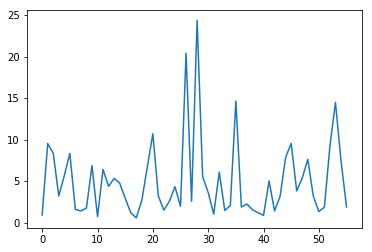

In [92]:
plt.plot(cost_over_time);